In [112]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
import scipy.special as ss
import seaborn as sns
import pandas as pd

In [2]:
# define ivim and RMSE functions
def ivim(b, Dp, Dt, Fp):
    return Fp*np.exp(-b*Dp) + (1-Fp)*np.exp(-b*Dt)

def RMSE(a, b):
    #size_vec = np.shape(a)
    RMSE = np.sum((a-b)**2)/(100*100)
    RMSE = np.sqrt(RMSE)
    return RMSE

def binomial_prob(B, N, delta):
    return ss.binom(N, B) * (delta ** B) * ((1-delta) ** (N-B))

def get_qunatile(net, calibration_dataset, alpha):
    net.eval()
    with torch.no_grad():
        S_calib_pred, Dp_calib_pred, Dt_calib_pred, Fp_calib_pred = net(torch.from_numpy(calibration_dataset.astype(np.float32)))

    Dp_scores = np.sort(np.abs(Dp_calib_pred - Dp_calib), axis=None)
    Dt_scores = np.sort(np.abs(Dt_calib_pred - Dt_calib), axis=None)
    Fp_scores = np.sort(np.abs(Fp_calib_pred - Fp_calib), axis=None)

    ###################################################################
    # 2 extract the 1-alpha quantile from the non-conformity scores   #
    ###################################################################
    # alpha = 0.05
    k = int(np.ceil((len(calibration_dataset) + 1) * (1 - alpha)))
    Fp_quantile = Fp_scores[k]
    Dp_quantile = Dp_scores[k]
    Dt_quantile = Dt_scores[k]

    return Dp_quantile, Dt_quantile, Fp_quantile

In [3]:
# define b values
b_values = np.array([0, 10, 20, 60, 150, 300, 500, 1000])
b_values_no0 = torch.FloatTensor(b_values[1:])

# training data
num_samples = 100000  # 1000000 # 2000000
X_train = np.zeros((num_samples, len(b_values)))
Dp_train = np.random.uniform(0.01, 0.1, size=(num_samples, ))
Dt_train = np.random.uniform(0.0005, 0.002, size=(num_samples, ))
Fp_train = np.random.uniform(0.1, 0.4, size=(num_samples, ))
for index, b_value in enumerate(b_values):
    X_train[:, index] = ivim(b_value, Dp_train, Dt_train, Fp_train)
# add some noise
X_train_real = X_train + np.random.normal(scale=0.01, size=(num_samples, len(b_values)))
X_train_imag = np.random.normal(scale=0.01, size=(num_samples, len(b_values)))
X_train = np.sqrt(X_train_real**2 + X_train_imag**2)

# test data
num_samples_test = 100
X_test = np.zeros((num_samples_test, len(b_values)))
Dp_test = np.random.uniform(0.01, 0.1, size=(num_samples_test, ))
Dt_test = np.random.uniform(0.0005, 0.002, size=(num_samples_test, ))
Fp_test = np.random.uniform(0.1, 0.4, size=(num_samples_test, ))
for index, b_value in enumerate(b_values):
    X_test[:, index] = ivim(b_value, Dp_test, Dt_test, Fp_test)

In [4]:
# calibration data
num_samples_calib = 4000
X_calib = np.zeros((num_samples_calib, len(b_values)))
Dp_calib = np.random.uniform(0.01, 0.1, size=(num_samples_calib, ))
Dt_calib = np.random.uniform(0.0005, 0.002, size=(num_samples_calib, ))
Fp_calib = np.random.uniform(0.1, 0.4, size=(num_samples_calib, ))
for index, b_value in enumerate(b_values):
    X_calib[:, index] = ivim(b_value, Dp_calib, Dt_calib, Fp_calib)
X_calib = X_calib[:, 1:]

In [5]:
# Create the neural network and instantiate it
class Net(nn.Module):
    def __init__(self, b_values_no0):
        super(Net, self).__init__()

        self.b_values_no0 = b_values_no0
        self.fc_layers = nn.ModuleList()
        for i in range(2): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), 3))

    def forward(self, X):
        params = torch.abs(self.encoder(X))  # Dp, Dt, Fp
        Dp = params[:, 0].unsqueeze(1)
        Dt = params[:, 1].unsqueeze(1)
        Fp = params[:, 2].unsqueeze(1)

        X = Fp*torch.exp(-self.b_values_no0*Dp) + (1-Fp)*torch.exp(-self.b_values_no0*Dt)

        return X, Dp, Dt, Fp

In [6]:
# Loss function
criterion = nn.MSELoss()

# training hyperparameters initialization
batch_size = 128
num_batches = len(X_train) // batch_size
X_train = X_train[:, 1:]  # exclude the b=0 value as signals are normalized
best_loss = 1e16
num_bad_epochs = 0
patience = 10  # 20  # 50
loss_vector = np.zeros((1, 1000))
Dp_vector = np.zeros((1, 1000))
Dt_vector = np.zeros((1, 1000))
Fp_vector = np.zeros((1, 1000))

# stability test hyperparameters initialization
n = 10000  # 100000
kappa = int(np.floor(num_samples / n))
X_train_partitioned = np.zeros(shape=(kappa, n, X_train.shape[1]))
X_train_partitioned_n_minus_1 = np.zeros(shape=(kappa, n - 1, X_train.shape[1]))

# splitting the data
for i in range(kappa):
    partition_start, partition_end = i*n, (i+1)*n
    X_train_partitioned[i, :, :] = X_train[partition_start:partition_end, :]
    X_train_partitioned_n_minus_1[i, :, :] = X_train[partition_start:partition_end-1, :]

In [7]:
random_seeds = np.random.randint(low=100, high=900, size=kappa)
print('random_seeds = ' + str(random_seeds))
iteration_delta = np.zeros(shape=(kappa, 3))

# net initialization
net_stability = np.empty(shape=(kappa, 2), dtype=object)
for k in range(kappa):
    for i in range(2):
        torch.manual_seed(random_seeds[k])
        net_stability[k, i] = Net(b_values_no0)

quantile_stability = np.zeros(shape=(kappa, 2, 3))

random_seeds = [116 555 684 758 209 238 282 161 474 233]


In [8]:
# training for stability inference
for k in range(kappa):
    X_train_stability = np.array([X_train_partitioned[k, :, :], X_train_partitioned_n_minus_1[k, :, :]], dtype=object)
    stability_sample = X_test[k, 1:].reshape((1, 7))
    stability_sample_pred = np.zeros([X_train_stability.shape[0], 3])

    trainloader_stability = np.empty(X_train_stability.shape, dtype=object)
    for index, dataset in enumerate(X_train_stability):
        trainloader_stability[index] = utils.DataLoader(torch.from_numpy(dataset.astype(np.float32)),
                                                        batch_size=batch_size, shuffle=True, drop_last=True)

    # Train
    for index, dataset in enumerate(X_train_stability):
        print('iteration ' + str(k) + ', start training model ' + str(index))
        trainloader = trainloader_stability[index]
        best_loss = 1e16
        num_bad_epochs = 0
        net = net_stability[k, index]
        optimizer = optim.Adam(net.parameters(), lr=0.0001)  # 0.0001
        for epoch in range(1000):
            print("-----------------------------------------------------------------")
            print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
            net.train()
            running_loss = 0

            for i, X_batch in enumerate(tqdm(trainloader), 0):
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                X_pred, Dp_pred, Dt_pred, Fp_pred = net(X_batch)
                loss = criterion(X_pred, X_batch)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            loss_vector[0,epoch] = running_loss
            Dp_vector[0,epoch] = Dp_pred[0]
            Dt_vector[0,epoch] = Dt_pred[0]
            Fp_vector[0,epoch] = Fp_pred[0]

            print("Loss: {}".format(running_loss))
            # early stopping
            if running_loss < best_loss:
                print("############### Saving good model ###############################")
                final_model = net.state_dict()
                best_loss = running_loss
                num_bad_epochs = 0
            else:
                num_bad_epochs = num_bad_epochs + 1
                if num_bad_epochs == patience:
                    print("-----------------------------------------------------------------")
                    print("Done due to patience, best loss: {}".format(best_loss))
                    print("Stopped at epoch: {}".format(epoch))
                    break

        print("-----------------------------------------------------------------")
        print("Done")
        print("best loss: {}".format(best_loss))

        # Restore best model
        net.load_state_dict(final_model)

        net.eval()
        with torch.no_grad():
            _, Dp, Dt, Fp = net(torch.from_numpy(stability_sample.astype(np.float32)))

        Dp = Dp.numpy()
        Dt = Dt.numpy()
        Fp = Fp.numpy()

        # make sure Dp is the larger value between Dp and Dt
        if np.mean(Dp) < np.mean(Dt):
            Dp, Dt = Dt, Dp
            Fp = 1 - Fp

        stability_sample_pred[index, :] = [Dp, Dt, Fp]

        # quantile_stability[k, index] = get_qunatile(net, X_calib, alpha=0.05)
        # @TODO: add qunatile calculations and save to an array

    iteration_delta[k, :] = np.abs(stability_sample_pred[0, :] - stability_sample_pred[1, :])
    # @TODO: calculate coverage delta using quantile (euclidean distance between lower and upper)

    print('iteration ' + str(k) + ', prediction for n samples: ' + str(stability_sample_pred[0, :]))
    print('iteration ' + str(k) + ', prediction for n-1 samples: ' + str(stability_sample_pred[1, :]))
    print('iteration ' + str(k) + ', abs delta: ' + str(iteration_delta[k, :]))

iteration 0, start training model 0
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.85it/s]


Loss: 25.831618040800095
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.30it/s]


Loss: 10.571434400975704
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.71it/s]


Loss: 6.068082749843597
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.66it/s]


Loss: 5.575492665171623
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.00it/s]


Loss: 5.154581304639578
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.93it/s]


Loss: 4.886857196688652
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.14it/s]


Loss: 4.600047957152128
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.58it/s]


Loss: 4.342881914228201
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.37it/s]


Loss: 4.1098776161670685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.25it/s]


Loss: 3.79913679510355
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.14it/s]


Loss: 3.619033318012953
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.73it/s]


Loss: 3.4087905324995518
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.66it/s]


Loss: 3.344526171684265
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.70it/s]


Loss: 3.1194175966084003
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.59it/s]


Loss: 3.0508765801787376
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.76it/s]


Loss: 3.0024690069258213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.22it/s]


Loss: 2.961869867518544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.29it/s]


Loss: 2.914846647530794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.83it/s]


Loss: 2.8895339146256447
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.93it/s]


Loss: 2.7827700711786747
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.16it/s]


Loss: 2.845778714865446
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.58it/s]


Loss: 2.728956500068307
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.68it/s]


Loss: 2.706726636737585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.48it/s]


Loss: 2.79283650778234
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.84it/s]


Loss: 2.7067462783306837
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.29it/s]


Loss: 2.603482523933053
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.02it/s]


Loss: 2.476681735366583
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.66it/s]


Loss: 2.4082394521683455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.87it/s]


Loss: 2.370892468839884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.71it/s]


Loss: 2.279678227379918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.79it/s]


Loss: 2.2467192243784666
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.09it/s]


Loss: 2.153779026120901
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.53it/s]


Loss: 2.117968872189522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.78it/s]


Loss: 2.157950773835182
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.10it/s]


Loss: 2.097473621368408
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.05it/s]


Loss: 2.031836222857237
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.25it/s]


Loss: 2.021056665107608
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.20it/s]


Loss: 1.997512912377715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.81it/s]


Loss: 1.989932605996728
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.32it/s]


Loss: 1.9612005017697811
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.81it/s]


Loss: 1.9032627940177917
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.87it/s]


Loss: 1.9440829399973154
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.04it/s]


Loss: 1.9146283194422722
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.06it/s]


Loss: 1.8602299075573683
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.03it/s]


Loss: 1.8381714839488268
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.28it/s]


Loss: 1.8207947853952646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.88it/s]


Loss: 1.8441983833909035
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.38it/s]


Loss: 1.768215598538518
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.98it/s]


Loss: 1.765311187133193
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.07it/s]


Loss: 1.7201223094016314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.21it/s]


Loss: 1.6997584626078606
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.95it/s]


Loss: 1.7039003502577543
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.58it/s]


Loss: 1.7115957643836737
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.78it/s]


Loss: 1.6921058930456638
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.52it/s]


Loss: 1.6653210651129484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.02it/s]


Loss: 1.6196283102035522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.44it/s]


Loss: 1.6021538656204939
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.55it/s]


Loss: 1.5973538998514414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.69it/s]


Loss: 1.6185854822397232
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 360.65it/s]


Loss: 1.6126706283539534
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.00it/s]


Loss: 1.5794638199731708
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.52it/s]


Loss: 1.537331847473979
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.40it/s]


Loss: 1.5296289213001728
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.92it/s]


Loss: 1.5093812961131334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.06it/s]


Loss: 1.5703141074627638
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.63it/s]


Loss: 1.5213865106925368
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.04it/s]


Loss: 1.4620330380275846
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.46it/s]


Loss: 1.4695281507447362
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.91it/s]


Loss: 1.481873944401741
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 297.39it/s]


Loss: 1.4555972209200263
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.58it/s]


Loss: 1.4659711932763457
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.10it/s]


Loss: 1.4739059638231993
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.77it/s]


Loss: 1.3953858958557248
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.25it/s]


Loss: 1.3991764113307
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.77it/s]


Loss: 1.3914986355230212
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.79it/s]


Loss: 1.3752634162083268
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.12it/s]


Loss: 1.3640687465667725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.91it/s]


Loss: 1.3656891342252493
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.13it/s]


Loss: 1.329784957692027
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.39it/s]


Loss: 1.3625395745038986
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.65it/s]


Loss: 1.3470253013074398
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.48it/s]


Loss: 1.3049037754535675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.52it/s]


Loss: 1.3052242072299123
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.29it/s]


Loss: 1.2899903934448957
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.42it/s]


Loss: 1.276705289259553
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.38it/s]


Loss: 1.269474357366562
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 371.58it/s]


Loss: 1.2465369291603565
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.53it/s]


Loss: 1.2705898936837912
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.85it/s]


Loss: 1.2526449393481016
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.47it/s]


Loss: 1.2044304590672255
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.36it/s]


Loss: 1.2081353086978197
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.55it/s]


Loss: 1.1942944759503007
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.70it/s]


Loss: 1.1902456041425467
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.09it/s]


Loss: 1.2001663651317358
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.48it/s]


Loss: 1.1807649368420243
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.90it/s]


Loss: 1.153681794181466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.56it/s]


Loss: 1.1771423239260912
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.41it/s]


Loss: 1.1762308608740568
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.55it/s]


Loss: 1.1753053590655327
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.24it/s]


Loss: 1.1167163252830505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.19it/s]


Loss: 1.1030812952667475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.18it/s]


Loss: 1.1307926960289478
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.42it/s]


Loss: 1.1251638690009713
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 176.36it/s]


Loss: 1.1184324091300368
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 169.57it/s]


Loss: 1.0951736867427826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.51it/s]


Loss: 1.0807124013081193
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.33it/s]


Loss: 1.0989605328068137
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 190.59it/s]


Loss: 1.0707350699231029
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.67it/s]


Loss: 1.0648351181298494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.47it/s]


Loss: 1.0680238828063011
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.56it/s]


Loss: 1.0309274094179273
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 237.83it/s]


Loss: 1.1196143990382552
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.14it/s]


Loss: 1.0423304047435522
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.40it/s]


Loss: 1.036307412199676
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.59it/s]


Loss: 1.0098848761990666
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 220.37it/s]


Loss: 1.015123394317925
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.46it/s]


Loss: 1.0185000244528055
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.64it/s]


Loss: 0.9957029800862074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 220.15it/s]


Loss: 0.9886843077838421
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.05it/s]


Loss: 1.0077845118939877
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.25it/s]


Loss: 0.9752098741009831
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.62it/s]


Loss: 0.9933902686461806
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.99it/s]


Loss: 0.9663006076589227
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.57it/s]


Loss: 0.9685146287083626
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.33it/s]


Loss: 0.9567795479670167
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.47it/s]


Loss: 0.9663989832624793
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.46it/s]


Loss: 0.9592056320980191
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.74it/s]


Loss: 0.9417041512206197
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.29it/s]


Loss: 0.9481540862470865
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.14it/s]


Loss: 0.9084175666794181
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.73it/s]


Loss: 0.9393869312480092
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.32it/s]


Loss: 0.9066058965399861
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.47it/s]


Loss: 0.9435402033850551
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.07it/s]


Loss: 0.9255149913951755
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.87it/s]


Loss: 0.909540674649179
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.13it/s]


Loss: 0.9203802971169353
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.96it/s]


Loss: 0.9072213303297758
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.34it/s]


Loss: 0.9023581529036164
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.11it/s]


Loss: 0.9384767832234502
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.12it/s]


Loss: 0.8728273641318083
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.32it/s]


Loss: 0.8672703886404634
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.23it/s]


Loss: 0.8676955299451947
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.74it/s]


Loss: 0.8676736867055297
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.00it/s]


Loss: 0.8511151615530252
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.62it/s]


Loss: 0.8815777068957686
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.40it/s]


Loss: 0.8492848081514239
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.40it/s]


Loss: 0.8615606660023332
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.20it/s]


Loss: 0.8913212036713958
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.86it/s]


Loss: 0.8508398933336139
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.84it/s]


Loss: 0.860570726916194
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.90it/s]


Loss: 0.8234158959239721
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 125.83it/s]


Loss: 0.8253653207793832
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 163.30it/s]


Loss: 0.8168664472177625
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.96it/s]


Loss: 0.8267098814249039
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.28it/s]


Loss: 0.8284521214663982
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.15it/s]


Loss: 0.8146016420796514
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.50it/s]


Loss: 0.8057989785447717
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.66it/s]


Loss: 0.8364430209621787
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.35it/s]


Loss: 0.7915024403482676
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.60it/s]


Loss: 0.8252269262447953
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.57it/s]


Loss: 0.8219691179692745
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.66it/s]


Loss: 0.8587158117443323
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.33it/s]


Loss: 0.815413212403655
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.32it/s]


Loss: 0.8123353449627757
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 341.33it/s]


Loss: 0.8339659636840224
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.85it/s]


Loss: 0.7759004957042634
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.06it/s]


Loss: 0.7936985194683075
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.72it/s]


Loss: 0.78779093362391
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 237.59it/s]


Loss: 0.8147052265703678
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.63it/s]


Loss: 0.7742775240913033
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.78it/s]


Loss: 0.7561518335714936
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.65it/s]


Loss: 0.8326172502711415
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 220.59it/s]


Loss: 0.7664644047617912
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.40it/s]


Loss: 0.7528461739420891
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.03it/s]


Loss: 0.7796532944776118
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.05it/s]


Loss: 0.7600374538451433
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.62it/s]


Loss: 0.7759043416008353
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.71it/s]


Loss: 0.7470767013728619
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.21it/s]


Loss: 0.7298460560850799
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 237.72it/s]


Loss: 0.7580186817795038
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.24it/s]


Loss: 0.744747597258538
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.46it/s]


Loss: 0.7526424368843436
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.87it/s]


Loss: 0.7206896049901843
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.37it/s]


Loss: 0.7527266186662018
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.23it/s]


Loss: 0.7204942149110138
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.95it/s]


Loss: 0.7067462308332324
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.90it/s]


Loss: 0.722274090629071
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.61it/s]


Loss: 0.7227881196886301
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.28it/s]


Loss: 0.71668830094859
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.50it/s]


Loss: 0.7259242706932127
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.09it/s]


Loss: 0.7368052923120558
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.22it/s]


Loss: 0.7210325584746897
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.86it/s]


Loss: 0.712897093500942
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.68it/s]


Loss: 0.7510719918645918
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.38it/s]


Loss: 0.7105945823714137
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 161.24it/s]


Loss: 0.702848978806287
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 202.87it/s]


Loss: 0.6876433780416846
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.11it/s]


Loss: 0.7111961971968412
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.00it/s]


Loss: 0.6933411085046828
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.96it/s]


Loss: 0.6958641605451703
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.75it/s]


Loss: 0.7045866940170527
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.74it/s]


Loss: 0.6898780409246683
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.33it/s]


Loss: 0.7145872106775641
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.53it/s]


Loss: 0.6804400403052568
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.81it/s]


Loss: 0.6880595330148935
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.95it/s]


Loss: 0.6641736654564738
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.58it/s]


Loss: 0.691873558331281
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 389.77it/s]


Loss: 0.6871613608673215
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.89it/s]


Loss: 0.7306515299715102
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.53it/s]


Loss: 0.6660848120227456
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.71it/s]


Loss: 0.6579126822762191
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.26it/s]


Loss: 0.6790723903104663
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.65it/s]


Loss: 0.686862681992352
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.09it/s]


Loss: 0.6508065401576459
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.53it/s]


Loss: 0.6723510450683534
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.62it/s]


Loss: 0.6542096580378711
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 213.37it/s]


Loss: 0.6494920016266406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.92it/s]


Loss: 0.6448501450940967
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.27it/s]


Loss: 0.659544148016721
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.05it/s]


Loss: 0.6383093455806375
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.63it/s]


Loss: 0.6661270097829401
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.09it/s]


Loss: 0.6428119479678571
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.32it/s]


Loss: 0.6500570792704821
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.39it/s]


Loss: 0.6342837768606842
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.92it/s]


Loss: 0.6373525359667838
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.85it/s]


Loss: 0.6475005866959691
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.40it/s]


Loss: 0.6619970225729048
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.84it/s]


Loss: 0.6457860469818115
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.24it/s]


Loss: 0.6609898554161191
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.64it/s]


Loss: 0.6628395044244826
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 365.32it/s]


Loss: 0.6350678582675755
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.36it/s]


Loss: 0.6414498127996922
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.09it/s]


Loss: 0.6150074354372919
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.66it/s]


Loss: 0.6336737335659564
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 199.22it/s]


Loss: 0.6069549573585391
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.45it/s]


Loss: 0.609152517747134
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 142.57it/s]


Loss: 0.6648231777362525
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 164.65it/s]


Loss: 0.630785423796624
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 178.04it/s]


Loss: 0.6059030354954302
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.18it/s]


Loss: 0.6337077841162682
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.23it/s]


Loss: 0.6272202874533832
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.90it/s]


Loss: 0.619483292568475
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 168.47it/s]


Loss: 0.6630083839409053
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 130.03it/s]


Loss: 0.6279471786692739
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 148.65it/s]


Loss: 0.5942647233605385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.74it/s]


Loss: 0.603214465547353
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.79it/s]


Loss: 0.5876169810071588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 189.58it/s]


Loss: 0.6091996417380869
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.16it/s]


Loss: 0.5872414018958807
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 170.06it/s]


Loss: 0.5949095957912505
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 174.26it/s]


Loss: 0.5862651532515883
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 196.05it/s]


Loss: 0.5913153081201017
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.15it/s]


Loss: 0.5869331369176507
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 201.46it/s]


Loss: 0.585116034373641
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 201.20it/s]


Loss: 0.625430153682828
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 220.13it/s]


Loss: 0.6298843212425709
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.16it/s]


Loss: 0.5733704012818635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.94it/s]


Loss: 0.5840193359181285
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 151.82it/s]


Loss: 0.583563270047307
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.59it/s]


Loss: 0.5738734379410744
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 169.90it/s]


Loss: 0.5755097032524645
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 169.07it/s]


Loss: 0.5617244043387473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 145.88it/s]


Loss: 0.5890301675535738
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.25it/s]


Loss: 0.5983469425700605
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.61it/s]


Loss: 0.5767641887068748
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.34it/s]


Loss: 0.5738027528859675
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.15it/s]


Loss: 0.5566582875326276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.78it/s]


Loss: 0.5914649292826653
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.22it/s]


Loss: 0.5746013717725873
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.54it/s]


Loss: 0.5867334548383951
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 323.25it/s]


Loss: 0.5857491279020905
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.14it/s]


Loss: 0.5564329521730542
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.34it/s]


Loss: 0.5451414547860622
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.41it/s]


Loss: 0.5422288891859353
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.78it/s]


Loss: 0.5536453011445701
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.10it/s]


Loss: 0.5412413603626192
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.17it/s]


Loss: 0.5454186336137354
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.20it/s]


Loss: 0.5495442426763475
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.63it/s]


Loss: 0.5776060950011015
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.73it/s]


Loss: 0.5595681997947395
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.45it/s]


Loss: 0.5323761370964348
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.19it/s]


Loss: 0.5306317303329706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.65it/s]


Loss: 0.5527612869627774
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.49it/s]


Loss: 0.5267899027094245
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.75it/s]


Loss: 0.5129898083396256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.47it/s]


Loss: 0.536615067627281
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.37it/s]


Loss: 0.5209422581829131
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.88it/s]


Loss: 0.5230597304180264
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.80it/s]


Loss: 0.5125528909265995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 178.69it/s]


Loss: 0.5194875942543149
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.05it/s]


Loss: 0.5163635415956378
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.28it/s]


Loss: 0.5281115733087063
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.32it/s]


Loss: 0.5365329133346677
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.40it/s]


Loss: 0.5221423082984984
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.42it/s]


Loss: 0.5210080966353416
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.71it/s]


Loss: 0.4988162834197283
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.28it/s]


Loss: 0.492074781563133
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.64it/s]


Loss: 0.5110772070474923
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.84it/s]


Loss: 0.51423136331141
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.42it/s]


Loss: 0.5008419887162745
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.75it/s]


Loss: 0.4978895760141313
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.82it/s]


Loss: 0.48179653799161315
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.34it/s]


Loss: 0.47847668873146176
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.53it/s]


Loss: 0.47257262328639627
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.96it/s]


Loss: 0.4725133767351508
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.94it/s]


Loss: 0.4712147703394294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.49it/s]


Loss: 0.45997500279918313
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.83it/s]


Loss: 0.5243001994676888
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.10it/s]


Loss: 0.457390483468771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.99it/s]


Loss: 0.4926335266791284
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.49it/s]


Loss: 0.44728909060359
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.57it/s]


Loss: 0.45325735630467534
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.02it/s]


Loss: 0.46799812326207757
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.11it/s]


Loss: 0.4478872064501047
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 386.54it/s]


Loss: 0.4378016167320311
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.08it/s]


Loss: 0.44698224449530244
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.64it/s]


Loss: 0.44527901802212
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 297.38it/s]


Loss: 0.42616461450234056
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.88it/s]


Loss: 0.4471548181027174
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.16it/s]


Loss: 0.4245237810537219
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.45it/s]


Loss: 0.41446285182610154
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.93it/s]


Loss: 0.41133581660687923
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.28it/s]


Loss: 0.3998026172630489
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.78it/s]


Loss: 0.3969537513330579
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.72it/s]


Loss: 0.40671321703121066
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.61it/s]


Loss: 0.41992411902174354
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.46it/s]


Loss: 0.3835432408377528
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.70it/s]


Loss: 0.3787267778534442
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 181.25it/s]


Loss: 0.3892558505758643
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.68it/s]


Loss: 0.3803827613592148
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 201.62it/s]


Loss: 0.35773136280477047
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 179.80it/s]


Loss: 0.36396563798189163
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.76it/s]


Loss: 0.35693948599509895
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.72it/s]


Loss: 0.3436255296692252
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.07it/s]


Loss: 0.33876041881740093
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.64it/s]


Loss: 0.3291374947875738
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.11it/s]


Loss: 0.3340418804436922
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.60it/s]


Loss: 0.32164520863443613
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.98it/s]


Loss: 0.31230400735512376
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.24it/s]


Loss: 0.3095246891025454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.44it/s]


Loss: 0.3207396259531379
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.30it/s]


Loss: 0.3042660790961236
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.37it/s]


Loss: 0.29779511922970414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 155.13it/s]


Loss: 0.31138790654949844
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 179.75it/s]


Loss: 0.3166011995635927
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 135.10it/s]


Loss: 0.28484384319745004
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 126.87it/s]


Loss: 0.2861612499691546
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 143.64it/s]


Loss: 0.27365626697428524
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.60it/s]


Loss: 0.27188662928529084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.57it/s]


Loss: 0.26146596507169306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.61it/s]


Loss: 0.26389271346852183
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.66it/s]


Loss: 0.25476041180081666
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.51it/s]


Loss: 0.250946399057284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.45it/s]


Loss: 0.25902378163300455
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.04it/s]


Loss: 0.24363764631561935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.02it/s]


Loss: 0.24927057465538383
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.76it/s]


Loss: 0.24023480992764235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.20it/s]


Loss: 0.23186100623570383
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 287.58it/s]


Loss: 0.23940168810077012
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.42it/s]


Loss: 0.22657061647623777
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.83it/s]


Loss: 0.23017450980842113
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 122.44it/s]


Loss: 0.23105990584008396
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 108.20it/s]


Loss: 0.2358844189438969
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 177.64it/s]


Loss: 0.220379019388929
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 151.21it/s]


Loss: 0.214013428427279
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 168.13it/s]


Loss: 0.2115821938496083
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.33it/s]


Loss: 0.21172932558692992
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.42it/s]


Loss: 0.20805896446108818
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.94it/s]


Loss: 0.21272747172042727
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.95it/s]


Loss: 0.20194907719269395
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.59it/s]


Loss: 0.19858056236989796
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.40it/s]


Loss: 0.19406032655388117
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 142.50it/s]


Loss: 0.1970140035264194
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.81it/s]


Loss: 0.19766339950729162
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 166.64it/s]


Loss: 0.19092906080186367
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.65it/s]


Loss: 0.18845479330047965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.44it/s]


Loss: 0.1819793969625607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 156.20it/s]


Loss: 0.18283643922768533
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 202.61it/s]


Loss: 0.18303610221482813
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.32it/s]


Loss: 0.17630371544510126
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.72it/s]


Loss: 0.1816413071937859
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.04it/s]


Loss: 0.17219630954787135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.67it/s]


Loss: 0.1761828438611701
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.43it/s]


Loss: 0.17984620633069426
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.13it/s]


Loss: 0.16893318842630833
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.81it/s]


Loss: 0.17143197217956185
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.78it/s]


Loss: 0.16603182954713702
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.16it/s]


Loss: 0.16354382573626935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.72it/s]


Loss: 0.16277624294161797
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.93it/s]


Loss: 0.16265420836862177
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.15it/s]


Loss: 0.15723013679962605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.37it/s]


Loss: 0.1574665850494057
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.41it/s]


Loss: 0.15546864818315953
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.46it/s]


Loss: 0.1519761917879805
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.98it/s]


Loss: 0.15981596696656197
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 198.86it/s]


Loss: 0.15093318512663245
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.16it/s]


Loss: 0.14903744775801897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.37it/s]


Loss: 0.14967987302225083
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 181.95it/s]


Loss: 0.14374051557388157
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 189.78it/s]


Loss: 0.14161792013328522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 178.80it/s]


Loss: 0.14462266315240413
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.92it/s]


Loss: 0.14135819673538208
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 171.19it/s]


Loss: 0.14570811425801367
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 164.77it/s]


Loss: 0.14019686041865498
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 189.64it/s]


Loss: 0.1364801590098068
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 145.99it/s]


Loss: 0.13939845352433622
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 132.98it/s]


Loss: 0.13877232605591416
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 145.23it/s]


Loss: 0.13752377254422754
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.58it/s]


Loss: 0.13064104318618774
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 211.63it/s]


Loss: 0.1302796449745074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.89it/s]


Loss: 0.12951310514472425
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.98it/s]


Loss: 0.12445182853844017
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.18it/s]


Loss: 0.12711224774830043
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.24it/s]


Loss: 0.12448068673256785
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.77it/s]


Loss: 0.1292092177318409
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.59it/s]


Loss: 0.1329868531320244
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 190.57it/s]


Loss: 0.12142136285547167
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.98it/s]


Loss: 0.11970050714444369
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.92it/s]


Loss: 0.11887360515538603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.77it/s]


Loss: 0.1174139070790261
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.81it/s]


Loss: 0.11850816733203828
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 188.52it/s]


Loss: 0.11882205563597381
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.30it/s]


Loss: 0.11540065484587103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 207.40it/s]


Loss: 0.11695293767843395
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.99it/s]


Loss: 0.11907275556586683
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 159.19it/s]


Loss: 0.114861766458489
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 426; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 188.79it/s]


Loss: 0.11242115695495158
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 427; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.94it/s]


Loss: 0.10982264357153326
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 428; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.55it/s]


Loss: 0.10826439154334366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 429; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.90it/s]


Loss: 0.1131349696079269
-----------------------------------------------------------------
Epoch: 430; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.34it/s]


Loss: 0.10566132923122495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 431; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.68it/s]


Loss: 0.11192512745037675
-----------------------------------------------------------------
Epoch: 432; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.94it/s]


Loss: 0.10493434744421393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 433; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.22it/s]


Loss: 0.10389096674043685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 434; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.63it/s]


Loss: 0.10247050307225436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 435; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.39it/s]


Loss: 0.10646064288448542
-----------------------------------------------------------------
Epoch: 436; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.97it/s]


Loss: 0.10585917939897627
-----------------------------------------------------------------
Epoch: 437; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.05it/s]


Loss: 0.10230842919554561
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 438; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 199.95it/s]


Loss: 0.10862842982169241
-----------------------------------------------------------------
Epoch: 439; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.05it/s]


Loss: 0.10206188901793212
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 440; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.19it/s]


Loss: 0.09854921035002917
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 441; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.94it/s]


Loss: 0.09945027832873166
-----------------------------------------------------------------
Epoch: 442; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.94it/s]


Loss: 0.09869390825042501
-----------------------------------------------------------------
Epoch: 443; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.88it/s]


Loss: 0.0961933090002276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 444; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.46it/s]


Loss: 0.09442577115260065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 445; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.14it/s]


Loss: 0.09716357826255262
-----------------------------------------------------------------
Epoch: 446; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.27it/s]


Loss: 0.09358073165640235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 447; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.69it/s]


Loss: 0.09322875837096944
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 448; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.96it/s]


Loss: 0.09434615261852741
-----------------------------------------------------------------
Epoch: 449; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.66it/s]


Loss: 0.09328864567214623
-----------------------------------------------------------------
Epoch: 450; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.91it/s]


Loss: 0.0998900686390698
-----------------------------------------------------------------
Epoch: 451; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.44it/s]


Loss: 0.09068675403250381
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 452; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 297.86it/s]


Loss: 0.09145414392696694
-----------------------------------------------------------------
Epoch: 453; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.23it/s]


Loss: 0.08801851706812158
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 454; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.48it/s]


Loss: 0.09348134859465063
-----------------------------------------------------------------
Epoch: 455; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.42it/s]


Loss: 0.0901660643867217
-----------------------------------------------------------------
Epoch: 456; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.61it/s]


Loss: 0.0863004046259448
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 457; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.78it/s]


Loss: 0.08434954943368211
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 458; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.37it/s]


Loss: 0.08614830818260089
-----------------------------------------------------------------
Epoch: 459; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.48it/s]


Loss: 0.08453208429273218
-----------------------------------------------------------------
Epoch: 460; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 365.64it/s]


Loss: 0.08385295659536496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 461; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.56it/s]


Loss: 0.08847877499647439
-----------------------------------------------------------------
Epoch: 462; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.33it/s]


Loss: 0.0850242818123661
-----------------------------------------------------------------
Epoch: 463; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.20it/s]


Loss: 0.08224143908591941
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 464; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.28it/s]


Loss: 0.08164601109456271
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 465; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.49it/s]


Loss: 0.07997958653140813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 466; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.47it/s]


Loss: 0.08017768646823242
-----------------------------------------------------------------
Epoch: 467; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.69it/s]


Loss: 0.08028089860454202
-----------------------------------------------------------------
Epoch: 468; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.13it/s]


Loss: 0.08084122312720865
-----------------------------------------------------------------
Epoch: 469; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.14it/s]


Loss: 0.07872492854949087
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 470; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 126.90it/s]


Loss: 0.08425112621625885
-----------------------------------------------------------------
Epoch: 471; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 149.07it/s]


Loss: 0.0783748032990843
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 472; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 127.65it/s]


Loss: 0.0788666529697366
-----------------------------------------------------------------
Epoch: 473; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 130.49it/s]


Loss: 0.08118926838506013
-----------------------------------------------------------------
Epoch: 474; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 127.33it/s]


Loss: 0.07730378396809101
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 475; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 125.99it/s]


Loss: 0.0766922221519053
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 476; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 110.08it/s]


Loss: 0.07676216494292021
-----------------------------------------------------------------
Epoch: 477; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 163.49it/s]


Loss: 0.07742776838131249
-----------------------------------------------------------------
Epoch: 478; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 128.46it/s]


Loss: 0.07510814466513693
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 479; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 120.31it/s]


Loss: 0.0761885666870512
-----------------------------------------------------------------
Epoch: 480; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 127.45it/s]


Loss: 0.0896354767610319
-----------------------------------------------------------------
Epoch: 481; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 130.97it/s]


Loss: 0.07359488011570647
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 482; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 159.21it/s]


Loss: 0.07509610161650926
-----------------------------------------------------------------
Epoch: 483; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.65it/s]


Loss: 0.07158961601089686
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 484; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 173.21it/s]


Loss: 0.07426299410872161
-----------------------------------------------------------------
Epoch: 485; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 193.43it/s]


Loss: 0.07421000360045582
-----------------------------------------------------------------
Epoch: 486; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.87it/s]


Loss: 0.07187341433018446
-----------------------------------------------------------------
Epoch: 487; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 169.04it/s]


Loss: 0.07327476213686168
-----------------------------------------------------------------
Epoch: 488; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 107.81it/s]


Loss: 0.07222294952953234
-----------------------------------------------------------------
Epoch: 489; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 132.01it/s]


Loss: 0.07091916789067909
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 490; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 126.53it/s]


Loss: 0.07167187449522316
-----------------------------------------------------------------
Epoch: 491; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 106.61it/s]


Loss: 0.06967941537732258
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 492; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 179.60it/s]


Loss: 0.0714039015583694
-----------------------------------------------------------------
Epoch: 493; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 118.70it/s]


Loss: 0.06887758581433445
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 494; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 110.37it/s]


Loss: 0.07161071430891752
-----------------------------------------------------------------
Epoch: 495; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.69it/s]


Loss: 0.06802458735182881
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 496; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.82it/s]


Loss: 0.07006514479871839
-----------------------------------------------------------------
Epoch: 497; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.03it/s]


Loss: 0.06804746389389038
-----------------------------------------------------------------
Epoch: 498; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.56it/s]


Loss: 0.067385331785772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 499; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.25it/s]


Loss: 0.07216474279994145
-----------------------------------------------------------------
Epoch: 500; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.13it/s]


Loss: 0.06682443455792964
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 501; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.32it/s]


Loss: 0.06782119686249644
-----------------------------------------------------------------
Epoch: 502; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.20it/s]


Loss: 0.06656829273561016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 503; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 211.56it/s]


Loss: 0.0677360097761266
-----------------------------------------------------------------
Epoch: 504; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.48it/s]


Loss: 0.0662014847039245
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 505; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.30it/s]


Loss: 0.06804990494856611
-----------------------------------------------------------------
Epoch: 506; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.90it/s]


Loss: 0.06640989106381312
-----------------------------------------------------------------
Epoch: 507; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.39it/s]


Loss: 0.06777369987685233
-----------------------------------------------------------------
Epoch: 508; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.97it/s]


Loss: 0.06453378294827417
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 509; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.71it/s]


Loss: 0.06711191486101598
-----------------------------------------------------------------
Epoch: 510; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 173.16it/s]


Loss: 0.0652365775895305
-----------------------------------------------------------------
Epoch: 511; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.88it/s]


Loss: 0.06489407940534875
-----------------------------------------------------------------
Epoch: 512; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.93it/s]


Loss: 0.06246002233820036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 513; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 164.21it/s]


Loss: 0.06379533465951681
-----------------------------------------------------------------
Epoch: 514; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.82it/s]


Loss: 0.06595160672441125
-----------------------------------------------------------------
Epoch: 515; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.90it/s]


Loss: 0.061997642274945974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 516; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 126.88it/s]


Loss: 0.06323941104346886
-----------------------------------------------------------------
Epoch: 517; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.30it/s]


Loss: 0.06391893804538995
-----------------------------------------------------------------
Epoch: 518; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 184.16it/s]


Loss: 0.06315692857606336
-----------------------------------------------------------------
Epoch: 519; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 201.11it/s]


Loss: 0.06336195074254647
-----------------------------------------------------------------
Epoch: 520; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 168.07it/s]


Loss: 0.06544917583232746
-----------------------------------------------------------------
Epoch: 521; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.16it/s]


Loss: 0.06467862689169124
-----------------------------------------------------------------
Epoch: 522; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.13it/s]


Loss: 0.06370068853721023
-----------------------------------------------------------------
Epoch: 523; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.89it/s]


Loss: 0.06305377022363245
-----------------------------------------------------------------
Epoch: 524; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.12it/s]


Loss: 0.0628098135930486
-----------------------------------------------------------------
Epoch: 525; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.16it/s]


Loss: 0.061656331934500486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 526; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.25it/s]


Loss: 0.05995573598193005
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 527; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.54it/s]


Loss: 0.060739539738278836
-----------------------------------------------------------------
Epoch: 528; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 297.51it/s]


Loss: 0.0617919109063223
-----------------------------------------------------------------
Epoch: 529; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.58it/s]


Loss: 0.06322255812119693
-----------------------------------------------------------------
Epoch: 530; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.58it/s]


Loss: 0.06233277602586895
-----------------------------------------------------------------
Epoch: 531; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.09it/s]


Loss: 0.06066165916854516
-----------------------------------------------------------------
Epoch: 532; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.75it/s]


Loss: 0.06019060453400016
-----------------------------------------------------------------
Epoch: 533; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.38it/s]


Loss: 0.059168074862100184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 534; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.25it/s]


Loss: 0.06042181246448308
-----------------------------------------------------------------
Epoch: 535; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.57it/s]


Loss: 0.05944424221524969
-----------------------------------------------------------------
Epoch: 536; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.66it/s]


Loss: 0.05965540191391483
-----------------------------------------------------------------
Epoch: 537; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.08it/s]


Loss: 0.05881508952006698
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 538; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.75it/s]


Loss: 0.05977651313878596
-----------------------------------------------------------------
Epoch: 539; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.61it/s]


Loss: 0.060135058069135994
-----------------------------------------------------------------
Epoch: 540; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 387.78it/s]


Loss: 0.06354292831383646
-----------------------------------------------------------------
Epoch: 541; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.29it/s]


Loss: 0.06049134029308334
-----------------------------------------------------------------
Epoch: 542; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.28it/s]


Loss: 0.0587152136140503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 543; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.26it/s]


Loss: 0.05792406853288412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 544; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 211.50it/s]


Loss: 0.060509603936225176
-----------------------------------------------------------------
Epoch: 545; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.08it/s]


Loss: 0.0576308059389703
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 546; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.49it/s]


Loss: 0.058836928044911474
-----------------------------------------------------------------
Epoch: 547; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.98it/s]


Loss: 0.05766104540089145
-----------------------------------------------------------------
Epoch: 548; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.30it/s]


Loss: 0.05734997073886916
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 549; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.49it/s]


Loss: 0.06343565986026078
-----------------------------------------------------------------
Epoch: 550; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.63it/s]


Loss: 0.06159515987383202
-----------------------------------------------------------------
Epoch: 551; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.76it/s]


Loss: 0.05655874888179824
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 552; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.60it/s]


Loss: 0.05699112743604928
-----------------------------------------------------------------
Epoch: 553; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.44it/s]


Loss: 0.05763174797175452
-----------------------------------------------------------------
Epoch: 554; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.34it/s]


Loss: 0.056387478311080486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 555; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 190.01it/s]


Loss: 0.05798569554463029
-----------------------------------------------------------------
Epoch: 556; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 157.84it/s]


Loss: 0.05628959683235735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 557; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 131.50it/s]


Loss: 0.05611269408836961
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 558; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 164.88it/s]


Loss: 0.056859873642679304
-----------------------------------------------------------------
Epoch: 559; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.30it/s]


Loss: 0.05612438463140279
-----------------------------------------------------------------
Epoch: 560; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.11it/s]


Loss: 0.05654236959526315
-----------------------------------------------------------------
Epoch: 561; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.99it/s]


Loss: 0.05590800306526944
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 562; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 232.19it/s]


Loss: 0.05616530834231526
-----------------------------------------------------------------
Epoch: 563; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.50it/s]


Loss: 0.05540664377622306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 564; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 188.09it/s]


Loss: 0.05648225132608786
-----------------------------------------------------------------
Epoch: 565; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.83it/s]


Loss: 0.057071280491072685
-----------------------------------------------------------------
Epoch: 566; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.92it/s]


Loss: 0.05771803390234709
-----------------------------------------------------------------
Epoch: 567; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.02it/s]


Loss: 0.055468485807068646
-----------------------------------------------------------------
Epoch: 568; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.13it/s]


Loss: 0.0564379480201751
-----------------------------------------------------------------
Epoch: 569; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.85it/s]


Loss: 0.055465582583565265
-----------------------------------------------------------------
Epoch: 570; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.67it/s]


Loss: 0.05482161493273452
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 571; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.28it/s]


Loss: 0.054575489775743335
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 572; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.20it/s]


Loss: 0.05706811940763146
-----------------------------------------------------------------
Epoch: 573; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.88it/s]


Loss: 0.06155863654566929
-----------------------------------------------------------------
Epoch: 574; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.13it/s]


Loss: 0.055589556926861405
-----------------------------------------------------------------
Epoch: 575; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.92it/s]


Loss: 0.054469947644975036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 576; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.37it/s]


Loss: 0.054149238334503025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 577; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.34it/s]


Loss: 0.054831416287925094
-----------------------------------------------------------------
Epoch: 578; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.95it/s]


Loss: 0.054720244253985584
-----------------------------------------------------------------
Epoch: 579; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.13it/s]


Loss: 0.05566065741004422
-----------------------------------------------------------------
Epoch: 580; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.13it/s]


Loss: 0.05566951626678929
-----------------------------------------------------------------
Epoch: 581; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.01it/s]


Loss: 0.05401989963138476
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 582; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.77it/s]


Loss: 0.05451984435785562
-----------------------------------------------------------------
Epoch: 583; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.74it/s]


Loss: 0.0554744892870076
-----------------------------------------------------------------
Epoch: 584; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.83it/s]


Loss: 0.054102167719975114
-----------------------------------------------------------------
Epoch: 585; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.55it/s]


Loss: 0.05521656043129042
-----------------------------------------------------------------
Epoch: 586; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.08it/s]


Loss: 0.054318800335749984
-----------------------------------------------------------------
Epoch: 587; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.58it/s]


Loss: 0.05406603281153366
-----------------------------------------------------------------
Epoch: 588; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.19it/s]


Loss: 0.054079229885246605
-----------------------------------------------------------------
Epoch: 589; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.23it/s]


Loss: 0.05351424930267967
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 590; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.84it/s]


Loss: 0.054162306361831725
-----------------------------------------------------------------
Epoch: 591; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.86it/s]


Loss: 0.05372149957111105
-----------------------------------------------------------------
Epoch: 592; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.32it/s]


Loss: 0.05410785676212981
-----------------------------------------------------------------
Epoch: 593; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.88it/s]


Loss: 0.05268016748595983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 594; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.38it/s]


Loss: 0.05330433166818693
-----------------------------------------------------------------
Epoch: 595; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.57it/s]


Loss: 0.05321692110737786
-----------------------------------------------------------------
Epoch: 596; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.67it/s]


Loss: 0.05371843872126192
-----------------------------------------------------------------
Epoch: 597; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 505.90it/s]


Loss: 0.05309455964015797
-----------------------------------------------------------------
Epoch: 598; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.35it/s]


Loss: 0.051970037166029215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 599; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.32it/s]


Loss: 0.05321731837466359
-----------------------------------------------------------------
Epoch: 600; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.93it/s]


Loss: 0.05415890668518841
-----------------------------------------------------------------
Epoch: 601; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.36it/s]


Loss: 0.0534671600908041
-----------------------------------------------------------------
Epoch: 602; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.69it/s]


Loss: 0.05417994863819331
-----------------------------------------------------------------
Epoch: 603; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.28it/s]


Loss: 0.053251312230713665
-----------------------------------------------------------------
Epoch: 604; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.51it/s]


Loss: 0.05184759525582194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 605; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.17it/s]


Loss: 0.053455270652193576
-----------------------------------------------------------------
Epoch: 606; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.91it/s]


Loss: 0.05178005213383585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 607; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.37it/s]


Loss: 0.05541422049282119
-----------------------------------------------------------------
Epoch: 608; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.59it/s]


Loss: 0.05905780685134232
-----------------------------------------------------------------
Epoch: 609; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.86it/s]


Loss: 0.053096357092726976
-----------------------------------------------------------------
Epoch: 610; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.15it/s]


Loss: 0.051713674649363384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 611; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.07it/s]


Loss: 0.05319094576407224
-----------------------------------------------------------------
Epoch: 612; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.84it/s]


Loss: 0.05127215990796685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 613; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.25it/s]


Loss: 0.05108733335509896
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 614; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.43it/s]


Loss: 0.05124524887651205
-----------------------------------------------------------------
Epoch: 615; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.15it/s]


Loss: 0.05157449410762638
-----------------------------------------------------------------
Epoch: 616; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.08it/s]


Loss: 0.05247300391783938
-----------------------------------------------------------------
Epoch: 617; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.39it/s]


Loss: 0.051971282286103815
-----------------------------------------------------------------
Epoch: 618; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.87it/s]


Loss: 0.05127803818322718
-----------------------------------------------------------------
Epoch: 619; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.42it/s]


Loss: 0.05383872496895492
-----------------------------------------------------------------
Epoch: 620; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.91it/s]


Loss: 0.053300855215638876
-----------------------------------------------------------------
Epoch: 621; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.69it/s]


Loss: 0.052667971001937985
-----------------------------------------------------------------
Epoch: 622; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.09it/s]


Loss: 0.050509922904893756
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 623; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.72it/s]


Loss: 0.052175810909830034
-----------------------------------------------------------------
Epoch: 624; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.21it/s]


Loss: 0.050615791871678084
-----------------------------------------------------------------
Epoch: 625; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.30it/s]


Loss: 0.053243816044414416
-----------------------------------------------------------------
Epoch: 626; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.07it/s]


Loss: 0.052304113982245326
-----------------------------------------------------------------
Epoch: 627; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.68it/s]


Loss: 0.05126238090451807
-----------------------------------------------------------------
Epoch: 628; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.24it/s]


Loss: 0.050699648971203715
-----------------------------------------------------------------
Epoch: 629; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.91it/s]


Loss: 0.05232044501462951
-----------------------------------------------------------------
Epoch: 630; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.87it/s]


Loss: 0.05132020718883723
-----------------------------------------------------------------
Epoch: 631; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.49it/s]


Loss: 0.05141322535928339
-----------------------------------------------------------------
Epoch: 632; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.50it/s]
C:\Users\Shira\AppData\Local\Temp\ipykernel_81996\2664187846.py:77: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  stability_sample_pred[index, :] = [Dp, Dt, Fp]


Loss: 0.05283344740746543
-----------------------------------------------------------------
Done due to patience, best loss: 0.050509922904893756
Stopped at epoch: 632
-----------------------------------------------------------------
Done
best loss: 0.050509922904893756
iteration 0, start training model 1
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.37it/s]


Loss: 25.842136800289154
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.49it/s]


Loss: 10.550325196236372
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.54it/s]


Loss: 5.982929639518261
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.58it/s]


Loss: 5.61179543659091
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.31it/s]


Loss: 5.171468269079924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.39it/s]


Loss: 4.964502666145563
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.47it/s]


Loss: 4.599484145641327
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.87it/s]


Loss: 4.390455666929483
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.19it/s]


Loss: 4.302836697548628
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.50it/s]


Loss: 3.9916004203259945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.84it/s]


Loss: 3.68995401263237
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.11it/s]


Loss: 3.435917843133211
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.85it/s]


Loss: 3.360688030719757
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.62it/s]


Loss: 3.1531449779868126
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.22it/s]


Loss: 3.028764557093382
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.06it/s]


Loss: 3.0113455578684807
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.24it/s]


Loss: 2.910480545833707
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.38it/s]


Loss: 2.8935065381228924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.01it/s]


Loss: 2.807648876681924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.97it/s]


Loss: 2.7792847994714975
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.48it/s]


Loss: 2.7366416100412607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.80it/s]


Loss: 2.7435498517006636
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.80it/s]


Loss: 2.6740621495991945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.28it/s]


Loss: 2.6881028655916452
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.24it/s]


Loss: 2.6675055902451277
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.21it/s]


Loss: 2.5288574136793613
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.50it/s]


Loss: 2.543192893266678
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.25it/s]


Loss: 2.4696153085678816
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.17it/s]


Loss: 2.331911964341998
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.12it/s]


Loss: 2.2582203187048435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 479.19it/s]


Loss: 2.1950777396559715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.70it/s]


Loss: 2.157243810594082
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.98it/s]


Loss: 2.1222535967826843
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.58it/s]


Loss: 2.080438181757927
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.69it/s]


Loss: 2.0575737450271845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.79it/s]


Loss: 2.0107210651040077
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.71it/s]


Loss: 2.0050478782504797
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.30it/s]


Loss: 1.9732694737613201
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.96it/s]


Loss: 1.9625653810799122
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.95it/s]


Loss: 1.9297407064586878
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.42it/s]


Loss: 1.9110847990959883
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 177.80it/s]


Loss: 1.8647189531475306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.19it/s]


Loss: 1.8766005169600248
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.84it/s]


Loss: 1.877817964181304
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.75it/s]


Loss: 1.8451736513525248
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.83it/s]


Loss: 1.8197674956172705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.93it/s]


Loss: 1.7759802751243114
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.77it/s]


Loss: 1.7544962223619223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.96it/s]


Loss: 1.7267572805285454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.10it/s]


Loss: 1.6856461074203253
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.07it/s]


Loss: 1.6868294719606638
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.11it/s]


Loss: 1.821287039667368
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.89it/s]


Loss: 1.6740015912801027
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.95it/s]


Loss: 1.6677861846983433
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.86it/s]


Loss: 1.6277435515075922
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.05it/s]


Loss: 1.606870498508215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.33it/s]


Loss: 1.5745573863387108
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.09it/s]


Loss: 1.5698343571275473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.64it/s]


Loss: 1.5837854091078043
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.29it/s]


Loss: 1.5627566752955317
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.85it/s]


Loss: 1.54103409871459
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.70it/s]


Loss: 1.5270565580576658
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.50it/s]


Loss: 1.520208166912198
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.73it/s]


Loss: 1.524974281899631
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.31it/s]


Loss: 1.480698462575674
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 297.80it/s]


Loss: 1.4863470224663615
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.08it/s]


Loss: 1.4909152025356889
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.45it/s]


Loss: 1.450539574958384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 220.80it/s]


Loss: 1.450012587942183
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.30it/s]


Loss: 1.4428472090512514
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.31it/s]


Loss: 1.4121239986270666
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.36it/s]


Loss: 1.392160089686513
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.21it/s]


Loss: 1.425681959837675
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.60it/s]


Loss: 1.3745987406000495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.15it/s]


Loss: 1.3883104203268886
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.60it/s]


Loss: 1.3675314001739025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.17it/s]


Loss: 1.3513750955462456
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.22it/s]


Loss: 1.3309327755123377
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.90it/s]


Loss: 1.3404989689588547
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.62it/s]


Loss: 1.3561567207798362
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.26it/s]


Loss: 1.3067395947873592
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.71it/s]


Loss: 1.3065226515755057
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.16it/s]


Loss: 1.2692479453980923
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.26it/s]


Loss: 1.3439358845353127
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.82it/s]


Loss: 1.2958300346508622
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.65it/s]


Loss: 1.307202372699976
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.21it/s]


Loss: 1.2609110241755843
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.62it/s]


Loss: 1.239824934862554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.84it/s]


Loss: 1.20363440643996
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 479.38it/s]


Loss: 1.1901522818952799
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.28it/s]


Loss: 1.197977427393198
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.63it/s]


Loss: 1.1897772662341595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.68it/s]


Loss: 1.1757094208151102
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.69it/s]


Loss: 1.185152044519782
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.35it/s]


Loss: 1.1683014752343297
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.36it/s]


Loss: 1.1861832486465573
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.27it/s]


Loss: 1.1728198137134314
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.04it/s]


Loss: 1.1756939645856619
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.81it/s]


Loss: 1.1149727795273066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.22it/s]


Loss: 1.1386842150241137
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.98it/s]


Loss: 1.1792967561632395
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.36it/s]


Loss: 1.1913794437423348
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.74it/s]


Loss: 1.1116311606019735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.16it/s]


Loss: 1.097451145760715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.93it/s]


Loss: 1.0782283898442984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.48it/s]


Loss: 1.0583101268857718
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.41it/s]


Loss: 1.0731335170567036
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 527.95it/s]


Loss: 1.0543326484039426
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.42it/s]


Loss: 1.0781616540625691
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.30it/s]


Loss: 1.0668651228770614
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.38it/s]


Loss: 1.0373445162549615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.22it/s]


Loss: 1.020317329093814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.31it/s]


Loss: 1.0421209195628762
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.81it/s]


Loss: 1.0611744429916143
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.21it/s]


Loss: 0.9993832018226385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.59it/s]


Loss: 1.0398435415700078
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.25it/s]


Loss: 1.0078149624168873
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.86it/s]


Loss: 0.9937822297215462
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.93it/s]


Loss: 0.9866797057911754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.59it/s]


Loss: 0.9849160835146904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.81it/s]


Loss: 0.9770133839920163
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.85it/s]


Loss: 0.9717168193310499
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.27it/s]


Loss: 0.9856446851044893
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.20it/s]


Loss: 0.9600747097283602
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.28it/s]


Loss: 0.9979781899601221
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.71it/s]


Loss: 0.9443286824971437
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.30it/s]


Loss: 0.9552786536514759
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.40it/s]


Loss: 0.9486349429935217
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.82it/s]


Loss: 0.9355434272438288
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.20it/s]


Loss: 0.9179790783673525
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.46it/s]


Loss: 0.9044481636956334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.42it/s]


Loss: 0.9209812032058835
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.39it/s]


Loss: 0.9297133246436715
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.33it/s]


Loss: 0.9129071142524481
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.45it/s]


Loss: 0.958774627186358
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.52it/s]


Loss: 0.9263283014297485
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.36it/s]


Loss: 0.8964751148596406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.99it/s]


Loss: 0.9106511091813445
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.41it/s]


Loss: 0.8869551755487919
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.08it/s]


Loss: 0.8738782582804561
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.57it/s]


Loss: 0.9166023386642337
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.26it/s]


Loss: 0.8912211712449789
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.28it/s]


Loss: 0.8506819000467658
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.45it/s]


Loss: 0.8918432472273707
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.26it/s]


Loss: 0.8792307768017054
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.90it/s]


Loss: 0.842244858853519
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.58it/s]


Loss: 0.8765545105561614
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.56it/s]


Loss: 0.8648354196920991
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.42it/s]


Loss: 0.831506161019206
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.28it/s]


Loss: 0.8332015359774232
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.21it/s]


Loss: 0.8502673301845789
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.50it/s]


Loss: 0.8755872417241335
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 287.20it/s]


Loss: 0.8408820615150034
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.49it/s]


Loss: 0.8395439842715859
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.88it/s]


Loss: 0.8432239796966314
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.55it/s]


Loss: 0.8263902422040701
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.92it/s]


Loss: 0.8104078760370612
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.90it/s]


Loss: 0.8027637721970677
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.02it/s]


Loss: 0.8405806501396
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.63it/s]


Loss: 0.7979024332016706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.64it/s]


Loss: 0.8293344276025891
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.41it/s]


Loss: 0.7966866949573159
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.29it/s]


Loss: 0.8062151838093996
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.47it/s]


Loss: 0.7877924414351583
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.80it/s]


Loss: 0.8096019295044243
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.04it/s]


Loss: 0.7836205465719104
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.87it/s]


Loss: 0.7592938444577157
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.60it/s]


Loss: 0.791142818517983
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 527.12it/s]


Loss: 0.7826161878183484
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.45it/s]


Loss: 0.78934495896101
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.23it/s]


Loss: 0.780375019647181
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.18it/s]


Loss: 0.7565744556486607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.27it/s]


Loss: 0.7560188183560967
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.10it/s]


Loss: 0.7674187161028385
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.48it/s]


Loss: 0.7934396769851446
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.43it/s]


Loss: 0.7622656039893627
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.56it/s]


Loss: 0.7650626664981246
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.15it/s]


Loss: 0.7702695028856397
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.61it/s]


Loss: 0.763074429705739
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.01it/s]


Loss: 0.7322721751406789
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.55it/s]


Loss: 0.7287384988740087
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.40it/s]


Loss: 0.7512670904397964
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.80it/s]


Loss: 0.7293876260519028
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 389.47it/s]


Loss: 0.7239449168555439
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.95it/s]


Loss: 0.7210533986799419
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.04it/s]


Loss: 0.7456735102459788
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.06it/s]


Loss: 0.7199026183225214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.12it/s]


Loss: 0.7222478068433702
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.38it/s]


Loss: 0.7356077851727605
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.23it/s]


Loss: 0.7223081230185926
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 499.88it/s]


Loss: 0.7123756110668182
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.32it/s]


Loss: 0.7163568129763007
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.88it/s]


Loss: 0.7088227979838848
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.05it/s]


Loss: 0.7234783209860325
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.50it/s]


Loss: 0.7226576837711036
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.47it/s]


Loss: 0.7061994867399335
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.29it/s]


Loss: 0.7183510148897767
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.25it/s]


Loss: 0.7105438243597746
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.18it/s]


Loss: 0.697526313830167
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.66it/s]


Loss: 0.6797306411899626
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.18it/s]


Loss: 0.6940670814365149
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 373.67it/s]


Loss: 0.6898755193687975
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.91it/s]


Loss: 0.6803046339191496
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.76it/s]


Loss: 0.6753127449192107
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.16it/s]


Loss: 0.6806183038279414
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.16it/s]


Loss: 0.6730627445504069
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.55it/s]


Loss: 0.668458815664053
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.56it/s]


Loss: 0.6656539645045996
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.10it/s]


Loss: 0.687915506772697
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.10it/s]


Loss: 0.6665282770991325
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.68it/s]


Loss: 0.6679051527753472
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.20it/s]


Loss: 0.6495796274393797
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.85it/s]


Loss: 0.6565206912346184
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.00it/s]


Loss: 0.6658320678398013
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.40it/s]


Loss: 0.6443301606923342
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.19it/s]


Loss: 0.6618275288492441
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.14it/s]


Loss: 0.6585564506240189
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.15it/s]


Loss: 0.7973268935456872
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.27it/s]


Loss: 0.670972750056535
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.68it/s]


Loss: 0.6433156644925475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.95it/s]


Loss: 0.6423607845790684
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.52it/s]


Loss: 0.6377752195112407
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.25it/s]


Loss: 0.6367734503000975
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.79it/s]


Loss: 0.6300503201782703
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.04it/s]


Loss: 0.6316360691562295
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.34it/s]


Loss: 0.6696872087195516
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.79it/s]


Loss: 0.664814957883209
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.18it/s]


Loss: 0.6347920675761998
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 373.91it/s]


Loss: 0.6488869865424931
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.08it/s]


Loss: 0.6237063738517463
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.17it/s]


Loss: 0.6347347758710384
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.46it/s]


Loss: 0.6230460470542312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.60it/s]


Loss: 0.6293211076408625
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.34it/s]


Loss: 0.625062104780227
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.50it/s]


Loss: 0.624087821226567
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 499.29it/s]


Loss: 0.6554786371998489
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.72it/s]


Loss: 0.6363605908118188
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 505.12it/s]


Loss: 0.6371185537427664
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.23it/s]


Loss: 0.6571625573560596
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.76it/s]


Loss: 0.60435880580917
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.36it/s]


Loss: 0.612594592384994
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.36it/s]


Loss: 0.6036706184968352
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.37it/s]


Loss: 0.6213706079870462
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.90it/s]


Loss: 0.5976158338598907
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.34it/s]


Loss: 0.5974089307710528
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.99it/s]


Loss: 0.6041880748234689
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.63it/s]


Loss: 0.584521914832294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.03it/s]


Loss: 0.604555054102093
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 475.11it/s]


Loss: 0.6203665286302567
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.64it/s]


Loss: 0.5875460682436824
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.88it/s]


Loss: 0.6079853791743517
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.48it/s]


Loss: 0.594977187924087
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.39it/s]


Loss: 0.5823244759812951
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.54it/s]


Loss: 0.5797315216623247
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.62it/s]


Loss: 0.5802131537348032
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.84it/s]


Loss: 0.5804271167144179
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.95it/s]


Loss: 0.5852263905107975
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.66it/s]


Loss: 0.5658029424957931
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.92it/s]


Loss: 0.5774800246581435
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.55it/s]


Loss: 0.5757188741117716
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.75it/s]


Loss: 0.6144266752526164
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.45it/s]


Loss: 0.580547571182251
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.04it/s]


Loss: 0.5790207511745393
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.59it/s]


Loss: 0.55760751478374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.26it/s]


Loss: 0.5671707619912922
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.86it/s]


Loss: 0.5524988477118313
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.20it/s]


Loss: 0.5729925846680999
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.97it/s]


Loss: 0.6427264707162976
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.87it/s]


Loss: 0.5840764865279198
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.86it/s]


Loss: 0.5508922655135393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 373.74it/s]


Loss: 0.5556991780176759
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.39it/s]


Loss: 0.5556422369554639
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.03it/s]


Loss: 0.5491617298685014
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.11it/s]


Loss: 0.5557727348059416
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.66it/s]


Loss: 0.5463688159361482
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.51it/s]


Loss: 0.5382160227745771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.44it/s]


Loss: 0.5518947434611619
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.99it/s]


Loss: 0.5363411987200379
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.73it/s]


Loss: 0.5525150843895972
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 373.20it/s]


Loss: 0.5443122321739793
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.08it/s]


Loss: 0.525546747725457
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.68it/s]


Loss: 0.5300808311440051
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.15it/s]


Loss: 0.5372134065255523
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.79it/s]


Loss: 0.5336672924458981
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.64it/s]


Loss: 0.5146443587727845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.00it/s]


Loss: 0.5289125572890043
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.01it/s]


Loss: 0.5163734150119126
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 373.71it/s]


Loss: 0.553332700394094
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.88it/s]


Loss: 0.5614984859712422
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 341.07it/s]


Loss: 0.5563122425228357
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.70it/s]


Loss: 0.5159205342642963
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.22it/s]


Loss: 0.530875300988555
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.73it/s]


Loss: 0.4947420875541866
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.86it/s]


Loss: 0.5048877387307584
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.15it/s]


Loss: 0.5104818264953792
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.61it/s]


Loss: 0.490241885650903
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.58it/s]


Loss: 0.48463168554008007
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.37it/s]


Loss: 0.4870641101151705
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.86it/s]


Loss: 0.5004290700890124
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.52it/s]


Loss: 0.49601990450173616
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.00it/s]


Loss: 0.49217695696279407
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.61it/s]


Loss: 0.4781892318278551
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.27it/s]


Loss: 0.4741401309147477
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.66it/s]


Loss: 0.47474399534985423
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.08it/s]


Loss: 0.4826546204276383
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.55it/s]


Loss: 0.4742296226322651
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.60it/s]


Loss: 0.4530029147863388
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.39it/s]


Loss: 0.47378413332626224
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.18it/s]


Loss: 0.4787354404106736
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.01it/s]


Loss: 0.4733716235496104
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.84it/s]


Loss: 0.4361485787667334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.16it/s]


Loss: 0.46350318286567926
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.91it/s]


Loss: 0.4457845133729279
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.14it/s]


Loss: 0.42898797569796443
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.14it/s]


Loss: 0.45091374311596155
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.59it/s]


Loss: 0.42520261416211724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.35it/s]


Loss: 0.4213505918160081
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.72it/s]


Loss: 0.42540078330785036
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.93it/s]


Loss: 0.4228809606283903
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.47it/s]


Loss: 0.4181404884438962
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.09it/s]


Loss: 0.4182000169530511
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.82it/s]


Loss: 0.3880261229351163
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.68it/s]


Loss: 0.3904834883287549
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.73it/s]


Loss: 0.4387114401906729
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.49it/s]


Loss: 0.3984202044084668
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.85it/s]


Loss: 0.3938094696495682
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.77it/s]


Loss: 0.3892147250007838
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.67it/s]


Loss: 0.3910952592268586
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.84it/s]


Loss: 0.3660725220106542
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.45it/s]


Loss: 0.3679272788576782
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.63it/s]


Loss: 0.3523450493812561
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.45it/s]


Loss: 0.35987139237113297
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.27it/s]


Loss: 0.3702956198249012
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.85it/s]


Loss: 0.339709680294618
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.78it/s]


Loss: 0.34148243092931807
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.69it/s]


Loss: 0.33298130473122
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.12it/s]


Loss: 0.3208284331485629
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.50it/s]


Loss: 0.31706846272572875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.35it/s]


Loss: 0.3087523765861988
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.78it/s]


Loss: 0.3020158032886684
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.07it/s]


Loss: 0.29987660609185696
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 365.47it/s]


Loss: 0.3099726480431855
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.40it/s]


Loss: 0.2898349780589342
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.33it/s]


Loss: 0.28890267945826054
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.79it/s]


Loss: 0.2774905499536544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.78it/s]


Loss: 0.28259194851852953
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.95it/s]


Loss: 0.2672788759227842
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.55it/s]


Loss: 0.26539328461512923
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.37it/s]


Loss: 0.26842216355726123
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.30it/s]


Loss: 0.259607297135517
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.84it/s]


Loss: 0.2515350163448602
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.40it/s]


Loss: 0.264127699425444
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.84it/s]


Loss: 0.28045532410033047
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.16it/s]


Loss: 0.24900080380029976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.16it/s]


Loss: 0.2403225894086063
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.96it/s]


Loss: 0.24466190161183476
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.00it/s]


Loss: 0.23992252885363996
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.63it/s]


Loss: 0.22941292612813413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.24it/s]


Loss: 0.23193864128552377
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.67it/s]


Loss: 0.2284715303685516
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.97it/s]


Loss: 0.23022216837853193
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.24it/s]


Loss: 0.21675231819972396
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.53it/s]


Loss: 0.2126499330624938
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.21it/s]


Loss: 0.21289497707039118
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.75it/s]


Loss: 0.21318384632468224
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.55it/s]


Loss: 0.21740567334927619
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.37it/s]


Loss: 0.2119652924593538
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.86it/s]


Loss: 0.19876153743825853
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.31it/s]


Loss: 0.1973433862440288
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.40it/s]


Loss: 0.19651456584688276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.98it/s]


Loss: 0.19176622934173793
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.57it/s]


Loss: 0.1999485194683075
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.73it/s]


Loss: 0.18805727479048073
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.75it/s]


Loss: 0.18908595258835703
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.68it/s]


Loss: 0.18580493691843003
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.58it/s]


Loss: 0.18421073560602963
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.31it/s]


Loss: 0.1820014106342569
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.13it/s]


Loss: 0.18420379201415926
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.85it/s]


Loss: 0.17604188376571983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.60it/s]


Loss: 0.17714116454590112
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.32it/s]


Loss: 0.17473706870805472
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.79it/s]


Loss: 0.17427561432123184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 499.09it/s]


Loss: 0.1704097738256678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.77it/s]


Loss: 0.17087828007061034
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.20it/s]


Loss: 0.17214351845905185
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.67it/s]


Loss: 0.16788633668329567
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.65it/s]


Loss: 0.16720438981428742
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.94it/s]


Loss: 0.1606534846359864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.67it/s]


Loss: 0.16251963563263416
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.25it/s]


Loss: 0.16075527295470238
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.82it/s]


Loss: 0.1596151249250397
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.58it/s]


Loss: 0.158375836443156
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 401.10it/s]


Loss: 0.16100504843052477
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.12it/s]


Loss: 0.1587950469693169
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.87it/s]


Loss: 0.14556763472501189
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.94it/s]


Loss: 0.14889951632358134
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.10it/s]


Loss: 0.14696814375929534
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.30it/s]


Loss: 0.14467967709060758
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.59it/s]


Loss: 0.14643166470341384
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.63it/s]


Loss: 0.1395182729465887
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.78it/s]


Loss: 0.13938741048332304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 287.67it/s]


Loss: 0.13761609443463385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.72it/s]


Loss: 0.14232893043663353
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.37it/s]


Loss: 0.13354371942114085
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.98it/s]


Loss: 0.13522366259712726
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.22it/s]


Loss: 0.13082345249131322
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.40it/s]


Loss: 0.13214968144893646
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.70it/s]


Loss: 0.13594161381479353
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.00it/s]


Loss: 0.12749163364060223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.51it/s]


Loss: 0.12817388714756817
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.80it/s]


Loss: 0.13128743891138583
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.69it/s]


Loss: 0.13066611485555768
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.08it/s]


Loss: 0.1260091399308294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.91it/s]


Loss: 0.1267063090344891
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.52it/s]


Loss: 0.12738870084285736
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.33it/s]


Loss: 0.12392424908466637
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.91it/s]


Loss: 0.13084075786173344
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.00it/s]


Loss: 0.11709973437245935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.43it/s]


Loss: 0.11827315285336226
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.75it/s]


Loss: 0.11848467437084764
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.20it/s]


Loss: 0.1126568604959175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.48it/s]


Loss: 0.12363032042048872
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.41it/s]


Loss: 0.11910482274834067
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.44it/s]


Loss: 0.1119191600009799
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.68it/s]


Loss: 0.11498430941719562
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.69it/s]


Loss: 0.11827479454223067
-----------------------------------------------------------------
Epoch: 426; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.11it/s]


Loss: 0.11265479912981391
-----------------------------------------------------------------
Epoch: 427; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.39it/s]


Loss: 0.10756377154029906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 428; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.35it/s]


Loss: 0.11038374714553356
-----------------------------------------------------------------
Epoch: 429; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.98it/s]


Loss: 0.10815760924015194
-----------------------------------------------------------------
Epoch: 430; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.69it/s]


Loss: 0.10536941792815924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 431; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.00it/s]


Loss: 0.1034204619936645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 432; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.22it/s]


Loss: 0.10579095617868006
-----------------------------------------------------------------
Epoch: 433; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.69it/s]


Loss: 0.10370918340049684
-----------------------------------------------------------------
Epoch: 434; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.41it/s]


Loss: 0.10399485769448802
-----------------------------------------------------------------
Epoch: 435; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.24it/s]


Loss: 0.10168395307846367
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 436; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.73it/s]


Loss: 0.09957963658962399
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 437; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.88it/s]


Loss: 0.10114361357409507
-----------------------------------------------------------------
Epoch: 438; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.80it/s]


Loss: 0.09722988505382091
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 439; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.39it/s]


Loss: 0.0986241742502898
-----------------------------------------------------------------
Epoch: 440; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.88it/s]


Loss: 0.10034522484056652
-----------------------------------------------------------------
Epoch: 441; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.37it/s]


Loss: 0.0979596326360479
-----------------------------------------------------------------
Epoch: 442; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.67it/s]


Loss: 0.09818525752052665
-----------------------------------------------------------------
Epoch: 443; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.04it/s]


Loss: 0.0937847726745531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 444; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.57it/s]


Loss: 0.09672809520270675
-----------------------------------------------------------------
Epoch: 445; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.84it/s]


Loss: 0.09417630883399397
-----------------------------------------------------------------
Epoch: 446; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.43it/s]


Loss: 0.09502942999824882
-----------------------------------------------------------------
Epoch: 447; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.19it/s]


Loss: 0.09357364906463772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 448; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.71it/s]


Loss: 0.09639229893218726
-----------------------------------------------------------------
Epoch: 449; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.82it/s]


Loss: 0.09225580212660134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 450; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.93it/s]


Loss: 0.08948222210165113
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 451; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.62it/s]


Loss: 0.09109158429782838
-----------------------------------------------------------------
Epoch: 452; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.23it/s]


Loss: 0.08788145112339407
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 453; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.27it/s]


Loss: 0.08920305193169042
-----------------------------------------------------------------
Epoch: 454; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.75it/s]


Loss: 0.08690472535090521
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 455; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.38it/s]


Loss: 0.09111275163013488
-----------------------------------------------------------------
Epoch: 456; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.30it/s]


Loss: 0.0935527088586241
-----------------------------------------------------------------
Epoch: 457; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.84it/s]


Loss: 0.08604144904529676
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 458; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.52it/s]


Loss: 0.08301200362620875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 459; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.86it/s]


Loss: 0.08978011575527489
-----------------------------------------------------------------
Epoch: 460; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.44it/s]


Loss: 0.08432514063315466
-----------------------------------------------------------------
Epoch: 461; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.84it/s]


Loss: 0.08162330574123189
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 462; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.66it/s]


Loss: 0.08594269026070833
-----------------------------------------------------------------
Epoch: 463; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.96it/s]


Loss: 0.08270748535869643
-----------------------------------------------------------------
Epoch: 464; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.85it/s]


Loss: 0.08127221785252914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 465; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.42it/s]


Loss: 0.08075044973520562
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 466; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.07it/s]


Loss: 0.0806643069954589
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 467; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.64it/s]


Loss: 0.0818962233606726
-----------------------------------------------------------------
Epoch: 468; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.07it/s]


Loss: 0.07995589426718652
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 469; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.45it/s]


Loss: 0.08041936717927456
-----------------------------------------------------------------
Epoch: 470; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.14it/s]


Loss: 0.07817722688196227
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 471; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.62it/s]


Loss: 0.07887077174382284
-----------------------------------------------------------------
Epoch: 472; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.70it/s]


Loss: 0.07728484371909872
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 473; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.71it/s]


Loss: 0.0817442272673361
-----------------------------------------------------------------
Epoch: 474; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.60it/s]


Loss: 0.07699727569706738
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 475; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.98it/s]


Loss: 0.0765241018962115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 476; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.17it/s]


Loss: 0.07506081770407036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 477; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.76it/s]


Loss: 0.0789880461525172
-----------------------------------------------------------------
Epoch: 478; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.56it/s]


Loss: 0.07514603523304686
-----------------------------------------------------------------
Epoch: 479; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.76it/s]


Loss: 0.07463387493044138
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 480; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.47it/s]


Loss: 0.07437682605814189
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 481; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.49it/s]


Loss: 0.0760413205716759
-----------------------------------------------------------------
Epoch: 482; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.74it/s]


Loss: 0.07478679210180417
-----------------------------------------------------------------
Epoch: 483; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.33it/s]


Loss: 0.07472550380043685
-----------------------------------------------------------------
Epoch: 484; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.62it/s]


Loss: 0.0751261702971533
-----------------------------------------------------------------
Epoch: 485; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.09it/s]


Loss: 0.0724490312859416
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 486; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.08it/s]


Loss: 0.07389162405161187
-----------------------------------------------------------------
Epoch: 487; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 371.72it/s]


Loss: 0.07180081331171095
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 488; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.78it/s]


Loss: 0.07082164555322379
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 489; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.12it/s]


Loss: 0.07127509952988476
-----------------------------------------------------------------
Epoch: 490; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.04it/s]


Loss: 0.07167118595680222
-----------------------------------------------------------------
Epoch: 491; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.99it/s]


Loss: 0.06894436164293438
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 492; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.69it/s]


Loss: 0.06957326544215903
-----------------------------------------------------------------
Epoch: 493; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.18it/s]


Loss: 0.0691811668802984
-----------------------------------------------------------------
Epoch: 494; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.49it/s]


Loss: 0.06939158361637965
-----------------------------------------------------------------
Epoch: 495; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.35it/s]


Loss: 0.07071468443609774
-----------------------------------------------------------------
Epoch: 496; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 365.54it/s]


Loss: 0.06904018041677773
-----------------------------------------------------------------
Epoch: 497; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.35it/s]


Loss: 0.06734874239191413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 498; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.45it/s]


Loss: 0.06916090997401625
-----------------------------------------------------------------
Epoch: 499; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 341.98it/s]


Loss: 0.06861610629130155
-----------------------------------------------------------------
Epoch: 500; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.32it/s]


Loss: 0.06720336136640981
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 501; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.89it/s]


Loss: 0.066235298931133
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 502; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.72it/s]


Loss: 0.06879307091003284
-----------------------------------------------------------------
Epoch: 503; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.75it/s]


Loss: 0.06603027309756726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 504; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.87it/s]


Loss: 0.06918417633278295
-----------------------------------------------------------------
Epoch: 505; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.94it/s]


Loss: 0.0659669807064347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 506; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.63it/s]


Loss: 0.06895783700747415
-----------------------------------------------------------------
Epoch: 507; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.02it/s]


Loss: 0.06475816509919241
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 508; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.44it/s]


Loss: 0.06433449214091524
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 509; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.94it/s]


Loss: 0.06446323642740026
-----------------------------------------------------------------
Epoch: 510; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.40it/s]


Loss: 0.06389757030410692
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 511; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 360.86it/s]


Loss: 0.06587332836352289
-----------------------------------------------------------------
Epoch: 512; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.21it/s]


Loss: 0.06695941049838439
-----------------------------------------------------------------
Epoch: 513; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.87it/s]


Loss: 0.06326407700544223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 514; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.63it/s]


Loss: 0.06298992113443092
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 515; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.19it/s]


Loss: 0.0638065961538814
-----------------------------------------------------------------
Epoch: 516; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 198.86it/s]


Loss: 0.06330452591646463
-----------------------------------------------------------------
Epoch: 517; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.31it/s]


Loss: 0.06461970886448398
-----------------------------------------------------------------
Epoch: 518; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.38it/s]


Loss: 0.0625766990124248
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 519; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.52it/s]


Loss: 0.06101025181123987
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 520; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.47it/s]


Loss: 0.0616583947557956
-----------------------------------------------------------------
Epoch: 521; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.15it/s]


Loss: 0.06128864292986691
-----------------------------------------------------------------
Epoch: 522; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.33it/s]


Loss: 0.061987169086933136
-----------------------------------------------------------------
Epoch: 523; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.63it/s]


Loss: 0.06360215076711029
-----------------------------------------------------------------
Epoch: 524; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.88it/s]


Loss: 0.06481821788474917
-----------------------------------------------------------------
Epoch: 525; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.95it/s]


Loss: 0.06471970537677407
-----------------------------------------------------------------
Epoch: 526; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.00it/s]


Loss: 0.06102078506955877
-----------------------------------------------------------------
Epoch: 527; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.75it/s]


Loss: 0.060139690700452775
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 528; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.10it/s]


Loss: 0.0606606196379289
-----------------------------------------------------------------
Epoch: 529; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.55it/s]


Loss: 0.06422858155565336
-----------------------------------------------------------------
Epoch: 530; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.80it/s]


Loss: 0.06112327129812911
-----------------------------------------------------------------
Epoch: 531; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.56it/s]


Loss: 0.06544230674626306
-----------------------------------------------------------------
Epoch: 532; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.33it/s]


Loss: 0.059910758631303906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 533; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 389.23it/s]


Loss: 0.060990141006186604
-----------------------------------------------------------------
Epoch: 534; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.71it/s]


Loss: 0.060400011541787535
-----------------------------------------------------------------
Epoch: 535; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 386.63it/s]


Loss: 0.05839448643382639
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 536; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.12it/s]


Loss: 0.06025738856988028
-----------------------------------------------------------------
Epoch: 537; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.66it/s]


Loss: 0.05917013966245577
-----------------------------------------------------------------
Epoch: 538; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 117.62it/s]


Loss: 0.060956720320973545
-----------------------------------------------------------------
Epoch: 539; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 133.82it/s]


Loss: 0.05942136066732928
-----------------------------------------------------------------
Epoch: 540; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 160.94it/s]


Loss: 0.05849624518305063
-----------------------------------------------------------------
Epoch: 541; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 173.27it/s]


Loss: 0.05780109850456938
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 542; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 178.90it/s]


Loss: 0.059929499635472894
-----------------------------------------------------------------
Epoch: 543; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.59it/s]


Loss: 0.05882485513575375
-----------------------------------------------------------------
Epoch: 544; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.15it/s]


Loss: 0.0575600101146847
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 545; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 173.17it/s]


Loss: 0.057878545369021595
-----------------------------------------------------------------
Epoch: 546; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.43it/s]


Loss: 0.058020446507725865
-----------------------------------------------------------------
Epoch: 547; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 177.56it/s]


Loss: 0.05893671582452953
-----------------------------------------------------------------
Epoch: 548; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.08it/s]


Loss: 0.05771827744320035
-----------------------------------------------------------------
Epoch: 549; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.39it/s]


Loss: 0.058037127018906176
-----------------------------------------------------------------
Epoch: 550; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 198.98it/s]


Loss: 0.05860119190765545
-----------------------------------------------------------------
Epoch: 551; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 150.85it/s]


Loss: 0.05628120311303064
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 552; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 162.30it/s]


Loss: 0.05734471953473985
-----------------------------------------------------------------
Epoch: 553; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 211.02it/s]


Loss: 0.05750582000473514
-----------------------------------------------------------------
Epoch: 554; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 143.37it/s]


Loss: 0.058001329423859715
-----------------------------------------------------------------
Epoch: 555; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 130.22it/s]


Loss: 0.05882996105356142
-----------------------------------------------------------------
Epoch: 556; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 179.54it/s]


Loss: 0.05689792498014867
-----------------------------------------------------------------
Epoch: 557; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.25it/s]


Loss: 0.0562275608535856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 558; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.31it/s]


Loss: 0.05781636474421248
-----------------------------------------------------------------
Epoch: 559; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 153.22it/s]


Loss: 0.056085336196701974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 560; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 145.76it/s]


Loss: 0.05571360478643328
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 561; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.71it/s]


Loss: 0.06018131715245545
-----------------------------------------------------------------
Epoch: 562; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 199.83it/s]


Loss: 0.056824748404324055
-----------------------------------------------------------------
Epoch: 563; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 140.91it/s]


Loss: 0.057338805112522095
-----------------------------------------------------------------
Epoch: 564; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 174.49it/s]


Loss: 0.05625441938173026
-----------------------------------------------------------------
Epoch: 565; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.16it/s]


Loss: 0.055282517918385565
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 566; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.87it/s]


Loss: 0.05646471795625985
-----------------------------------------------------------------
Epoch: 567; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.18it/s]


Loss: 0.056108429678715765
-----------------------------------------------------------------
Epoch: 568; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 166.06it/s]


Loss: 0.05546260881237686
-----------------------------------------------------------------
Epoch: 569; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.22it/s]


Loss: 0.05473855882883072
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 570; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.45it/s]


Loss: 0.05461345030926168
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 571; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.57it/s]


Loss: 0.055519907269626856
-----------------------------------------------------------------
Epoch: 572; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.03it/s]


Loss: 0.054592228145338595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 573; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.37it/s]


Loss: 0.054256810049992055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 574; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 128.75it/s]


Loss: 0.05440195748815313
-----------------------------------------------------------------
Epoch: 575; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 144.11it/s]


Loss: 0.05522684968309477
-----------------------------------------------------------------
Epoch: 576; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.19it/s]


Loss: 0.05887334962608293
-----------------------------------------------------------------
Epoch: 577; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 170.68it/s]


Loss: 0.054300620569847524
-----------------------------------------------------------------
Epoch: 578; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.61it/s]


Loss: 0.0537772998213768
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 579; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.51it/s]


Loss: 0.054392621386796236
-----------------------------------------------------------------
Epoch: 580; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.59it/s]


Loss: 0.05381371860858053
-----------------------------------------------------------------
Epoch: 581; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.90it/s]


Loss: 0.05605509626911953
-----------------------------------------------------------------
Epoch: 582; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.76it/s]


Loss: 0.054397033993154764
-----------------------------------------------------------------
Epoch: 583; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 188.85it/s]


Loss: 0.05673601612215862
-----------------------------------------------------------------
Epoch: 584; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 140.18it/s]


Loss: 0.05358308198628947
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 585; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 125.87it/s]


Loss: 0.0551629249821417
-----------------------------------------------------------------
Epoch: 586; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 193.68it/s]


Loss: 0.05380192055599764
-----------------------------------------------------------------
Epoch: 587; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.85it/s]


Loss: 0.05588873551459983
-----------------------------------------------------------------
Epoch: 588; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.68it/s]


Loss: 0.05305567116010934
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 589; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.58it/s]


Loss: 0.053523265989497304
-----------------------------------------------------------------
Epoch: 590; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.60it/s]


Loss: 0.05515140376519412
-----------------------------------------------------------------
Epoch: 591; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 196.70it/s]


Loss: 0.055606557289138436
-----------------------------------------------------------------
Epoch: 592; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.47it/s]


Loss: 0.053379398421384394
-----------------------------------------------------------------
Epoch: 593; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.91it/s]


Loss: 0.05265145661542192
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 594; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 181.79it/s]


Loss: 0.05373383639380336
-----------------------------------------------------------------
Epoch: 595; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.25it/s]


Loss: 0.05362385167973116
-----------------------------------------------------------------
Epoch: 596; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.58it/s]


Loss: 0.05549189040903002
-----------------------------------------------------------------
Epoch: 597; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.65it/s]


Loss: 0.053939973295200616
-----------------------------------------------------------------
Epoch: 598; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 182.91it/s]


Loss: 0.052848127379547805
-----------------------------------------------------------------
Epoch: 599; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 130.97it/s]


Loss: 0.05243213876383379
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 600; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 141.72it/s]


Loss: 0.054942857852438465
-----------------------------------------------------------------
Epoch: 601; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 174.35it/s]


Loss: 0.05571908375713974
-----------------------------------------------------------------
Epoch: 602; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 201.20it/s]


Loss: 0.05277927650604397
-----------------------------------------------------------------
Epoch: 603; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.49it/s]


Loss: 0.053564792731776834
-----------------------------------------------------------------
Epoch: 604; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.10it/s]


Loss: 0.052907518460415304
-----------------------------------------------------------------
Epoch: 605; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.76it/s]


Loss: 0.052947704039979726
-----------------------------------------------------------------
Epoch: 606; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 122.75it/s]


Loss: 0.0519888456328772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 607; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 124.22it/s]


Loss: 0.052145367371849716
-----------------------------------------------------------------
Epoch: 608; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 155.82it/s]


Loss: 0.05203716747928411
-----------------------------------------------------------------
Epoch: 609; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.44it/s]


Loss: 0.05169919808395207
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 610; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.91it/s]


Loss: 0.05225208657793701
-----------------------------------------------------------------
Epoch: 611; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.41it/s]


Loss: 0.05196716100908816
-----------------------------------------------------------------
Epoch: 612; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 195.94it/s]


Loss: 0.05223140417365357
-----------------------------------------------------------------
Epoch: 613; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.14it/s]


Loss: 0.05277840868802741
-----------------------------------------------------------------
Epoch: 614; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.78it/s]


Loss: 0.052535654976964
-----------------------------------------------------------------
Epoch: 615; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.89it/s]


Loss: 0.05064700386719778
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 616; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.04it/s]


Loss: 0.053308998234570026
-----------------------------------------------------------------
Epoch: 617; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.20it/s]


Loss: 0.05302228662185371
-----------------------------------------------------------------
Epoch: 618; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.28it/s]


Loss: 0.05563287407858297
-----------------------------------------------------------------
Epoch: 619; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.60it/s]


Loss: 0.05154008645331487
-----------------------------------------------------------------
Epoch: 620; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.93it/s]


Loss: 0.05246456939494237
-----------------------------------------------------------------
Epoch: 621; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.40it/s]


Loss: 0.05109109793556854
-----------------------------------------------------------------
Epoch: 622; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.82it/s]


Loss: 0.05258575110929087
-----------------------------------------------------------------
Epoch: 623; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.28it/s]


Loss: 0.05154041404603049
-----------------------------------------------------------------
Epoch: 624; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.85it/s]


Loss: 0.05117060412885621
-----------------------------------------------------------------
Epoch: 625; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.76it/s]


Loss: 0.05040055076824501
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 626; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.68it/s]


Loss: 0.051293086959049106
-----------------------------------------------------------------
Epoch: 627; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.16it/s]


Loss: 0.05361343204276636
-----------------------------------------------------------------
Epoch: 628; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.53it/s]


Loss: 0.05267541448120028
-----------------------------------------------------------------
Epoch: 629; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.16it/s]


Loss: 0.050576166016981006
-----------------------------------------------------------------
Epoch: 630; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.32it/s]


Loss: 0.05158627487253398
-----------------------------------------------------------------
Epoch: 631; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.79it/s]


Loss: 0.0503994723840151
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 632; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.58it/s]


Loss: 0.050559926603455096
-----------------------------------------------------------------
Epoch: 633; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 202.25it/s]


Loss: 0.04994378116680309
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 634; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.77it/s]


Loss: 0.06495412316871807
-----------------------------------------------------------------
Epoch: 635; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.41it/s]


Loss: 0.05125764827243984
-----------------------------------------------------------------
Epoch: 636; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 188.24it/s]


Loss: 0.049644956132397056
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 637; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.61it/s]


Loss: 0.0498598575941287
-----------------------------------------------------------------
Epoch: 638; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.96it/s]


Loss: 0.050206924439407885
-----------------------------------------------------------------
Epoch: 639; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.33it/s]


Loss: 0.050506602390669286
-----------------------------------------------------------------
Epoch: 640; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.16it/s]


Loss: 0.05011248361552134
-----------------------------------------------------------------
Epoch: 641; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.00it/s]


Loss: 0.05110767879523337
-----------------------------------------------------------------
Epoch: 642; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.72it/s]


Loss: 0.05001330759841949
-----------------------------------------------------------------
Epoch: 643; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.39it/s]


Loss: 0.049968888983130455
-----------------------------------------------------------------
Epoch: 644; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.94it/s]


Loss: 0.04966533224796876
-----------------------------------------------------------------
Epoch: 645; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.55it/s]


Loss: 0.05027560121379793
-----------------------------------------------------------------
Epoch: 646; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 207.40it/s]


Loss: 0.05240466055693105
-----------------------------------------------------------------
Done due to patience, best loss: 0.049644956132397056
Stopped at epoch: 646
-----------------------------------------------------------------
Done
best loss: 0.049644956132397056
iteration 0, prediction for n samples: [0.05797057 0.00079091 0.25224239]
iteration 0, prediction for n-1 samples: [0.05783999 0.00090703 0.25228649]
iteration 0, abs delta: [1.30578876e-04 1.16124749e-04 4.41074371e-05]
iteration 1, start training model 0
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 179.94it/s]


Loss: 31.692606151103973
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 204.16it/s]


Loss: 30.136353969573975
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.13it/s]


Loss: 19.76870433986187
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.95it/s]


Loss: 15.278441190719604
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.59it/s]


Loss: 13.525055795907974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.42it/s]


Loss: 12.024962157011032
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.56it/s]


Loss: 10.788357459008694
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.30it/s]


Loss: 9.693888276815414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 182.45it/s]


Loss: 8.709728993475437
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 207.08it/s]


Loss: 8.014143787324429
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.76it/s]


Loss: 7.203211009502411
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.74it/s]


Loss: 6.8414400070905685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.59it/s]


Loss: 6.128816939890385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.54it/s]


Loss: 5.601962964981794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.66it/s]


Loss: 5.176922019571066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.96it/s]


Loss: 4.786194905638695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.81it/s]


Loss: 4.4571685045957565
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.36it/s]


Loss: 4.133784208446741
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 146.36it/s]


Loss: 3.7749845646321774
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.14it/s]


Loss: 3.491852078586817
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 198.07it/s]


Loss: 3.3687597066164017
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.50it/s]


Loss: 3.1639430597424507
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.98it/s]


Loss: 3.1929605826735497
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.51it/s]


Loss: 3.0631269849836826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.53it/s]


Loss: 2.9294622354209423
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.83it/s]


Loss: 2.9947807732969522
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.74it/s]


Loss: 2.816606229171157
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.77it/s]


Loss: 2.787459099665284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.37it/s]


Loss: 2.7449799068272114
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.86it/s]


Loss: 2.56113051623106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.28it/s]


Loss: 2.5512805562466383
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.08it/s]


Loss: 2.477006772533059
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.36it/s]


Loss: 2.4835953060537577
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.43it/s]


Loss: 2.4020573906600475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.74it/s]


Loss: 2.247114257887006
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.53it/s]


Loss: 2.233044723048806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.97it/s]


Loss: 2.1146514173597097
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.75it/s]


Loss: 2.0927426256239414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.99it/s]


Loss: 2.035409353673458
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.15it/s]


Loss: 2.042498415336013
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.25it/s]


Loss: 1.96757529117167
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.59it/s]


Loss: 1.8867168575525284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.54it/s]


Loss: 1.8347875531762838
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 166.47it/s]


Loss: 1.913744941353798
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.05it/s]


Loss: 1.812188571318984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.18it/s]


Loss: 1.738049129024148
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.93it/s]


Loss: 1.7960005160421133
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.14it/s]


Loss: 1.6296123713254929
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 199.55it/s]


Loss: 1.5697309505194426
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.30it/s]


Loss: 1.4615862490609288
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 160.92it/s]


Loss: 1.4277921477332711
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.85it/s]


Loss: 1.2515311697497964
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 177.09it/s]


Loss: 1.2140302062034607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.60it/s]


Loss: 1.1370364660397172
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.57it/s]


Loss: 1.1260121893137693
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.00it/s]


Loss: 1.0663872258737683
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.20it/s]


Loss: 1.0254946649074554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.98it/s]


Loss: 0.9695373876020312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.31it/s]


Loss: 0.9600154869258404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.47it/s]


Loss: 0.9310314264148474
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.48it/s]


Loss: 0.8947080932557583
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.36it/s]


Loss: 0.8844734895974398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.95it/s]


Loss: 0.8842271193861961
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.56it/s]


Loss: 0.8953889347612858
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.27it/s]


Loss: 0.8667428474873304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.89it/s]


Loss: 0.860817588865757
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.38it/s]


Loss: 0.8376787072047591
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.08it/s]


Loss: 0.8366755899041891
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.77it/s]


Loss: 0.8259116867557168
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.39it/s]


Loss: 0.8157794484868646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.75it/s]


Loss: 0.8179878098890185
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.81it/s]


Loss: 0.8267398839816451
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 220.61it/s]


Loss: 0.784651905298233
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.41it/s]


Loss: 0.7686090162023902
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.42it/s]


Loss: 0.7896365141496062
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.60it/s]


Loss: 0.7722438769415021
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.71it/s]


Loss: 0.794515642337501
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.41it/s]


Loss: 0.739287022035569
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.17it/s]


Loss: 0.7305212658829987
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.33it/s]


Loss: 0.735979869030416
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.05it/s]


Loss: 0.7056575147435069
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.25it/s]


Loss: 0.7021796396002173
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.38it/s]


Loss: 0.6984921479597688
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.19it/s]


Loss: 0.6397020402364433
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.89it/s]


Loss: 0.6217657518573105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 401.25it/s]


Loss: 0.5826728935353458
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.88it/s]


Loss: 0.5412376415915787
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.74it/s]


Loss: 0.5331468875519931
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.96it/s]


Loss: 0.5177855165675282
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.58it/s]


Loss: 0.46602320531383157
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.81it/s]


Loss: 0.4792136587202549
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.25it/s]


Loss: 0.4511306486092508
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.34it/s]


Loss: 0.44170532282441854
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 371.15it/s]


Loss: 0.5286234971135855
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.70it/s]


Loss: 0.4323506564833224
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 154.79it/s]


Loss: 0.462777232285589
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 155.78it/s]


Loss: 0.45164017332717776
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 156.55it/s]


Loss: 0.42573050828650594
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 199.67it/s]


Loss: 0.45536434929817915
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 176.48it/s]


Loss: 0.4087427887134254
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.20it/s]


Loss: 0.4231879443395883
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 184.43it/s]


Loss: 0.40281700901687145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 178.46it/s]


Loss: 0.3980269390158355
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.47it/s]


Loss: 0.40651939809322357
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 190.86it/s]


Loss: 0.4073796160519123
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.61it/s]


Loss: 0.3794926586560905
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 204.12it/s]


Loss: 0.3735350598581135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 213.73it/s]


Loss: 0.3850353134330362
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.00it/s]


Loss: 0.35982704209163785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.99it/s]


Loss: 0.3662437694147229
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.17it/s]


Loss: 0.37338208174332976
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.40it/s]


Loss: 0.3604604883585125
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 173.66it/s]


Loss: 0.3604936981573701
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 188.93it/s]


Loss: 0.36391351209022105
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.83it/s]


Loss: 0.3621603879146278
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.83it/s]


Loss: 0.33820085134357214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.71it/s]


Loss: 0.3656057547777891
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.02it/s]


Loss: 0.35427457257173955
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.75it/s]


Loss: 0.32517431559972465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.92it/s]


Loss: 0.3333506998606026
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.54it/s]


Loss: 0.32697582244873047
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.14it/s]


Loss: 0.3173218856099993
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 326.04it/s]


Loss: 0.3049861011095345
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.16it/s]


Loss: 0.30619529471732676
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.87it/s]


Loss: 0.312566809123382
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.88it/s]


Loss: 0.3173232714179903
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.06it/s]


Loss: 0.29690883471630514
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.74it/s]


Loss: 0.2842241474427283
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.63it/s]


Loss: 0.29013416822999716
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.37it/s]


Loss: 0.29251014324836433
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.02it/s]


Loss: 0.29509050375781953
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 401.06it/s]


Loss: 0.2967510612215847
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.56it/s]


Loss: 0.2716926452703774
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.38it/s]


Loss: 0.26578785479068756
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.36it/s]


Loss: 0.26944451266899705
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.73it/s]


Loss: 0.269528663251549
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.31it/s]


Loss: 0.2558815365191549
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.76it/s]


Loss: 0.26106261974200606
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.66it/s]


Loss: 0.2610736577771604
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.89it/s]


Loss: 0.25453833723440766
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.28it/s]


Loss: 0.24971965444274247
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.06it/s]


Loss: 0.24568492313846946
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.09it/s]


Loss: 0.2382102650590241
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.42it/s]


Loss: 0.24739628355018795
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.50it/s]


Loss: 0.2522039257455617
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.71it/s]


Loss: 0.22162890201434493
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.68it/s]


Loss: 0.22971135540865362
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.08it/s]


Loss: 0.23204884538426995
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.44it/s]


Loss: 0.2341970617417246
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.72it/s]


Loss: 0.22080120886676013
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.63it/s]


Loss: 0.22024847276043147
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.89it/s]


Loss: 0.21455122879706323
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.92it/s]


Loss: 0.21537283202633262
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 323.68it/s]


Loss: 0.20828459993936121
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.11it/s]


Loss: 0.20417528436519206
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 387.54it/s]


Loss: 0.1983992897439748
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.57it/s]


Loss: 0.199989827349782
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.07it/s]


Loss: 0.19838200695812702
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.42it/s]


Loss: 0.19941075064707547
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.14it/s]


Loss: 0.1922382180346176
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.66it/s]


Loss: 0.187065051170066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.45it/s]


Loss: 0.18888517550658435
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.42it/s]


Loss: 0.2009988382924348
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.60it/s]


Loss: 0.18213548581115901
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.94it/s]


Loss: 0.18465066014323384
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.97it/s]


Loss: 0.18601864064112306
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 159.04it/s]


Loss: 0.1836204300634563
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.25it/s]


Loss: 0.197868250310421
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.33it/s]


Loss: 0.16825557546690106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 182.83it/s]


Loss: 0.17128714581485838
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.24it/s]


Loss: 0.15658638766035438
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 189.72it/s]


Loss: 0.16468754573725164
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.28it/s]


Loss: 0.15792116755619645
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.68it/s]


Loss: 0.164107141434215
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.49it/s]


Loss: 0.15685053961351514
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.69it/s]


Loss: 0.16611510410439223
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.09it/s]


Loss: 0.14903725089970976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.77it/s]


Loss: 0.14956441114190966
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.02it/s]


Loss: 0.14476907113566995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.31it/s]


Loss: 0.14659785537514836
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.92it/s]


Loss: 0.14480169885791838
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.54it/s]


Loss: 0.14519354060757905
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.13it/s]


Loss: 0.14698583504650742
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.93it/s]


Loss: 0.1338761590886861
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.41it/s]


Loss: 0.14543976145796478
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.70it/s]


Loss: 0.1339685566490516
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.53it/s]


Loss: 0.1317731315502897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 311.15it/s]


Loss: 0.1295209367526695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.25it/s]


Loss: 0.1269496502354741
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.88it/s]


Loss: 0.1316286502406001
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.65it/s]


Loss: 0.12739652674645185
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.99it/s]


Loss: 0.1231073917588219
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.37it/s]


Loss: 0.12195586727466434
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.30it/s]


Loss: 0.13072322367224842
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.94it/s]


Loss: 0.11678296735044569
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.11it/s]


Loss: 0.13005266687832773
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.13it/s]


Loss: 0.12058520258869976
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.41it/s]


Loss: 0.11332953674718738
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.62it/s]


Loss: 0.1179527088534087
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.71it/s]


Loss: 0.11894377891439945
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.76it/s]


Loss: 0.11020608013495803
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 254.16it/s]


Loss: 0.11070199764799327
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.65it/s]


Loss: 0.11207363952416927
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.78it/s]


Loss: 0.10952518368139863
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.17it/s]


Loss: 0.10392660298384726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.69it/s]


Loss: 0.10275903379078954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.30it/s]


Loss: 0.10229047364555299
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.31it/s]


Loss: 0.10309596115257591
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.67it/s]


Loss: 0.10656517196912318
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.78it/s]


Loss: 0.10209299006965011
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.73it/s]


Loss: 0.09990852663759142
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.95it/s]


Loss: 0.10103286133380607
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.70it/s]


Loss: 0.1063845269382
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.57it/s]


Loss: 0.09474844892974943
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.86it/s]


Loss: 0.09398419328499585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.83it/s]


Loss: 0.09766905818833038
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.78it/s]


Loss: 0.0922588748508133
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.55it/s]


Loss: 0.09220247576013207
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.16it/s]


Loss: 0.0907486179494299
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.81it/s]


Loss: 0.08896772045409307
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 254.84it/s]


Loss: 0.08741424791514874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.60it/s]


Loss: 0.08440346253337339
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.78it/s]


Loss: 0.08560963650234044
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.13it/s]


Loss: 0.08420857653254643
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.09it/s]


Loss: 0.09011750714853406
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.52it/s]


Loss: 0.08183146180817857
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.52it/s]


Loss: 0.08382715005427599
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.35it/s]


Loss: 0.08275415870593861
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.56it/s]


Loss: 0.08549002249492332
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.54it/s]


Loss: 0.0813386847730726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 213.25it/s]


Loss: 0.08015035919379443
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.68it/s]


Loss: 0.08562376286135986
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.70it/s]


Loss: 0.07887005805969238
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.58it/s]


Loss: 0.08246923703700304
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.30it/s]


Loss: 0.08064674213528633
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.65it/s]


Loss: 0.08560434076935053
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.25it/s]


Loss: 0.07648681505816057
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.30it/s]


Loss: 0.08207108487840742
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 188.92it/s]


Loss: 0.07601571863051504
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.19it/s]


Loss: 0.07178340421523899
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 311.81it/s]


Loss: 0.0746749573154375
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.22it/s]


Loss: 0.07175970613025129
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.01it/s]


Loss: 0.07175456022378057
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.95it/s]


Loss: 0.07163098751334473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.77it/s]


Loss: 0.07323083688970655
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.41it/s]


Loss: 0.0708187649725005
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 184.25it/s]


Loss: 0.07231033645803109
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.92it/s]


Loss: 0.06984501983970404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.87it/s]


Loss: 0.06951692170696333
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.22it/s]


Loss: 0.0676745941163972
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.12it/s]


Loss: 0.06613147346070036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.26it/s]


Loss: 0.06800649408251047
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.30it/s]


Loss: 0.06649791018571705
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 193.38it/s]


Loss: 0.06630381150171161
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.33it/s]


Loss: 0.0654981275438331
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.17it/s]


Loss: 0.06444752536481246
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.75it/s]


Loss: 0.06828769465209916
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.14it/s]


Loss: 0.06775514112086967
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.98it/s]


Loss: 0.06912936613662168
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.91it/s]


Loss: 0.06506694533163682
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 196.40it/s]


Loss: 0.061655735480599105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.22it/s]


Loss: 0.06435104238335043
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.74it/s]


Loss: 0.062240528233814985
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.23it/s]


Loss: 0.06449545692885295
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.14it/s]


Loss: 0.06995716958772391
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.31it/s]


Loss: 0.06114042678382248
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.35it/s]


Loss: 0.061801430652849376
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.09it/s]


Loss: 0.06273268780205399
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.81it/s]


Loss: 0.059417808428406715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 244.46it/s]


Loss: 0.05984957568580285
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.83it/s]


Loss: 0.059692896029446274
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.96it/s]


Loss: 0.06265777832595631
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 169.64it/s]


Loss: 0.05895218934165314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 151.67it/s]


Loss: 0.05762391514144838
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 152.84it/s]


Loss: 0.05852111987769604
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.87it/s]


Loss: 0.06090860749827698
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.14it/s]


Loss: 0.05853497300995514
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.22it/s]


Loss: 0.06011653860332444
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.98it/s]


Loss: 0.05730888294056058
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.88it/s]


Loss: 0.056382704817224294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.72it/s]


Loss: 0.05821124470094219
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.68it/s]


Loss: 0.05758424027590081
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.02it/s]


Loss: 0.056962094036862254
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.09it/s]


Loss: 0.05508892802754417
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.60it/s]


Loss: 0.05543473601574078
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.28it/s]


Loss: 0.054391910205595195
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.22it/s]


Loss: 0.056040063733235
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.46it/s]


Loss: 0.05522868037223816
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.21it/s]


Loss: 0.05494022223865613
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.52it/s]


Loss: 0.05393225222360343
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.95it/s]


Loss: 0.05596142017748207
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.30it/s]


Loss: 0.05491539428476244
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.47it/s]


Loss: 0.05744645785307512
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.97it/s]


Loss: 0.0543678404064849
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.22it/s]


Loss: 0.05338146659778431
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.96it/s]


Loss: 0.05513956298818812
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.20it/s]


Loss: 0.052702615794260055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.92it/s]


Loss: 0.05274677328998223
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.29it/s]


Loss: 0.051356381678488106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.32it/s]


Loss: 0.05116920842556283
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 365.13it/s]


Loss: 0.0538637931458652
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.77it/s]


Loss: 0.051556205784436315
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.98it/s]


Loss: 0.053216098283883184
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.73it/s]


Loss: 0.05729402834549546
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.83it/s]


Loss: 0.051240372471511364
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.90it/s]


Loss: 0.049963102384936064
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.73it/s]


Loss: 0.05155919585376978
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.15it/s]


Loss: 0.05045240587787703
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.03it/s]


Loss: 0.0509550086571835
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.22it/s]


Loss: 0.05274335073772818
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.75it/s]


Loss: 0.050349732337053865
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 211.87it/s]


Loss: 0.049913806607946754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 162.49it/s]


Loss: 0.051897200057283044
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.00it/s]


Loss: 0.051262319524539635
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.38it/s]


Loss: 0.05705792683875188
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 176.17it/s]


Loss: 0.05164100992260501
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.95it/s]


Loss: 0.049711872066836804
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.82it/s]


Loss: 0.04948849568609148
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.59it/s]


Loss: 0.047431738348677754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.63it/s]


Loss: 0.04921015369473025
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 179.49it/s]


Loss: 0.05034003400942311
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 157.91it/s]


Loss: 0.048110702831763774
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.73it/s]


Loss: 0.05196969711687416
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 189.51it/s]


Loss: 0.053517496737185866
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 134.57it/s]


Loss: 0.0473164405557327
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 160.57it/s]


Loss: 0.04714878264348954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 189.43it/s]


Loss: 0.04833876559860073
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.37it/s]


Loss: 0.049610929301707074
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.91it/s]


Loss: 0.0498946433654055
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.55it/s]


Loss: 0.046647538780234754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.28it/s]


Loss: 0.045807167392922565
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.37it/s]


Loss: 0.04827526494045742
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 198.57it/s]


Loss: 0.05214985035127029
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.88it/s]


Loss: 0.046536719135474414
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 189.98it/s]


Loss: 0.046443058585282415
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.48it/s]


Loss: 0.04728645397699438
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 287.93it/s]


Loss: 0.0461500565870665
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.61it/s]


Loss: 0.04845156450755894
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.84it/s]


Loss: 0.045726225653197616
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.30it/s]


Loss: 0.049027649365598336
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.80it/s]


Loss: 0.04987542319577187
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.36it/s]


Loss: 0.04612746037309989
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.00it/s]


Loss: 0.04598728194832802
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.44it/s]


Loss: 0.050798388198018074
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.50it/s]


Loss: 0.05042109912028536
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.16it/s]


Loss: 0.04636964327073656
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.40it/s]


Loss: 0.04512010081089102
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.09it/s]


Loss: 0.0459555322304368
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.67it/s]


Loss: 0.04442038637353107
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.50it/s]


Loss: 0.04491107980720699
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.37it/s]


Loss: 0.04576670998358168
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.40it/s]


Loss: 0.04587090649874881
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 178.33it/s]


Loss: 0.04796352292760275
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.48it/s]


Loss: 0.04462112142937258
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.17it/s]


Loss: 0.04790198031696491
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.81it/s]


Loss: 0.04617455636616796
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.17it/s]


Loss: 0.046688810805790126
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.31it/s]


Loss: 0.0435933418921195
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 164.91it/s]


Loss: 0.043711611622711644
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 164.32it/s]


Loss: 0.045790916396072134
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 115.90it/s]


Loss: 0.04294530407059938
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 140.47it/s]


Loss: 0.04656659238389693
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 133.03it/s]


Loss: 0.04541378444992006
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 130.23it/s]


Loss: 0.04275340843014419
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 188.35it/s]


Loss: 0.044366160669596866
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 150.62it/s]


Loss: 0.043376373243518174
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 129.83it/s]


Loss: 0.04645591773441993
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 142.95it/s]


Loss: 0.04457032977370545
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 166.99it/s]


Loss: 0.042876047955360264
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.23it/s]


Loss: 0.04261406898149289
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 202.48it/s]


Loss: 0.042088827496627346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 160.10it/s]


Loss: 0.04638743994291872
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 144.85it/s]


Loss: 0.04448771008173935
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 190.55it/s]


Loss: 0.04713798826560378
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.29it/s]


Loss: 0.04282484308350831
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.25it/s]


Loss: 0.042045070382300764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 150.71it/s]


Loss: 0.041912530548870564
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.98it/s]


Loss: 0.045024234044831246
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 178.92it/s]


Loss: 0.04353601051843725
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.11it/s]


Loss: 0.041582249075872824
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 182.56it/s]


Loss: 0.04828988740337081
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 201.18it/s]


Loss: 0.04129273779108189
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 162.99it/s]


Loss: 0.045612306625116616
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 153.32it/s]


Loss: 0.041753636847715825
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.07it/s]


Loss: 0.04266346292570233
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.75it/s]


Loss: 0.04308069625403732
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.14it/s]


Loss: 0.04309723761980422
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 150.25it/s]


Loss: 0.05144238637876697
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.97it/s]


Loss: 0.040775381348794326
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 189.36it/s]


Loss: 0.04118615036713891
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 207.92it/s]


Loss: 0.041599979042075574
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.97it/s]


Loss: 0.04277761705452576
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.43it/s]


Loss: 0.04431939424830489
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 170.11it/s]


Loss: 0.04041860895813443
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.84it/s]


Loss: 0.04054888186510652
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.06it/s]


Loss: 0.04034654569113627
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.31it/s]


Loss: 0.046975723264040425
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 139.36it/s]


Loss: 0.04186328541254625
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 148.95it/s]


Loss: 0.04080234799766913
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 163.43it/s]


Loss: 0.040379911952186376
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 166.81it/s]


Loss: 0.039952020917553455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 160.12it/s]


Loss: 0.044814782100729644
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.66it/s]


Loss: 0.03984697160194628
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.21it/s]


Loss: 0.04487535543739796
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 139.66it/s]


Loss: 0.04096842245780863
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 140.98it/s]


Loss: 0.040545546100474894
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 164.14it/s]


Loss: 0.04008619609521702
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 206.27it/s]


Loss: 0.04222755794762634
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.08it/s]


Loss: 0.041945526289055124
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.91it/s]


Loss: 0.04079868964618072
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.83it/s]


Loss: 0.03958051191875711
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.39it/s]


Loss: 0.05376304846140556
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 179.57it/s]


Loss: 0.042163358302786946
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 211.08it/s]


Loss: 0.040504139731638134
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 213.57it/s]


Loss: 0.04119440697832033
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 206.07it/s]


Loss: 0.03853178952704184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.65it/s]


Loss: 0.039784325374057516
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.26it/s]


Loss: 0.039228465378982946
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 207.49it/s]


Loss: 0.03999422740889713
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.41it/s]


Loss: 0.03904609981691465
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.13it/s]


Loss: 0.04207043498172425
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.26it/s]


Loss: 0.04007847254979424
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.99it/s]


Loss: 0.042997758922865614
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.51it/s]


Loss: 0.039251353446161374
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.21it/s]


Loss: 0.039178632403491065
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.30it/s]


Loss: 0.04069959433400072
-----------------------------------------------------------------
Done due to patience, best loss: 0.03853178952704184
Stopped at epoch: 425
-----------------------------------------------------------------
Done
best loss: 0.03853178952704184
iteration 1, start training model 1
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.13it/s]


Loss: 31.695887595415115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.49it/s]


Loss: 30.126430451869965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.94it/s]


Loss: 19.82759377360344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.26it/s]


Loss: 15.306359946727753
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 360.84it/s]


Loss: 13.55471022427082
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.11it/s]


Loss: 12.075960531830788
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.60it/s]


Loss: 10.750204987823963
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.56it/s]


Loss: 9.651793099939823
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.34it/s]


Loss: 8.73592972010374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.44it/s]


Loss: 7.869901537895203
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.44it/s]


Loss: 7.149227529764175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.50it/s]


Loss: 6.6316137090325356
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.87it/s]


Loss: 6.026262879371643
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.50it/s]


Loss: 5.585941810160875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 157.22it/s]


Loss: 5.436632469296455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 198.66it/s]


Loss: 4.988254487514496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.13it/s]


Loss: 4.6742195300757885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.53it/s]


Loss: 4.288075126707554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.83it/s]


Loss: 4.214225172996521
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.34it/s]


Loss: 3.664359785616398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.38it/s]


Loss: 3.545499835163355
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.01it/s]


Loss: 3.4810217767953873
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 170.27it/s]


Loss: 3.3206544369459152
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.59it/s]


Loss: 3.186266604810953
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.53it/s]


Loss: 3.078774753957987
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.13it/s]


Loss: 2.996981620788574
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.18it/s]


Loss: 2.902623437345028
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.83it/s]


Loss: 2.792674470692873
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.66it/s]


Loss: 2.813684355467558
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.86it/s]


Loss: 2.6277271173894405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.76it/s]


Loss: 2.6166571378707886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.35it/s]


Loss: 2.5113943982869387
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.24it/s]


Loss: 2.6091247592121363
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.20it/s]


Loss: 2.398159421980381
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.52it/s]


Loss: 2.3422113992273808
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.30it/s]


Loss: 2.265551244840026
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.60it/s]


Loss: 2.2664618231356144
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.53it/s]


Loss: 2.149783091619611
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.34it/s]


Loss: 2.1493356972932816
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 373.28it/s]


Loss: 2.032665742561221
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.25it/s]


Loss: 2.0585465021431446
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.72it/s]


Loss: 1.934115581214428
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.28it/s]


Loss: 1.8568501267582178
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.16it/s]


Loss: 1.8238136246800423
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.60it/s]


Loss: 1.8310063518583775
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.39it/s]


Loss: 1.8308081813156605
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.87it/s]


Loss: 1.696392821148038
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.20it/s]


Loss: 1.6879426166415215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.13it/s]


Loss: 1.6319570858031511
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.31it/s]


Loss: 1.568210712634027
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.68it/s]


Loss: 1.443618525750935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.82it/s]


Loss: 1.2885223254561424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.57it/s]


Loss: 1.2109046494588256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.03it/s]


Loss: 1.1794387437403202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.79it/s]


Loss: 1.0891796555370092
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 232.04it/s]


Loss: 1.0416858065873384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 177.03it/s]


Loss: 1.0316583523526788
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.25it/s]


Loss: 0.9730260819196701
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.30it/s]


Loss: 0.9458950506523252
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.19it/s]


Loss: 0.9147884268313646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.21it/s]


Loss: 0.9251333717256784
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.87it/s]


Loss: 0.8756113536655903
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.67it/s]


Loss: 0.9015829898416996
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.45it/s]


Loss: 0.8623513346537948
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.00it/s]


Loss: 0.927208798006177
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.72it/s]


Loss: 0.8445441862568259
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.75it/s]


Loss: 0.8075893055647612
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.80it/s]


Loss: 0.7913700798526406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.76it/s]


Loss: 0.8136813081800938
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.22it/s]


Loss: 0.8506379751488566
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.81it/s]


Loss: 0.7989530628547072
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.99it/s]


Loss: 0.8666318571195006
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 237.84it/s]


Loss: 0.7907201275229454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.51it/s]


Loss: 0.7803182168863714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 190.35it/s]


Loss: 0.7665419494733214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 151.53it/s]


Loss: 0.7817662665620446
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.70it/s]


Loss: 0.757572881411761
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.67it/s]


Loss: 0.7538376613520086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.59it/s]


Loss: 0.6960834772326052
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.69it/s]


Loss: 0.6538252606987953
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.28it/s]


Loss: 0.6766023049131036
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.16it/s]


Loss: 0.602090063970536
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.62it/s]


Loss: 0.568903501611203
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.15it/s]


Loss: 0.553507614415139
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.36it/s]


Loss: 0.5436375793069601
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.81it/s]


Loss: 0.4901062473654747
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.78it/s]


Loss: 0.48016620241105556
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.62it/s]


Loss: 0.45675660436972976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.11it/s]


Loss: 0.46685265004634857
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.80it/s]


Loss: 0.4688783981837332
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.54it/s]


Loss: 0.43939535366371274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 323.90it/s]


Loss: 0.43577344808727503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.04it/s]


Loss: 0.4528819192200899
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.86it/s]


Loss: 0.4360871622338891
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.57it/s]


Loss: 0.4294920698739588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.79it/s]


Loss: 0.41086991177871823
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.10it/s]


Loss: 0.4141499726101756
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.47it/s]


Loss: 0.4286486064083874
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.43it/s]


Loss: 0.4096505120396614
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.44it/s]


Loss: 0.41681275656446815
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.75it/s]


Loss: 0.41182306897826493
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 232.54it/s]


Loss: 0.3879311908967793
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.26it/s]


Loss: 0.3833844754844904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.22it/s]


Loss: 0.37314305058680475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.73it/s]


Loss: 0.36015300871804357
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.00it/s]


Loss: 0.385957473423332
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.08it/s]


Loss: 0.35903619043529034
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.11it/s]


Loss: 0.3533695649821311
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.64it/s]


Loss: 0.38433308247476816
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.82it/s]


Loss: 0.34935312275774777
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.08it/s]


Loss: 0.3539243491832167
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 232.65it/s]


Loss: 0.33959770086221397
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.98it/s]


Loss: 0.33858949271962047
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.96it/s]


Loss: 0.33472935925237834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.81it/s]


Loss: 0.34540042490698397
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.73it/s]


Loss: 0.3156766761094332
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.36it/s]


Loss: 0.35074177756905556
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.88it/s]


Loss: 0.30961669748649
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.69it/s]


Loss: 0.31097240233793855
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.75it/s]


Loss: 0.3122063120827079
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 190.10it/s]


Loss: 0.310744215734303
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 211.47it/s]


Loss: 0.3104293732903898
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.77it/s]


Loss: 0.2974934931844473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.72it/s]


Loss: 0.3180913357064128
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 206.53it/s]


Loss: 0.30044001154601574
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.53it/s]


Loss: 0.2908144467510283
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.06it/s]


Loss: 0.2838186416774988
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.25it/s]


Loss: 0.28110737237147987
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 195.21it/s]


Loss: 0.2700133842881769
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.30it/s]


Loss: 0.26644844212569296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.03it/s]


Loss: 0.259104574797675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.54it/s]


Loss: 0.26582473749294877
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.67it/s]


Loss: 0.28901617624796927
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.77it/s]


Loss: 0.26232455112040043
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.06it/s]


Loss: 0.26114177447743714
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.15it/s]


Loss: 0.2555049436632544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.17it/s]


Loss: 0.25281799025833607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 287.42it/s]


Loss: 0.24320075078867376
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.77it/s]


Loss: 0.23448001476936042
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.36it/s]


Loss: 0.24244186794385314
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.09it/s]


Loss: 0.2318781886715442
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.13it/s]


Loss: 0.23523203772492707
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.26it/s]


Loss: 0.23653359687887132
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.75it/s]


Loss: 0.2210224070586264
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.17it/s]


Loss: 0.2200722238048911
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.11it/s]


Loss: 0.22358208731748164
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 232.98it/s]


Loss: 0.22033372358419
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 182.32it/s]


Loss: 0.2187356511130929
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.02it/s]


Loss: 0.20469617820344865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.67it/s]


Loss: 0.20198608981445432
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.12it/s]


Loss: 0.2109643790172413
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.10it/s]


Loss: 0.20135298930108547
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.69it/s]


Loss: 0.20532573177479208
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.69it/s]


Loss: 0.19548973126802593
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.39it/s]


Loss: 0.19415453588590026
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.93it/s]


Loss: 0.18699289916548878
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.32it/s]


Loss: 0.19971571688074619
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.80it/s]


Loss: 0.19910285354126245
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.73it/s]


Loss: 0.18186949472874403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.96it/s]


Loss: 0.17903912474866956
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.03it/s]


Loss: 0.17911909380927682
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.29it/s]


Loss: 0.19192505406681448
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.10it/s]


Loss: 0.18098433047998697
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.23it/s]


Loss: 0.1747127283597365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.07it/s]


Loss: 0.17099834221880883
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.80it/s]


Loss: 0.17505768034607172
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.99it/s]


Loss: 0.16863817756529897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.17it/s]


Loss: 0.16509765584487468
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.00it/s]


Loss: 0.16754240996669978
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.10it/s]


Loss: 0.15501334390137345
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.74it/s]


Loss: 0.15174498851411045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.86it/s]


Loss: 0.14810520969331264
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.50it/s]


Loss: 0.15229351166635752
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.70it/s]


Loss: 0.14603281021118164
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 499.42it/s]


Loss: 0.14539454493205994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.17it/s]


Loss: 0.1510814871871844
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.24it/s]


Loss: 0.1466583723668009
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.38it/s]


Loss: 0.13902278325986117
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.78it/s]


Loss: 0.14131785568315536
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.13it/s]


Loss: 0.13700617058202624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.52it/s]


Loss: 0.13919107371475548
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.37it/s]


Loss: 0.13508866273332387
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.96it/s]


Loss: 0.1400134249124676
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.23it/s]


Loss: 0.12925531389191747
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.88it/s]


Loss: 0.13462029921356589
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.91it/s]


Loss: 0.13305424945428967
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.25it/s]


Loss: 0.12478238728363067
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.94it/s]


Loss: 0.13639462424907833
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.59it/s]


Loss: 0.12529347266536206
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.17it/s]


Loss: 0.1245617262320593
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.58it/s]


Loss: 0.12534611218143255
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.72it/s]


Loss: 0.12518328020814806
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.82it/s]


Loss: 0.1181005974067375
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.14it/s]


Loss: 0.12087336007971317
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.26it/s]


Loss: 0.11876633041538298
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.09it/s]


Loss: 0.11773474211804569
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.09it/s]


Loss: 0.11302089598029852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 371.05it/s]


Loss: 0.11182575894054025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.77it/s]


Loss: 0.11025071307085454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.07it/s]


Loss: 0.10535685787908733
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.47it/s]


Loss: 0.11008846899494529
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.42it/s]


Loss: 0.10167390911374241
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.79it/s]


Loss: 0.10557252785656601
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.79it/s]


Loss: 0.10197509673889726
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.91it/s]


Loss: 0.09832350874785334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.16it/s]


Loss: 0.09731109591666609
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.92it/s]


Loss: 0.10056234977673739
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.11it/s]


Loss: 0.09382544993422925
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.61it/s]


Loss: 0.09465310530504212
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.66it/s]


Loss: 0.09775151230860502
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.79it/s]


Loss: 0.11036909860558808
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 244.40it/s]


Loss: 0.09116313164122403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.70it/s]


Loss: 0.0909869596362114
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.67it/s]


Loss: 0.0882318846997805
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.09it/s]


Loss: 0.08922403753967956
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.41it/s]


Loss: 0.09466437855735421
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.96it/s]


Loss: 0.09010194503935054
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 505.39it/s]


Loss: 0.10569493914954364
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.20it/s]


Loss: 0.08388190413825214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 365.57it/s]


Loss: 0.08239116641925648
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.36it/s]


Loss: 0.08748039306374267
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.67it/s]


Loss: 0.0829491289332509
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.47it/s]


Loss: 0.08117312606191263
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.06it/s]


Loss: 0.08199666312430054
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.12it/s]


Loss: 0.0919999837060459
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.24it/s]


Loss: 0.08298901113448665
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.94it/s]


Loss: 0.08466466335812584
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 365.93it/s]


Loss: 0.08345758396899328
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.62it/s]


Loss: 0.08306532184360549
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.85it/s]


Loss: 0.07559061382198706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.65it/s]


Loss: 0.08062418166082352
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.39it/s]


Loss: 0.07832717773271725
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.01it/s]


Loss: 0.0757984159863554
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.32it/s]


Loss: 0.07942508050473407
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.28it/s]


Loss: 0.07239847700111568
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.02it/s]


Loss: 0.07565761188743636
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.56it/s]


Loss: 0.07361255766591057
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.50it/s]


Loss: 0.07585725904209539
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 199.08it/s]


Loss: 0.07097208237973973
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 179.95it/s]


Loss: 0.06930649158312008
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.79it/s]


Loss: 0.06984878575894982
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.78it/s]


Loss: 0.07526582747232169
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.81it/s]


Loss: 0.07392160984454677
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.17it/s]


Loss: 0.06897618219954893
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.23it/s]


Loss: 0.06984531943453476
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.88it/s]


Loss: 0.07316339405952021
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.46it/s]


Loss: 0.06698898458853364
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.28it/s]


Loss: 0.06683405226795003
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.14it/s]


Loss: 0.0747456902754493
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.56it/s]


Loss: 0.065149403992109
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.13it/s]


Loss: 0.06608698074705899
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.58it/s]


Loss: 0.06524339644238353
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.59it/s]


Loss: 0.06435045675607398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.73it/s]


Loss: 0.06499723548768088
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.75it/s]


Loss: 0.062152952305041254
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.23it/s]


Loss: 0.06190668762428686
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.21it/s]


Loss: 0.06297732749953866
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.32it/s]


Loss: 0.06581934075802565
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.05it/s]


Loss: 0.06260830111568794
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.73it/s]


Loss: 0.06720930553274229
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.30it/s]


Loss: 0.0631223707459867
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.96it/s]


Loss: 0.06042132724542171
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.79it/s]


Loss: 0.05999719520332292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 201.44it/s]


Loss: 0.061756692826747894
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.85it/s]


Loss: 0.05946787301218137
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.84it/s]


Loss: 0.06400734570343047
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.86it/s]


Loss: 0.05802906263852492
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.51it/s]


Loss: 0.060725655290298164
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.49it/s]


Loss: 0.06723484554095194
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 326.65it/s]


Loss: 0.06705454469192773
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.91it/s]


Loss: 0.056885102996602654
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.93it/s]


Loss: 0.058445200556889176
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.49it/s]


Loss: 0.05629468383267522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.50it/s]


Loss: 0.05545410874765366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.43it/s]


Loss: 0.05659181496594101
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.33it/s]


Loss: 0.059483163873665035
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.58it/s]


Loss: 0.05685791437281296
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.63it/s]


Loss: 0.05566269508562982
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.78it/s]


Loss: 0.057556297979317605
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.61it/s]


Loss: 0.05579872603993863
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.98it/s]


Loss: 0.05733434995636344
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 232.24it/s]


Loss: 0.05450457846745849
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.38it/s]


Loss: 0.05320396402385086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 213.80it/s]


Loss: 0.06037659791763872
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.14it/s]


Loss: 0.05803535203449428
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.11it/s]


Loss: 0.05302339373156428
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.48it/s]


Loss: 0.0542278719949536
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.16it/s]


Loss: 0.05513763165799901
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.64it/s]


Loss: 0.05155901319812983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.68it/s]


Loss: 0.053882922511547804
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.49it/s]


Loss: 0.05329556280048564
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.47it/s]


Loss: 0.05815839197020978
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.85it/s]


Loss: 0.057364112057257444
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.27it/s]


Loss: 0.05099320091539994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.60it/s]


Loss: 0.05404231610009447
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.60it/s]


Loss: 0.051853318815119565
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.55it/s]


Loss: 0.05013294820673764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.80it/s]


Loss: 0.05369154235813767
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 204.73it/s]


Loss: 0.05183807259891182
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.07it/s]


Loss: 0.049673836037982255
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.30it/s]


Loss: 0.05205905431648716
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.71it/s]


Loss: 0.052084321272559464
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.44it/s]


Loss: 0.04984051967039704
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.88it/s]


Loss: 0.05180606310022995
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.68it/s]


Loss: 0.05000225902767852
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.72it/s]


Loss: 0.049830955191282555
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.14it/s]


Loss: 0.048891450045630336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.99it/s]


Loss: 0.053307053341995925
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.04it/s]


Loss: 0.051082905498333275
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 479.90it/s]


Loss: 0.049492581631056964
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.73it/s]


Loss: 0.049745416559744626
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.90it/s]


Loss: 0.054098029038868845
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.73it/s]


Loss: 0.05116947501664981
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 384.29it/s]


Loss: 0.04850748251192272
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.57it/s]


Loss: 0.04771555261686444
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.02it/s]


Loss: 0.048918228305410594
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.20it/s]


Loss: 0.04861038806848228
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.98it/s]


Loss: 0.051447873120196164
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.51it/s]


Loss: 0.0478360770503059
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.58it/s]


Loss: 0.04990366584388539
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.25it/s]


Loss: 0.047020834288559854
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.12it/s]


Loss: 0.049639649922028184
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.95it/s]


Loss: 0.049701437063049525
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.58it/s]


Loss: 0.05036063905572519
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.62it/s]


Loss: 0.04914742149412632
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 297.51it/s]


Loss: 0.04864360729698092
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.50it/s]


Loss: 0.04696573840919882
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 475.10it/s]


Loss: 0.05123388339416124
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.04it/s]


Loss: 0.049203434522496536
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.66it/s]


Loss: 0.046388830232899636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.72it/s]


Loss: 0.04685509923729114
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.63it/s]


Loss: 0.046673469070810825
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.69it/s]


Loss: 0.045289756992133334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.05it/s]


Loss: 0.045575289928819984
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.08it/s]


Loss: 0.045051098364638165
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.13it/s]


Loss: 0.04638649136177264
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.72it/s]


Loss: 0.05110420985147357
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.67it/s]


Loss: 0.047933383350027725
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.24it/s]


Loss: 0.04597659458522685
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.78it/s]


Loss: 0.04464148296392523
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.15it/s]


Loss: 0.04723788387491368
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.16it/s]


Loss: 0.04500884423032403
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.41it/s]


Loss: 0.04766746744280681
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.53it/s]


Loss: 0.04605309368344024
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 371.47it/s]


Loss: 0.044306505064014345
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.50it/s]


Loss: 0.05089356331154704
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.62it/s]


Loss: 0.04644468706101179
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.20it/s]


Loss: 0.043657021044055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.14it/s]


Loss: 0.046762758778641
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.25it/s]


Loss: 0.046900561603251845
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 454.54it/s]


Loss: 0.04333960192161612
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.73it/s]


Loss: 0.044759220589185134
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.86it/s]


Loss: 0.04597151218331419
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.27it/s]


Loss: 0.04814792104298249
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.86it/s]


Loss: 0.04454999027075246
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.92it/s]


Loss: 0.04293373107793741
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.34it/s]


Loss: 0.04341720719821751
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.82it/s]


Loss: 0.04563592321937904
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.53it/s]


Loss: 0.04355758981546387
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.80it/s]


Loss: 0.042449591535842046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.13it/s]


Loss: 0.042310795484809205
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.89it/s]


Loss: 0.04347806179430336
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.37it/s]


Loss: 0.05331863745232113
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.10it/s]


Loss: 0.04390290193259716
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.19it/s]


Loss: 0.04592557469732128
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.43it/s]


Loss: 0.04732766578672454
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.25it/s]


Loss: 0.04196456051431596
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.29it/s]


Loss: 0.04298918225686066
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.94it/s]


Loss: 0.04557185494923033
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.38it/s]


Loss: 0.04454172539408319
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.54it/s]


Loss: 0.04561128112254664
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 475.39it/s]


Loss: 0.04159665582119487
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.49it/s]


Loss: 0.04413163103163242
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.50it/s]


Loss: 0.0430716676346492
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.87it/s]


Loss: 0.04274365887977183
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.43it/s]


Loss: 0.041528690489940345
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.65it/s]


Loss: 0.0411799349822104
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.26it/s]


Loss: 0.044452041474869475
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 373.13it/s]


Loss: 0.0438900162698701
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.57it/s]


Loss: 0.045632232213392854
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.29it/s]


Loss: 0.0425775179755874
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.89it/s]


Loss: 0.041232868388760835
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.58it/s]


Loss: 0.04391928151017055
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.84it/s]


Loss: 0.041503359214402735
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.47it/s]


Loss: 0.04074075722019188
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.03it/s]


Loss: 0.04212318515055813
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.22it/s]


Loss: 0.04217147518647835
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.66it/s]


Loss: 0.04086827673017979
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.86it/s]


Loss: 0.042976908560376614
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 454.85it/s]


Loss: 0.03976629447424784
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.05it/s]


Loss: 0.04619741640635766
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.60it/s]


Loss: 0.04066193391918205
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.30it/s]


Loss: 0.0408039245812688
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.89it/s]


Loss: 0.04036577476654202
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.29it/s]


Loss: 0.0474636051512789
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.88it/s]


Loss: 0.04200080220471136
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.39it/s]


Loss: 0.03985240063047968
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.68it/s]


Loss: 0.04271609531133436
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.05it/s]


Loss: 0.04928901739185676
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.16it/s]


Loss: 0.03924580765306018
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.27it/s]


Loss: 0.03963659697910771
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.08it/s]


Loss: 0.04230501817073673
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.52it/s]


Loss: 0.04057523942901753
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 505.37it/s]


Loss: 0.0407431562198326
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.53it/s]


Loss: 0.04028398502850905
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.06it/s]


Loss: 0.04089537347317673
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.72it/s]


Loss: 0.04585129115730524
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.75it/s]


Loss: 0.04086546238977462
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.23it/s]


Loss: 0.040478683658875525
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.22it/s]


Loss: 0.03960515314247459
-----------------------------------------------------------------
Done due to patience, best loss: 0.03924580765306018
Stopped at epoch: 409
-----------------------------------------------------------------
Done
best loss: 0.03924580765306018
iteration 1, prediction for n samples: [0.02398907 0.00114623 0.21326905]
iteration 1, prediction for n-1 samples: [0.02250755 0.00113533 0.21426129]
iteration 1, abs delta: [1.48151815e-03 1.08927488e-05 9.92238522e-04]
iteration 2, start training model 0
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.79it/s]


Loss: 30.264371246099472
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.31it/s]


Loss: 22.423092663288116
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.40it/s]


Loss: 14.303422763943672
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.18it/s]


Loss: 10.987541228532791
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.98it/s]


Loss: 7.534776799380779
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.76it/s]


Loss: 4.948634088039398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.64it/s]


Loss: 3.818315513432026
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.03it/s]


Loss: 3.2202932871878147
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.57it/s]


Loss: 2.8185340091586113
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.37it/s]


Loss: 2.5749918576329947
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 190.64it/s]


Loss: 2.4805841483175755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.38it/s]


Loss: 2.382877493277192
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.49it/s]


Loss: 2.3344591092318296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.71it/s]


Loss: 2.363737402483821
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.30it/s]


Loss: 2.239598738029599
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 161.81it/s]


Loss: 2.305040866136551
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.50it/s]


Loss: 2.254627974703908
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.04it/s]


Loss: 2.137050297111273
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 162.05it/s]


Loss: 2.0961757469922304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.21it/s]


Loss: 2.123186783865094
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 157.24it/s]


Loss: 2.0017021372914314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 166.58it/s]


Loss: 1.9908722061663866
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 157.72it/s]


Loss: 2.1982497554272413
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.42it/s]


Loss: 2.177695417776704
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.02it/s]


Loss: 1.9439309909939766
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.27it/s]


Loss: 1.988833611831069
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.16it/s]


Loss: 1.9654925391077995
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.34it/s]


Loss: 1.9952802807092667
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 254.55it/s]


Loss: 1.8638960421085358
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.34it/s]


Loss: 1.7446578368544579
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.84it/s]


Loss: 1.7835508529096842
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.59it/s]


Loss: 1.6225495003163815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.00it/s]


Loss: 1.6639694049954414
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.51it/s]


Loss: 1.6535698790103197
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.27it/s]


Loss: 1.646446032449603
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.35it/s]


Loss: 1.5258006639778614
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.47it/s]


Loss: 1.535041842609644
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 148.42it/s]


Loss: 1.488725470378995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.94it/s]


Loss: 1.5345558421686292
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 178.87it/s]


Loss: 1.4424608899280429
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 232.23it/s]


Loss: 1.4368495279923081
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 211.34it/s]


Loss: 1.397935640066862
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.22it/s]


Loss: 1.380940143018961
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.06it/s]


Loss: 1.340487134642899
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.12it/s]


Loss: 1.2869015615433455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.98it/s]


Loss: 1.2113335076719522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.42it/s]


Loss: 1.1773610161617398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.25it/s]


Loss: 1.1367448195815086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.78it/s]


Loss: 1.1252044970169663
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.01it/s]


Loss: 1.1001782659441233
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.08it/s]


Loss: 1.092492469586432
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.47it/s]


Loss: 1.0895661637187004
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.03it/s]


Loss: 1.0809437008574605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.74it/s]


Loss: 1.0612101899459958
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.69it/s]


Loss: 1.0340822404250503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.97it/s]


Loss: 1.0450457567349076
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.26it/s]


Loss: 1.04393439181149
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.70it/s]


Loss: 1.0373604549095035
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.11it/s]


Loss: 1.0960392011329532
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.15it/s]


Loss: 1.0385581711307168
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.13it/s]


Loss: 1.0228880401700735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.97it/s]


Loss: 1.0278254132717848
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 206.97it/s]


Loss: 1.0218319864943624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.31it/s]


Loss: 0.9984398558735847
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.46it/s]


Loss: 1.002750732935965
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.77it/s]


Loss: 1.0173078048974276
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.34it/s]


Loss: 1.0313333421945572
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.59it/s]


Loss: 0.9996437169611454
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.25it/s]


Loss: 1.0182465091347694
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.48it/s]


Loss: 0.9877961967140436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.99it/s]


Loss: 0.997998770326376
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.94it/s]


Loss: 0.9913986157625914
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.83it/s]


Loss: 0.9823003290221095
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 207.27it/s]


Loss: 0.9851892748847604
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.02it/s]


Loss: 0.9776457026600838
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.77it/s]


Loss: 0.969302318058908
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.08it/s]


Loss: 0.9921370940282941
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.88it/s]


Loss: 0.995070737786591
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.32it/s]


Loss: 0.969839645549655
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.09it/s]


Loss: 0.9734946805983782
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.06it/s]


Loss: 0.9403894720599055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.78it/s]


Loss: 0.9447131315246224
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.80it/s]


Loss: 0.9589778054505587
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.79it/s]


Loss: 0.9372105617076159
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.05it/s]


Loss: 0.9387182416394353
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.85it/s]


Loss: 0.9301321795210242
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.04it/s]


Loss: 0.9269933076575398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.69it/s]


Loss: 0.9408734515309334
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.73it/s]


Loss: 0.9278274849057198
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.10it/s]


Loss: 0.9269347116351128
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.01it/s]


Loss: 0.9554628087207675
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.72it/s]


Loss: 0.9401615485548973
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.77it/s]


Loss: 0.912376974709332
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 151.39it/s]


Loss: 0.9289482263848186
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 182.27it/s]


Loss: 0.9148580702021718
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.17it/s]


Loss: 0.9204617794603109
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.96it/s]


Loss: 0.8911832803860307
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.36it/s]


Loss: 0.93228511326015
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.55it/s]


Loss: 0.9044509064406157
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 202.22it/s]


Loss: 0.9093078775331378
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.68it/s]


Loss: 0.9203498316928744
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 232.11it/s]


Loss: 0.9316991493105888
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.54it/s]


Loss: 0.8698542015627027
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.30it/s]


Loss: 0.8833569940179586
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.70it/s]


Loss: 0.8851713063195348
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.07it/s]


Loss: 0.8731819316744804
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 323.53it/s]


Loss: 0.8739730268716812
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.34it/s]


Loss: 0.8719449155032635
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.30it/s]


Loss: 0.891183041036129
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.64it/s]


Loss: 0.8532801941037178
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.95it/s]


Loss: 0.8586462996900082
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.02it/s]


Loss: 0.8522902429103851
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.89it/s]


Loss: 0.8544370224699378
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.74it/s]


Loss: 0.8567107291892171
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.46it/s]


Loss: 0.8676486974582076
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.39it/s]


Loss: 0.8594779670238495
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.97it/s]


Loss: 0.8467010436579585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.69it/s]


Loss: 0.8403658485040069
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.63it/s]


Loss: 0.8233578568324447
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.90it/s]


Loss: 0.8287303140386939
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.09it/s]


Loss: 0.8324572369456291
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.82it/s]


Loss: 0.8232539007440209
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.91it/s]


Loss: 0.8370199659839272
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.36it/s]


Loss: 0.8702124450355768
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.31it/s]


Loss: 0.8064196342602372
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.60it/s]


Loss: 0.8152909260243177
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.79it/s]


Loss: 0.8269441137090325
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.32it/s]


Loss: 0.8198055103421211
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.39it/s]


Loss: 0.7884468780830503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.91it/s]


Loss: 0.796903820708394
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 195.10it/s]


Loss: 0.7928915321826935
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 141.67it/s]


Loss: 0.7904874016530812
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 134.65it/s]


Loss: 0.8064501555636525
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 193.92it/s]


Loss: 0.8042577700689435
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 160.18it/s]


Loss: 0.8066545659676194
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.33it/s]


Loss: 0.8111907485872507
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 184.50it/s]


Loss: 0.8101699771359563
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.26it/s]


Loss: 0.7911365916952491
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 145.00it/s]


Loss: 0.7725027278065681
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 132.40it/s]


Loss: 0.7651611426845193
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 108.20it/s]


Loss: 0.769203539006412
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 124.45it/s]


Loss: 0.7746559344232082
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 151.87it/s]


Loss: 0.7700655953958631
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 173.26it/s]


Loss: 0.7563309064134955
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 196.56it/s]


Loss: 0.7567577920854092
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.29it/s]


Loss: 0.762159738689661
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.87it/s]


Loss: 0.7519331043586135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 199.01it/s]


Loss: 0.7493854979984462
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.57it/s]


Loss: 0.7402676502242684
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 170.51it/s]


Loss: 0.7482470711693168
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 171.11it/s]


Loss: 0.7492116829380393
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.10it/s]


Loss: 0.7345331269316375
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.84it/s]


Loss: 0.7359329992905259
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.33it/s]


Loss: 0.7685176422819495
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.17it/s]


Loss: 0.7458222825080156
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.36it/s]


Loss: 0.7598739713430405
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.08it/s]


Loss: 0.7266472061164677
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.40it/s]


Loss: 0.7152981054969132
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 213.06it/s]


Loss: 0.7561632050201297
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 193.98it/s]


Loss: 0.7230462189763784
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.06it/s]


Loss: 0.7179706003516912
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 182.97it/s]


Loss: 0.7257146164774895
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.29it/s]


Loss: 0.716848149895668
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.18it/s]


Loss: 0.705829800106585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.45it/s]


Loss: 0.7238787771202624
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.35it/s]


Loss: 0.7044653613120317
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 213.23it/s]


Loss: 0.7143858424387872
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.40it/s]


Loss: 0.6931864731013775
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.01it/s]


Loss: 0.6907258611172438
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.99it/s]


Loss: 0.7114038243889809
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.08it/s]


Loss: 0.7072410993278027
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.87it/s]


Loss: 0.7221216293983161
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.24it/s]


Loss: 0.6798289911821485
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.27it/s]


Loss: 0.703830667771399
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.86it/s]


Loss: 0.6842251806519926
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 198.13it/s]


Loss: 0.7005751207470894
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 171.48it/s]


Loss: 0.6859488901682198
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.29it/s]


Loss: 0.6790953776799142
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.79it/s]


Loss: 0.6854333383962512
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.30it/s]


Loss: 0.6723075821064413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 196.76it/s]


Loss: 0.6739763715304434
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.03it/s]


Loss: 0.6638658614829183
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.96it/s]


Loss: 0.6715073017403483
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 149.24it/s]


Loss: 0.666453025303781
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 174.27it/s]


Loss: 0.6672002696432173
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 177.75it/s]


Loss: 0.6574091725051403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.83it/s]


Loss: 0.6702359514310956
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 169.34it/s]


Loss: 0.6615745732560754
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.29it/s]


Loss: 0.6469345218501985
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.90it/s]


Loss: 0.6546690962277353
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 198.41it/s]


Loss: 0.6621521902270615
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 237.54it/s]


Loss: 0.6503797620534897
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.15it/s]


Loss: 0.6439540782012045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 206.71it/s]


Loss: 0.6839779368601739
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 176.90it/s]


Loss: 0.6303775263950229
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.93it/s]


Loss: 0.662159270606935
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.25it/s]


Loss: 0.6430922052823007
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 173.40it/s]


Loss: 0.6602853760123253
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.88it/s]


Loss: 0.6320535615086555
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.87it/s]


Loss: 0.6621973402798176
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.46it/s]


Loss: 0.6340326378121972
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.28it/s]


Loss: 0.6221413197927177
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.29it/s]


Loss: 0.6190277789719403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.64it/s]


Loss: 0.6223962916992605
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.70it/s]


Loss: 0.6110816430300474
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.43it/s]


Loss: 0.6337769157253206
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.50it/s]


Loss: 0.6331778620369732
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.72it/s]


Loss: 0.6145530692301691
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 297.90it/s]


Loss: 0.6191129381768405
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.29it/s]


Loss: 0.6649696971289814
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.25it/s]


Loss: 0.6337089617736638
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.14it/s]


Loss: 0.6126206563785672
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.34it/s]


Loss: 0.5982734011486173
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.67it/s]


Loss: 0.627344710752368
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.73it/s]


Loss: 0.6082695419900119
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.73it/s]


Loss: 0.604463916271925
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.68it/s]


Loss: 0.6094282036647201
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.45it/s]


Loss: 0.6011874829418957
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.33it/s]


Loss: 0.6016666260547936
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.87it/s]


Loss: 0.6377562074922025
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.92it/s]


Loss: 0.6260706423781812
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.73it/s]


Loss: 0.5904667107388377
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.35it/s]


Loss: 0.5806263289414346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.19it/s]


Loss: 0.5880033811554313
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 204.46it/s]


Loss: 0.5951374615542591
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.63it/s]


Loss: 0.5807823147624731
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.08it/s]


Loss: 0.5909671322442591
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.81it/s]


Loss: 0.5828998573124409
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 213.92it/s]


Loss: 0.5765270381234586
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 144.40it/s]


Loss: 0.5849507781676948
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.97it/s]


Loss: 0.5696777026169002
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.29it/s]


Loss: 0.5744247338734567
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 155.33it/s]


Loss: 0.596472967416048
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.66it/s]


Loss: 0.5738346334546804
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.37it/s]


Loss: 0.5595156503841281
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 169.23it/s]


Loss: 0.5730911493301392
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.26it/s]


Loss: 0.5623124013654888
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.73it/s]


Loss: 0.5624664360657334
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 211.26it/s]


Loss: 0.5651173596270382
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.41it/s]


Loss: 0.555629538372159
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 207.23it/s]


Loss: 0.5587747166864574
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.36it/s]


Loss: 0.5624193497933447
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 181.32it/s]


Loss: 0.5765285836532712
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 341.14it/s]


Loss: 0.5506596392951906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.40it/s]


Loss: 0.5539335799403489
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.39it/s]


Loss: 0.5554068991914392
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.28it/s]


Loss: 0.5403112242929637
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 153.90it/s]


Loss: 0.5542434225790203
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.00it/s]


Loss: 0.5495784082449973
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.81it/s]


Loss: 0.5518946638330817
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.88it/s]


Loss: 0.5310156582854688
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.42it/s]


Loss: 0.5349889644421637
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.40it/s]


Loss: 0.536318052560091
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.36it/s]


Loss: 0.5432640463113785
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.82it/s]


Loss: 0.5351922502741218
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 204.99it/s]


Loss: 0.5582331186160445
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.77it/s]


Loss: 0.5442903097718954
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.05it/s]


Loss: 0.5264674578793347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.65it/s]


Loss: 0.5383323454298079
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.29it/s]


Loss: 0.5188857237808406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.02it/s]


Loss: 0.5211100578308105
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.47it/s]


Loss: 0.5091382227838039
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.84it/s]


Loss: 0.5273823235183954
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 198.11it/s]


Loss: 0.5158606399782002
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.29it/s]


Loss: 0.5066853757016361
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.03it/s]


Loss: 0.5025755460374057
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.88it/s]


Loss: 0.5241042478010058
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.28it/s]


Loss: 0.5053241443820298
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 237.12it/s]


Loss: 0.5475492514669895
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.09it/s]


Loss: 0.49901923444122076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.66it/s]


Loss: 0.5013511665165424
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.56it/s]


Loss: 0.49879178684204817
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.74it/s]


Loss: 0.4971759794279933
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.59it/s]


Loss: 0.49087732611224055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.83it/s]


Loss: 0.49114171462133527
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.48it/s]


Loss: 0.4876396437175572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.54it/s]


Loss: 0.49589943513274193
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.30it/s]


Loss: 0.4980327761732042
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.38it/s]


Loss: 0.4851024989038706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 237.99it/s]


Loss: 0.47364071337506175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 211.58it/s]


Loss: 0.4893217720091343
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 199.71it/s]


Loss: 0.47475513350218534
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 198.96it/s]


Loss: 0.4722718168050051
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 204.22it/s]


Loss: 0.4713914720341563
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.52it/s]


Loss: 0.46665562130510807
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.44it/s]


Loss: 0.4587486991658807
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.97it/s]


Loss: 0.4670243733562529
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.93it/s]


Loss: 0.4620505394414067
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.85it/s]


Loss: 0.45875311782583594
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.43it/s]


Loss: 0.4608323145657778
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 153.72it/s]


Loss: 0.45447316812351346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.89it/s]


Loss: 0.45469876378774643
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.28it/s]


Loss: 0.45876928325742483
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.98it/s]


Loss: 0.4433870422653854
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.76it/s]


Loss: 0.43877276591956615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 244.68it/s]


Loss: 0.43250653333961964
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.68it/s]


Loss: 0.4313234663568437
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.47it/s]


Loss: 0.42926305485889316
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.66it/s]


Loss: 0.425236604642123
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.82it/s]


Loss: 0.4447967857122421
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.44it/s]


Loss: 0.4259350732900202
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.42it/s]


Loss: 0.43105055578053
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.33it/s]


Loss: 0.41670195246115327
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.32it/s]


Loss: 0.4378659497015178
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.11it/s]


Loss: 0.4282807819545269
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.70it/s]


Loss: 0.4199437415227294
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.22it/s]


Loss: 0.39790696278214455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.41it/s]


Loss: 0.3980932394042611
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 323.83it/s]


Loss: 0.3945426088757813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.15it/s]


Loss: 0.3907906571403146
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.62it/s]


Loss: 0.38697681366465986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 211.95it/s]


Loss: 0.37677896209061146
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.32it/s]


Loss: 0.37267496390268207
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.44it/s]


Loss: 0.3664216832257807
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.36it/s]


Loss: 0.3650370314717293
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.02it/s]


Loss: 0.38199292053468525
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.83it/s]


Loss: 0.3591048044618219
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.58it/s]


Loss: 0.35652022529393435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.50it/s]


Loss: 0.34241654607467353
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.77it/s]


Loss: 0.35939279897138476
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.04it/s]


Loss: 0.33748026099056005
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.54it/s]


Loss: 0.31967533961869776
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.90it/s]


Loss: 0.31286071077920496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.73it/s]


Loss: 0.3112919938284904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.71it/s]


Loss: 0.2926427449565381
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.03it/s]


Loss: 0.29624022799544036
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.84it/s]


Loss: 0.2983453944325447
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.70it/s]


Loss: 0.27234374010004103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.26it/s]


Loss: 0.2690994646400213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.93it/s]


Loss: 0.26308384351432323
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.56it/s]


Loss: 0.2702690626028925
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.25it/s]


Loss: 0.24456319422461092
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.87it/s]


Loss: 0.23760925699025393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.69it/s]


Loss: 0.2409372078254819
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.94it/s]


Loss: 0.2337395679205656
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.86it/s]


Loss: 0.23139898688532412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.06it/s]


Loss: 0.22739791753701866
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.43it/s]


Loss: 0.22292818198911846
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.24it/s]


Loss: 0.22116465773433447
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.45it/s]


Loss: 0.2133549756836146
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.79it/s]


Loss: 0.210859663086012
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.68it/s]


Loss: 0.21475364593788981
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.56it/s]


Loss: 0.2103426679968834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.52it/s]


Loss: 0.20787358679808676
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.56it/s]


Loss: 0.20027625397779047
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.44it/s]


Loss: 0.20110674621537328
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.75it/s]


Loss: 0.19720581802539527
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.74it/s]


Loss: 0.19330409332178533
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.36it/s]


Loss: 0.1983568554278463
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.91it/s]


Loss: 0.19243139715399593
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.87it/s]


Loss: 0.19211509136948735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.33it/s]


Loss: 0.18718028930015862
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.53it/s]


Loss: 0.19596080004703254
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.45it/s]


Loss: 0.18030508083757013
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.63it/s]


Loss: 0.18125950987450778
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.36it/s]


Loss: 0.17771443643141538
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.81it/s]


Loss: 0.17333672509994358
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.63it/s]


Loss: 0.1785717208404094
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.23it/s]


Loss: 0.17663000838365406
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.31it/s]


Loss: 0.16987775568850338
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.13it/s]


Loss: 0.16773762565571815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.22it/s]


Loss: 0.16713924997020513
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.80it/s]


Loss: 0.16528360021766275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.60it/s]


Loss: 0.16820539184845984
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.79it/s]


Loss: 0.15980526083149016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.31it/s]


Loss: 0.157539670355618
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 323.13it/s]


Loss: 0.15880180953536183
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.50it/s]


Loss: 0.15474761556833982
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.23it/s]


Loss: 0.16325337544549257
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 384.57it/s]


Loss: 0.15104408154729754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.55it/s]


Loss: 0.15588861925061792
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.28it/s]


Loss: 0.1505851896945387
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.88it/s]


Loss: 0.15087293297983706
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.86it/s]


Loss: 0.1462197246728465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.58it/s]


Loss: 0.1480717764934525
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.84it/s]


Loss: 0.1471755033126101
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.54it/s]


Loss: 0.141023839591071
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.10it/s]


Loss: 0.13986986223608255
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 311.76it/s]


Loss: 0.1387773675378412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.00it/s]


Loss: 0.13897302094846964
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.01it/s]


Loss: 0.13587677257601172
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.28it/s]


Loss: 0.133096989011392
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.36it/s]


Loss: 0.1310558447148651
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.36it/s]


Loss: 0.13179025892168283
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.24it/s]


Loss: 0.12897292408160865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.19it/s]


Loss: 0.13122900039888918
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.23it/s]


Loss: 0.12703678652178496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.31it/s]


Loss: 0.12475863459985703
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.54it/s]


Loss: 0.1320655745221302
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.16it/s]


Loss: 0.12466152606066316
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.69it/s]


Loss: 0.12021689489483833
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.95it/s]


Loss: 0.1218854250619188
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.63it/s]


Loss: 0.1207618115004152
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.36it/s]


Loss: 0.12477911962196231
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.73it/s]


Loss: 0.1169863318791613
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.74it/s]


Loss: 0.12036628881469369
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.94it/s]


Loss: 0.11519444931764156
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.27it/s]


Loss: 0.11739375512115657
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 168.06it/s]


Loss: 0.11140221275854856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.71it/s]


Loss: 0.11032754683401436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 220.26it/s]


Loss: 0.10834137350320816
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.20it/s]


Loss: 0.10654414328746498
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.06it/s]


Loss: 0.10565708496142179
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.88it/s]


Loss: 0.104929284658283
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.10it/s]


Loss: 0.1074955720687285
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.30it/s]


Loss: 0.10981633292976767
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.29it/s]


Loss: 0.10380098572932184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.84it/s]


Loss: 0.10024281160440296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.02it/s]


Loss: 0.0986143050249666
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.42it/s]


Loss: 0.0995381377870217
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 169.85it/s]


Loss: 0.09797438746318221
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.54it/s]


Loss: 0.09612711216323078
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.50it/s]


Loss: 0.09849540144205093
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.97it/s]


Loss: 0.09424289432354271
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.08it/s]


Loss: 0.09349538327660412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.07it/s]


Loss: 0.09405162674374878
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.65it/s]


Loss: 0.09111924015451223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 254.42it/s]


Loss: 0.09267406992148608
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.91it/s]


Loss: 0.08859586255857721
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.45it/s]


Loss: 0.08901489363051951
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.85it/s]


Loss: 0.08675160573329777
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.07it/s]


Loss: 0.08891665015835315
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.50it/s]


Loss: 0.08789022220298648
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.82it/s]


Loss: 0.08373390085762367
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.27it/s]


Loss: 0.08573930314742029
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.38it/s]


Loss: 0.08762016124092042
-----------------------------------------------------------------
Epoch: 426; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.75it/s]


Loss: 0.08354398410301656
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 427; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.99it/s]


Loss: 0.08797831053379923
-----------------------------------------------------------------
Epoch: 428; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.03it/s]


Loss: 0.07882952340878546
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 429; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.64it/s]


Loss: 0.0796156816650182
-----------------------------------------------------------------
Epoch: 430; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.08it/s]


Loss: 0.0788653627387248
-----------------------------------------------------------------
Epoch: 431; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.91it/s]


Loss: 0.07915204495657235
-----------------------------------------------------------------
Epoch: 432; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.48it/s]


Loss: 0.08648312668083236
-----------------------------------------------------------------
Epoch: 433; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.68it/s]


Loss: 0.07776124670635909
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 434; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.13it/s]


Loss: 0.07878025085665286
-----------------------------------------------------------------
Epoch: 435; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.12it/s]


Loss: 0.07344957697205245
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 436; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.50it/s]


Loss: 0.0742188569274731
-----------------------------------------------------------------
Epoch: 437; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.81it/s]


Loss: 0.07411280390806496
-----------------------------------------------------------------
Epoch: 438; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.33it/s]


Loss: 0.07259174494538456
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 439; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.37it/s]


Loss: 0.07662411598721519
-----------------------------------------------------------------
Epoch: 440; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.27it/s]


Loss: 0.07145467563532293
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 441; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.98it/s]


Loss: 0.07060083438409492
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 442; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 386.12it/s]


Loss: 0.06999554130015895
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 443; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.57it/s]


Loss: 0.07055653457064182
-----------------------------------------------------------------
Epoch: 444; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.37it/s]


Loss: 0.06927006784826517
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 445; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 155.76it/s]


Loss: 0.06854365940671414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 446; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.87it/s]


Loss: 0.07171425566775724
-----------------------------------------------------------------
Epoch: 447; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.75it/s]


Loss: 0.07295290508773178
-----------------------------------------------------------------
Epoch: 448; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.95it/s]


Loss: 0.06653507438022643
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 449; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.55it/s]


Loss: 0.06758141505997628
-----------------------------------------------------------------
Epoch: 450; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.69it/s]


Loss: 0.06558335234876722
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 451; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.67it/s]


Loss: 0.06592873623594642
-----------------------------------------------------------------
Epoch: 452; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.76it/s]


Loss: 0.06560705718584359
-----------------------------------------------------------------
Epoch: 453; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.13it/s]


Loss: 0.0648296992876567
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 454; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.86it/s]


Loss: 0.06308068480575457
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 455; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.79it/s]


Loss: 0.06375235412269831
-----------------------------------------------------------------
Epoch: 456; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.67it/s]


Loss: 0.06353600119473413
-----------------------------------------------------------------
Epoch: 457; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.32it/s]


Loss: 0.0628278975491412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 458; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.53it/s]


Loss: 0.06334154156502336
-----------------------------------------------------------------
Epoch: 459; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.75it/s]


Loss: 0.06693389476276934
-----------------------------------------------------------------
Epoch: 460; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.90it/s]


Loss: 0.06282092758920044
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 461; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 169.39it/s]


Loss: 0.06214692472713068
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 462; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 126.51it/s]


Loss: 0.06299490225501359
-----------------------------------------------------------------
Epoch: 463; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 120.94it/s]


Loss: 0.060470481344964355
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 464; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 150.43it/s]


Loss: 0.06144400086486712
-----------------------------------------------------------------
Epoch: 465; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.50it/s]


Loss: 0.06231585796922445
-----------------------------------------------------------------
Epoch: 466; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.06it/s]


Loss: 0.05979569145711139
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 467; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.43it/s]


Loss: 0.05981567333219573
-----------------------------------------------------------------
Epoch: 468; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.88it/s]


Loss: 0.05847388494294137
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 469; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.19it/s]


Loss: 0.058738683408591896
-----------------------------------------------------------------
Epoch: 470; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 201.48it/s]


Loss: 0.05908467888366431
-----------------------------------------------------------------
Epoch: 471; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 162.49it/s]


Loss: 0.06009815103607252
-----------------------------------------------------------------
Epoch: 472; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.87it/s]


Loss: 0.06257557636126876
-----------------------------------------------------------------
Epoch: 473; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 206.50it/s]


Loss: 0.05887483654078096
-----------------------------------------------------------------
Epoch: 474; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.40it/s]


Loss: 0.05789942346746102
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 475; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.80it/s]


Loss: 0.05683398328255862
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 476; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.01it/s]


Loss: 0.05668103293282911
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 477; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.23it/s]


Loss: 0.056094340165145695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 478; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 159.07it/s]


Loss: 0.05605326336808503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 479; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.05it/s]


Loss: 0.05707056476967409
-----------------------------------------------------------------
Epoch: 480; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.09it/s]


Loss: 0.05536352295894176
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 481; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.01it/s]


Loss: 0.055136223789304495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 482; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.37it/s]


Loss: 0.057308105984702706
-----------------------------------------------------------------
Epoch: 483; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 254.96it/s]


Loss: 0.05385092104552314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 484; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.26it/s]


Loss: 0.05439055012539029
-----------------------------------------------------------------
Epoch: 485; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 155.07it/s]


Loss: 0.05398463539313525
-----------------------------------------------------------------
Epoch: 486; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.76it/s]


Loss: 0.05272839282406494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 487; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 297.67it/s]


Loss: 0.05695666460087523
-----------------------------------------------------------------
Epoch: 488; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.03it/s]


Loss: 0.055718811112456024
-----------------------------------------------------------------
Epoch: 489; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.35it/s]


Loss: 0.0531664869049564
-----------------------------------------------------------------
Epoch: 490; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.29it/s]


Loss: 0.05295548093272373
-----------------------------------------------------------------
Epoch: 491; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 213.87it/s]


Loss: 0.053205115837045014
-----------------------------------------------------------------
Epoch: 492; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.48it/s]


Loss: 0.05536853970261291
-----------------------------------------------------------------
Epoch: 493; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.24it/s]


Loss: 0.05205034732352942
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 494; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.70it/s]


Loss: 0.053024462482426316
-----------------------------------------------------------------
Epoch: 495; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.09it/s]


Loss: 0.05170918587828055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 496; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.93it/s]


Loss: 0.0531754958210513
-----------------------------------------------------------------
Epoch: 497; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.10it/s]


Loss: 0.05330128030618653
-----------------------------------------------------------------
Epoch: 498; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.55it/s]


Loss: 0.052978189720306545
-----------------------------------------------------------------
Epoch: 499; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.37it/s]


Loss: 0.05318043997976929
-----------------------------------------------------------------
Epoch: 500; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.62it/s]


Loss: 0.051332513976376504
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 501; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.95it/s]


Loss: 0.05470547184813768
-----------------------------------------------------------------
Epoch: 502; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.51it/s]


Loss: 0.05164103937568143
-----------------------------------------------------------------
Epoch: 503; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.57it/s]


Loss: 0.04999982874142006
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 504; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.66it/s]


Loss: 0.051702047407161444
-----------------------------------------------------------------
Epoch: 505; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 176.11it/s]


Loss: 0.052496281336061656
-----------------------------------------------------------------
Epoch: 506; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.84it/s]


Loss: 0.04973746312316507
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 507; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.52it/s]


Loss: 0.05198625137563795
-----------------------------------------------------------------
Epoch: 508; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.68it/s]


Loss: 0.04951654886826873
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 509; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.59it/s]


Loss: 0.04917284182738513
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 510; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.16it/s]


Loss: 0.049340423953253776
-----------------------------------------------------------------
Epoch: 511; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.26it/s]


Loss: 0.04942592396400869
-----------------------------------------------------------------
Epoch: 512; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.94it/s]


Loss: 0.04902292764745653
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 513; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.70it/s]


Loss: 0.04932750534499064
-----------------------------------------------------------------
Epoch: 514; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.95it/s]


Loss: 0.04853773198556155
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 515; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.39it/s]


Loss: 0.05057584785390645
-----------------------------------------------------------------
Epoch: 516; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.96it/s]


Loss: 0.050633015314815566
-----------------------------------------------------------------
Epoch: 517; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.62it/s]


Loss: 0.04860955598996952
-----------------------------------------------------------------
Epoch: 518; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.39it/s]


Loss: 0.04757693369174376
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 519; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.09it/s]


Loss: 0.05054131132783368
-----------------------------------------------------------------
Epoch: 520; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.59it/s]


Loss: 0.04743188992142677
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 521; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 287.70it/s]


Loss: 0.04822605929803103
-----------------------------------------------------------------
Epoch: 522; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 168.22it/s]


Loss: 0.047907294996548444
-----------------------------------------------------------------
Epoch: 523; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 201.12it/s]


Loss: 0.047292040835600346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 524; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.58it/s]


Loss: 0.046509325969964266
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 525; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.40it/s]


Loss: 0.046700293314643204
-----------------------------------------------------------------
Epoch: 526; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.44it/s]


Loss: 0.04720552611979656
-----------------------------------------------------------------
Epoch: 527; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.55it/s]


Loss: 0.04762792057590559
-----------------------------------------------------------------
Epoch: 528; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.67it/s]


Loss: 0.050484439940191805
-----------------------------------------------------------------
Epoch: 529; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.01it/s]


Loss: 0.048029868223238736
-----------------------------------------------------------------
Epoch: 530; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.28it/s]


Loss: 0.04854597203666344
-----------------------------------------------------------------
Epoch: 531; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.34it/s]


Loss: 0.049469797289930284
-----------------------------------------------------------------
Epoch: 532; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.77it/s]


Loss: 0.04614228062564507
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 533; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.36it/s]


Loss: 0.04606231566867791
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 534; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.11it/s]


Loss: 0.048120294988621026
-----------------------------------------------------------------
Epoch: 535; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.20it/s]


Loss: 0.047130399994784966
-----------------------------------------------------------------
Epoch: 536; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.38it/s]


Loss: 0.046705971588380635
-----------------------------------------------------------------
Epoch: 537; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.15it/s]


Loss: 0.04599051456898451
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 538; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.11it/s]


Loss: 0.04616381094092503
-----------------------------------------------------------------
Epoch: 539; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.53it/s]


Loss: 0.04567499036784284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 540; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.70it/s]


Loss: 0.04753207211615518
-----------------------------------------------------------------
Epoch: 541; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.59it/s]


Loss: 0.04528175597079098
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 542; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.10it/s]


Loss: 0.047756606742041185
-----------------------------------------------------------------
Epoch: 543; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.60it/s]


Loss: 0.046441570622846484
-----------------------------------------------------------------
Epoch: 544; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.47it/s]


Loss: 0.04407410812564194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 545; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.74it/s]


Loss: 0.04435062690754421
-----------------------------------------------------------------
Epoch: 546; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 371.02it/s]


Loss: 0.045449859666405246
-----------------------------------------------------------------
Epoch: 547; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.77it/s]


Loss: 0.04490402413648553
-----------------------------------------------------------------
Epoch: 548; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.22it/s]


Loss: 0.04392855177866295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 549; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.52it/s]


Loss: 0.04372261825483292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 550; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 176.81it/s]


Loss: 0.04818759887712076
-----------------------------------------------------------------
Epoch: 551; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 190.76it/s]


Loss: 0.04466020065592602
-----------------------------------------------------------------
Epoch: 552; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.49it/s]


Loss: 0.044523030548589304
-----------------------------------------------------------------
Epoch: 553; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.01it/s]


Loss: 0.04424511015531607
-----------------------------------------------------------------
Epoch: 554; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.26it/s]


Loss: 0.04414537959382869
-----------------------------------------------------------------
Epoch: 555; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.34it/s]


Loss: 0.044284881005296484
-----------------------------------------------------------------
Epoch: 556; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.81it/s]


Loss: 0.04495077149476856
-----------------------------------------------------------------
Epoch: 557; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.60it/s]


Loss: 0.04340877948561683
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 558; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.42it/s]


Loss: 0.044631046504946426
-----------------------------------------------------------------
Epoch: 559; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.11it/s]


Loss: 0.048092953889863566
-----------------------------------------------------------------
Epoch: 560; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 171.53it/s]


Loss: 0.04406485293293372
-----------------------------------------------------------------
Epoch: 561; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.61it/s]


Loss: 0.04329160938505083
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 562; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.07it/s]


Loss: 0.04273741925135255
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 563; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.95it/s]


Loss: 0.0445090209832415
-----------------------------------------------------------------
Epoch: 564; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.78it/s]


Loss: 0.04367445997195318
-----------------------------------------------------------------
Epoch: 565; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.24it/s]


Loss: 0.04260868253186345
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 566; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.63it/s]


Loss: 0.04279107658658177
-----------------------------------------------------------------
Epoch: 567; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 323.99it/s]


Loss: 0.04350922122830525
-----------------------------------------------------------------
Epoch: 568; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.42it/s]


Loss: 0.041976134525612
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 569; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.77it/s]


Loss: 0.042290541518013924
-----------------------------------------------------------------
Epoch: 570; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 201.71it/s]


Loss: 0.044239137816475704
-----------------------------------------------------------------
Epoch: 571; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 193.68it/s]


Loss: 0.043569204717641696
-----------------------------------------------------------------
Epoch: 572; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.76it/s]


Loss: 0.04312432074220851
-----------------------------------------------------------------
Epoch: 573; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.59it/s]


Loss: 0.04360755832749419
-----------------------------------------------------------------
Epoch: 574; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.83it/s]


Loss: 0.04210734539083205
-----------------------------------------------------------------
Epoch: 575; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.09it/s]


Loss: 0.04194310918683186
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 576; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.13it/s]


Loss: 0.04268611621228047
-----------------------------------------------------------------
Epoch: 577; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.71it/s]


Loss: 0.04437447804957628
-----------------------------------------------------------------
Epoch: 578; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.85it/s]


Loss: 0.04218508681515232
-----------------------------------------------------------------
Epoch: 579; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.34it/s]


Loss: 0.04180415510199964
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 580; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.01it/s]


Loss: 0.04179467633366585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 581; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.02it/s]


Loss: 0.041732895362656564
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 582; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.89it/s]


Loss: 0.04386212781537324
-----------------------------------------------------------------
Epoch: 583; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 341.95it/s]


Loss: 0.04166842336417176
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 584; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.03it/s]


Loss: 0.040802687872201204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 585; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.99it/s]


Loss: 0.04099704176769592
-----------------------------------------------------------------
Epoch: 586; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.62it/s]


Loss: 0.04118525324156508
-----------------------------------------------------------------
Epoch: 587; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.67it/s]


Loss: 0.0443452422041446
-----------------------------------------------------------------
Epoch: 588; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.44it/s]


Loss: 0.040952654846478254
-----------------------------------------------------------------
Epoch: 589; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.53it/s]


Loss: 0.042456920724362135
-----------------------------------------------------------------
Epoch: 590; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.21it/s]


Loss: 0.04108073838870041
-----------------------------------------------------------------
Epoch: 591; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.64it/s]


Loss: 0.04152365974732675
-----------------------------------------------------------------
Epoch: 592; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.77it/s]


Loss: 0.04116099781822413
-----------------------------------------------------------------
Epoch: 593; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.53it/s]


Loss: 0.040533230727305636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 594; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.21it/s]


Loss: 0.040926151094026864
-----------------------------------------------------------------
Epoch: 595; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.52it/s]


Loss: 0.04254704061895609
-----------------------------------------------------------------
Epoch: 596; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.63it/s]


Loss: 0.04314485675422475
-----------------------------------------------------------------
Epoch: 597; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.09it/s]


Loss: 0.03976690492709167
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 598; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.04it/s]


Loss: 0.040726270352024585
-----------------------------------------------------------------
Epoch: 599; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.54it/s]


Loss: 0.04096250262227841
-----------------------------------------------------------------
Epoch: 600; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.59it/s]


Loss: 0.04135630512610078
-----------------------------------------------------------------
Epoch: 601; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 297.75it/s]


Loss: 0.03977614545146935
-----------------------------------------------------------------
Epoch: 602; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.70it/s]


Loss: 0.04039698973065242
-----------------------------------------------------------------
Epoch: 603; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.46it/s]


Loss: 0.0394507993478328
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 604; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.53it/s]


Loss: 0.04054187488509342
-----------------------------------------------------------------
Epoch: 605; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.95it/s]


Loss: 0.041690273326821625
-----------------------------------------------------------------
Epoch: 606; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.40it/s]


Loss: 0.03991079609841108
-----------------------------------------------------------------
Epoch: 607; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.85it/s]


Loss: 0.040286683186423033
-----------------------------------------------------------------
Epoch: 608; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.74it/s]


Loss: 0.038928486610529944
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 609; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.54it/s]


Loss: 0.040360765473451465
-----------------------------------------------------------------
Epoch: 610; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.51it/s]


Loss: 0.039480130129959434
-----------------------------------------------------------------
Epoch: 611; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.71it/s]


Loss: 0.03930718524497934
-----------------------------------------------------------------
Epoch: 612; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.18it/s]


Loss: 0.03991729734116234
-----------------------------------------------------------------
Epoch: 613; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.68it/s]


Loss: 0.03925730683840811
-----------------------------------------------------------------
Epoch: 614; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.17it/s]


Loss: 0.04222869215300307
-----------------------------------------------------------------
Epoch: 615; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.53it/s]


Loss: 0.03911113229696639
-----------------------------------------------------------------
Epoch: 616; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.93it/s]


Loss: 0.03880092385224998
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 617; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.08it/s]


Loss: 0.038860496279085055
-----------------------------------------------------------------
Epoch: 618; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.81it/s]


Loss: 0.03898892819415778
-----------------------------------------------------------------
Epoch: 619; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.27it/s]


Loss: 0.038895195350050926
-----------------------------------------------------------------
Epoch: 620; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.84it/s]


Loss: 0.038461729942355305
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 621; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.07it/s]


Loss: 0.040848623000783846
-----------------------------------------------------------------
Epoch: 622; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.17it/s]


Loss: 0.038756477704737335
-----------------------------------------------------------------
Epoch: 623; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.02it/s]


Loss: 0.03923325234791264
-----------------------------------------------------------------
Epoch: 624; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.87it/s]


Loss: 0.038092851522378623
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 625; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.19it/s]


Loss: 0.03962013413547538
-----------------------------------------------------------------
Epoch: 626; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 371.93it/s]


Loss: 0.03913423343328759
-----------------------------------------------------------------
Epoch: 627; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.05it/s]


Loss: 0.0381041209329851
-----------------------------------------------------------------
Epoch: 628; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 389.35it/s]


Loss: 0.04063718716497533
-----------------------------------------------------------------
Epoch: 629; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.73it/s]


Loss: 0.039594400906935334
-----------------------------------------------------------------
Epoch: 630; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 341.67it/s]


Loss: 0.0413833653437905
-----------------------------------------------------------------
Epoch: 631; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.52it/s]


Loss: 0.03749813442118466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 632; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.74it/s]


Loss: 0.03752220224123448
-----------------------------------------------------------------
Epoch: 633; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.63it/s]


Loss: 0.03749728386173956
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 634; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.58it/s]


Loss: 0.03808206133544445
-----------------------------------------------------------------
Epoch: 635; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.46it/s]


Loss: 0.0389889411162585
-----------------------------------------------------------------
Epoch: 636; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.31it/s]


Loss: 0.040524592652218416
-----------------------------------------------------------------
Epoch: 637; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.15it/s]


Loss: 0.03829541557934135
-----------------------------------------------------------------
Epoch: 638; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.93it/s]


Loss: 0.03772612719330937
-----------------------------------------------------------------
Epoch: 639; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.32it/s]


Loss: 0.03854445202159695
-----------------------------------------------------------------
Epoch: 640; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.12it/s]


Loss: 0.038446991180535406
-----------------------------------------------------------------
Epoch: 641; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.15it/s]


Loss: 0.03922925514052622
-----------------------------------------------------------------
Epoch: 642; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.68it/s]


Loss: 0.037485031178221107
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 643; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.47it/s]


Loss: 0.038159141317009926
-----------------------------------------------------------------
Epoch: 644; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.55it/s]


Loss: 0.037767975038150325
-----------------------------------------------------------------
Epoch: 645; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.10it/s]


Loss: 0.0371736190863885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 646; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.91it/s]


Loss: 0.03904492061701603
-----------------------------------------------------------------
Epoch: 647; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.37it/s]


Loss: 0.0376090103527531
-----------------------------------------------------------------
Epoch: 648; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.81it/s]


Loss: 0.0377181762305554
-----------------------------------------------------------------
Epoch: 649; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.76it/s]


Loss: 0.03692233902984299
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 650; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.97it/s]


Loss: 0.04049904551357031
-----------------------------------------------------------------
Epoch: 651; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.57it/s]


Loss: 0.037747483991552144
-----------------------------------------------------------------
Epoch: 652; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.91it/s]


Loss: 0.0365848119254224
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 653; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.37it/s]


Loss: 0.036564345413353294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 654; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.60it/s]


Loss: 0.036927039007423446
-----------------------------------------------------------------
Epoch: 655; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.72it/s]


Loss: 0.03676193507271819
-----------------------------------------------------------------
Epoch: 656; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.71it/s]


Loss: 0.037538954988121986
-----------------------------------------------------------------
Epoch: 657; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.75it/s]


Loss: 0.037303078977856785
-----------------------------------------------------------------
Epoch: 658; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.42it/s]


Loss: 0.03630065557081252
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 659; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.99it/s]


Loss: 0.03645235681324266
-----------------------------------------------------------------
Epoch: 660; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.63it/s]


Loss: 0.03702283758320846
-----------------------------------------------------------------
Epoch: 661; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.40it/s]


Loss: 0.04284088659915142
-----------------------------------------------------------------
Epoch: 662; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.41it/s]


Loss: 0.037803151935804635
-----------------------------------------------------------------
Epoch: 663; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.50it/s]


Loss: 0.03696548266452737
-----------------------------------------------------------------
Epoch: 664; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.06it/s]


Loss: 0.036467043799348176
-----------------------------------------------------------------
Epoch: 665; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.36it/s]


Loss: 0.03630109140067361
-----------------------------------------------------------------
Epoch: 666; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.45it/s]


Loss: 0.03639307108824141
-----------------------------------------------------------------
Epoch: 667; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.43it/s]


Loss: 0.038610873045399785
-----------------------------------------------------------------
Epoch: 668; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.75it/s]


Loss: 0.03795198615989648
-----------------------------------------------------------------
Done due to patience, best loss: 0.03630065557081252
Stopped at epoch: 668
-----------------------------------------------------------------
Done
best loss: 0.03630065557081252
iteration 2, start training model 1
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 196.59it/s]


Loss: 30.26567280292511
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.61it/s]


Loss: 22.428296133875847
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.34it/s]


Loss: 14.179307475686073
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.06it/s]


Loss: 10.707429938018322
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.59it/s]


Loss: 7.276531845331192
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.64it/s]


Loss: 4.8955338560044765
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.92it/s]


Loss: 3.8336977772414684
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.24it/s]


Loss: 3.2527418695390224
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.04it/s]


Loss: 2.8623313810676336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.95it/s]


Loss: 2.6371231079101562
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.81it/s]


Loss: 2.5586356297135353
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.86it/s]


Loss: 2.464450290426612
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.58it/s]


Loss: 2.3870607558637857
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.90it/s]


Loss: 2.2777330856770277
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.13it/s]


Loss: 2.282484607771039
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.67it/s]


Loss: 2.210337558761239
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 326.07it/s]


Loss: 2.2625011168420315
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.33it/s]


Loss: 2.211742741987109
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.69it/s]


Loss: 2.215639738366008
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.10it/s]


Loss: 2.1290585286915302
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.98it/s]


Loss: 2.0720719639211893
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.90it/s]


Loss: 2.053989291191101
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.04it/s]


Loss: 2.0392070300877094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.76it/s]


Loss: 2.023103678599
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.75it/s]


Loss: 1.9983413238078356
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.34it/s]


Loss: 1.9322388917207718
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 387.73it/s]


Loss: 1.876093091443181
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.91it/s]


Loss: 1.8637224230915308
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.12it/s]


Loss: 1.7905222959816456
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 287.01it/s]


Loss: 1.7756503652781248
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.39it/s]


Loss: 1.7215660400688648
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.04it/s]


Loss: 1.6870167925953865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.34it/s]


Loss: 1.6361513528972864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.31it/s]


Loss: 1.6748240105807781
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.61it/s]


Loss: 1.558710278943181
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.46it/s]


Loss: 1.5372455976903439
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.71it/s]


Loss: 1.5322963390499353
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.23it/s]


Loss: 1.5225116051733494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.49it/s]


Loss: 1.4793417789041996
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.67it/s]


Loss: 1.48184544313699
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.71it/s]


Loss: 1.4505769480019808
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.19it/s]


Loss: 1.4130190247669816
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.29it/s]


Loss: 1.3899899516254663
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.21it/s]


Loss: 1.3937761699780822
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.76it/s]


Loss: 1.3619555551558733
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.10it/s]


Loss: 1.323368202894926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.23it/s]


Loss: 1.2761702872812748
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.62it/s]


Loss: 1.1973140379413962
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.65it/s]


Loss: 1.1554003981873393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.59it/s]


Loss: 1.1251011714339256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.69it/s]


Loss: 1.0986594073474407
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.40it/s]


Loss: 1.10171530675143
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.96it/s]


Loss: 1.0558251459151506
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.62it/s]


Loss: 1.073848539032042
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.86it/s]


Loss: 1.057761742733419
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.84it/s]


Loss: 1.0661559589207172
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.30it/s]


Loss: 1.0486658466979861
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.42it/s]


Loss: 1.027747637592256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.29it/s]


Loss: 1.0332015240564942
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 401.76it/s]


Loss: 1.01909155305475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.09it/s]


Loss: 1.0249488167464733
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.37it/s]


Loss: 1.0241941073909402
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.40it/s]


Loss: 1.0062406472861767
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.37it/s]


Loss: 1.0041372030973434
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.92it/s]


Loss: 1.011532793752849
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.07it/s]


Loss: 0.9997076252475381
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.38it/s]


Loss: 1.0149310268461704
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.83it/s]


Loss: 0.997690474614501
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.16it/s]


Loss: 0.9990883339196444
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.75it/s]


Loss: 0.9919656626880169
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.15it/s]


Loss: 0.9851280581206083
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.87it/s]


Loss: 1.0074380738660693
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.55it/s]


Loss: 0.9648823272436857
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.21it/s]


Loss: 0.9900063192471862
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.69it/s]


Loss: 0.9769510328769684
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.87it/s]


Loss: 0.9763307385146618
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.63it/s]


Loss: 1.0013609221205115
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.14it/s]


Loss: 0.9569076700136065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.26it/s]


Loss: 0.9466033829376101
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.66it/s]


Loss: 0.9493279699236155
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.39it/s]


Loss: 0.9482609629631042
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.57it/s]


Loss: 0.9454657137393951
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.48it/s]


Loss: 0.9743710141628981
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.35it/s]


Loss: 0.9486467260867357
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.86it/s]


Loss: 0.9487151000648737
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.62it/s]


Loss: 0.9344751248136163
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.40it/s]


Loss: 0.9295361274853349
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.32it/s]


Loss: 0.9345519486814737
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.80it/s]


Loss: 0.9198136376217008
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.27it/s]


Loss: 0.9208565661683679
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.55it/s]


Loss: 0.9445382915437222
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.00it/s]


Loss: 0.9360806979238987
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.36it/s]


Loss: 0.9351083636283875
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.07it/s]


Loss: 0.9321261532604694
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.94it/s]


Loss: 0.9011562177911401
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.07it/s]


Loss: 0.9259816482663155
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 360.93it/s]


Loss: 0.9214230868965387
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.28it/s]


Loss: 0.9008238697424531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.86it/s]


Loss: 0.9434631066396832
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.43it/s]


Loss: 0.8908176245167851
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 401.86it/s]


Loss: 0.9186604497954249
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.10it/s]


Loss: 0.8924806639552116
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.98it/s]


Loss: 0.8726419303566217
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.58it/s]


Loss: 0.8788384972140193
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.10it/s]


Loss: 0.8699228931218386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.19it/s]


Loss: 0.8727333145216107
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.52it/s]


Loss: 0.8737869882024825
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.52it/s]


Loss: 0.8909218171611428
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.26it/s]


Loss: 0.8756167041137815
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.78it/s]


Loss: 0.8654315946623683
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.32it/s]


Loss: 0.868957778904587
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.13it/s]


Loss: 0.8714142944663763
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.02it/s]


Loss: 0.8736341381445527
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.45it/s]


Loss: 0.8463798249140382
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.06it/s]


Loss: 0.8315125983208418
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.97it/s]


Loss: 0.8711950844153762
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.25it/s]


Loss: 0.8452349584549665
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.63it/s]


Loss: 0.829262345097959
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.39it/s]


Loss: 0.8304528687149286
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.30it/s]


Loss: 0.8218470867723227
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.26it/s]


Loss: 0.8299178499728441
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.59it/s]


Loss: 0.8312443299219012
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.51it/s]


Loss: 0.8327523916959763
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.08it/s]


Loss: 0.8512056227773428
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 341.61it/s]


Loss: 0.8285643113777041
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.98it/s]


Loss: 0.8244358277879655
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.32it/s]


Loss: 0.8092297241091728
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 341.29it/s]


Loss: 0.7942678229883313
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 237.57it/s]


Loss: 0.7993044182658195
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 161.61it/s]


Loss: 0.8309890143573284
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 184.72it/s]


Loss: 0.8515789275988936
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 114.60it/s]


Loss: 0.8056300831958652
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 122.22it/s]


Loss: 0.7870646445080638
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 178.34it/s]


Loss: 0.7962874434888363
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 195.80it/s]


Loss: 0.7827720362693071
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.22it/s]


Loss: 0.7726727412082255
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.16it/s]


Loss: 0.7796635758131742
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.99it/s]


Loss: 0.765612178016454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 152.37it/s]


Loss: 0.7677567373029888
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 202.04it/s]


Loss: 0.794293743558228
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 220.58it/s]


Loss: 0.7825745884329081
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 168.62it/s]


Loss: 0.7624852489680052
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 181.59it/s]


Loss: 0.7705835262313485
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.22it/s]


Loss: 0.7701558475382626
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 152.07it/s]


Loss: 0.7611544150859118
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.19it/s]


Loss: 0.7503149630501866
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.35it/s]


Loss: 0.7494455641135573
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 204.85it/s]


Loss: 0.7542794020846486
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 164.86it/s]


Loss: 0.7761250995099545
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 188.21it/s]


Loss: 0.7572421408258379
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 254.54it/s]


Loss: 0.736920134164393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.90it/s]


Loss: 0.7504974752664566
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.04it/s]


Loss: 0.7528623784892261
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 173.68it/s]


Loss: 0.7342797517776489
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.52it/s]


Loss: 0.7500059902667999
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.26it/s]


Loss: 0.7411151281557977
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.95it/s]


Loss: 0.7271417831070721
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.58it/s]


Loss: 0.7325611975975335
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.89it/s]


Loss: 0.7257714923471212
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.45it/s]


Loss: 0.7412393689155579
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.94it/s]


Loss: 0.7064722115173936
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.36it/s]


Loss: 0.7192617049440742
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.04it/s]


Loss: 0.6998313385993242
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.56it/s]


Loss: 0.6999139976687729
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 326.92it/s]


Loss: 0.7057669465430081
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.68it/s]


Loss: 0.7107827980071306
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.03it/s]


Loss: 0.6920917755924165
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.49it/s]


Loss: 0.690437865909189
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.45it/s]


Loss: 0.7211700635962188
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.40it/s]


Loss: 0.7146551636978984
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.42it/s]


Loss: 0.7058692490682006
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.13it/s]


Loss: 0.7074998072348535
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.42it/s]


Loss: 0.6992899095639586
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 254.15it/s]


Loss: 0.702374876011163
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 165.64it/s]


Loss: 0.7001724671572447
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 158.99it/s]


Loss: 0.6854934799484909
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 155.49it/s]


Loss: 0.7003263770602643
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 178.29it/s]


Loss: 0.671172249596566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 166.69it/s]


Loss: 0.6817429913207889
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 182.48it/s]


Loss: 0.6917373412288725
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.15it/s]


Loss: 0.6910044671967626
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 196.45it/s]


Loss: 0.6986390030942857
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.29it/s]


Loss: 0.6604159846901894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.48it/s]


Loss: 0.6774598704650998
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 157.45it/s]


Loss: 0.6723995204083622
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.00it/s]


Loss: 0.6703569870442152
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.72it/s]


Loss: 0.6673220633529127
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.11it/s]


Loss: 0.6633661896921694
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.36it/s]


Loss: 0.6956845563836396
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.54it/s]


Loss: 0.6901014498434961
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.93it/s]


Loss: 0.6603615004569292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.14it/s]


Loss: 0.6412047138437629
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.80it/s]


Loss: 0.6659666262567043
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.90it/s]


Loss: 0.6837419010698795
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.04it/s]


Loss: 0.6500541614368558
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.04it/s]


Loss: 0.662186658475548
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.86it/s]


Loss: 0.6332695395685732
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.88it/s]


Loss: 0.6365159754641354
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.12it/s]


Loss: 0.6242319061420858
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.77it/s]


Loss: 0.6306432513520122
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.08it/s]


Loss: 0.6316805137321353
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.37it/s]


Loss: 0.6383307627402246
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.90it/s]


Loss: 0.6331909885630012
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.48it/s]


Loss: 0.6248368066735566
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.73it/s]


Loss: 0.6145826471038163
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.40it/s]


Loss: 0.6297664842568338
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.44it/s]


Loss: 0.6203551297076046
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.72it/s]


Loss: 0.6282147513702512
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.88it/s]


Loss: 0.610405026935041
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.51it/s]


Loss: 0.6316624106839299
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.30it/s]


Loss: 0.616066996473819
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.58it/s]


Loss: 0.6114851664751768
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.10it/s]


Loss: 0.6202400713227689
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.10it/s]


Loss: 0.6110736546106637
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.47it/s]


Loss: 0.6027624071575701
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.64it/s]


Loss: 0.6061484287492931
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.37it/s]


Loss: 0.6107046413235366
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.77it/s]


Loss: 0.6028316197916865
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.05it/s]


Loss: 0.5956426118500531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.56it/s]


Loss: 0.59855119837448
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.49it/s]


Loss: 0.5903878211975098
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.29it/s]


Loss: 0.5911190146580338
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.02it/s]


Loss: 0.5895523941144347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.99it/s]


Loss: 0.5836365320719779
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.81it/s]


Loss: 0.5938161350786686
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.22it/s]


Loss: 0.5962784625589848
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.09it/s]


Loss: 0.574805470649153
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.12it/s]


Loss: 0.5712269698269665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.21it/s]


Loss: 0.5709485518746078
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.54it/s]


Loss: 0.5699380645528436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.81it/s]


Loss: 0.573505015578121
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.99it/s]


Loss: 0.6180719966068864
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 165.66it/s]


Loss: 0.583635376766324
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.53it/s]


Loss: 0.5727917873300612
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 4


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 90.76it/s]


Loss: 0.5606660544872284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 174.84it/s]


Loss: 0.5627124616876245
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.97it/s]


Loss: 0.5862963064573705
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.69it/s]


Loss: 0.5641278475522995
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.07it/s]


Loss: 0.5603100787848234
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.31it/s]


Loss: 0.5741190826520324
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.61it/s]


Loss: 0.5663840719498694
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.62it/s]


Loss: 0.5726254228502512
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.85it/s]


Loss: 0.5543005834333599
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.68it/s]


Loss: 0.5678048166446388
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.81it/s]


Loss: 0.5531763378530741
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.03it/s]


Loss: 0.5423501124605536
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.50it/s]


Loss: 0.5430772718973458
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.32it/s]


Loss: 0.5442866147495806
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.41it/s]


Loss: 0.5682211192324758
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.04it/s]


Loss: 0.557702963706106
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.84it/s]


Loss: 0.5418285187333822
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 147.34it/s]


Loss: 0.5327677414752543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.01it/s]


Loss: 0.5339807826094329
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.59it/s]


Loss: 0.531467323191464
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.53it/s]


Loss: 0.5289464048109949
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.20it/s]


Loss: 0.5406850622966886
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.86it/s]


Loss: 0.5334632825106382
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.18it/s]


Loss: 0.5161860887892544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.04it/s]


Loss: 0.5402680695988238
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.17it/s]


Loss: 0.5310997711494565
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 184.42it/s]


Loss: 0.5095082367770374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.16it/s]


Loss: 0.5281768622808158
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.02it/s]


Loss: 0.5384203484281898
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.13it/s]


Loss: 0.5251657986082137
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 114.66it/s]


Loss: 0.5151591524481773
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 4


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 86.71it/s]


Loss: 0.49764690874144435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 94.89it/s]


Loss: 0.5000423360615969
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 128.18it/s]


Loss: 0.5039756144396961
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 96.17it/s]


Loss: 0.49620436504483223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 132.15it/s]


Loss: 0.49741891166195273
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 122.06it/s]


Loss: 0.490786355920136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 124.06it/s]


Loss: 0.4948353273794055
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.72it/s]


Loss: 0.49709217669442296
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 138.86it/s]


Loss: 0.49435161892324686
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 66.02it/s]


Loss: 0.4856280558742583
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 127.83it/s]


Loss: 0.5045448024757206
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.53it/s]


Loss: 0.4797203252092004
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 165.72it/s]


Loss: 0.4905785950832069
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.88it/s]


Loss: 0.47971565602347255
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 163.37it/s]


Loss: 0.49168968945741653
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.01it/s]


Loss: 0.4641942474991083
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 184.44it/s]


Loss: 0.4644777406938374
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 189.69it/s]


Loss: 0.4744117041118443
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.70it/s]


Loss: 0.474003775510937
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 169.46it/s]


Loss: 0.46845726389437914
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 152.43it/s]


Loss: 0.45427491096779704
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 105.27it/s]


Loss: 0.463872694876045
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 126.09it/s]


Loss: 0.45904513634741306
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 147.13it/s]


Loss: 0.4620085321366787
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 133.80it/s]


Loss: 0.44853775668889284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 123.23it/s]


Loss: 0.44476915942505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 104.33it/s]


Loss: 0.4404657599516213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 133.33it/s]


Loss: 0.43991084955632687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 181.73it/s]


Loss: 0.4349390189163387
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 189.23it/s]


Loss: 0.4330176366493106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 158.09it/s]


Loss: 0.4288133382797241
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 155.38it/s]


Loss: 0.4239796167239547
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 164.94it/s]


Loss: 0.43424532329663634
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.04it/s]


Loss: 0.4279233212582767
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.55it/s]


Loss: 0.4182214830070734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 169.79it/s]


Loss: 0.4173907316289842
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.42it/s]


Loss: 0.4151314268819988
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 171.34it/s]


Loss: 0.4080110224895179
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.65it/s]


Loss: 0.4034324320964515
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.13it/s]


Loss: 0.41239431221038103
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.24it/s]


Loss: 0.4166063768789172
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.09it/s]


Loss: 0.39690702641382813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.98it/s]


Loss: 0.38996455958113074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.81it/s]


Loss: 0.3840986550785601
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.09it/s]


Loss: 0.37577217910438776
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.92it/s]


Loss: 0.3917545466683805
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.13it/s]


Loss: 0.3715536124072969
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.06it/s]


Loss: 0.3645087736658752
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.17it/s]


Loss: 0.37231221911497414
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.52it/s]


Loss: 0.362690940964967
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.88it/s]


Loss: 0.34972417121753097
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.32it/s]


Loss: 0.34283094108104706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.80it/s]


Loss: 0.3422316759824753
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 83.01it/s]


Loss: 0.3300580431241542
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 146.13it/s]


Loss: 0.3157382756471634
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 176.20it/s]


Loss: 0.31393475364893675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.60it/s]


Loss: 0.2971408914308995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.17it/s]


Loss: 0.2937391600571573
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.77it/s]


Loss: 0.27900286577641964
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 220.83it/s]


Loss: 0.2720839602407068
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.08it/s]


Loss: 0.26594992843456566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.93it/s]


Loss: 0.25593932531774044
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.09it/s]


Loss: 0.25266773998737335
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.94it/s]


Loss: 0.24490210507065058
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.23it/s]


Loss: 0.2425711420364678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 326.82it/s]


Loss: 0.23244710499420762
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.91it/s]


Loss: 0.22653385694138706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.41it/s]


Loss: 0.22758090682327747
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.32it/s]


Loss: 0.22007489437237382
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.45it/s]


Loss: 0.21585380309261382
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.80it/s]


Loss: 0.21889438177458942
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.37it/s]


Loss: 0.21106258174404502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 254.24it/s]


Loss: 0.20575953857041895
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.67it/s]


Loss: 0.21008299430832267
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.83it/s]


Loss: 0.20044812373816967
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.63it/s]


Loss: 0.19935087650083005
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 247.04it/s]


Loss: 0.20368205942213535
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.19it/s]


Loss: 0.1969828651053831
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.79it/s]


Loss: 0.1922983240801841
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.05it/s]


Loss: 0.18878612248227
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.20it/s]


Loss: 0.1909081127960235
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.51it/s]


Loss: 0.18679391010664403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.90it/s]


Loss: 0.19275593326892704
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.40it/s]


Loss: 0.18478491029236466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.68it/s]


Loss: 0.17660650180187076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.59it/s]


Loss: 0.18817682634107769
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.25it/s]


Loss: 0.17198154237121344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.08it/s]


Loss: 0.18238319165538996
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.78it/s]


Loss: 0.17084628902375698
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.21it/s]


Loss: 0.16774266364518553
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.53it/s]


Loss: 0.1654277688357979
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.69it/s]


Loss: 0.16536183876451105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.04it/s]


Loss: 0.1717235908145085
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.90it/s]


Loss: 0.1632712943246588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 195.89it/s]


Loss: 0.16242870141286403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 144.70it/s]


Loss: 0.1615493717836216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.20it/s]


Loss: 0.15468410402536392
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 323.30it/s]


Loss: 0.15302371908910573
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.10it/s]


Loss: 0.152144014951773
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.46it/s]


Loss: 0.1514038034947589
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.51it/s]


Loss: 0.14912553713656962
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.80it/s]


Loss: 0.14735138602554798
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.56it/s]


Loss: 0.14739757496863604
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.89it/s]


Loss: 0.14293739735148847
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.42it/s]


Loss: 0.14497184625361115
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.51it/s]


Loss: 0.1420574625954032
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.73it/s]


Loss: 0.1391428142087534
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.48it/s]


Loss: 0.1377429668791592
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.63it/s]


Loss: 0.1353569560451433
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.86it/s]


Loss: 0.1369661041535437
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.51it/s]


Loss: 0.13310948724392802
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.10it/s]


Loss: 0.13243808026891202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.32it/s]


Loss: 0.1318799409782514
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.00it/s]


Loss: 0.13106898195110261
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.64it/s]


Loss: 0.13497175369411707
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.60it/s]


Loss: 0.1257228181930259
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.44it/s]


Loss: 0.12367331294808537
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.44it/s]


Loss: 0.12408564880024642
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.69it/s]


Loss: 0.12646165629848838
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.73it/s]


Loss: 0.11965763091575354
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.70it/s]


Loss: 0.12437100557144731
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.15it/s]


Loss: 0.12480809725821018
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.11it/s]


Loss: 0.11661666224244982
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.89it/s]


Loss: 0.11923076014500111
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.33it/s]


Loss: 0.11601105413865298
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.13it/s]


Loss: 0.11880448134616017
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.70it/s]


Loss: 0.11332717770710588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.90it/s]


Loss: 0.11134674143977463
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.44it/s]


Loss: 0.11399125121533871
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.57it/s]


Loss: 0.11025148897897452
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 499.14it/s]


Loss: 0.10936076438520104
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.43it/s]


Loss: 0.10643568495288491
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.89it/s]


Loss: 0.10697284073103219
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.45it/s]


Loss: 0.10504000098444521
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.77it/s]


Loss: 0.10441768821328878
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.92it/s]


Loss: 0.10280110780149698
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.96it/s]


Loss: 0.10036905144806951
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.05it/s]


Loss: 0.10411816986743361
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.32it/s]


Loss: 0.10128470847848803
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.64it/s]


Loss: 0.10132035613059998
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.96it/s]


Loss: 0.09794573078397661
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.51it/s]


Loss: 0.09541721432469785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.21it/s]


Loss: 0.09829035471193492
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.03it/s]


Loss: 0.09446825610939413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.65it/s]


Loss: 0.093712771194987
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.50it/s]


Loss: 0.09228824218735099
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.82it/s]


Loss: 0.0954534524353221
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.15it/s]


Loss: 0.08871806401293725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.32it/s]


Loss: 0.08952334767673165
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.36it/s]


Loss: 0.08899584389291704
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.82it/s]


Loss: 0.08668094652239233
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.40it/s]


Loss: 0.09262539731571451
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.95it/s]


Loss: 0.08605446486035362
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.33it/s]


Loss: 0.08362381078768522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.81it/s]


Loss: 0.0836407532915473
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.94it/s]


Loss: 0.08689952368149534
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.81it/s]


Loss: 0.08157104253768921
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.58it/s]


Loss: 0.08026410976890475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.62it/s]


Loss: 0.08019297372084111
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.71it/s]


Loss: 0.08173006755532697
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.02it/s]


Loss: 0.08285528660053387
-----------------------------------------------------------------
Epoch: 426; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.73it/s]


Loss: 0.08482323552016169
-----------------------------------------------------------------
Epoch: 427; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.31it/s]


Loss: 0.07821110170334578
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 428; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.35it/s]


Loss: 0.07600025250576437
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 429; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.93it/s]


Loss: 0.07544468867126852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 430; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.49it/s]


Loss: 0.07410636183340102
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 431; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.58it/s]


Loss: 0.07415181142278016
-----------------------------------------------------------------
Epoch: 432; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.98it/s]


Loss: 0.07467382925096899
-----------------------------------------------------------------
Epoch: 433; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.33it/s]


Loss: 0.07722151518100873
-----------------------------------------------------------------
Epoch: 434; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.80it/s]


Loss: 0.07509949593804777
-----------------------------------------------------------------
Epoch: 435; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.64it/s]


Loss: 0.07166643429081887
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 436; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.17it/s]


Loss: 0.06954278243938461
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 437; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.06it/s]


Loss: 0.07078662444837391
-----------------------------------------------------------------
Epoch: 438; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.85it/s]


Loss: 0.06954366626450792
-----------------------------------------------------------------
Epoch: 439; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 287.17it/s]


Loss: 0.06769302213797346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 440; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.19it/s]


Loss: 0.07190972467651591
-----------------------------------------------------------------
Epoch: 441; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.47it/s]


Loss: 0.06954524695174769
-----------------------------------------------------------------
Epoch: 442; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.38it/s]


Loss: 0.06650170928332955
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 443; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.47it/s]


Loss: 0.06877880421234295
-----------------------------------------------------------------
Epoch: 444; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.54it/s]


Loss: 0.06772336806170642
-----------------------------------------------------------------
Epoch: 445; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.40it/s]


Loss: 0.06648278230568394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 446; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.58it/s]


Loss: 0.06462024716893211
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 447; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.38it/s]


Loss: 0.06439444539137185
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 448; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.29it/s]


Loss: 0.0643057391862385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 449; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.12it/s]


Loss: 0.06418672302970663
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 450; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.36it/s]


Loss: 0.0639481731923297
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 451; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.86it/s]


Loss: 0.0628452556557022
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 452; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.02it/s]


Loss: 0.06279617769178003
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 453; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.13it/s]


Loss: 0.06372746865963563
-----------------------------------------------------------------
Epoch: 454; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 401.89it/s]


Loss: 0.0625434439862147
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 455; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.36it/s]


Loss: 0.06108347582630813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 456; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 475.37it/s]


Loss: 0.062273056944832206
-----------------------------------------------------------------
Epoch: 457; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.12it/s]


Loss: 0.060572460177354515
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 458; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.15it/s]


Loss: 0.061463037913199514
-----------------------------------------------------------------
Epoch: 459; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.43it/s]


Loss: 0.0593400759389624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 460; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.85it/s]


Loss: 0.06071353348670527
-----------------------------------------------------------------
Epoch: 461; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.77it/s]


Loss: 0.05999860854353756
-----------------------------------------------------------------
Epoch: 462; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.02it/s]


Loss: 0.058458530984353274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 463; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.28it/s]


Loss: 0.05918145476607606
-----------------------------------------------------------------
Epoch: 464; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.24it/s]


Loss: 0.05722081440035254
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 465; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.50it/s]


Loss: 0.05881550395861268
-----------------------------------------------------------------
Epoch: 466; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.54it/s]


Loss: 0.05768205167260021
-----------------------------------------------------------------
Epoch: 467; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.80it/s]


Loss: 0.05631473014364019
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 468; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.56it/s]


Loss: 0.05738180206390098
-----------------------------------------------------------------
Epoch: 469; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.02it/s]


Loss: 0.056022599688731134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 470; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.89it/s]


Loss: 0.05660323105985299
-----------------------------------------------------------------
Epoch: 471; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 244.99it/s]


Loss: 0.05620727135101333
-----------------------------------------------------------------
Epoch: 472; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.59it/s]


Loss: 0.05651770462282002
-----------------------------------------------------------------
Epoch: 473; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.16it/s]


Loss: 0.05690595071064308
-----------------------------------------------------------------
Epoch: 474; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.25it/s]


Loss: 0.05724430119153112
-----------------------------------------------------------------
Epoch: 475; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.39it/s]


Loss: 0.05483957566320896
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 476; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.18it/s]


Loss: 0.054091133817564696
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 477; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.83it/s]


Loss: 0.05707221699412912
-----------------------------------------------------------------
Epoch: 478; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.22it/s]


Loss: 0.05450063030002639
-----------------------------------------------------------------
Epoch: 479; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.44it/s]


Loss: 0.054330680111888796
-----------------------------------------------------------------
Epoch: 480; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.32it/s]


Loss: 0.053772374347317964
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 481; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.68it/s]


Loss: 0.052751190843991935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 482; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.29it/s]


Loss: 0.05322103440994397
-----------------------------------------------------------------
Epoch: 483; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.11it/s]


Loss: 0.054804477375000715
-----------------------------------------------------------------
Epoch: 484; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.67it/s]


Loss: 0.05347227188758552
-----------------------------------------------------------------
Epoch: 485; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.47it/s]


Loss: 0.054023593314923346
-----------------------------------------------------------------
Epoch: 486; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.83it/s]


Loss: 0.05341452022548765
-----------------------------------------------------------------
Epoch: 487; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.13it/s]


Loss: 0.05359663302078843
-----------------------------------------------------------------
Epoch: 488; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.82it/s]


Loss: 0.05156766524305567
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 489; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.57it/s]


Loss: 0.051562276494223624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 490; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.61it/s]


Loss: 0.05105743044987321
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 491; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.63it/s]


Loss: 0.054599744093138725
-----------------------------------------------------------------
Epoch: 492; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.50it/s]


Loss: 0.05101214849855751
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 493; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.40it/s]


Loss: 0.05262385297100991
-----------------------------------------------------------------
Epoch: 494; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.83it/s]


Loss: 0.05100424721604213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 495; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.12it/s]


Loss: 0.05064144532661885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 496; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.30it/s]


Loss: 0.05178273422643542
-----------------------------------------------------------------
Epoch: 497; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.52it/s]


Loss: 0.050217163865454495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 498; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.76it/s]


Loss: 0.05116457911208272
-----------------------------------------------------------------
Epoch: 499; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.89it/s]


Loss: 0.05051220330642536
-----------------------------------------------------------------
Epoch: 500; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.92it/s]


Loss: 0.049658286734484136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 501; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 254.28it/s]


Loss: 0.05005045630969107
-----------------------------------------------------------------
Epoch: 502; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.47it/s]


Loss: 0.05156989785609767
-----------------------------------------------------------------
Epoch: 503; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.75it/s]


Loss: 0.049471352715045214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 504; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.49it/s]


Loss: 0.04895374510670081
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 505; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.50it/s]


Loss: 0.05155113973887637
-----------------------------------------------------------------
Epoch: 506; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.74it/s]


Loss: 0.048106281843502074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 507; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.62it/s]


Loss: 0.04957162233768031
-----------------------------------------------------------------
Epoch: 508; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 389.50it/s]


Loss: 0.0494441810878925
-----------------------------------------------------------------
Epoch: 509; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.76it/s]


Loss: 0.047249460709281266
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 510; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.87it/s]


Loss: 0.04899051593383774
-----------------------------------------------------------------
Epoch: 511; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.91it/s]


Loss: 0.04821056639775634
-----------------------------------------------------------------
Epoch: 512; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.97it/s]


Loss: 0.04880746832350269
-----------------------------------------------------------------
Epoch: 513; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.29it/s]


Loss: 0.048404795001260936
-----------------------------------------------------------------
Epoch: 514; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.27it/s]


Loss: 0.047294403600972146
-----------------------------------------------------------------
Epoch: 515; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.79it/s]


Loss: 0.047740138426888734
-----------------------------------------------------------------
Epoch: 516; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.17it/s]


Loss: 0.04944071074714884
-----------------------------------------------------------------
Epoch: 517; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.73it/s]


Loss: 0.04967919661430642
-----------------------------------------------------------------
Epoch: 518; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.78it/s]


Loss: 0.04762478725751862
-----------------------------------------------------------------
Epoch: 519; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.68it/s]


Loss: 0.04882342176279053
-----------------------------------------------------------------
Done due to patience, best loss: 0.047249460709281266
Stopped at epoch: 519
-----------------------------------------------------------------
Done
best loss: 0.047249460709281266
iteration 2, prediction for n samples: [0.07372335 0.00087108 0.27886605]
iteration 2, prediction for n-1 samples: [0.06438078 0.00092647 0.27407384]
iteration 2, abs delta: [9.34256613e-03 5.53876162e-05 4.79221344e-03]
iteration 3, start training model 0
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.94it/s]


Loss: 24.75892734527588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.73it/s]


Loss: 8.627459842711687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.12it/s]


Loss: 3.078966151922941
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.93it/s]


Loss: 2.334402134642005
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.66it/s]


Loss: 2.050231134518981
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.78it/s]


Loss: 2.0116108432412148
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.03it/s]


Loss: 1.9442507419735193
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.82it/s]


Loss: 1.9810530934482813
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.53it/s]


Loss: 1.9273327551782131
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.88it/s]


Loss: 1.83552342094481
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.06it/s]


Loss: 1.8397730346769094
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.90it/s]


Loss: 1.8237015046179295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.21it/s]


Loss: 1.841879466548562
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.57it/s]


Loss: 1.778271498158574
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.36it/s]


Loss: 1.7383791748434305
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.29it/s]


Loss: 1.876930195838213
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.89it/s]


Loss: 1.7367389369755983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.06it/s]


Loss: 1.7042422108352184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.59it/s]


Loss: 1.7104879599064589
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 386.68it/s]


Loss: 1.7564840968698263
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.55it/s]


Loss: 1.6411105897277594
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.88it/s]


Loss: 1.5890402104705572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.86it/s]


Loss: 1.5759733188897371
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 365.75it/s]


Loss: 1.506631851196289
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.09it/s]


Loss: 1.4875954827293754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.33it/s]


Loss: 1.4602862605825067
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.93it/s]


Loss: 1.4554657945409417
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.16it/s]


Loss: 1.4309755889698863
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.79it/s]


Loss: 1.3826071405783296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.16it/s]


Loss: 1.3521825224161148
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.20it/s]


Loss: 1.3493632767349482
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.88it/s]


Loss: 1.3678376907482743
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.02it/s]


Loss: 1.271173165179789
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.42it/s]


Loss: 1.226115350611508
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.56it/s]


Loss: 1.2052078936249018
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.03it/s]


Loss: 1.1950930375605822
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 323.24it/s]


Loss: 1.1182969296351075
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.17it/s]


Loss: 1.0808146307244897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 387.44it/s]


Loss: 1.077683037146926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.41it/s]


Loss: 1.0294870296493173
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.29it/s]


Loss: 1.0114938141778111
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.79it/s]


Loss: 0.9957235995680094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.48it/s]


Loss: 0.994231934659183
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 202.68it/s]


Loss: 1.0172848785296082
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 131.21it/s]


Loss: 0.9848964214324951
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 157.71it/s]


Loss: 0.9733916092664003
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 151.31it/s]


Loss: 0.9607490710914135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 83.38it/s]


Loss: 0.9800478490069509
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 110.07it/s]


Loss: 1.0047771595418453
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 107.56it/s]


Loss: 0.9856214392930269
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 100.43it/s]


Loss: 0.9394723083823919
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 102.98it/s]


Loss: 0.9557701870799065
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 131.37it/s]


Loss: 0.9513092758134007
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 171.73it/s]


Loss: 0.9552807118743658
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 177.32it/s]


Loss: 0.9253072729334235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 165.72it/s]


Loss: 0.9260999448597431
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 146.53it/s]


Loss: 0.9345996184274554
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 138.48it/s]


Loss: 0.9306676788255572
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 152.12it/s]


Loss: 0.9117729850113392
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.36it/s]


Loss: 0.9142071297392249
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.56it/s]


Loss: 0.9042663034051657
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.75it/s]


Loss: 0.8978146016597748
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.46it/s]


Loss: 0.8908463306725025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.76it/s]


Loss: 0.8917354680597782
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 119.62it/s]


Loss: 0.9348359210416675
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.49it/s]


Loss: 0.923081555403769
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.25it/s]


Loss: 0.9111315188929439
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.95it/s]


Loss: 0.8840666357427835
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.55it/s]


Loss: 0.8808251162990928
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.45it/s]


Loss: 0.9040136951953173
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 297.22it/s]


Loss: 0.8781511159613729
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 220.49it/s]


Loss: 0.897599596530199
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.72it/s]


Loss: 0.8615663219243288
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.86it/s]


Loss: 0.8695418545976281
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.07it/s]


Loss: 0.8524965569376945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.58it/s]


Loss: 0.8571640197187662
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.80it/s]


Loss: 0.8397028176113963
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.61it/s]


Loss: 0.8387460624799132
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.56it/s]


Loss: 0.8728318279609084
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.13it/s]


Loss: 0.8323708632960916
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.75it/s]


Loss: 0.8240140825510025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.06it/s]


Loss: 0.8544403966516256
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.90it/s]


Loss: 0.8333644829690456
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.23it/s]


Loss: 0.8401507306843996
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.33it/s]


Loss: 0.839986470527947
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.36it/s]


Loss: 0.8475785814225674
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.67it/s]


Loss: 0.827519285492599
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.83it/s]


Loss: 0.8172349138185382
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.88it/s]


Loss: 0.8283324297517538
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.89it/s]


Loss: 0.8038114500232041
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.01it/s]


Loss: 0.8076509451493621
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.54it/s]


Loss: 0.8020505951717496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.36it/s]


Loss: 0.8803791124373674
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.36it/s]


Loss: 0.8048589630052447
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.76it/s]


Loss: 0.7806734987534583
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 341.93it/s]


Loss: 0.7815310647711158
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.46it/s]


Loss: 0.7774674827232957
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 326.30it/s]


Loss: 0.7805545460432768
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 387.93it/s]


Loss: 0.7683741189539433
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.79it/s]


Loss: 0.7778940140269697
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.26it/s]


Loss: 0.7712288424372673
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.33it/s]


Loss: 0.7681235745549202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.99it/s]


Loss: 0.7516357372514904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.31it/s]


Loss: 0.754049560520798
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.19it/s]


Loss: 0.7486546970903873
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.33it/s]


Loss: 0.809376047924161
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.05it/s]


Loss: 0.7515509850345552
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 326.21it/s]


Loss: 0.7682224637828767
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.42it/s]


Loss: 0.7571103889495134
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.89it/s]


Loss: 0.7429855661466718
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.13it/s]


Loss: 0.7299508736468852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.41it/s]


Loss: 0.7476616194471717
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.30it/s]


Loss: 0.7456536004319787
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.00it/s]


Loss: 0.7307523186318576
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.60it/s]


Loss: 0.7372519727796316
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.29it/s]


Loss: 0.7191073466092348
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.46it/s]


Loss: 0.7483948268927634
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.87it/s]


Loss: 0.738914757501334
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.83it/s]


Loss: 0.71308777295053
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.02it/s]


Loss: 0.7262447816319764
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.44it/s]


Loss: 0.7220748229883611
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.36it/s]


Loss: 0.7234322181902826
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.31it/s]


Loss: 0.705485275015235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.12it/s]


Loss: 0.7196121509186924
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.26it/s]


Loss: 0.7048347322270274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.24it/s]


Loss: 0.7267063888721168
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.18it/s]


Loss: 0.7078508897684515
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.78it/s]


Loss: 0.6819728221744299
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.10it/s]


Loss: 0.7125326683744788
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.05it/s]


Loss: 0.6957559841684997
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.28it/s]


Loss: 0.6998217892833054
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.83it/s]


Loss: 0.7095820857211947
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.72it/s]


Loss: 0.6810631002299488
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.92it/s]


Loss: 0.6750871953554451
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 206.18it/s]


Loss: 0.6678742058575153
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 166.30it/s]


Loss: 0.6754648955538869
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.10it/s]


Loss: 0.6788405156694353
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.39it/s]


Loss: 0.6680934778414667
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.38it/s]


Loss: 0.6540192696265876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.15it/s]


Loss: 0.650561991147697
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.64it/s]


Loss: 0.6599739138036966
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 132.13it/s]


Loss: 0.6738894218578935
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 113.20it/s]


Loss: 0.6562553350813687
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.21it/s]


Loss: 0.6704945960082114
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 193.04it/s]


Loss: 0.6626139893196523
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 182.22it/s]


Loss: 0.6584312962368131
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.11it/s]


Loss: 0.6386220627464354
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.68it/s]


Loss: 0.6471765600144863
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.32it/s]


Loss: 0.6454020934179425
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.95it/s]


Loss: 0.6368557731620967
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.57it/s]


Loss: 0.6471075061708689
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.78it/s]


Loss: 0.6374917002394795
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 158.81it/s]


Loss: 0.6225847085006535
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 181.94it/s]


Loss: 0.6328602684661746
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 129.21it/s]


Loss: 0.616462757345289
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 146.18it/s]


Loss: 0.633592039346695
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 143.36it/s]


Loss: 0.6240170015953481
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 145.70it/s]


Loss: 0.6627788576297462
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.08it/s]


Loss: 0.6212571812793612
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.34it/s]


Loss: 0.6061318232677877
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.15it/s]


Loss: 0.6265217661857605
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 232.76it/s]


Loss: 0.6018428984098136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.03it/s]


Loss: 0.6259121242910624
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.95it/s]


Loss: 0.6206735237501562
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.19it/s]


Loss: 0.6152152889408171
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.76it/s]


Loss: 0.6008015354163945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.93it/s]


Loss: 0.5957990800961852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.63it/s]


Loss: 0.6012676930986345
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 126.28it/s]


Loss: 0.5979523831047118
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 131.11it/s]


Loss: 0.5791929052211344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 202.07it/s]


Loss: 0.591718640178442
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 220.40it/s]


Loss: 0.5783940060064197
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.85it/s]


Loss: 0.5869764420203865
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 326.17it/s]


Loss: 0.5923353172838688
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.17it/s]


Loss: 0.5747351804748178
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.63it/s]


Loss: 0.6134291514754295
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.59it/s]


Loss: 0.5791541375219822
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 162.32it/s]


Loss: 0.5919714844785631
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 136.64it/s]


Loss: 0.56378033477813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.50it/s]


Loss: 0.5663746055215597
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.91it/s]


Loss: 0.5643658922053874
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 244.62it/s]


Loss: 0.5625883629545569
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.28it/s]


Loss: 0.5581014272756875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.78it/s]


Loss: 0.5792490900494158
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 138.21it/s]


Loss: 0.5508758500218391
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.72it/s]


Loss: 0.5596665414050221
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.32it/s]


Loss: 0.5688419891521335
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 244.65it/s]


Loss: 0.5482445266097784
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.60it/s]


Loss: 0.5712799308821559
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.52it/s]


Loss: 0.5451113912276924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.57it/s]


Loss: 0.548978955950588
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 179.78it/s]


Loss: 0.5449640690349042
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.41it/s]


Loss: 0.5364851439371705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.38it/s]


Loss: 0.5456638247705996
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.09it/s]


Loss: 0.5449568671174347
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.05it/s]


Loss: 0.5305980928242207
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.52it/s]


Loss: 0.5185807812958956
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.67it/s]


Loss: 0.5442909272387624
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.00it/s]


Loss: 0.5247018178924918
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.12it/s]


Loss: 0.5270537491887808
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.89it/s]


Loss: 0.5217482834123075
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.22it/s]


Loss: 0.5165700102224946
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.54it/s]


Loss: 0.519850563723594
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.15it/s]


Loss: 0.5175385442562401
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.42it/s]


Loss: 0.5135404360480607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.62it/s]


Loss: 0.5146812777966261
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.53it/s]


Loss: 0.5119419214315712
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.60it/s]


Loss: 0.5025976104661822
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.73it/s]


Loss: 0.5029768375679851
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.38it/s]


Loss: 0.5012451508082449
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.06it/s]


Loss: 0.48770166793838143
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.07it/s]


Loss: 0.5200783559121192
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.45it/s]


Loss: 0.5043936260044575
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.63it/s]


Loss: 0.5009594564326108
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.84it/s]


Loss: 0.48940632212907076
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.87it/s]


Loss: 0.47702145483344793
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.29it/s]


Loss: 0.4722867524251342
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.56it/s]


Loss: 0.4846434905193746
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.63it/s]


Loss: 0.4790325197391212
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.68it/s]


Loss: 0.4736129492521286
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.44it/s]


Loss: 0.46528668282553554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.65it/s]


Loss: 0.47050325432792306
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.66it/s]


Loss: 0.4634511168114841
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.28it/s]


Loss: 0.45986750116571784
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.66it/s]


Loss: 0.47841369546949863
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.74it/s]


Loss: 0.4769652555696666
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 124.08it/s]


Loss: 0.44951939256861806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 164.82it/s]


Loss: 0.4754525339230895
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 138.34it/s]


Loss: 0.46754427440464497
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.07it/s]


Loss: 0.4485665252432227
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 202.43it/s]


Loss: 0.4467070894315839
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 137.41it/s]


Loss: 0.4526395886205137
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 145.38it/s]


Loss: 0.4438827149569988
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.65it/s]


Loss: 0.4336094567552209
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 244.38it/s]


Loss: 0.4427526965737343
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 213.72it/s]


Loss: 0.45131717529147863
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.52it/s]


Loss: 0.4319696822203696
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.36it/s]


Loss: 0.4382118657231331
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 389.11it/s]


Loss: 0.4237219267524779
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.02it/s]


Loss: 0.4209398948587477
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.42it/s]


Loss: 0.4178796517662704
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.83it/s]


Loss: 0.4250554353930056
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.96it/s]


Loss: 0.42267261166125536
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.64it/s]


Loss: 0.40954703697934747
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.85it/s]


Loss: 0.39976223604753613
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.96it/s]


Loss: 0.3942749109119177
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.69it/s]


Loss: 0.40502522327005863
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.05it/s]


Loss: 0.39821862848475575
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.60it/s]


Loss: 0.39859465695917606
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.69it/s]


Loss: 0.3944885223172605
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.37it/s]


Loss: 0.38752305041998625
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.83it/s]


Loss: 0.3901382586918771
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.97it/s]


Loss: 0.3834792207926512
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.55it/s]


Loss: 0.376486066961661
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.20it/s]


Loss: 0.3737226817756891
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.44it/s]


Loss: 0.381260231602937
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.03it/s]


Loss: 0.3753910572268069
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.00it/s]


Loss: 0.37705515744164586
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.21it/s]


Loss: 0.359082767739892
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.26it/s]


Loss: 0.36869736365042627
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.64it/s]


Loss: 0.3582042248453945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.44it/s]


Loss: 0.3535458806436509
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.51it/s]


Loss: 0.34606255777180195
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 620.66it/s]


Loss: 0.34231536043807864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.11it/s]


Loss: 0.34521687333472073
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.52it/s]


Loss: 0.35008886689320207
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.95it/s]


Loss: 0.33560672658495605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.41it/s]


Loss: 0.3390352032147348
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.78it/s]


Loss: 0.3273486588150263
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.65it/s]


Loss: 0.3385137936566025
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.50it/s]


Loss: 0.3257928234525025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.50it/s]


Loss: 0.3189176449086517
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.42it/s]


Loss: 0.3178056082688272
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.55it/s]


Loss: 0.31326588126830757
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.35it/s]


Loss: 0.31054431665688753
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.96it/s]


Loss: 0.30691451230086386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.18it/s]


Loss: 0.3029544267337769
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.07it/s]


Loss: 0.304400403983891
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 610.79it/s]


Loss: 0.2980228685773909
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.65it/s]


Loss: 0.2937572293449193
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.02it/s]


Loss: 0.28859380073845387
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.28it/s]


Loss: 0.29411952663213015
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.08it/s]


Loss: 0.28989684698171914
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.29it/s]


Loss: 0.2928600376471877
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.05it/s]


Loss: 0.28538967575877905
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.43it/s]


Loss: 0.27402542904019356
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.97it/s]


Loss: 0.28233328158967197
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.98it/s]


Loss: 0.2763166385702789
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.87it/s]


Loss: 0.2731694250833243
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.72it/s]


Loss: 0.26668022805824876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.38it/s]


Loss: 0.26394610572606325
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.45it/s]


Loss: 0.27119864523410797
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.16it/s]


Loss: 0.25749227311462164
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.30it/s]


Loss: 0.25990315550006926
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.23it/s]


Loss: 0.2521117141004652
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.37it/s]


Loss: 0.25512137450277805
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.56it/s]


Loss: 0.2561309558805078
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.44it/s]


Loss: 0.2506531800609082
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.82it/s]


Loss: 0.2430168471764773
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.33it/s]


Loss: 0.24652230506762862
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.20it/s]


Loss: 0.24435030645690858
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.76it/s]


Loss: 0.23830242990516126
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.04it/s]


Loss: 0.24311733106151223
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.75it/s]


Loss: 0.23136811004951596
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.75it/s]


Loss: 0.23315508128143847
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.74it/s]


Loss: 0.2346096581313759
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.94it/s]


Loss: 0.22646105685271323
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.66it/s]


Loss: 0.23210134939290583
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.40it/s]


Loss: 0.22504097619093955
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.82it/s]


Loss: 0.22071968344971538
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.10it/s]


Loss: 0.22114996914751828
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.11it/s]


Loss: 0.21762496093288064
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.87it/s]


Loss: 0.21744559961371124
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.90it/s]


Loss: 0.21601600060239434
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.65it/s]


Loss: 0.21779602533206344
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.35it/s]


Loss: 0.21209034929051995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.55it/s]


Loss: 0.212292043492198
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.26it/s]


Loss: 0.21116557740606368
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.25it/s]


Loss: 0.2050570440478623
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.78it/s]


Loss: 0.20309473085217178
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.41it/s]


Loss: 0.20175924408249557
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.07it/s]


Loss: 0.19882257492281497
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.26it/s]


Loss: 0.20120718702673912
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.12it/s]


Loss: 0.19977266842033714
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.57it/s]


Loss: 0.20016586768906564
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.05it/s]


Loss: 0.20022008568048477
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.07it/s]


Loss: 0.1933253682218492
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.12it/s]


Loss: 0.1907814994920045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.87it/s]


Loss: 0.19757678895257413
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.03it/s]


Loss: 0.18664579757023603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.32it/s]


Loss: 0.18568609782960266
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.93it/s]


Loss: 0.18756983731873333
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.77it/s]


Loss: 0.18644600361585617
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.46it/s]


Loss: 0.18048959120642394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.14it/s]


Loss: 0.18162581545766443
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.81it/s]


Loss: 0.17867704899981618
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.62it/s]


Loss: 0.17712002282496542
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.17it/s]


Loss: 0.17913412023335695
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.70it/s]


Loss: 0.182644174201414
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.37it/s]


Loss: 0.17554714914876968
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.68it/s]


Loss: 0.17251426028087735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.02it/s]


Loss: 0.1733363743405789
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.90it/s]


Loss: 0.1698995946208015
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.72it/s]


Loss: 0.16976009542122483
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.03it/s]


Loss: 0.16803722130134702
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 611.72it/s]


Loss: 0.16850224195513874
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.62it/s]


Loss: 0.16401134501211345
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.58it/s]


Loss: 0.16435336030554026
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.45it/s]


Loss: 0.16870769578963518
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 621.03it/s]


Loss: 0.1623932458460331
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.09it/s]


Loss: 0.16658345994073898
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.54it/s]


Loss: 0.16108739271294326
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.34it/s]


Loss: 0.16223396826535463
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.09it/s]


Loss: 0.1611768762813881
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.52it/s]


Loss: 0.15517524583265185
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.66it/s]


Loss: 0.15718585555441678
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.71it/s]


Loss: 0.15752015728503466
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.72it/s]


Loss: 0.15571893227752298
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.25it/s]


Loss: 0.15247345250099897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.60it/s]


Loss: 0.15290685545187443
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.33it/s]


Loss: 0.15047502401284873
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.34it/s]


Loss: 0.1502372130053118
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.50it/s]


Loss: 0.14847666502464563
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.81it/s]


Loss: 0.14595771650783718
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.76it/s]


Loss: 0.14516397786792368
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.50it/s]


Loss: 0.14659647177904844
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.02it/s]


Loss: 0.14592492650263011
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.44it/s]


Loss: 0.14333071850705892
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.75it/s]


Loss: 0.1430359019432217
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.27it/s]


Loss: 0.14089699555188417
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.59it/s]


Loss: 0.14349920605309308
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.91it/s]


Loss: 0.147213174845092
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.98it/s]


Loss: 0.13747250847518444
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.95it/s]


Loss: 0.13917207601480186
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.18it/s]


Loss: 0.1377200490096584
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.19it/s]


Loss: 0.14383060100954026
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.46it/s]


Loss: 0.13529700262006372
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.51it/s]


Loss: 0.1345382573781535
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.87it/s]


Loss: 0.13232209638226777
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.13it/s]


Loss: 0.13554078782908618
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.44it/s]


Loss: 0.13317612546961755
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.39it/s]


Loss: 0.1307881847023964
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.66it/s]


Loss: 0.12890840985346586
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.53it/s]


Loss: 0.12850407441146672
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.63it/s]


Loss: 0.12880189542192966
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.03it/s]


Loss: 0.12914355064276606
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.68it/s]


Loss: 0.12923871842212975
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.86it/s]


Loss: 0.12808843050152063
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.53it/s]


Loss: 0.12643913133069873
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.25it/s]


Loss: 0.12710822210647166
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.05it/s]


Loss: 0.12773891724646091
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.97it/s]


Loss: 0.12617701070848852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.61it/s]


Loss: 0.12464150739833713
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.54it/s]


Loss: 0.12318526324816048
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.53it/s]


Loss: 0.12340336211491376
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.45it/s]


Loss: 0.12128803378436714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.77it/s]


Loss: 0.12038598372600973
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.66it/s]


Loss: 0.12194903753697872
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.78it/s]


Loss: 0.12236917798873037
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.88it/s]


Loss: 0.12002922059036791
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.60it/s]


Loss: 0.11839726322796196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.41it/s]


Loss: 0.11763677734415978
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.45it/s]


Loss: 0.1182762326207012
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.18it/s]


Loss: 0.11866518307942897
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.58it/s]


Loss: 0.11535101244226098
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.13it/s]


Loss: 0.1155430453363806
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.64it/s]


Loss: 0.11311187932733446
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.58it/s]


Loss: 0.11214833171106875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.54it/s]


Loss: 0.11453913280274719
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.61it/s]


Loss: 0.11283611319959164
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.81it/s]


Loss: 0.1131505323573947
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.73it/s]


Loss: 0.113895651884377
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.57it/s]


Loss: 0.1154018301749602
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.38it/s]


Loss: 0.1124687212286517
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.42it/s]


Loss: 0.10974347649607807
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 401.52it/s]


Loss: 0.1130412700586021
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.35it/s]


Loss: 0.10724010679405183
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.50it/s]


Loss: 0.10857292357832193
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.43it/s]


Loss: 0.10848221823107451
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.84it/s]


Loss: 0.10724808741360903
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.13it/s]


Loss: 0.10746055271010846
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.13it/s]


Loss: 0.11044145724736154
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.23it/s]


Loss: 0.10626151936594397
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.08it/s]


Loss: 0.10277856432367116
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.58it/s]


Loss: 0.1023493951652199
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.87it/s]


Loss: 0.10685669688973576
-----------------------------------------------------------------
Epoch: 426; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.03it/s]


Loss: 0.109646076685749
-----------------------------------------------------------------
Epoch: 427; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 617.73it/s]


Loss: 0.10464447381673381
-----------------------------------------------------------------
Epoch: 428; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.09it/s]


Loss: 0.10243998339865357
-----------------------------------------------------------------
Epoch: 429; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 614.70it/s]


Loss: 0.10255347634665668
-----------------------------------------------------------------
Epoch: 430; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.48it/s]


Loss: 0.10482216998934746
-----------------------------------------------------------------
Epoch: 431; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 616.18it/s]


Loss: 0.10148098913487047
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 432; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.56it/s]


Loss: 0.10173934721387923
-----------------------------------------------------------------
Epoch: 433; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.07it/s]


Loss: 0.10257105564232916
-----------------------------------------------------------------
Epoch: 434; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.69it/s]


Loss: 0.09884081210475415
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 435; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.23it/s]


Loss: 0.10199292888864875
-----------------------------------------------------------------
Epoch: 436; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.34it/s]


Loss: 0.10147403879091144
-----------------------------------------------------------------
Epoch: 437; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.46it/s]


Loss: 0.10055940237361938
-----------------------------------------------------------------
Epoch: 438; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.22it/s]


Loss: 0.10085028584580868
-----------------------------------------------------------------
Epoch: 439; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.73it/s]


Loss: 0.09687224973458797
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 440; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 613.78it/s]


Loss: 0.09632112504914403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 441; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.58it/s]


Loss: 0.10070388088934124
-----------------------------------------------------------------
Epoch: 442; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.68it/s]


Loss: 0.09729738964233547
-----------------------------------------------------------------
Epoch: 443; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.79it/s]


Loss: 0.09716668399050832
-----------------------------------------------------------------
Epoch: 444; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.52it/s]


Loss: 0.09641994175035506
-----------------------------------------------------------------
Epoch: 445; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.68it/s]


Loss: 0.09485159470932558
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 446; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.67it/s]


Loss: 0.09494256600737572
-----------------------------------------------------------------
Epoch: 447; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.82it/s]


Loss: 0.09890213463222608
-----------------------------------------------------------------
Epoch: 448; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.63it/s]


Loss: 0.09465510491281748
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 449; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.25it/s]


Loss: 0.09705272852443159
-----------------------------------------------------------------
Epoch: 450; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.21it/s]


Loss: 0.09358031384181231
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 451; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.86it/s]


Loss: 0.10077312280191109
-----------------------------------------------------------------
Epoch: 452; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.08it/s]


Loss: 0.0972911252756603
-----------------------------------------------------------------
Epoch: 453; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.71it/s]


Loss: 0.09340404748218134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 454; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.85it/s]


Loss: 0.09384794370271266
-----------------------------------------------------------------
Epoch: 455; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.42it/s]


Loss: 0.0906265377998352
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 456; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.03it/s]


Loss: 0.09566145768621936
-----------------------------------------------------------------
Epoch: 457; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.19it/s]


Loss: 0.09342282405123115
-----------------------------------------------------------------
Epoch: 458; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.53it/s]


Loss: 0.09184246533550322
-----------------------------------------------------------------
Epoch: 459; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.06it/s]


Loss: 0.09241644386202097
-----------------------------------------------------------------
Epoch: 460; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.18it/s]


Loss: 0.09296337398700416
-----------------------------------------------------------------
Epoch: 461; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.24it/s]


Loss: 0.0881372683797963
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 462; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.22it/s]


Loss: 0.09162360319169238
-----------------------------------------------------------------
Epoch: 463; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.98it/s]


Loss: 0.09003028884762898
-----------------------------------------------------------------
Epoch: 464; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.55it/s]


Loss: 0.08756174281006679
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 465; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.00it/s]


Loss: 0.08688521105796099
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 466; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.52it/s]


Loss: 0.09106105077080429
-----------------------------------------------------------------
Epoch: 467; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.93it/s]


Loss: 0.08781861804891378
-----------------------------------------------------------------
Epoch: 468; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.67it/s]


Loss: 0.08617769193369895
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 469; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.83it/s]


Loss: 0.08592382760252804
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 470; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.22it/s]


Loss: 0.09315224934834987
-----------------------------------------------------------------
Epoch: 471; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.78it/s]


Loss: 0.08686605480033904
-----------------------------------------------------------------
Epoch: 472; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.10it/s]


Loss: 0.08621720259543508
-----------------------------------------------------------------
Epoch: 473; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.62it/s]


Loss: 0.08991240145405754
-----------------------------------------------------------------
Epoch: 474; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.98it/s]


Loss: 0.0856669222121127
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 475; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.85it/s]


Loss: 0.0854984917677939
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 476; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.49it/s]


Loss: 0.08397534704999998
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 477; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.45it/s]


Loss: 0.08356789126992226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 478; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.49it/s]


Loss: 0.08535106224007905
-----------------------------------------------------------------
Epoch: 479; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.09it/s]


Loss: 0.08441540889907628
-----------------------------------------------------------------
Epoch: 480; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.69it/s]


Loss: 0.08481040934566408
-----------------------------------------------------------------
Epoch: 481; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.31it/s]


Loss: 0.08629670308437198
-----------------------------------------------------------------
Epoch: 482; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.66it/s]


Loss: 0.08425941178575158
-----------------------------------------------------------------
Epoch: 483; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.10it/s]


Loss: 0.08149094332475215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 484; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 619.27it/s]


Loss: 0.08270906750112772
-----------------------------------------------------------------
Epoch: 485; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.41it/s]


Loss: 0.08258889155695215
-----------------------------------------------------------------
Epoch: 486; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.31it/s]


Loss: 0.08054128364892676
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 487; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.81it/s]


Loss: 0.08242780563887209
-----------------------------------------------------------------
Epoch: 488; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.99it/s]


Loss: 0.08488960651447996
-----------------------------------------------------------------
Epoch: 489; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.17it/s]


Loss: 0.08196942921495065
-----------------------------------------------------------------
Epoch: 490; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.51it/s]


Loss: 0.08255784795619547
-----------------------------------------------------------------
Epoch: 491; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.42it/s]


Loss: 0.0796739284414798
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 492; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.51it/s]


Loss: 0.08369179686997086
-----------------------------------------------------------------
Epoch: 493; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.05it/s]


Loss: 0.08062811015406623
-----------------------------------------------------------------
Epoch: 494; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.07it/s]


Loss: 0.07889518077718094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 495; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.75it/s]


Loss: 0.07927975442726165
-----------------------------------------------------------------
Epoch: 496; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.31it/s]


Loss: 0.07939523737877607
-----------------------------------------------------------------
Epoch: 497; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.19it/s]


Loss: 0.08054082962917164
-----------------------------------------------------------------
Epoch: 498; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.99it/s]


Loss: 0.07819436123827472
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 499; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.52it/s]


Loss: 0.08021328377071768
-----------------------------------------------------------------
Epoch: 500; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.63it/s]


Loss: 0.07959181966725737
-----------------------------------------------------------------
Epoch: 501; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.85it/s]


Loss: 0.07943246379727498
-----------------------------------------------------------------
Epoch: 502; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.96it/s]


Loss: 0.079421108472161
-----------------------------------------------------------------
Epoch: 503; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.61it/s]


Loss: 0.07801959477365017
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 504; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.65it/s]


Loss: 0.07999340060632676
-----------------------------------------------------------------
Epoch: 505; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.97it/s]


Loss: 0.07972586015239358
-----------------------------------------------------------------
Epoch: 506; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.43it/s]


Loss: 0.07903068262385204
-----------------------------------------------------------------
Epoch: 507; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.71it/s]


Loss: 0.07648714707465842
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 508; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.05it/s]


Loss: 0.07711773581104353
-----------------------------------------------------------------
Epoch: 509; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.71it/s]


Loss: 0.07574326387839392
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 510; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.15it/s]


Loss: 0.07518553017871454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 511; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.17it/s]


Loss: 0.08270965598057956
-----------------------------------------------------------------
Epoch: 512; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.76it/s]


Loss: 0.07987471274100244
-----------------------------------------------------------------
Epoch: 513; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.12it/s]


Loss: 0.07666962762596086
-----------------------------------------------------------------
Epoch: 514; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.38it/s]


Loss: 0.0765712572610937
-----------------------------------------------------------------
Epoch: 515; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.30it/s]


Loss: 0.07703014882281423
-----------------------------------------------------------------
Epoch: 516; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.36it/s]


Loss: 0.07497735420474783
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 517; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 617.84it/s]


Loss: 0.0751933433348313
-----------------------------------------------------------------
Epoch: 518; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.85it/s]


Loss: 0.07392444740980864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 519; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.39it/s]


Loss: 0.07714244641829282
-----------------------------------------------------------------
Epoch: 520; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.05it/s]


Loss: 0.07486990815959871
-----------------------------------------------------------------
Epoch: 521; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.15it/s]


Loss: 0.07397384068462998
-----------------------------------------------------------------
Epoch: 522; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.22it/s]


Loss: 0.07281202240847051
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 523; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.36it/s]


Loss: 0.07407932018395513
-----------------------------------------------------------------
Epoch: 524; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.55it/s]


Loss: 0.07710456167114899
-----------------------------------------------------------------
Epoch: 525; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.57it/s]


Loss: 0.07444910553749651
-----------------------------------------------------------------
Epoch: 526; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.79it/s]


Loss: 0.07394783978816122
-----------------------------------------------------------------
Epoch: 527; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 627.80it/s]


Loss: 0.07625993917463347
-----------------------------------------------------------------
Epoch: 528; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.61it/s]


Loss: 0.07133580645313486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 529; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.53it/s]


Loss: 0.0733760364819318
-----------------------------------------------------------------
Epoch: 530; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.50it/s]


Loss: 0.07261992775602266
-----------------------------------------------------------------
Epoch: 531; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.32it/s]


Loss: 0.07312910113250837
-----------------------------------------------------------------
Epoch: 532; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.63it/s]


Loss: 0.07121498201740906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 533; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.34it/s]


Loss: 0.07237320696003735
-----------------------------------------------------------------
Epoch: 534; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.08it/s]


Loss: 0.0749316985020414
-----------------------------------------------------------------
Epoch: 535; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.41it/s]


Loss: 0.07094119727844372
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 536; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.18it/s]


Loss: 0.07206517003942281
-----------------------------------------------------------------
Epoch: 537; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.39it/s]


Loss: 0.07345861534122378
-----------------------------------------------------------------
Epoch: 538; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.45it/s]


Loss: 0.07343805889831856
-----------------------------------------------------------------
Epoch: 539; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.68it/s]


Loss: 0.07152837881585583
-----------------------------------------------------------------
Epoch: 540; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.10it/s]


Loss: 0.06962280382867903
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 541; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.74it/s]


Loss: 0.0704809189774096
-----------------------------------------------------------------
Epoch: 542; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 611.87it/s]


Loss: 0.07088727760128677
-----------------------------------------------------------------
Epoch: 543; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.69it/s]


Loss: 0.07057387189706787
-----------------------------------------------------------------
Epoch: 544; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.53it/s]


Loss: 0.07462745369412005
-----------------------------------------------------------------
Epoch: 545; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.56it/s]


Loss: 0.07304981886409223
-----------------------------------------------------------------
Epoch: 546; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.91it/s]


Loss: 0.06889557529939339
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 547; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.04it/s]


Loss: 0.06887285667471588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 548; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.18it/s]


Loss: 0.07014511420857161
-----------------------------------------------------------------
Epoch: 549; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.67it/s]


Loss: 0.06956282240571454
-----------------------------------------------------------------
Epoch: 550; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.90it/s]


Loss: 0.06906185456318781
-----------------------------------------------------------------
Epoch: 551; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.58it/s]


Loss: 0.06743016780819744
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 552; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.74it/s]


Loss: 0.07145014754496515
-----------------------------------------------------------------
Epoch: 553; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 614.84it/s]


Loss: 0.07127960253274068
-----------------------------------------------------------------
Epoch: 554; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.56it/s]


Loss: 0.06781453615985811
-----------------------------------------------------------------
Epoch: 555; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.55it/s]


Loss: 0.06905971287051216
-----------------------------------------------------------------
Epoch: 556; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 635.45it/s]


Loss: 0.07037126366049051
-----------------------------------------------------------------
Epoch: 557; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.04it/s]


Loss: 0.0697862122906372
-----------------------------------------------------------------
Epoch: 558; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 630.76it/s]


Loss: 0.06731721054529771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 559; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.79it/s]


Loss: 0.0673951412900351
-----------------------------------------------------------------
Epoch: 560; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 612.93it/s]


Loss: 0.06800332805141807
-----------------------------------------------------------------
Epoch: 561; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.06it/s]


Loss: 0.06951489805942401
-----------------------------------------------------------------
Epoch: 562; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.37it/s]


Loss: 0.0681956764892675
-----------------------------------------------------------------
Epoch: 563; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.29it/s]


Loss: 0.06700236751930788
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 564; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.95it/s]


Loss: 0.06604442984098569
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 565; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.06it/s]


Loss: 0.0701360201346688
-----------------------------------------------------------------
Epoch: 566; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.54it/s]


Loss: 0.0672498780186288
-----------------------------------------------------------------
Epoch: 567; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.36it/s]


Loss: 0.06686199683463201
-----------------------------------------------------------------
Epoch: 568; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.27it/s]


Loss: 0.06809604412410408
-----------------------------------------------------------------
Epoch: 569; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.34it/s]


Loss: 0.06927590456325561
-----------------------------------------------------------------
Epoch: 570; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.79it/s]


Loss: 0.06501387449679896
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 571; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 633.05it/s]


Loss: 0.06496223935391754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 572; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.69it/s]


Loss: 0.0664619214949198
-----------------------------------------------------------------
Epoch: 573; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.55it/s]


Loss: 0.06580708047840744
-----------------------------------------------------------------
Epoch: 574; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 625.25it/s]


Loss: 0.06520082836505026
-----------------------------------------------------------------
Epoch: 575; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.44it/s]


Loss: 0.06545567064313218
-----------------------------------------------------------------
Epoch: 576; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.35it/s]


Loss: 0.06493006768869236
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 577; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.31it/s]


Loss: 0.06626422802219167
-----------------------------------------------------------------
Epoch: 578; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.98it/s]


Loss: 0.06485549715580419
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 579; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.20it/s]


Loss: 0.06378999538719654
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 580; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.18it/s]


Loss: 0.06363850721390918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 581; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.36it/s]


Loss: 0.0665433524409309
-----------------------------------------------------------------
Epoch: 582; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.09it/s]


Loss: 0.06339427223429084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 583; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.21it/s]


Loss: 0.06377764302305877
-----------------------------------------------------------------
Epoch: 584; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 613.75it/s]


Loss: 0.06509693211410195
-----------------------------------------------------------------
Epoch: 585; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.23it/s]


Loss: 0.06497029104502872
-----------------------------------------------------------------
Epoch: 586; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.17it/s]


Loss: 0.06591785966884345
-----------------------------------------------------------------
Epoch: 587; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.29it/s]


Loss: 0.06397348147584125
-----------------------------------------------------------------
Epoch: 588; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.75it/s]


Loss: 0.06516024167649448
-----------------------------------------------------------------
Epoch: 589; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.48it/s]


Loss: 0.06250069697853178
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 590; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.78it/s]


Loss: 0.07071123510831967
-----------------------------------------------------------------
Epoch: 591; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.87it/s]


Loss: 0.062256661360152066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 592; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.68it/s]


Loss: 0.06463993026409298
-----------------------------------------------------------------
Epoch: 593; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.87it/s]


Loss: 0.06495306157739833
-----------------------------------------------------------------
Epoch: 594; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.03it/s]


Loss: 0.06323983601760119
-----------------------------------------------------------------
Epoch: 595; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.29it/s]


Loss: 0.06308530952082947
-----------------------------------------------------------------
Epoch: 596; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.36it/s]


Loss: 0.06245157594094053
-----------------------------------------------------------------
Epoch: 597; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.27it/s]


Loss: 0.06244731310289353
-----------------------------------------------------------------
Epoch: 598; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.28it/s]


Loss: 0.06180350948125124
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 599; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.10it/s]


Loss: 0.062137339904438704
-----------------------------------------------------------------
Epoch: 600; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.77it/s]


Loss: 0.061814117536414415
-----------------------------------------------------------------
Epoch: 601; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.74it/s]


Loss: 0.061247558624017984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 602; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.35it/s]


Loss: 0.06340318120783195
-----------------------------------------------------------------
Epoch: 603; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.39it/s]


Loss: 0.06275651988107711
-----------------------------------------------------------------
Epoch: 604; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.48it/s]


Loss: 0.06287258892552927
-----------------------------------------------------------------
Epoch: 605; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.92it/s]


Loss: 0.06563914095750079
-----------------------------------------------------------------
Epoch: 606; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.83it/s]


Loss: 0.062249624577816576
-----------------------------------------------------------------
Epoch: 607; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.94it/s]


Loss: 0.06316438730573282
-----------------------------------------------------------------
Epoch: 608; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.92it/s]


Loss: 0.06282736134016886
-----------------------------------------------------------------
Epoch: 609; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.69it/s]


Loss: 0.06241143983788788
-----------------------------------------------------------------
Epoch: 610; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.65it/s]


Loss: 0.059429662593174726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 611; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.01it/s]


Loss: 0.060185669164638966
-----------------------------------------------------------------
Epoch: 612; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.71it/s]


Loss: 0.061030365410260856
-----------------------------------------------------------------
Epoch: 613; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.17it/s]


Loss: 0.059828131925314665
-----------------------------------------------------------------
Epoch: 614; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.05it/s]


Loss: 0.059651339950505644
-----------------------------------------------------------------
Epoch: 615; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.01it/s]


Loss: 0.06012897292384878
-----------------------------------------------------------------
Epoch: 616; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.72it/s]


Loss: 0.06028302264166996
-----------------------------------------------------------------
Epoch: 617; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.37it/s]


Loss: 0.06160492287017405
-----------------------------------------------------------------
Epoch: 618; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.23it/s]


Loss: 0.060435280203819275
-----------------------------------------------------------------
Epoch: 619; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.55it/s]


Loss: 0.05980342737166211
-----------------------------------------------------------------
Epoch: 620; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.09it/s]


Loss: 0.05926104972604662
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 621; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.12it/s]


Loss: 0.059214512701146305
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 622; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.75it/s]


Loss: 0.058957298402674496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 623; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.39it/s]


Loss: 0.059739197604358196
-----------------------------------------------------------------
Epoch: 624; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.93it/s]


Loss: 0.05959884281037375
-----------------------------------------------------------------
Epoch: 625; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.07it/s]


Loss: 0.05959150777198374
-----------------------------------------------------------------
Epoch: 626; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.62it/s]


Loss: 0.06288395705632865
-----------------------------------------------------------------
Epoch: 627; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.40it/s]


Loss: 0.05903043603757396
-----------------------------------------------------------------
Epoch: 628; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.93it/s]


Loss: 0.05973995878593996
-----------------------------------------------------------------
Epoch: 629; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.84it/s]


Loss: 0.06051676097558811
-----------------------------------------------------------------
Epoch: 630; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.77it/s]


Loss: 0.05956561112543568
-----------------------------------------------------------------
Epoch: 631; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.42it/s]


Loss: 0.06054920208407566
-----------------------------------------------------------------
Epoch: 632; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.05it/s]


Loss: 0.05892951716668904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 633; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.80it/s]


Loss: 0.05734602297889069
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 634; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.30it/s]


Loss: 0.05988685949705541
-----------------------------------------------------------------
Epoch: 635; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.69it/s]


Loss: 0.0580057431361638
-----------------------------------------------------------------
Epoch: 636; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.48it/s]


Loss: 0.058717090520076454
-----------------------------------------------------------------
Epoch: 637; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.94it/s]


Loss: 0.0590111487545073
-----------------------------------------------------------------
Epoch: 638; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.30it/s]


Loss: 0.05875439272494987
-----------------------------------------------------------------
Epoch: 639; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.26it/s]


Loss: 0.058240453887265176
-----------------------------------------------------------------
Epoch: 640; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.55it/s]


Loss: 0.05931438523111865
-----------------------------------------------------------------
Epoch: 641; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.91it/s]


Loss: 0.058665858407039195
-----------------------------------------------------------------
Epoch: 642; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.96it/s]


Loss: 0.058418798609636724
-----------------------------------------------------------------
Epoch: 643; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.35it/s]


Loss: 0.05889413662953302
-----------------------------------------------------------------
Done due to patience, best loss: 0.05734602297889069
Stopped at epoch: 643
-----------------------------------------------------------------
Done
best loss: 0.05734602297889069
iteration 3, start training model 1
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.85it/s]


Loss: 24.769630253314972
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.24it/s]


Loss: 8.620944630354643
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.85it/s]


Loss: 3.1548336260020733
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.33it/s]


Loss: 2.4150649309158325
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.08it/s]


Loss: 2.161803051829338
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.41it/s]


Loss: 2.0405809562653303
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.17it/s]


Loss: 1.9613392408937216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.77it/s]


Loss: 1.9461260363459587
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.75it/s]


Loss: 1.912706058472395
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.99it/s]


Loss: 1.8623728975653648
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.34it/s]


Loss: 1.821231534704566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.02it/s]


Loss: 1.8705336581915617
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.81it/s]


Loss: 1.8579037766903639
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.16it/s]


Loss: 1.8184456247836351
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.76it/s]


Loss: 1.7888944149017334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.91it/s]


Loss: 1.8237295281141996
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.57it/s]


Loss: 1.7415320929139853
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.85it/s]


Loss: 1.7605179771780968
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.63it/s]


Loss: 1.7679081335663795
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.13it/s]


Loss: 1.7208933774381876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.97it/s]


Loss: 1.6221559904515743
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.28it/s]


Loss: 1.6559623098000884
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.48it/s]


Loss: 1.5961165260523558
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.66it/s]


Loss: 1.5165969245135784
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.51it/s]


Loss: 1.504838664084673
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.77it/s]


Loss: 1.4743885630741715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.84it/s]


Loss: 1.4403993198648095
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.20it/s]


Loss: 1.4072119928896427
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.23it/s]


Loss: 1.390368721447885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.88it/s]


Loss: 1.3582903156057
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.76it/s]


Loss: 1.3525078436359763
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.65it/s]


Loss: 1.3212184980511665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.46it/s]


Loss: 1.303390928544104
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.53it/s]


Loss: 1.2217137329280376
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.42it/s]


Loss: 1.1534939492121339
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.77it/s]


Loss: 1.131115241907537
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.48it/s]


Loss: 1.0990365780889988
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.78it/s]


Loss: 1.0861673224717379
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.52it/s]


Loss: 1.0495396200567484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.30it/s]


Loss: 1.0248972419649363
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.32it/s]


Loss: 1.0111006060615182
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.43it/s]


Loss: 0.9996417071670294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.62it/s]


Loss: 0.9941907394677401
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.17it/s]


Loss: 0.9927200749516487
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.94it/s]


Loss: 1.0002258801832795
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.19it/s]


Loss: 0.9594389917328954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.92it/s]


Loss: 0.9860080676153302
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.40it/s]


Loss: 1.0074939792975783
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.97it/s]


Loss: 0.9726085532456636
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.46it/s]


Loss: 0.9515363816171885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.14it/s]


Loss: 0.9481740714982152
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.85it/s]


Loss: 0.9444616883993149
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.99it/s]


Loss: 0.9356422685086727
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.54it/s]


Loss: 0.9296801704913378
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.62it/s]


Loss: 0.9242683174088597
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.19it/s]


Loss: 0.9231246393173933
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.95it/s]


Loss: 0.9322411669418216
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.08it/s]


Loss: 0.9115993296727538
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.26it/s]


Loss: 0.9004207281395793
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.71it/s]


Loss: 0.9187026433646679
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.30it/s]


Loss: 0.9175723530352116
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.91it/s]


Loss: 0.9050581613555551
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.83it/s]


Loss: 0.9073701482266188
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.59it/s]


Loss: 0.9200150361284614
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.74it/s]


Loss: 0.9022847600281239
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.79it/s]


Loss: 0.9028578288853168
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 610.16it/s]


Loss: 0.8930528927594423
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.98it/s]


Loss: 0.8989859875291586
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 612.85it/s]


Loss: 0.9179543945938349
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.10it/s]


Loss: 0.8864059383049607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 611.24it/s]


Loss: 0.8878310918807983
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.21it/s]


Loss: 0.8800792610272765
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.17it/s]


Loss: 0.885357185266912
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.10it/s]


Loss: 0.8800173718482256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.97it/s]


Loss: 0.8653348796069622
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.05it/s]


Loss: 0.8436791822314262
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.58it/s]


Loss: 0.857943189330399
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.55it/s]


Loss: 0.8899199869483709
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 615.80it/s]


Loss: 0.8465154431760311
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.58it/s]


Loss: 0.8531012386083603
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.96it/s]


Loss: 0.8380858590826392
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.36it/s]


Loss: 0.8386722831055522
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.57it/s]


Loss: 0.8450314346700907
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.07it/s]


Loss: 0.8212761813774705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.27it/s]


Loss: 0.8369853477925062
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.01it/s]


Loss: 0.8343572625890374
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.33it/s]


Loss: 0.8046461632475257
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.48it/s]


Loss: 0.8624585946090519
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.47it/s]


Loss: 0.8022458255290985
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 623.51it/s]


Loss: 0.8324768580496311
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.67it/s]


Loss: 0.798310186713934
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.34it/s]


Loss: 0.8035590862855315
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 613.53it/s]


Loss: 0.8109283884987235
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.37it/s]


Loss: 0.8104149764403701
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.68it/s]


Loss: 0.7963252104818821
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 619.50it/s]


Loss: 0.8119147466495633
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.11it/s]


Loss: 0.8175726281479001
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 624.61it/s]


Loss: 0.7982491217553616
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 623.97it/s]


Loss: 0.8118708971887827
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 618.41it/s]


Loss: 0.7819832004606724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.73it/s]


Loss: 0.790810844860971
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.48it/s]


Loss: 0.759413761086762
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.70it/s]


Loss: 0.7654301254078746
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.66it/s]


Loss: 0.7642673728987575
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.69it/s]


Loss: 0.7588016241788864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.53it/s]


Loss: 0.752862592227757
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.56it/s]


Loss: 0.7599857458844781
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.57it/s]


Loss: 0.7628186768852174
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.60it/s]


Loss: 0.785119223408401
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.60it/s]


Loss: 0.7614984815008938
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.67it/s]


Loss: 0.7406750954687595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.74it/s]


Loss: 0.7567544393241405
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.92it/s]


Loss: 0.7398647461086512
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.05it/s]


Loss: 0.7391168973408639
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.47it/s]


Loss: 0.7352523100562394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.48it/s]


Loss: 0.7441347371786833
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.48it/s]


Loss: 0.7157273888587952
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.02it/s]


Loss: 0.7205279255285859
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.30it/s]


Loss: 0.721566685475409
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 607.16it/s]


Loss: 0.7478058310225606
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.08it/s]


Loss: 0.7157397517003119
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.91it/s]


Loss: 0.6991615584120154
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 621.96it/s]


Loss: 0.7028111028485
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.35it/s]


Loss: 0.707828473765403
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.28it/s]


Loss: 0.7262349375523627
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.90it/s]


Loss: 0.7333808019757271
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.27it/s]


Loss: 0.695761154871434
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.62it/s]


Loss: 0.6942820325493813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.65it/s]


Loss: 0.7367322025820613
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.95it/s]


Loss: 0.6987832505255938
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.85it/s]


Loss: 0.6911322753876448
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.74it/s]


Loss: 0.6805070312693715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.04it/s]


Loss: 0.7008528327569366
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.26it/s]


Loss: 0.6780932201072574
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.49it/s]


Loss: 0.6830966058187187
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.82it/s]


Loss: 0.6735294531099498
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.51it/s]


Loss: 0.6707287319004536
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.74it/s]


Loss: 0.6778327403590083
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.28it/s]


Loss: 0.6782617243006825
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.02it/s]


Loss: 0.652822851203382
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.26it/s]


Loss: 0.6639782739803195
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.59it/s]


Loss: 0.6664824057370424
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.91it/s]


Loss: 0.6562605490908027
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.65it/s]


Loss: 0.6795612117275596
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.46it/s]


Loss: 0.6629004953429103
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.63it/s]


Loss: 0.6505673471838236
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.57it/s]


Loss: 0.6473165857605636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.53it/s]


Loss: 0.6385428695939481
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.58it/s]


Loss: 0.6587311080656946
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.57it/s]


Loss: 0.6424898621626198
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.69it/s]


Loss: 0.6521654003299773
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.17it/s]


Loss: 0.6351510360836983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.22it/s]


Loss: 0.6475427420809865
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.91it/s]


Loss: 0.628143148496747
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.64it/s]


Loss: 0.6263847951777279
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.93it/s]


Loss: 0.6341542610898614
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.69it/s]


Loss: 0.6339254770427942
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.75it/s]


Loss: 0.6141321044415236
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.71it/s]


Loss: 0.6212030341848731
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.48it/s]


Loss: 0.6214201902039349
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.87it/s]


Loss: 0.6167294508777559
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.02it/s]


Loss: 0.6101739648729563
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.19it/s]


Loss: 0.6159076439216733
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.97it/s]


Loss: 0.6167900352738798
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.11it/s]


Loss: 0.6164469155482948
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.08it/s]


Loss: 0.6090548490174115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.93it/s]


Loss: 0.5954333101399243
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.01it/s]


Loss: 0.5921840341761708
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.44it/s]


Loss: 0.6156575684435666
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.29it/s]


Loss: 0.626807461027056
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.74it/s]


Loss: 0.5888930521905422
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.80it/s]


Loss: 0.6008559977635741
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.82it/s]


Loss: 0.5819185324944556
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.42it/s]


Loss: 0.5955861383117735
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.48it/s]


Loss: 0.5705353110097349
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.79it/s]


Loss: 0.5902743516489863
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.69it/s]


Loss: 0.5947385677136481
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.82it/s]


Loss: 0.6066168234683573
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.87it/s]


Loss: 0.5766813452355564
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.66it/s]


Loss: 0.5627442551776767
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.59it/s]


Loss: 0.564611210487783
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.15it/s]


Loss: 0.5676548168994486
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.63it/s]


Loss: 0.5659152260050178
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.40it/s]


Loss: 0.5863526193425059
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.91it/s]


Loss: 0.5619421489536762
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.56it/s]


Loss: 0.5658991090022027
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.70it/s]


Loss: 0.5601766370236874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.03it/s]


Loss: 0.5482732779346406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.48it/s]


Loss: 0.5546957305632532
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.61it/s]


Loss: 0.5452763582579792
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.87it/s]


Loss: 0.5433908514678478
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.99it/s]


Loss: 0.5448875087313354
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.67it/s]


Loss: 0.5410209074616432
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.86it/s]


Loss: 0.5396309029310942
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.88it/s]


Loss: 0.5502018174156547
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.88it/s]


Loss: 0.5451238476671278
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.32it/s]


Loss: 0.6216191817075014
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.32it/s]


Loss: 0.5324607407674193
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.42it/s]


Loss: 0.5207002172246575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.26it/s]


Loss: 0.540806245058775
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.45it/s]


Loss: 0.52126070484519
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.59it/s]


Loss: 0.5277119586244226
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.70it/s]


Loss: 0.5268590641207993
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.23it/s]


Loss: 0.5251281196251512
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 475.36it/s]


Loss: 0.5171308168210089
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.33it/s]


Loss: 0.518489096313715
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.15it/s]


Loss: 0.5139405690133572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.20it/s]


Loss: 0.544678159058094
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.48it/s]


Loss: 0.5140529107302427
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 614.07it/s]


Loss: 0.4991585146635771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.04it/s]


Loss: 0.49857470160350204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.46it/s]


Loss: 0.49537866190075874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.79it/s]


Loss: 0.5060020172968507
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.80it/s]


Loss: 0.4904598887078464
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.67it/s]


Loss: 0.48645504331216216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 527.24it/s]


Loss: 0.4968364364467561
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.83it/s]


Loss: 0.48762001749128103
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.88it/s]


Loss: 0.4808572046458721
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.14it/s]


Loss: 0.5056403009220958
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.39it/s]


Loss: 0.4912015050649643
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.27it/s]


Loss: 0.47761983051896095
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.63it/s]


Loss: 0.5046168537810445
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.43it/s]


Loss: 0.46604342525824904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 505.72it/s]


Loss: 0.46900671254843473
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.95it/s]


Loss: 0.47549297427758574
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.29it/s]


Loss: 0.4968793913722038
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.47it/s]


Loss: 0.46368215838447213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.99it/s]


Loss: 0.46396847534924746
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.72it/s]


Loss: 0.45349292317405343
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.54it/s]


Loss: 0.45656013675034046
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.51it/s]


Loss: 0.4577949936501682
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.66it/s]


Loss: 0.4574519246816635
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.76it/s]


Loss: 0.4463628241792321
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.00it/s]


Loss: 0.44950150558725
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 606.50it/s]


Loss: 0.4412760375998914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.09it/s]


Loss: 0.43922120006754994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.65it/s]


Loss: 0.4553560046479106
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.78it/s]


Loss: 0.43702247738838196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.22it/s]


Loss: 0.44082451006397605
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.87it/s]


Loss: 0.42783163022249937
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.32it/s]


Loss: 0.43083900213241577
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.20it/s]


Loss: 0.42064899066463113
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.69it/s]


Loss: 0.4217466665431857
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.39it/s]


Loss: 0.42467076471075416
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.46it/s]


Loss: 0.42490534763783216
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.70it/s]


Loss: 0.4348215973004699
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.17it/s]


Loss: 0.4121491564437747
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.59it/s]


Loss: 0.4173663533292711
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.84it/s]


Loss: 0.40634993417188525
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.01it/s]


Loss: 0.3968213004991412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.17it/s]


Loss: 0.4028739873319864
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.48it/s]


Loss: 0.4004732477478683
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.33it/s]


Loss: 0.3842752557247877
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.45it/s]


Loss: 0.38610896351747215
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.19it/s]


Loss: 0.39275309862568974
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.47it/s]


Loss: 0.380446944385767
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.78it/s]


Loss: 0.38118226104415953
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.79it/s]


Loss: 0.38110421714372933
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.75it/s]


Loss: 0.3777086103800684
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.95it/s]


Loss: 0.36704082950018346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.95it/s]


Loss: 0.3731183053459972
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.62it/s]


Loss: 0.3706267988309264
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.83it/s]


Loss: 0.36284167459234595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.90it/s]


Loss: 0.360915744677186
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 611.16it/s]


Loss: 0.35395539295859635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.63it/s]


Loss: 0.35452854144386947
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 614.89it/s]


Loss: 0.3427703126799315
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.31it/s]


Loss: 0.3442932264879346
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.09it/s]


Loss: 0.3512652306817472
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.36it/s]


Loss: 0.34945630421862006
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.79it/s]


Loss: 0.33136449521407485
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.60it/s]


Loss: 0.3293510992079973
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.22it/s]


Loss: 0.33454556530341506
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.24it/s]


Loss: 0.32447002618573606
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.94it/s]


Loss: 0.3268218010198325
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.22it/s]


Loss: 0.32839609077200294
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.97it/s]


Loss: 0.30937821161933243
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.24it/s]


Loss: 0.31090900278650224
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.67it/s]


Loss: 0.3079870590008795
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.21it/s]


Loss: 0.30671227304264903
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.04it/s]


Loss: 0.3043621063698083
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.47it/s]


Loss: 0.30167243303731084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.58it/s]


Loss: 0.2910146377980709
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.44it/s]


Loss: 0.29079043259844184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.07it/s]


Loss: 0.28808200475759804
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.77it/s]


Loss: 0.2849960206076503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.29it/s]


Loss: 0.28993259626440704
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.62it/s]


Loss: 0.2955632482189685
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.12it/s]


Loss: 0.27657765429466963
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.06it/s]


Loss: 0.2760054846294224
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.26it/s]


Loss: 0.272651907755062
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.59it/s]


Loss: 0.27885685325600207
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.24it/s]


Loss: 0.26644216175191104
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.22it/s]


Loss: 0.2707796541508287
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.73it/s]


Loss: 0.26065426552668214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.90it/s]


Loss: 0.2584500121884048
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.66it/s]


Loss: 0.27125991112552583
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.01it/s]


Loss: 0.2611693632788956
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.14it/s]


Loss: 0.2502396812196821
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.13it/s]


Loss: 0.2489888551644981
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.60it/s]


Loss: 0.2550776374991983
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.73it/s]


Loss: 0.2511526008602232
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.71it/s]


Loss: 0.24164485395886004
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.41it/s]


Loss: 0.24170315894298255
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.85it/s]


Loss: 0.23955791629850864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.76it/s]


Loss: 0.23337771487422287
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.06it/s]


Loss: 0.2406746514607221
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.75it/s]


Loss: 0.23108368390239775
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.45it/s]


Loss: 0.23416435508988798
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.89it/s]


Loss: 0.23569507664069533
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.30it/s]


Loss: 0.23061997606419027
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.30it/s]


Loss: 0.23616669536568224
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.93it/s]


Loss: 0.22422951296903193
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.85it/s]


Loss: 0.21926672314293683
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.94it/s]


Loss: 0.22077401401475072
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.49it/s]


Loss: 0.21910768561065197
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.59it/s]


Loss: 0.21777903847396374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.33it/s]


Loss: 0.21127861412242055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.30it/s]


Loss: 0.21549774473533034
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.44it/s]


Loss: 0.21403166349045932
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 613.33it/s]


Loss: 0.21135074505582452
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.25it/s]


Loss: 0.21472388389520347
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.57it/s]


Loss: 0.2065962739288807
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.75it/s]


Loss: 0.2028607672546059
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.40it/s]


Loss: 0.19915240665432066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 616.35it/s]


Loss: 0.20250889426097274
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.41it/s]


Loss: 0.19705135910771787
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.96it/s]


Loss: 0.19546797371003777
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.38it/s]


Loss: 0.19641788699664176
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.68it/s]


Loss: 0.20177242706995457
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.13it/s]


Loss: 0.19126869761385024
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.38it/s]


Loss: 0.19312258251011372
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 610.52it/s]


Loss: 0.1900115441530943
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.35it/s]


Loss: 0.1866327750030905
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.12it/s]


Loss: 0.18894541379995644
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.08it/s]


Loss: 0.1848909406689927
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.26it/s]


Loss: 0.18537652876693755
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.26it/s]


Loss: 0.179539981065318
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.77it/s]


Loss: 0.18173150264192373
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 607.27it/s]


Loss: 0.17905432567931712
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.47it/s]


Loss: 0.1768856052076444
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.15it/s]


Loss: 0.1791164152091369
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.28it/s]


Loss: 0.1722549411933869
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.54it/s]


Loss: 0.17434786120429635
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.82it/s]


Loss: 0.1754944941494614
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.04it/s]


Loss: 0.17214229004457593
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.29it/s]


Loss: 0.17230604740325361
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.78it/s]


Loss: 0.16895149962510914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.63it/s]


Loss: 0.17144551069941372
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.54it/s]


Loss: 0.17181719816289842
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.21it/s]


Loss: 0.16657234053127468
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.27it/s]


Loss: 0.1615271174814552
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.90it/s]


Loss: 0.1675810411106795
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.95it/s]


Loss: 0.16133966948837042
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.18it/s]


Loss: 0.1612119524506852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.50it/s]


Loss: 0.16791101428680122
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.73it/s]


Loss: 0.15884961688425392
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 505.54it/s]


Loss: 0.15623698208946735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.26it/s]


Loss: 0.15964410034939647
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.82it/s]


Loss: 0.15625556267332286
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.96it/s]


Loss: 0.1549533389043063
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.20it/s]


Loss: 0.15661403152626008
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.90it/s]


Loss: 0.1504819905385375
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.78it/s]


Loss: 0.15157817490398884
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.55it/s]


Loss: 0.14862687035929412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.45it/s]


Loss: 0.14865938283037394
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.54it/s]


Loss: 0.1472759397001937
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.55it/s]


Loss: 0.15699817996937782
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.23it/s]


Loss: 0.1440928381634876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.55it/s]


Loss: 0.1462995025794953
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.36it/s]


Loss: 0.14276092464569956
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.61it/s]


Loss: 0.1446653672028333
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.25it/s]


Loss: 0.14180517802014947
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 475.85it/s]


Loss: 0.14754193753469735
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.12it/s]


Loss: 0.14249574288260192
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.73it/s]


Loss: 0.14198474399745464
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.66it/s]


Loss: 0.14331965951714665
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.41it/s]


Loss: 0.14455906115472317
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.47it/s]


Loss: 0.13937396951951087
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.01it/s]


Loss: 0.1399163813330233
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.26it/s]


Loss: 0.14254897576756775
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.12it/s]


Loss: 0.1331754756392911
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.24it/s]


Loss: 0.1372770401649177
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.13it/s]


Loss: 0.13486494577955455
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.01it/s]


Loss: 0.13276591256726533
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.04it/s]


Loss: 0.13402955909259617
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 606.15it/s]


Loss: 0.13125628035049886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.12it/s]


Loss: 0.13568734924774617
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.38it/s]


Loss: 0.13232739886734635
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.79it/s]


Loss: 0.13119433203246444
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.75it/s]


Loss: 0.1287751552881673
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.83it/s]


Loss: 0.128322888398543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.28it/s]


Loss: 0.128415874321945
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.25it/s]


Loss: 0.1275142221711576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.39it/s]


Loss: 0.12477400887291878
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.86it/s]


Loss: 0.12486882647499442
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.72it/s]


Loss: 0.12433077907189727
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.59it/s]


Loss: 0.12416854174807668
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.43it/s]


Loss: 0.12480748409871012
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.13it/s]


Loss: 0.12206960679031909
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.68it/s]


Loss: 0.12294257059693336
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.16it/s]


Loss: 0.12220133293885738
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.49it/s]


Loss: 0.12377021193969995
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.45it/s]


Loss: 0.12301861774176359
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.76it/s]


Loss: 0.1264391531003639
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.76it/s]


Loss: 0.11918588867411017
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.47it/s]


Loss: 0.11964976333547384
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.20it/s]


Loss: 0.11974519572686404
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.79it/s]


Loss: 0.11600842932239175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.67it/s]


Loss: 0.11390916164964437
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.66it/s]


Loss: 0.11501193884760141
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.21it/s]


Loss: 0.11627353087533265
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.79it/s]


Loss: 0.1131030039396137
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.45it/s]


Loss: 0.11344287870451808
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.08it/s]


Loss: 0.11254326649941504
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.44it/s]


Loss: 0.11411566520109773
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.55it/s]


Loss: 0.11375255871098489
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.24it/s]


Loss: 0.11098627949832007
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.69it/s]


Loss: 0.11414858652278781
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.71it/s]


Loss: 0.108888877206482
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.74it/s]


Loss: 0.10851182439364493
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.95it/s]


Loss: 0.10915526340249926
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.57it/s]


Loss: 0.11328567867167294
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.11it/s]


Loss: 0.1118019960122183
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.37it/s]


Loss: 0.11589788377750665
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.11it/s]


Loss: 0.10673104808665812
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 426; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.89it/s]


Loss: 0.10539246106054634
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 427; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.32it/s]


Loss: 0.1051029993686825
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 428; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.13it/s]


Loss: 0.10522407747339457
-----------------------------------------------------------------
Epoch: 429; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.47it/s]


Loss: 0.10624061222188175
-----------------------------------------------------------------
Epoch: 430; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.55it/s]


Loss: 0.10927105799783021
-----------------------------------------------------------------
Epoch: 431; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.87it/s]


Loss: 0.10579690226586536
-----------------------------------------------------------------
Epoch: 432; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.57it/s]


Loss: 0.10367184481583536
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 433; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.67it/s]


Loss: 0.10428857163060457
-----------------------------------------------------------------
Epoch: 434; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.38it/s]


Loss: 0.10323642857838422
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 435; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.81it/s]


Loss: 0.10241871199104935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 436; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.03it/s]


Loss: 0.10459307651035488
-----------------------------------------------------------------
Epoch: 437; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.99it/s]


Loss: 0.10160932480357587
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 438; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.03it/s]


Loss: 0.10311485244892538
-----------------------------------------------------------------
Epoch: 439; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.80it/s]


Loss: 0.10017333750147372
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 440; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.54it/s]


Loss: 0.10098071547690779
-----------------------------------------------------------------
Epoch: 441; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.05it/s]


Loss: 0.10546247696038336
-----------------------------------------------------------------
Epoch: 442; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.30it/s]


Loss: 0.09917418792610988
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 443; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.66it/s]


Loss: 0.10050141491228715
-----------------------------------------------------------------
Epoch: 444; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.20it/s]


Loss: 0.09721937432186678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 445; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.35it/s]


Loss: 0.09831737400963902
-----------------------------------------------------------------
Epoch: 446; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.31it/s]


Loss: 0.09771579288644716
-----------------------------------------------------------------
Epoch: 447; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.08it/s]


Loss: 0.09601538209244609
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 448; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.56it/s]


Loss: 0.09805129223968834
-----------------------------------------------------------------
Epoch: 449; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.05it/s]


Loss: 0.0991326371440664
-----------------------------------------------------------------
Epoch: 450; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.33it/s]


Loss: 0.09649356902809814
-----------------------------------------------------------------
Epoch: 451; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.50it/s]


Loss: 0.09704922162927687
-----------------------------------------------------------------
Epoch: 452; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.34it/s]


Loss: 0.09426667931256816
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 453; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.39it/s]


Loss: 0.09637211402878165
-----------------------------------------------------------------
Epoch: 454; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.39it/s]


Loss: 0.09608147176913917
-----------------------------------------------------------------
Epoch: 455; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.56it/s]


Loss: 0.09343564172741026
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 456; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.44it/s]


Loss: 0.09263904369436204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 457; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.12it/s]


Loss: 0.09375907084904611
-----------------------------------------------------------------
Epoch: 458; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.87it/s]


Loss: 0.09233655850403011
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 459; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.88it/s]


Loss: 0.09378520591417328
-----------------------------------------------------------------
Epoch: 460; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.47it/s]


Loss: 0.09789292991627008
-----------------------------------------------------------------
Epoch: 461; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.88it/s]


Loss: 0.09318101784447208
-----------------------------------------------------------------
Epoch: 462; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.50it/s]


Loss: 0.0920394750428386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 463; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.83it/s]


Loss: 0.09122477122582495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 464; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.83it/s]


Loss: 0.09085060388315469
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 465; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 475.87it/s]


Loss: 0.08853795402683318
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 466; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 454.18it/s]


Loss: 0.09393972088582814
-----------------------------------------------------------------
Epoch: 467; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.95it/s]


Loss: 0.08991654665442184
-----------------------------------------------------------------
Epoch: 468; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.47it/s]


Loss: 0.08926457091001794
-----------------------------------------------------------------
Epoch: 469; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.74it/s]


Loss: 0.09452747280010954
-----------------------------------------------------------------
Epoch: 470; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.99it/s]


Loss: 0.08919406431959942
-----------------------------------------------------------------
Epoch: 471; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.18it/s]


Loss: 0.08660852158209309
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 472; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 384.40it/s]


Loss: 0.08820030448259786
-----------------------------------------------------------------
Epoch: 473; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.75it/s]


Loss: 0.08551796566462144
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 474; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.44it/s]


Loss: 0.091912608477287
-----------------------------------------------------------------
Epoch: 475; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.55it/s]


Loss: 0.0884599668206647
-----------------------------------------------------------------
Epoch: 476; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.22it/s]


Loss: 0.09005533228628337
-----------------------------------------------------------------
Epoch: 477; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.68it/s]


Loss: 0.09179661283269525
-----------------------------------------------------------------
Epoch: 478; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.19it/s]


Loss: 0.08592744439374655
-----------------------------------------------------------------
Epoch: 479; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.36it/s]


Loss: 0.0849414668045938
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 480; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 157.43it/s]


Loss: 0.08574621938169003
-----------------------------------------------------------------
Epoch: 481; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.01it/s]


Loss: 0.08585829724324867
-----------------------------------------------------------------
Epoch: 482; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.77it/s]


Loss: 0.08838844823185354
-----------------------------------------------------------------
Epoch: 483; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 228.16it/s]


Loss: 0.08458999334834516
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 484; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.07it/s]


Loss: 0.08278043405152857
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 485; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.11it/s]


Loss: 0.08288446930237114
-----------------------------------------------------------------
Epoch: 486; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.98it/s]


Loss: 0.08321184309897944
-----------------------------------------------------------------
Epoch: 487; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.32it/s]


Loss: 0.08379382855491713
-----------------------------------------------------------------
Epoch: 488; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.80it/s]


Loss: 0.08354140736628324
-----------------------------------------------------------------
Epoch: 489; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.31it/s]


Loss: 0.08325952896848321
-----------------------------------------------------------------
Epoch: 490; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.11it/s]


Loss: 0.08214712009066716
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 491; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.08it/s]


Loss: 0.08529095503035933
-----------------------------------------------------------------
Epoch: 492; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.18it/s]


Loss: 0.08300558943301439
-----------------------------------------------------------------
Epoch: 493; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.57it/s]


Loss: 0.0803457866422832
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 494; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.47it/s]


Loss: 0.08044823177624494
-----------------------------------------------------------------
Epoch: 495; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.85it/s]


Loss: 0.08692480868194252
-----------------------------------------------------------------
Epoch: 496; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.11it/s]


Loss: 0.08039474877296016
-----------------------------------------------------------------
Epoch: 497; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.41it/s]


Loss: 0.08149255608441308
-----------------------------------------------------------------
Epoch: 498; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.73it/s]


Loss: 0.08014803979313001
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 499; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.78it/s]


Loss: 0.080013305938337
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 500; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 384.49it/s]


Loss: 0.07991558336652815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 501; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.86it/s]


Loss: 0.0804173030774109
-----------------------------------------------------------------
Epoch: 502; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.22it/s]


Loss: 0.07926992059219629
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 503; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.50it/s]


Loss: 0.07816376362461597
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 504; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.30it/s]


Loss: 0.08066457620589063
-----------------------------------------------------------------
Epoch: 505; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.25it/s]


Loss: 0.08006636321078986
-----------------------------------------------------------------
Epoch: 506; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.99it/s]


Loss: 0.07839356735348701
-----------------------------------------------------------------
Epoch: 507; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.25it/s]


Loss: 0.07796013681218028
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 508; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.28it/s]


Loss: 0.08695273328339681
-----------------------------------------------------------------
Epoch: 509; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.79it/s]


Loss: 0.07992386480327696
-----------------------------------------------------------------
Epoch: 510; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.62it/s]


Loss: 0.08160240051802248
-----------------------------------------------------------------
Epoch: 511; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.50it/s]


Loss: 0.07675103982910514
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 512; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.60it/s]


Loss: 0.07902305346215144
-----------------------------------------------------------------
Epoch: 513; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.70it/s]


Loss: 0.07702020992292091
-----------------------------------------------------------------
Epoch: 514; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.68it/s]


Loss: 0.0754460814059712
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 515; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.88it/s]


Loss: 0.07842180429724976
-----------------------------------------------------------------
Epoch: 516; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.77it/s]


Loss: 0.07704616850242019
-----------------------------------------------------------------
Epoch: 517; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.07it/s]


Loss: 0.07555492740357295
-----------------------------------------------------------------
Epoch: 518; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.52it/s]


Loss: 0.07959913747617975
-----------------------------------------------------------------
Epoch: 519; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 311.78it/s]


Loss: 0.07584354496793821
-----------------------------------------------------------------
Epoch: 520; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.26it/s]


Loss: 0.0743295717984438
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 521; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.99it/s]


Loss: 0.07601042481837794
-----------------------------------------------------------------
Epoch: 522; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.34it/s]


Loss: 0.07365319365635514
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 523; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 287.00it/s]


Loss: 0.07420905964681879
-----------------------------------------------------------------
Epoch: 524; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.27it/s]


Loss: 0.07389317330671474
-----------------------------------------------------------------
Epoch: 525; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.64it/s]


Loss: 0.07573944074101746
-----------------------------------------------------------------
Epoch: 526; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.90it/s]


Loss: 0.07799729640828446
-----------------------------------------------------------------
Epoch: 527; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 249.92it/s]


Loss: 0.07852789614116773
-----------------------------------------------------------------
Epoch: 528; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 220.35it/s]


Loss: 0.07730330288177356
-----------------------------------------------------------------
Epoch: 529; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.43it/s]


Loss: 0.07413722394267097
-----------------------------------------------------------------
Epoch: 530; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.79it/s]


Loss: 0.07274414884159341
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 531; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 232.53it/s]


Loss: 0.07453979889396578
-----------------------------------------------------------------
Epoch: 532; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.43it/s]


Loss: 0.07240159926004708
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 533; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.27it/s]


Loss: 0.07432136760326102
-----------------------------------------------------------------
Epoch: 534; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.76it/s]


Loss: 0.07581344427308068
-----------------------------------------------------------------
Epoch: 535; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.44it/s]


Loss: 0.0715670280624181
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 536; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 198.22it/s]


Loss: 0.07114600960630924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 537; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.16it/s]


Loss: 0.07265722984448075
-----------------------------------------------------------------
Epoch: 538; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 206.70it/s]


Loss: 0.07101009227335453
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 539; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.58it/s]


Loss: 0.07144562108442187
-----------------------------------------------------------------
Epoch: 540; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.60it/s]


Loss: 0.07292897655861452
-----------------------------------------------------------------
Epoch: 541; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.45it/s]


Loss: 0.07218329684110358
-----------------------------------------------------------------
Epoch: 542; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.91it/s]


Loss: 0.07330512366024777
-----------------------------------------------------------------
Epoch: 543; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.62it/s]


Loss: 0.07039431284647435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 544; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.28it/s]


Loss: 0.07146855327300727
-----------------------------------------------------------------
Epoch: 545; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.71it/s]


Loss: 0.0733480213675648
-----------------------------------------------------------------
Epoch: 546; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.46it/s]


Loss: 0.07032225909642875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 547; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.88it/s]


Loss: 0.07369691762141883
-----------------------------------------------------------------
Epoch: 548; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.43it/s]


Loss: 0.06932128866901621
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 549; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.60it/s]


Loss: 0.06991642492357641
-----------------------------------------------------------------
Epoch: 550; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.90it/s]


Loss: 0.06877830263692886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 551; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.71it/s]


Loss: 0.06993915856583044
-----------------------------------------------------------------
Epoch: 552; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.20it/s]


Loss: 0.07045050396118313
-----------------------------------------------------------------
Epoch: 553; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.40it/s]


Loss: 0.07002473232569173
-----------------------------------------------------------------
Epoch: 554; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.62it/s]


Loss: 0.07150757522322237
-----------------------------------------------------------------
Epoch: 555; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.68it/s]


Loss: 0.07310935121495277
-----------------------------------------------------------------
Epoch: 556; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.11it/s]


Loss: 0.07011499314103276
-----------------------------------------------------------------
Epoch: 557; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.47it/s]


Loss: 0.0709092291072011
-----------------------------------------------------------------
Epoch: 558; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.55it/s]


Loss: 0.06810598983429372
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 559; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.13it/s]


Loss: 0.06880534958327189
-----------------------------------------------------------------
Epoch: 560; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.17it/s]


Loss: 0.06756576464977115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 561; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.33it/s]


Loss: 0.06867969885934144
-----------------------------------------------------------------
Epoch: 562; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.79it/s]


Loss: 0.06900545151438564
-----------------------------------------------------------------
Epoch: 563; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.97it/s]


Loss: 0.07116501545533538
-----------------------------------------------------------------
Epoch: 564; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.06it/s]


Loss: 0.07157219236250967
-----------------------------------------------------------------
Epoch: 565; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.66it/s]


Loss: 0.06810904270969331
-----------------------------------------------------------------
Epoch: 566; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.65it/s]


Loss: 0.0678367834771052
-----------------------------------------------------------------
Epoch: 567; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.52it/s]


Loss: 0.06650210882071406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 568; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 323.00it/s]


Loss: 0.06746540410676971
-----------------------------------------------------------------
Epoch: 569; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.55it/s]


Loss: 0.0688489195308648
-----------------------------------------------------------------
Epoch: 570; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.16it/s]


Loss: 0.07071970630204305
-----------------------------------------------------------------
Epoch: 571; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.09it/s]


Loss: 0.06625574821373448
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 572; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.58it/s]


Loss: 0.06758394284406677
-----------------------------------------------------------------
Epoch: 573; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.70it/s]


Loss: 0.0666029456187971
-----------------------------------------------------------------
Epoch: 574; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.73it/s]


Loss: 0.06661976809846237
-----------------------------------------------------------------
Epoch: 575; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 505.34it/s]


Loss: 0.06557951384456828
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 576; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 499.63it/s]


Loss: 0.06576182838762179
-----------------------------------------------------------------
Epoch: 577; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.99it/s]


Loss: 0.06848506111418828
-----------------------------------------------------------------
Epoch: 578; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.50it/s]


Loss: 0.06894546514376998
-----------------------------------------------------------------
Epoch: 579; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.07it/s]


Loss: 0.0698301593074575
-----------------------------------------------------------------
Epoch: 580; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.78it/s]


Loss: 0.06808210007147864
-----------------------------------------------------------------
Epoch: 581; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.18it/s]


Loss: 0.06485142809106037
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 582; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.70it/s]


Loss: 0.06629512290237471
-----------------------------------------------------------------
Epoch: 583; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.41it/s]


Loss: 0.06433405354619026
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 584; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.51it/s]


Loss: 0.06468155287439004
-----------------------------------------------------------------
Epoch: 585; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.70it/s]


Loss: 0.06549771456047893
-----------------------------------------------------------------
Epoch: 586; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.59it/s]


Loss: 0.06796186626888812
-----------------------------------------------------------------
Epoch: 587; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.14it/s]


Loss: 0.06466736644506454
-----------------------------------------------------------------
Epoch: 588; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.70it/s]


Loss: 0.06426760321483016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 589; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.37it/s]


Loss: 0.0642877459176816
-----------------------------------------------------------------
Epoch: 590; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.10it/s]


Loss: 0.06405731604900211
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 591; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.69it/s]


Loss: 0.06372445059241727
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 592; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.52it/s]


Loss: 0.063465217477642
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 593; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.29it/s]


Loss: 0.06425066362135112
-----------------------------------------------------------------
Epoch: 594; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 341.96it/s]


Loss: 0.06390805204864591
-----------------------------------------------------------------
Epoch: 595; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.24it/s]


Loss: 0.06364706408930942
-----------------------------------------------------------------
Epoch: 596; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.97it/s]


Loss: 0.0641437629237771
-----------------------------------------------------------------
Epoch: 597; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.55it/s]


Loss: 0.0652067715418525
-----------------------------------------------------------------
Epoch: 598; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.92it/s]


Loss: 0.06765013246331364
-----------------------------------------------------------------
Epoch: 599; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 199.33it/s]


Loss: 0.0636174154933542
-----------------------------------------------------------------
Epoch: 600; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.58it/s]


Loss: 0.06211330200312659
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 601; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.14it/s]


Loss: 0.06453108682762831
-----------------------------------------------------------------
Epoch: 602; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.42it/s]


Loss: 0.0635303707094863
-----------------------------------------------------------------
Epoch: 603; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.60it/s]


Loss: 0.06247840239666402
-----------------------------------------------------------------
Epoch: 604; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.36it/s]


Loss: 0.062021553865633905
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 605; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.05it/s]


Loss: 0.06479843083070591
-----------------------------------------------------------------
Epoch: 606; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.24it/s]


Loss: 0.06412292021559551
-----------------------------------------------------------------
Epoch: 607; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 190.55it/s]


Loss: 0.06328175822272897
-----------------------------------------------------------------
Epoch: 608; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 207.90it/s]


Loss: 0.06180807598866522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 609; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.00it/s]


Loss: 0.06297227233881131
-----------------------------------------------------------------
Epoch: 610; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.33it/s]


Loss: 0.06535381736466661
-----------------------------------------------------------------
Epoch: 611; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.09it/s]


Loss: 0.06387001473922282
-----------------------------------------------------------------
Epoch: 612; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.71it/s]


Loss: 0.060883349855430424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 613; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.94it/s]


Loss: 0.061662911728490144
-----------------------------------------------------------------
Epoch: 614; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.56it/s]


Loss: 0.06494089443003759
-----------------------------------------------------------------
Epoch: 615; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.38it/s]


Loss: 0.06905552349053323
-----------------------------------------------------------------
Epoch: 616; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.26it/s]


Loss: 0.060773986915592104
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 617; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.33it/s]


Loss: 0.06310261302860454
-----------------------------------------------------------------
Epoch: 618; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.44it/s]


Loss: 0.05988888588035479
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 619; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.82it/s]


Loss: 0.06078738294309005
-----------------------------------------------------------------
Epoch: 620; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.50it/s]


Loss: 0.06093336670892313
-----------------------------------------------------------------
Epoch: 621; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.01it/s]


Loss: 0.06076298636617139
-----------------------------------------------------------------
Epoch: 622; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.61it/s]


Loss: 0.06142104783793911
-----------------------------------------------------------------
Epoch: 623; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.44it/s]


Loss: 0.06177537568146363
-----------------------------------------------------------------
Epoch: 624; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.23it/s]


Loss: 0.06014291598694399
-----------------------------------------------------------------
Epoch: 625; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.88it/s]


Loss: 0.06128898583119735
-----------------------------------------------------------------
Epoch: 626; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.02it/s]


Loss: 0.06310682342154905
-----------------------------------------------------------------
Epoch: 627; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.32it/s]


Loss: 0.06043196958489716
-----------------------------------------------------------------
Epoch: 628; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.57it/s]


Loss: 0.05953138490440324
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 629; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.02it/s]


Loss: 0.05987335060490295
-----------------------------------------------------------------
Epoch: 630; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.84it/s]


Loss: 0.0597942327731289
-----------------------------------------------------------------
Epoch: 631; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.49it/s]


Loss: 0.06046363367931917
-----------------------------------------------------------------
Epoch: 632; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.65it/s]


Loss: 0.05955776246264577
-----------------------------------------------------------------
Epoch: 633; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.33it/s]


Loss: 0.0601431179093197
-----------------------------------------------------------------
Epoch: 634; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.06it/s]


Loss: 0.06124644284136593
-----------------------------------------------------------------
Epoch: 635; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.24it/s]


Loss: 0.05927488784072921
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 636; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.56it/s]


Loss: 0.05877770943334326
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 637; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.37it/s]


Loss: 0.05996324750594795
-----------------------------------------------------------------
Epoch: 638; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.51it/s]


Loss: 0.06011105026118457
-----------------------------------------------------------------
Epoch: 639; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.93it/s]


Loss: 0.05902720947051421
-----------------------------------------------------------------
Epoch: 640; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.31it/s]


Loss: 0.06201495515415445
-----------------------------------------------------------------
Epoch: 641; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.62it/s]


Loss: 0.05807087611174211
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 642; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.08it/s]


Loss: 0.06019756168825552
-----------------------------------------------------------------
Epoch: 643; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.66it/s]


Loss: 0.05792778229806572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 644; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.99it/s]


Loss: 0.05795247497735545
-----------------------------------------------------------------
Epoch: 645; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.62it/s]


Loss: 0.05874114722246304
-----------------------------------------------------------------
Epoch: 646; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.83it/s]


Loss: 0.06091487576486543
-----------------------------------------------------------------
Epoch: 647; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.24it/s]


Loss: 0.05791103147203103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 648; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.60it/s]


Loss: 0.060315550479572266
-----------------------------------------------------------------
Epoch: 649; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.79it/s]


Loss: 0.05964076082454994
-----------------------------------------------------------------
Epoch: 650; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.80it/s]


Loss: 0.0628364683361724
-----------------------------------------------------------------
Epoch: 651; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.31it/s]


Loss: 0.060157725936733186
-----------------------------------------------------------------
Epoch: 652; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.43it/s]


Loss: 0.058898756629787385
-----------------------------------------------------------------
Epoch: 653; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.06it/s]


Loss: 0.0581559922429733
-----------------------------------------------------------------
Epoch: 654; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.87it/s]


Loss: 0.056865227001253515
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 655; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 475.89it/s]


Loss: 0.05740269477246329
-----------------------------------------------------------------
Epoch: 656; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.75it/s]


Loss: 0.05759214569116011
-----------------------------------------------------------------
Epoch: 657; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.18it/s]


Loss: 0.05847473395988345
-----------------------------------------------------------------
Epoch: 658; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.25it/s]


Loss: 0.058423265523742884
-----------------------------------------------------------------
Epoch: 659; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.74it/s]


Loss: 0.05733552493620664
-----------------------------------------------------------------
Epoch: 660; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.03it/s]


Loss: 0.05913252092432231
-----------------------------------------------------------------
Epoch: 661; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.90it/s]


Loss: 0.0566947401384823
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 662; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 386.00it/s]


Loss: 0.05663664103485644
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 663; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.04it/s]


Loss: 0.0567987285903655
-----------------------------------------------------------------
Epoch: 664; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.96it/s]


Loss: 0.05969725828617811
-----------------------------------------------------------------
Epoch: 665; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.99it/s]


Loss: 0.05951006879331544
-----------------------------------------------------------------
Epoch: 666; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.26it/s]


Loss: 0.056218902696855366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 667; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.75it/s]


Loss: 0.060524492466356605
-----------------------------------------------------------------
Epoch: 668; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.71it/s]


Loss: 0.057700203149579465
-----------------------------------------------------------------
Epoch: 669; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.85it/s]


Loss: 0.05744767590658739
-----------------------------------------------------------------
Epoch: 670; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.10it/s]


Loss: 0.05687950935680419
-----------------------------------------------------------------
Epoch: 671; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.57it/s]


Loss: 0.05594611377455294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 672; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.05it/s]


Loss: 0.05848731938749552
-----------------------------------------------------------------
Epoch: 673; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.29it/s]


Loss: 0.056809746369253844
-----------------------------------------------------------------
Epoch: 674; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.01it/s]


Loss: 0.05647224502172321
-----------------------------------------------------------------
Epoch: 675; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.34it/s]


Loss: 0.0554447544272989
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 676; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.57it/s]


Loss: 0.0563858108362183
-----------------------------------------------------------------
Epoch: 677; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.56it/s]


Loss: 0.05703883053502068
-----------------------------------------------------------------
Epoch: 678; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.42it/s]


Loss: 0.05771805299445987
-----------------------------------------------------------------
Epoch: 679; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.96it/s]


Loss: 0.0565034780302085
-----------------------------------------------------------------
Epoch: 680; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.22it/s]


Loss: 0.05559621372958645
-----------------------------------------------------------------
Epoch: 681; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.66it/s]


Loss: 0.0595026247901842
-----------------------------------------------------------------
Epoch: 682; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.01it/s]


Loss: 0.05896253156242892
-----------------------------------------------------------------
Epoch: 683; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.00it/s]


Loss: 0.05469034775160253
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 684; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.19it/s]


Loss: 0.05566376307979226
-----------------------------------------------------------------
Epoch: 685; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.85it/s]


Loss: 0.05555969930719584
-----------------------------------------------------------------
Epoch: 686; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 384.04it/s]


Loss: 0.05479829089017585
-----------------------------------------------------------------
Epoch: 687; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 371.59it/s]


Loss: 0.05565345712238923
-----------------------------------------------------------------
Epoch: 688; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.22it/s]


Loss: 0.05424324859632179
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 689; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.74it/s]


Loss: 0.05402956379111856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 690; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.62it/s]


Loss: 0.054539707489311695
-----------------------------------------------------------------
Epoch: 691; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.48it/s]


Loss: 0.05533866916084662
-----------------------------------------------------------------
Epoch: 692; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.21it/s]


Loss: 0.0556079632951878
-----------------------------------------------------------------
Epoch: 693; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.97it/s]


Loss: 0.057681280421093106
-----------------------------------------------------------------
Epoch: 694; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.58it/s]


Loss: 0.054142880137078464
-----------------------------------------------------------------
Epoch: 695; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.27it/s]


Loss: 0.05421487079001963
-----------------------------------------------------------------
Epoch: 696; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.39it/s]


Loss: 0.055710408778395504
-----------------------------------------------------------------
Epoch: 697; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.76it/s]


Loss: 0.0533669195137918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 698; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.28it/s]


Loss: 0.05425610300153494
-----------------------------------------------------------------
Epoch: 699; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.78it/s]


Loss: 0.053418164781760424
-----------------------------------------------------------------
Epoch: 700; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 237.76it/s]


Loss: 0.05413943820167333
-----------------------------------------------------------------
Epoch: 701; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 156.38it/s]


Loss: 0.055635121127124876
-----------------------------------------------------------------
Epoch: 702; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 137.95it/s]


Loss: 0.05541551922215149
-----------------------------------------------------------------
Epoch: 703; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 141.69it/s]


Loss: 0.05215355026302859
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 704; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.14it/s]


Loss: 0.055184676544740796
-----------------------------------------------------------------
Epoch: 705; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.49it/s]


Loss: 0.05494155577616766
-----------------------------------------------------------------
Epoch: 706; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 204.54it/s]


Loss: 0.05248932394897565
-----------------------------------------------------------------
Epoch: 707; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.70it/s]


Loss: 0.0526531096547842
-----------------------------------------------------------------
Epoch: 708; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 184.46it/s]


Loss: 0.05400210455991328
-----------------------------------------------------------------
Epoch: 709; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.45it/s]


Loss: 0.05535489850444719
-----------------------------------------------------------------
Epoch: 710; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 141.81it/s]


Loss: 0.05579192761797458
-----------------------------------------------------------------
Epoch: 711; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 126.78it/s]


Loss: 0.05553303874330595
-----------------------------------------------------------------
Epoch: 712; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.69it/s]


Loss: 0.05249247536994517
-----------------------------------------------------------------
Epoch: 713; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 226.92it/s]


Loss: 0.053015842160675675
-----------------------------------------------------------------
Done due to patience, best loss: 0.05215355026302859
Stopped at epoch: 713
-----------------------------------------------------------------
Done
best loss: 0.05215355026302859
iteration 3, prediction for n samples: [0.03897582 0.0014516  0.22234425]
iteration 3, prediction for n-1 samples: [0.03883499 0.00148308 0.21984684]
iteration 3, abs delta: [1.40830874e-04 3.14861536e-05 2.49740481e-03]
iteration 4, start training model 0
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.75it/s]


Loss: 27.17907139658928
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.81it/s]


Loss: 15.54577311873436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 152.79it/s]


Loss: 7.972528696060181
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.75it/s]


Loss: 7.767070926725864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.87it/s]


Loss: 7.563977479934692
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.62it/s]


Loss: 7.404896438121796
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.45it/s]


Loss: 7.2491719499230385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 142.49it/s]


Loss: 7.407672233879566
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 85.57it/s]


Loss: 7.043443106114864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 159.62it/s]


Loss: 6.991320960223675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.43it/s]


Loss: 6.958658836781979
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.10it/s]


Loss: 6.899326354265213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 147.34it/s]


Loss: 7.021298669278622
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.72it/s]


Loss: 6.733358398079872
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 170.83it/s]


Loss: 6.623579986393452
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.40it/s]


Loss: 6.599196285009384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 169.25it/s]


Loss: 6.510389052331448
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 170.11it/s]


Loss: 6.426031738519669
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 171.92it/s]


Loss: 6.399597056210041
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.80it/s]


Loss: 6.582411788403988
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 158.92it/s]


Loss: 6.302724361419678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.98it/s]


Loss: 6.234243720769882
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 179.71it/s]


Loss: 6.217064395546913
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 157.31it/s]


Loss: 6.077403098344803
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.79it/s]


Loss: 6.052221104502678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.38it/s]


Loss: 6.020049057900906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 173.75it/s]


Loss: 6.032926134765148
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.50it/s]


Loss: 5.85596264898777
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 184.17it/s]


Loss: 5.799988999962807
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.93it/s]


Loss: 5.755187526345253
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 176.04it/s]


Loss: 5.657785914838314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.69it/s]


Loss: 5.616473991423845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.74it/s]


Loss: 5.543981309980154
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.06it/s]


Loss: 5.551121346652508
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 184.46it/s]


Loss: 5.376968961209059
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.29it/s]


Loss: 5.418448485434055
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.59it/s]


Loss: 5.255017526447773
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.96it/s]


Loss: 5.355370555073023
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.15it/s]


Loss: 5.17620437592268
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.72it/s]


Loss: 5.0950035229325294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.42it/s]


Loss: 4.970136236399412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.84it/s]


Loss: 4.939907856285572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.69it/s]


Loss: 4.840875145047903
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.54it/s]


Loss: 4.92976800352335
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.65it/s]


Loss: 4.745659317821264
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 202.41it/s]


Loss: 4.645625125616789
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 177.16it/s]


Loss: 4.563260801136494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.42it/s]


Loss: 4.591822125017643
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 158.65it/s]


Loss: 4.445543792098761
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 188.59it/s]


Loss: 4.3300066739320755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.20it/s]


Loss: 4.252852041274309
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.61it/s]


Loss: 4.157819256186485
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.46it/s]


Loss: 4.085957635194063
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.81it/s]


Loss: 4.098327089101076
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.41it/s]


Loss: 3.8988535962998867
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 189.77it/s]


Loss: 3.840098489075899
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.09it/s]


Loss: 3.724595468491316
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.43it/s]


Loss: 3.687212385237217
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 159.91it/s]


Loss: 3.584858488291502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 206.79it/s]


Loss: 3.513155221939087
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 182.07it/s]


Loss: 3.3610794879496098
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 176.33it/s]


Loss: 3.4151849262416363
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 207.50it/s]


Loss: 3.1951215602457523
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.63it/s]


Loss: 3.1862605772912502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.42it/s]


Loss: 3.025283567607403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.47it/s]


Loss: 2.971622606739402
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.75it/s]


Loss: 2.845450857654214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.36it/s]


Loss: 2.7797929365187883
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.38it/s]


Loss: 2.6819468811154366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 190.29it/s]


Loss: 2.63822547160089
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.94it/s]


Loss: 2.519003953784704
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.59it/s]


Loss: 2.437881762161851
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.67it/s]


Loss: 2.3722594305872917
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.14it/s]


Loss: 2.314677633345127
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.52it/s]


Loss: 2.239580161869526
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.09it/s]


Loss: 2.20680845156312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 311.28it/s]


Loss: 2.1408971026539803
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.03it/s]


Loss: 2.0876950193196535
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.62it/s]


Loss: 2.0643896125257015
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.09it/s]


Loss: 1.9891378339380026
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.00it/s]


Loss: 1.948607161641121
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.54it/s]


Loss: 1.8697519395500422
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.58it/s]


Loss: 1.849431248381734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.99it/s]


Loss: 1.8534519001841545
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.99it/s]


Loss: 1.8316791541874409
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.38it/s]


Loss: 1.7657105643302202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.62it/s]


Loss: 1.7461412772536278
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.25it/s]


Loss: 1.7069505788385868
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.05it/s]


Loss: 1.6871574837714434
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.29it/s]


Loss: 1.689319821074605
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.21it/s]


Loss: 1.6035330332815647
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.08it/s]


Loss: 1.5707333479076624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.84it/s]


Loss: 1.5475333873182535
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.68it/s]


Loss: 1.5182533925399184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.98it/s]


Loss: 1.513341099023819
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.90it/s]


Loss: 1.4819164043292403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.34it/s]


Loss: 1.4256561230868101
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.74it/s]


Loss: 1.2956827348098159
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.60it/s]


Loss: 1.2482965318486094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.37it/s]


Loss: 1.2143418146297336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.46it/s]


Loss: 1.1888372348621488
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.69it/s]


Loss: 1.1701496671885252
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.15it/s]


Loss: 1.191332183778286
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.40it/s]


Loss: 1.144819243811071
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.74it/s]


Loss: 1.1569507699459791
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.83it/s]


Loss: 1.1181283639743924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.83it/s]


Loss: 1.11154190544039
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.79it/s]


Loss: 1.0923360008746386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.68it/s]


Loss: 1.0794080886989832
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.25it/s]


Loss: 1.0658730380237103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.90it/s]


Loss: 1.0538399135693908
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.25it/s]


Loss: 1.0482738316059113
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.41it/s]


Loss: 1.0309825977310538
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.40it/s]


Loss: 1.0202994607388973
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.46it/s]


Loss: 1.004016431979835
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.61it/s]


Loss: 1.0069262525066733
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.76it/s]


Loss: 0.9878814602270722
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.05it/s]


Loss: 0.9831427671015263
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.59it/s]


Loss: 0.9725916739553213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.79it/s]


Loss: 0.9721234040334821
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.59it/s]


Loss: 0.9898831490427256
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.21it/s]


Loss: 0.964377204887569
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.99it/s]


Loss: 0.9373776745051146
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.26it/s]


Loss: 0.931892448104918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.04it/s]


Loss: 0.9254534421488643
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.49it/s]


Loss: 0.9241977781057358
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.44it/s]


Loss: 0.9183236164972186
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.14it/s]


Loss: 0.9087888142094016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.07it/s]


Loss: 0.9121428271755576
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.15it/s]


Loss: 0.9117587972432375
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.76it/s]


Loss: 0.8886616248637438
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.39it/s]


Loss: 0.8893372006714344
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.54it/s]


Loss: 0.8754405351355672
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.64it/s]


Loss: 0.8672905405983329
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.51it/s]


Loss: 0.8515162523835897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.36it/s]


Loss: 0.8514535333961248
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.18it/s]


Loss: 0.8537618899717927
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.48it/s]


Loss: 0.837237136438489
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 206.32it/s]


Loss: 0.8401648746803403
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 176.43it/s]


Loss: 0.828039912506938
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.31it/s]


Loss: 0.8447476634755731
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.61it/s]


Loss: 0.8293952289968729
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.68it/s]


Loss: 0.827187791466713
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.82it/s]


Loss: 0.800770839676261
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.70it/s]


Loss: 0.7993769543245435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.29it/s]


Loss: 0.8090836685150862
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.71it/s]


Loss: 0.7931144405156374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.69it/s]


Loss: 0.806169961579144
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.99it/s]


Loss: 0.7838975233025849
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.41it/s]


Loss: 0.7737789349630475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.74it/s]


Loss: 0.7784374821931124
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.74it/s]


Loss: 0.7649109531193972
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.16it/s]


Loss: 0.7534544179216027
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.20it/s]


Loss: 0.7770720515400171
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.26it/s]


Loss: 0.7490566004998982
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.22it/s]


Loss: 0.742979496717453
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.31it/s]


Loss: 0.7403605859726667
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.62it/s]


Loss: 0.7545911194756627
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.35it/s]


Loss: 0.7444199435412884
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.94it/s]


Loss: 0.7471986720338464
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.36it/s]


Loss: 0.7315681860782206
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.64it/s]


Loss: 0.7751439502462745
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.08it/s]


Loss: 0.7206608215346932
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.17it/s]


Loss: 0.7262226003222167
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.35it/s]


Loss: 0.7053378280252218
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.22it/s]


Loss: 0.7086940896697342
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.40it/s]


Loss: 0.7012031297199428
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.95it/s]


Loss: 0.702311294618994
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.35it/s]


Loss: 0.7158217239193618
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.50it/s]


Loss: 0.7171197514981031
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.96it/s]


Loss: 0.7008648035116494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 365.46it/s]


Loss: 0.6860397905111313
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.70it/s]


Loss: 0.6803402453660965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.02it/s]


Loss: 0.696382078807801
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.80it/s]


Loss: 0.6737228445708752
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.12it/s]


Loss: 0.6777690257877111
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.38it/s]


Loss: 0.6773165832273662
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.94it/s]


Loss: 0.6632544295862317
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.76it/s]


Loss: 0.693951431196183
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 387.03it/s]


Loss: 0.6805099290795624
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.65it/s]


Loss: 0.6554595516063273
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.93it/s]


Loss: 0.6553130936808884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.70it/s]


Loss: 0.6544112605042756
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 386.16it/s]


Loss: 0.6634674849919975
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.18it/s]


Loss: 0.7099647135473788
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.51it/s]


Loss: 0.6556529887020588
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.10it/s]


Loss: 0.6429205569438636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.77it/s]


Loss: 0.6507415128871799
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.90it/s]


Loss: 0.63817507494241
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.12it/s]


Loss: 0.6318693859502673
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.41it/s]


Loss: 0.6282541281543672
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.03it/s]


Loss: 0.618536130990833
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.58it/s]


Loss: 0.6217412329278886
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.06it/s]


Loss: 0.6207546391524374
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.32it/s]


Loss: 0.6315563726238906
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.82it/s]


Loss: 0.6238634819164872
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.14it/s]


Loss: 0.6265371553599834
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.07it/s]


Loss: 0.6251211375929415
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.46it/s]


Loss: 0.6235826378688216
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.15it/s]


Loss: 0.6020079986192286
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 202.88it/s]


Loss: 0.6167806717567146
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 182.74it/s]


Loss: 0.6020954581908882
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 169.88it/s]


Loss: 0.613112417049706
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.39it/s]


Loss: 0.5935020432807505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.60it/s]


Loss: 0.587368035223335
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.61it/s]


Loss: 0.6025310880504549
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.45it/s]


Loss: 0.5859489128924906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 311.67it/s]


Loss: 0.5970493298955262
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.74it/s]


Loss: 0.5972118279896677
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.23it/s]


Loss: 0.5935327745974064
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.41it/s]


Loss: 0.5849139103665948
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.66it/s]


Loss: 0.5814145733602345
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.63it/s]


Loss: 0.5918383100070059
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.03it/s]


Loss: 0.5762174348346889
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.68it/s]


Loss: 0.5696641784161329
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.11it/s]


Loss: 0.5723720998503268
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.98it/s]


Loss: 0.567906612996012
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.13it/s]


Loss: 0.5738422530703247
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.47it/s]


Loss: 0.5604940229095519
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.01it/s]


Loss: 0.5685368971899152
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.40it/s]


Loss: 0.5545243551023304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.03it/s]


Loss: 0.5503968806006014
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.30it/s]


Loss: 0.5579978614114225
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.95it/s]


Loss: 0.5537463095970452
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.85it/s]


Loss: 0.5550660532899201
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.89it/s]


Loss: 0.557296218816191
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.82it/s]


Loss: 0.5720645356923342
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.38it/s]


Loss: 0.5415670559741557
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.61it/s]


Loss: 0.5468869055621326
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.21it/s]


Loss: 0.5478761661797762
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.04it/s]


Loss: 0.5345222535543144
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.97it/s]


Loss: 0.5486816014163196
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.66it/s]


Loss: 0.5459357649087906
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.06it/s]


Loss: 0.5349451801739633
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.24it/s]


Loss: 0.545919630676508
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.57it/s]


Loss: 0.5585298435762525
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.53it/s]


Loss: 0.5244217282161117
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.44it/s]


Loss: 0.5321831591427326
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.10it/s]


Loss: 0.5295144044794142
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.43it/s]


Loss: 0.5374294011853635
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.68it/s]


Loss: 0.5251725330017507
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 387.21it/s]


Loss: 0.5376911512576044
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.63it/s]


Loss: 0.5251963203772902
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.16it/s]


Loss: 0.5182587634772062
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.65it/s]


Loss: 0.5389536437578499
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.61it/s]


Loss: 0.5191836589947343
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.61it/s]


Loss: 0.5157178738154471
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.99it/s]


Loss: 0.5164006650447845
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.09it/s]


Loss: 0.516791173722595
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.50it/s]


Loss: 0.5117867095395923
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.18it/s]


Loss: 0.5199587708339095
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.86it/s]


Loss: 0.5215073167346418
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.72it/s]


Loss: 0.5256057810038328
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.42it/s]


Loss: 0.5280594513751566
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 119.50it/s]


Loss: 0.5412481003440917
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 134.71it/s]


Loss: 0.513553911820054
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 172.28it/s]


Loss: 0.5026523359119892
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 132.75it/s]


Loss: 0.5039620283059776
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.69it/s]


Loss: 0.4963462259620428
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.91it/s]


Loss: 0.5040318313986063
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.75it/s]


Loss: 0.4950295682065189
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.12it/s]


Loss: 0.5036769844591618
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.45it/s]


Loss: 0.4964406145736575
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.72it/s]


Loss: 0.4980594124644995
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.50it/s]


Loss: 0.4924585307016969
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.73it/s]


Loss: 0.5151641927659512
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.31it/s]


Loss: 0.49516097037121654
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.09it/s]


Loss: 0.5037194523029029
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.56it/s]


Loss: 0.48788689356297255
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.63it/s]


Loss: 0.4872482754290104
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.21it/s]


Loss: 0.47928896686062217
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.35it/s]


Loss: 0.4793231072835624
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.98it/s]


Loss: 0.4774626027792692
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.09it/s]


Loss: 0.4853568598628044
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.97it/s]


Loss: 0.48601600574329495
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.96it/s]


Loss: 0.47818878572434187
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.10it/s]


Loss: 0.48711144365370274
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.47it/s]


Loss: 0.4797712713479996
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.26it/s]


Loss: 0.48060330329462886
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.89it/s]


Loss: 0.48039477970451117
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.36it/s]


Loss: 0.49000313226133585
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.41it/s]


Loss: 0.5139332129620016
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.10it/s]


Loss: 0.4733041157014668
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.22it/s]


Loss: 0.482398915104568
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.84it/s]


Loss: 0.4622601787559688
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.13it/s]


Loss: 0.4674677811563015
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 401.92it/s]


Loss: 0.472172443754971
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.86it/s]


Loss: 0.4683293914422393
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.78it/s]


Loss: 0.49738208996132016
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.21it/s]


Loss: 0.46234044386073947
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.32it/s]


Loss: 0.46666039573028684
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.68it/s]


Loss: 0.46628622617572546
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.44it/s]


Loss: 0.4614956071600318
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 164.58it/s]


Loss: 0.4783758190460503
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.90it/s]


Loss: 0.4638732806779444
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.84it/s]


Loss: 0.457145472522825
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.56it/s]


Loss: 0.4694490688852966
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.59it/s]


Loss: 0.45698138512670994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 341.46it/s]


Loss: 0.4573209397494793
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.03it/s]


Loss: 0.4530792087316513
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.38it/s]


Loss: 0.4653581022284925
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.03it/s]


Loss: 0.4672525287605822
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.75it/s]


Loss: 0.4588512247428298
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.64it/s]


Loss: 0.461572646163404
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.96it/s]


Loss: 0.46849746676161885
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.05it/s]


Loss: 0.4709522626362741
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.42it/s]


Loss: 0.4707736326381564
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.43it/s]


Loss: 0.4494178746826947
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.58it/s]


Loss: 0.4581260858103633
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.66it/s]


Loss: 0.4638448874466121
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.61it/s]


Loss: 0.4513435224071145
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.28it/s]


Loss: 0.46345957973971963
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.04it/s]


Loss: 0.45509924553334713
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.95it/s]


Loss: 0.44491801504045725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.81it/s]


Loss: 0.4455492584966123
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.20it/s]


Loss: 0.44834398897364736
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.02it/s]


Loss: 0.44687391445040703
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.34it/s]


Loss: 0.4651903472840786
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.59it/s]


Loss: 0.443251209333539
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.88it/s]


Loss: 0.443154317792505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.08it/s]


Loss: 0.4464582670480013
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.88it/s]


Loss: 0.4466558969579637
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.61it/s]


Loss: 0.4407009379938245
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.26it/s]


Loss: 0.44436496309936047
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.13it/s]


Loss: 0.45041828881949186
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.64it/s]


Loss: 0.4436201951466501
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.45it/s]


Loss: 0.43976972671225667
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 166.96it/s]


Loss: 0.4386870479211211
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 159.17it/s]


Loss: 0.4441039147786796
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 196.15it/s]


Loss: 0.44038515631109476
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.93it/s]


Loss: 0.43600938469171524
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.26it/s]


Loss: 0.4370540790259838
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.57it/s]


Loss: 0.43748169345781207
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.88it/s]


Loss: 0.44160249223932624
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.11it/s]


Loss: 0.4413889469578862
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.29it/s]


Loss: 0.4429253600537777
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.96it/s]


Loss: 0.43497841292992234
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.39it/s]


Loss: 0.4244977901689708
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.46it/s]


Loss: 0.4409140548668802
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.69it/s]


Loss: 0.43669344997033477
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.98it/s]


Loss: 0.4402348389849067
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.89it/s]


Loss: 0.44234536681324244
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.06it/s]


Loss: 0.4325657053850591
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.98it/s]


Loss: 0.4620508588850498
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.69it/s]


Loss: 0.43357641622424126
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.14it/s]


Loss: 0.42976071359589696
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.51it/s]


Loss: 0.4294588901102543
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.86it/s]


Loss: 0.4295071684755385
-----------------------------------------------------------------
Done due to patience, best loss: 0.4244977901689708
Stopped at epoch: 347
-----------------------------------------------------------------
Done
best loss: 0.4244977901689708
iteration 4, start training model 1
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.34it/s]


Loss: 27.18141284584999
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.43it/s]


Loss: 15.566299892961979
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.86it/s]


Loss: 7.970557317137718
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.06it/s]


Loss: 7.797708421945572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.04it/s]


Loss: 7.530312709510326
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.02it/s]


Loss: 7.358262330293655
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.93it/s]


Loss: 7.274131081998348
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.04it/s]


Loss: 7.180721580982208
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.20it/s]


Loss: 7.027905993163586
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.00it/s]


Loss: 7.049169600009918
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.99it/s]


Loss: 6.892889827489853
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.93it/s]


Loss: 7.0321879386901855
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.70it/s]


Loss: 6.8448833748698235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.55it/s]


Loss: 6.702779971063137
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.72it/s]


Loss: 6.635929279029369
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.41it/s]


Loss: 6.600015960633755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.03it/s]


Loss: 6.511937320232391
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.74it/s]


Loss: 6.497322000563145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.53it/s]


Loss: 6.403267487883568
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.49it/s]


Loss: 6.358434088528156
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.85it/s]


Loss: 6.319416008889675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.85it/s]


Loss: 6.263644739985466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.17it/s]


Loss: 6.204212188720703
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.62it/s]


Loss: 6.165029078722
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.69it/s]


Loss: 6.0995824187994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.88it/s]


Loss: 6.015604168176651
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.82it/s]


Loss: 5.9409356117248535
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.44it/s]


Loss: 5.845581203699112
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.58it/s]


Loss: 5.832456946372986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.68it/s]


Loss: 5.875045567750931
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.37it/s]


Loss: 5.680987790226936
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.91it/s]


Loss: 5.640941523015499
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.32it/s]


Loss: 5.585246309638023
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.72it/s]


Loss: 5.632743157446384
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.64it/s]


Loss: 5.429158017039299
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.15it/s]


Loss: 5.383225247263908
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.92it/s]


Loss: 5.321559999138117
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.50it/s]


Loss: 5.276047695428133
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.92it/s]


Loss: 5.219564378261566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.45it/s]


Loss: 5.016857706010342
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.95it/s]


Loss: 5.124563571065664
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.75it/s]


Loss: 5.0570657178759575
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.06it/s]


Loss: 4.931288741528988
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.18it/s]


Loss: 4.83823636174202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 244.31it/s]


Loss: 4.732139766216278
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.08it/s]


Loss: 4.728485230356455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 179.37it/s]


Loss: 4.708917021751404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.57it/s]


Loss: 4.494878422468901
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.54it/s]


Loss: 4.5276631861925125
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.49it/s]


Loss: 4.382600948214531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.20it/s]


Loss: 4.270701304078102
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.55it/s]


Loss: 4.22609880939126
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.59it/s]


Loss: 4.028095908463001
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.38it/s]


Loss: 4.080739911645651
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.68it/s]


Loss: 3.9282997585833073
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.42it/s]


Loss: 3.9431596361100674
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.65it/s]


Loss: 3.729885347187519
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.94it/s]


Loss: 3.696111861616373
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.06it/s]


Loss: 3.5845353566110134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.87it/s]


Loss: 3.5105487145483494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.96it/s]


Loss: 3.414244081825018
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.35it/s]


Loss: 3.3322744481265545
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.97it/s]


Loss: 3.2390544526278973
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.11it/s]


Loss: 3.1448076218366623
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.78it/s]


Loss: 3.084059078246355
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.27it/s]


Loss: 3.0372553318738937
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.64it/s]


Loss: 2.9321702159941196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.77it/s]


Loss: 2.7630749866366386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.58it/s]


Loss: 2.873519727960229
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 139.65it/s]


Loss: 2.6705132238566875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 168.36it/s]


Loss: 2.5506711304187775
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.17it/s]


Loss: 2.5019530579447746
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 141.92it/s]


Loss: 2.4569452721625566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 140.00it/s]


Loss: 2.412930827587843
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 174.76it/s]


Loss: 2.284664262086153
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 113.78it/s]


Loss: 2.2013445030897856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 173.30it/s]


Loss: 2.10354595258832
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.82it/s]


Loss: 2.0973634608089924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 184.63it/s]


Loss: 2.0470590759068727
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.86it/s]


Loss: 1.966685388237238
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.98it/s]


Loss: 1.9198463875800371
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.45it/s]


Loss: 1.8773638103157282
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.55it/s]


Loss: 1.8457119427621365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.60it/s]


Loss: 1.8376179747283459
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.79it/s]


Loss: 1.8504987172782421
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.65it/s]


Loss: 1.8105807732790709
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.23it/s]


Loss: 1.7405722178518772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.59it/s]


Loss: 1.7150422018021345
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.34it/s]


Loss: 1.6583492066711187
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.69it/s]


Loss: 1.645571295171976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.46it/s]


Loss: 1.6180915106087923
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.26it/s]


Loss: 1.6237105038017035
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.09it/s]


Loss: 1.5932450462132692
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.98it/s]


Loss: 1.5250032367184758
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.51it/s]


Loss: 1.5056388573721051
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.39it/s]


Loss: 1.471092078834772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.41it/s]


Loss: 1.417821335606277
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.40it/s]


Loss: 1.340234685689211
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.20it/s]


Loss: 1.2440458983182907
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.99it/s]


Loss: 1.2207069462165236
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.13it/s]


Loss: 1.20665571000427
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.16it/s]


Loss: 1.1703225038945675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.27it/s]


Loss: 1.1531446790322661
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.30it/s]


Loss: 1.1495328806340694
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.17it/s]


Loss: 1.1083378251641989
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.05it/s]


Loss: 1.134518327191472
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.14it/s]


Loss: 1.0887673757970333
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.18it/s]


Loss: 1.091179857030511
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 326.08it/s]


Loss: 1.1014864118769765
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.33it/s]


Loss: 1.0842558508738875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 384.14it/s]


Loss: 1.0844372436404228
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.93it/s]


Loss: 1.058749788440764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.38it/s]


Loss: 1.0432137502357364
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.39it/s]


Loss: 1.0436162743717432
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.65it/s]


Loss: 1.027915787883103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 133.21it/s]


Loss: 1.0064173778519034
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 173.12it/s]


Loss: 0.9990585427731276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.99it/s]


Loss: 1.009224564768374
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.73it/s]


Loss: 0.9723644414916635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 254.32it/s]


Loss: 0.9592235125601292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.46it/s]


Loss: 0.9540606001392007
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.95it/s]


Loss: 0.9830726850777864
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.48it/s]


Loss: 0.953193268738687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.77it/s]


Loss: 0.933623175136745
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 232.48it/s]


Loss: 0.9467917764559388
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.80it/s]


Loss: 0.9149969154968858
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.58it/s]


Loss: 0.9109568744897842
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.92it/s]


Loss: 0.9015091555193067
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.53it/s]


Loss: 0.9026331575587392
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 360.50it/s]


Loss: 0.9313564943149686
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.12it/s]


Loss: 0.8915326604619622
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.32it/s]


Loss: 0.9324839608743787
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.98it/s]


Loss: 0.8643291750922799
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.47it/s]


Loss: 0.8833830505609512
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.00it/s]


Loss: 0.8656538892537355
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.67it/s]


Loss: 0.8528275871649384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.13it/s]


Loss: 0.8537740958854556
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.56it/s]


Loss: 0.8554423870518804
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.86it/s]


Loss: 0.8302787579596043
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.66it/s]


Loss: 0.8440100979059935
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 199.61it/s]


Loss: 0.8369920384138823
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.91it/s]


Loss: 0.8245765930041671
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.63it/s]


Loss: 0.815552169457078
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.98it/s]


Loss: 0.809326053597033
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.62it/s]


Loss: 0.803584162145853
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 221.22it/s]


Loss: 0.8214191654697061
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.99it/s]


Loss: 0.7922510942444205
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.13it/s]


Loss: 0.7886427482590079
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.00it/s]


Loss: 0.7913393517956138
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.59it/s]


Loss: 0.7823298014700413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.95it/s]


Loss: 0.7845185808837414
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.61it/s]


Loss: 0.7833801116794348
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.51it/s]


Loss: 0.7725651962682605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.72it/s]


Loss: 0.7759426850825548
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.34it/s]


Loss: 0.7563914880156517
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.76it/s]


Loss: 0.7464576503261924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.55it/s]


Loss: 0.761136089451611
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 365.55it/s]


Loss: 0.7497110641561449
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.02it/s]


Loss: 0.7345950342714787
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 168.07it/s]


Loss: 0.7272119168192148
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 132.18it/s]


Loss: 0.7320034131407738
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 158.65it/s]


Loss: 0.7505489839240909
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 207.11it/s]


Loss: 0.7238272367976606
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 160.98it/s]


Loss: 0.7330167680047452
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 127.87it/s]


Loss: 0.7106043170206249
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 128.46it/s]


Loss: 0.7073483956046402
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.07it/s]


Loss: 0.7069162107072771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.05it/s]


Loss: 0.6950824134983122
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.77it/s]


Loss: 0.7128028008155525
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.83it/s]


Loss: 0.7189365369267762
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.92it/s]


Loss: 0.6914912951178849
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.65it/s]


Loss: 0.7015295955352485
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.41it/s]


Loss: 0.6977080227807164
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.02it/s]


Loss: 0.6809796043671668
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.46it/s]


Loss: 0.6711894804611802
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.24it/s]


Loss: 0.6777061210013926
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.26it/s]


Loss: 0.6696241297759116
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.30it/s]


Loss: 0.6747564380057156
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.91it/s]


Loss: 0.6697462340816855
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.88it/s]


Loss: 0.6781659559346735
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.75it/s]


Loss: 0.6680966266430914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.71it/s]


Loss: 0.6707320949062705
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 311.81it/s]


Loss: 0.6601122203283012
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.84it/s]


Loss: 0.669020430650562
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.78it/s]


Loss: 0.6419169469736516
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.09it/s]


Loss: 0.6997624435462058
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.28it/s]


Loss: 0.6354536334984004
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.77it/s]


Loss: 0.6339963967911899
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.98it/s]


Loss: 0.6367646502330899
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.91it/s]


Loss: 0.6439868770539761
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.49it/s]


Loss: 0.6434697126969695
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.00it/s]


Loss: 0.6319748535752296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.73it/s]


Loss: 0.6259369957260787
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.99it/s]


Loss: 0.6296314233914018
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.94it/s]


Loss: 0.6136405603028834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.24it/s]


Loss: 0.6174179869703948
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.80it/s]


Loss: 0.6193101643584669
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.72it/s]


Loss: 0.6083158291876316
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.27it/s]


Loss: 0.6265677344053984
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.56it/s]


Loss: 0.6140963709913194
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.10it/s]


Loss: 0.6004539928399026
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.29it/s]


Loss: 0.6290254425257444
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.04it/s]


Loss: 0.613064328674227
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.67it/s]


Loss: 0.5950520364567637
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.25it/s]


Loss: 0.5988399079069495
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.71it/s]


Loss: 0.6054047788493335
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.35it/s]


Loss: 0.5967465951107442
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.61it/s]


Loss: 0.6076187519356608
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.67it/s]


Loss: 0.5819420353509486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.94it/s]


Loss: 0.5821072137914598
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.30it/s]


Loss: 0.5866407146677375
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.04it/s]


Loss: 0.5890586832538247
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.80it/s]


Loss: 0.5790908895432949
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.65it/s]


Loss: 0.5828372002579272
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.31it/s]


Loss: 0.569639238063246
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.42it/s]


Loss: 0.5689228973351419
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.50it/s]


Loss: 0.5841731713153422
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.92it/s]


Loss: 0.5769062410108745
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.12it/s]


Loss: 0.5635489169508219
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.69it/s]


Loss: 0.5763977048918605
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.67it/s]


Loss: 0.5771357454359531
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.30it/s]


Loss: 0.5733297453261912
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.45it/s]


Loss: 0.5672076111659408
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.28it/s]


Loss: 0.5486749517731369
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.88it/s]


Loss: 0.558881317730993
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.53it/s]


Loss: 0.5578856514766812
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.90it/s]


Loss: 0.5583329857327044
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.20it/s]


Loss: 0.5435874834656715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.12it/s]


Loss: 0.5492621497251093
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.11it/s]


Loss: 0.5475427377969027
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.57it/s]


Loss: 0.5399398454464972
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.46it/s]


Loss: 0.5436048489063978
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.00it/s]


Loss: 0.542065323330462
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.33it/s]


Loss: 0.5423195604234934
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.31it/s]


Loss: 0.5356827098876238
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.73it/s]


Loss: 0.5571079952642322
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 607.48it/s]


Loss: 0.5609660535119474
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.77it/s]


Loss: 0.5580571400932968
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.99it/s]


Loss: 0.5376402856782079
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.87it/s]


Loss: 0.5281893536448479
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.77it/s]


Loss: 0.5212307730689645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.32it/s]


Loss: 0.5301943784579635
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.77it/s]


Loss: 0.522311388514936
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.14it/s]


Loss: 0.529321854468435
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.43it/s]


Loss: 0.5390972089953721
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.38it/s]


Loss: 0.5166573277674615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.39it/s]


Loss: 0.5180024085566401
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 499.16it/s]


Loss: 0.5162337124347687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.84it/s]


Loss: 0.5167110785841942
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.57it/s]


Loss: 0.5214677075855434
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.34it/s]


Loss: 0.5129302716813982
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.11it/s]


Loss: 0.5119125177152455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.92it/s]


Loss: 0.5090425121597946
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.72it/s]


Loss: 0.5011560940183699
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.39it/s]


Loss: 0.5067150462418795
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.46it/s]


Loss: 0.5118864118121564
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.83it/s]


Loss: 0.513644787017256
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.19it/s]


Loss: 0.4966281675733626
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.14it/s]


Loss: 0.5000134631991386
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.00it/s]


Loss: 0.5028294925577939
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.94it/s]


Loss: 0.5030645071528852
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 527.59it/s]


Loss: 0.4956587189808488
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.10it/s]


Loss: 0.4910571142099798
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.92it/s]


Loss: 0.5091546978801489
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.49it/s]


Loss: 0.4979060050100088
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.70it/s]


Loss: 0.4880592473782599
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.47it/s]


Loss: 0.49113310733810067
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.28it/s]


Loss: 0.4848352982662618
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.85it/s]


Loss: 0.49340477120131254
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.91it/s]


Loss: 0.4893589694984257
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.59it/s]


Loss: 0.4884908371604979
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.64it/s]


Loss: 0.4818624700419605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.78it/s]


Loss: 0.5152506986632943
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.08it/s]


Loss: 0.48476844653487206
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.67it/s]


Loss: 0.5044326451607049
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.83it/s]


Loss: 0.4827660662122071
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.35it/s]


Loss: 0.47937033604830503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.24it/s]


Loss: 0.48387907445430756
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.35it/s]


Loss: 0.4752579564228654
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.39it/s]


Loss: 0.46937825810164213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.22it/s]


Loss: 0.475441824644804
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.36it/s]


Loss: 0.48637336399406195
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.30it/s]


Loss: 0.47386804316192865
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.65it/s]


Loss: 0.4658112400211394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 606.82it/s]


Loss: 0.4748429171741009
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.64it/s]


Loss: 0.468494881875813
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.76it/s]


Loss: 0.48404095601290464
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.88it/s]


Loss: 0.46554492553696036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.47it/s]


Loss: 0.4826919538900256
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.35it/s]


Loss: 0.46413341257721186
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.02it/s]


Loss: 0.4841971108689904
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.65it/s]


Loss: 0.45779762929305434
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.65it/s]


Loss: 0.46745845675468445
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.98it/s]


Loss: 0.4664133186452091
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.22it/s]


Loss: 0.4641677583567798
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.08it/s]


Loss: 0.4587443880736828
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.34it/s]


Loss: 0.4819420436397195
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.29it/s]


Loss: 0.46310597425326705
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.52it/s]


Loss: 0.45738519774749875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.06it/s]


Loss: 0.45450039487332106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.78it/s]


Loss: 0.4624553578905761
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.36it/s]


Loss: 0.4644684325903654
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.67it/s]


Loss: 0.46023075142875314
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.25it/s]


Loss: 0.4603512301109731
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.00it/s]


Loss: 0.4930140138603747
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.93it/s]


Loss: 0.45150124467909336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.26it/s]


Loss: 0.4523665327578783
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.00it/s]


Loss: 0.45120896911248565
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.20it/s]


Loss: 0.45616863667964935
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.82it/s]


Loss: 0.4749322170391679
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.53it/s]


Loss: 0.450141919311136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.02it/s]


Loss: 0.4450487741269171
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.77it/s]


Loss: 0.4481430873274803
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.27it/s]


Loss: 0.4448515810072422
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.91it/s]


Loss: 0.45255377516150475
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.57it/s]


Loss: 0.4420123319141567
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.17it/s]


Loss: 0.4494889643974602
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.09it/s]


Loss: 0.4441568977199495
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.31it/s]


Loss: 0.4468346191570163
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.34it/s]


Loss: 0.4412071187980473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.40it/s]


Loss: 0.4389522378332913
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.37it/s]


Loss: 0.44575469521805644
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.80it/s]


Loss: 0.44161116424947977
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.39it/s]


Loss: 0.44384383084252477
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.33it/s]


Loss: 0.43993109464645386
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.90it/s]


Loss: 0.4374540443532169
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.38it/s]


Loss: 0.4522768999449909
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.58it/s]


Loss: 0.4425121736712754
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.17it/s]


Loss: 0.4347596252337098
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.97it/s]


Loss: 0.4339441251941025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.44it/s]


Loss: 0.46939551876857877
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.63it/s]


Loss: 0.4408512772060931
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.00it/s]


Loss: 0.44291136832907796
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.04it/s]


Loss: 0.43862693244591355
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.73it/s]


Loss: 0.4429074660874903
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.30it/s]


Loss: 0.431922088842839
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.72it/s]


Loss: 0.43126143515110016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.10it/s]


Loss: 0.44429537933319807
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.84it/s]


Loss: 0.43668319657444954
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.13it/s]


Loss: 0.4451057557016611
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.55it/s]


Loss: 0.4412911762483418
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.18it/s]


Loss: 0.42928800964728
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.73it/s]


Loss: 0.44283220916986465
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.41it/s]


Loss: 0.4292845739983022
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.70it/s]


Loss: 0.4317117016762495
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.04it/s]


Loss: 0.4333095964975655
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.65it/s]


Loss: 0.4312445595860481
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.16it/s]


Loss: 0.4353455835953355
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.60it/s]


Loss: 0.4185503735207021
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.36it/s]


Loss: 0.4232723847962916
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.18it/s]


Loss: 0.4444629102945328
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.13it/s]


Loss: 0.42374118231236935
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.28it/s]


Loss: 0.425682105589658
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.02it/s]


Loss: 0.43930800864472985
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.99it/s]


Loss: 0.43362740660086274
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.69it/s]


Loss: 0.42787677654996514
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.41it/s]


Loss: 0.41884372662752867
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.68it/s]


Loss: 0.4176510856486857
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.95it/s]


Loss: 0.41673948941752315
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.97it/s]


Loss: 0.4191307765431702
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.28it/s]


Loss: 0.4226066926494241
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.56it/s]


Loss: 0.4210085701197386
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.59it/s]


Loss: 0.41426732623949647
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.97it/s]


Loss: 0.426259892527014
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.73it/s]


Loss: 0.4134514229372144
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.56it/s]


Loss: 0.4179664752446115
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.16it/s]


Loss: 0.42526088329032063
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.12it/s]


Loss: 0.41748207714408636
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.29it/s]


Loss: 0.4123627841472626
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.76it/s]


Loss: 0.4184598666615784
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.53it/s]


Loss: 0.4146770569495857
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.27it/s]


Loss: 0.412278251722455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.90it/s]


Loss: 0.4225998823530972
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.65it/s]


Loss: 0.41335926903411746
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.63it/s]


Loss: 0.42025445587933064
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.43it/s]


Loss: 0.4086271380074322
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.96it/s]


Loss: 0.4180468078702688
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.34it/s]


Loss: 0.41394013771787286
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.24it/s]


Loss: 0.41649072617292404
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.45it/s]


Loss: 0.4060063143260777
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.53it/s]


Loss: 0.4097041771747172
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.38it/s]


Loss: 0.412427909206599
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.55it/s]


Loss: 0.42104263277724385
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.34it/s]


Loss: 0.4091304731555283
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.79it/s]


Loss: 0.4027652111835778
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.81it/s]


Loss: 0.4064982635900378
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.97it/s]


Loss: 0.3873816570267081
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.25it/s]


Loss: 0.34865656960755587
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.56it/s]


Loss: 0.33687068871222436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.96it/s]


Loss: 0.3250277724582702
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 204.11it/s]


Loss: 0.3158759973011911
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.20it/s]


Loss: 0.2985933548770845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.45it/s]


Loss: 0.2927180966362357
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.81it/s]


Loss: 0.2770138750784099
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.07it/s]


Loss: 0.2677452857606113
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.03it/s]


Loss: 0.2611517694313079
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.33it/s]


Loss: 0.2482601178344339
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.49it/s]


Loss: 0.24369791126810014
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.75it/s]


Loss: 0.23173391539603472
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.83it/s]


Loss: 0.23608515970408916
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.93it/s]


Loss: 0.22761175478808582
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.90it/s]


Loss: 0.2140067284926772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.25it/s]


Loss: 0.2183527061715722
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.16it/s]


Loss: 0.21362530160695314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.93it/s]


Loss: 0.2005069951992482
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.82it/s]


Loss: 0.19693066994659603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.77it/s]


Loss: 0.19366813078522682
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.70it/s]


Loss: 0.19521875050850213
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.65it/s]


Loss: 0.18916605249978602
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.53it/s]


Loss: 0.18384530837647617
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.66it/s]


Loss: 0.1815347293158993
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.64it/s]


Loss: 0.18889299069996923
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.69it/s]


Loss: 0.17742973356507719
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.15it/s]


Loss: 0.17238182248547673
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.08it/s]


Loss: 0.17009869101457298
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.37it/s]


Loss: 0.1691572283161804
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.40it/s]


Loss: 0.16796737792901695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.14it/s]


Loss: 0.16715192387346178
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.18it/s]


Loss: 0.16174930741544813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.33it/s]


Loss: 0.15984731947537512
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.13it/s]


Loss: 0.16489002131856978
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.99it/s]


Loss: 0.15567916294094175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.28it/s]


Loss: 0.15227834950201213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.85it/s]


Loss: 0.14744500175584108
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.77it/s]


Loss: 0.14969817700330168
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.78it/s]


Loss: 0.14334964309819043
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 426; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 454.41it/s]


Loss: 0.14518127008341253
-----------------------------------------------------------------
Epoch: 427; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.30it/s]


Loss: 0.13916222273837775
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 428; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.74it/s]


Loss: 0.13975930376909673
-----------------------------------------------------------------
Epoch: 429; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.57it/s]


Loss: 0.14127205137629062
-----------------------------------------------------------------
Epoch: 430; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.54it/s]


Loss: 0.13514748844318092
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 431; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.24it/s]


Loss: 0.1298107038019225
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 432; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.13it/s]


Loss: 0.13376696244813502
-----------------------------------------------------------------
Epoch: 433; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.85it/s]


Loss: 0.12968276964966208
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 434; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.64it/s]


Loss: 0.12534275010693818
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 435; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.91it/s]


Loss: 0.12268328957725316
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 436; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.14it/s]


Loss: 0.12216372520197183
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 437; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.15it/s]


Loss: 0.12694776826538146
-----------------------------------------------------------------
Epoch: 438; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.00it/s]


Loss: 0.12399306881707162
-----------------------------------------------------------------
Epoch: 439; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.06it/s]


Loss: 0.11336177564226091
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 440; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.11it/s]


Loss: 0.11337083531543612
-----------------------------------------------------------------
Epoch: 441; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.77it/s]


Loss: 0.11188125470653176
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 442; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.53it/s]


Loss: 0.11177988967392594
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 443; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.84it/s]


Loss: 0.10757065215148032
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 444; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.51it/s]


Loss: 0.10928771540056914
-----------------------------------------------------------------
Epoch: 445; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.36it/s]


Loss: 0.10400134010706097
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 446; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.87it/s]


Loss: 0.10241311718709767
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 447; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.33it/s]


Loss: 0.10074266127776355
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 448; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.35it/s]


Loss: 0.10035775799769908
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 449; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.38it/s]


Loss: 0.0994809262920171
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 450; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.72it/s]


Loss: 0.09789175458718091
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 451; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.27it/s]


Loss: 0.09460495668463409
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 452; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.41it/s]


Loss: 0.09387540689203888
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 453; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.92it/s]


Loss: 0.09509846777655184
-----------------------------------------------------------------
Epoch: 454; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.26it/s]


Loss: 0.0939309464301914
-----------------------------------------------------------------
Epoch: 455; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.51it/s]


Loss: 0.09191565297078341
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 456; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.06it/s]


Loss: 0.0899012244772166
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 457; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.02it/s]


Loss: 0.09394586167763919
-----------------------------------------------------------------
Epoch: 458; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.19it/s]


Loss: 0.08694157568970695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 459; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.81it/s]


Loss: 0.08160983613925055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 460; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.62it/s]


Loss: 0.08212812518468127
-----------------------------------------------------------------
Epoch: 461; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.66it/s]


Loss: 0.08165509643731639
-----------------------------------------------------------------
Epoch: 462; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.50it/s]


Loss: 0.0788995249895379
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 463; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.85it/s]


Loss: 0.08096196223050356
-----------------------------------------------------------------
Epoch: 464; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.58it/s]


Loss: 0.08235960820456967
-----------------------------------------------------------------
Epoch: 465; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.32it/s]


Loss: 0.0791911642299965
-----------------------------------------------------------------
Epoch: 466; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.57it/s]


Loss: 0.07617883139755577
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 467; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.68it/s]


Loss: 0.07568819669540972
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 468; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.78it/s]


Loss: 0.0753257714677602
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 469; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.66it/s]


Loss: 0.07267552119446918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 470; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.32it/s]


Loss: 0.07441225124057382
-----------------------------------------------------------------
Epoch: 471; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.49it/s]


Loss: 0.07059583655791357
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 472; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.80it/s]


Loss: 0.06971762079047039
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 473; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.81it/s]


Loss: 0.07005373697029427
-----------------------------------------------------------------
Epoch: 474; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.88it/s]


Loss: 0.06816453440114856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 475; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.83it/s]


Loss: 0.06865814392222092
-----------------------------------------------------------------
Epoch: 476; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 611.17it/s]


Loss: 0.06704419595189393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 477; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.85it/s]


Loss: 0.07177030993625522
-----------------------------------------------------------------
Epoch: 478; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.25it/s]


Loss: 0.06620554300025105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 479; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.51it/s]


Loss: 0.0640976577415131
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 480; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.83it/s]


Loss: 0.06393359147477895
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 481; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.93it/s]


Loss: 0.0639593280502595
-----------------------------------------------------------------
Epoch: 482; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.16it/s]


Loss: 0.062287113221827894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 483; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.87it/s]


Loss: 0.06371080747339875
-----------------------------------------------------------------
Epoch: 484; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.90it/s]


Loss: 0.06690256169531494
-----------------------------------------------------------------
Epoch: 485; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.61it/s]


Loss: 0.06451343931257725
-----------------------------------------------------------------
Epoch: 486; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.03it/s]


Loss: 0.06371623743325472
-----------------------------------------------------------------
Epoch: 487; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.38it/s]


Loss: 0.06082131824223325
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 488; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.39it/s]


Loss: 0.06094750016927719
-----------------------------------------------------------------
Epoch: 489; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.01it/s]


Loss: 0.0616861711605452
-----------------------------------------------------------------
Epoch: 490; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.96it/s]


Loss: 0.05875208834186196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 491; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.72it/s]


Loss: 0.05977363244164735
-----------------------------------------------------------------
Epoch: 492; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.67it/s]


Loss: 0.059649264672771096
-----------------------------------------------------------------
Epoch: 493; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.72it/s]


Loss: 0.059053874807432294
-----------------------------------------------------------------
Epoch: 494; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.08it/s]


Loss: 0.05820892518386245
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 495; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.63it/s]


Loss: 0.06020010245265439
-----------------------------------------------------------------
Epoch: 496; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.24it/s]


Loss: 0.06200430158060044
-----------------------------------------------------------------
Epoch: 497; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.16it/s]


Loss: 0.056961004447657615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 498; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.49it/s]


Loss: 0.05693098087795079
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 499; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.86it/s]


Loss: 0.05647580558434129
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 500; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.41it/s]


Loss: 0.055596002493985
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 501; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.92it/s]


Loss: 0.054803940234705806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 502; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.61it/s]


Loss: 0.05524666502606124
-----------------------------------------------------------------
Epoch: 503; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.76it/s]


Loss: 0.0543678313260898
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 504; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.32it/s]


Loss: 0.05598358588758856
-----------------------------------------------------------------
Epoch: 505; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.75it/s]


Loss: 0.05362244334537536
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 506; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.38it/s]


Loss: 0.05445547081762925
-----------------------------------------------------------------
Epoch: 507; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.84it/s]


Loss: 0.05586568231228739
-----------------------------------------------------------------
Epoch: 508; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.21it/s]


Loss: 0.05261144583346322
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 509; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.19it/s]


Loss: 0.05415220884606242
-----------------------------------------------------------------
Epoch: 510; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.14it/s]


Loss: 0.05458674288820475
-----------------------------------------------------------------
Epoch: 511; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.02it/s]


Loss: 0.052478625206276774
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 512; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.20it/s]


Loss: 0.053155042696744204
-----------------------------------------------------------------
Epoch: 513; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.69it/s]


Loss: 0.05412162997527048
-----------------------------------------------------------------
Epoch: 514; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.11it/s]


Loss: 0.052542452001944184
-----------------------------------------------------------------
Epoch: 515; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.36it/s]


Loss: 0.050847799866460264
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 516; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.17it/s]


Loss: 0.052133452903945
-----------------------------------------------------------------
Epoch: 517; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.43it/s]


Loss: 0.052132742071989924
-----------------------------------------------------------------
Epoch: 518; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.00it/s]


Loss: 0.05381486885016784
-----------------------------------------------------------------
Epoch: 519; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.96it/s]


Loss: 0.05151398776797578
-----------------------------------------------------------------
Epoch: 520; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.28it/s]


Loss: 0.053056004690006375
-----------------------------------------------------------------
Epoch: 521; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.35it/s]


Loss: 0.04966957768192515
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 522; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.20it/s]


Loss: 0.04895468597533181
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 523; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.62it/s]


Loss: 0.04913164721801877
-----------------------------------------------------------------
Epoch: 524; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.94it/s]


Loss: 0.04963182710343972
-----------------------------------------------------------------
Epoch: 525; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.78it/s]


Loss: 0.04989735741401091
-----------------------------------------------------------------
Epoch: 526; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.18it/s]


Loss: 0.05155840079532936
-----------------------------------------------------------------
Epoch: 527; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.34it/s]


Loss: 0.048930554650723934
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 528; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.29it/s]


Loss: 0.049848918977659196
-----------------------------------------------------------------
Epoch: 529; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.43it/s]


Loss: 0.04818750114645809
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 530; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.62it/s]


Loss: 0.04839336359873414
-----------------------------------------------------------------
Epoch: 531; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 138.97it/s]


Loss: 0.05114850797690451
-----------------------------------------------------------------
Epoch: 532; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 129.09it/s]


Loss: 0.047913967398926616
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 533; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 130.62it/s]


Loss: 0.04764763347338885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 534; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 185.63it/s]


Loss: 0.047531481221085414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 535; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.92it/s]


Loss: 0.04899024998303503
-----------------------------------------------------------------
Epoch: 536; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.92it/s]


Loss: 0.04771423997590318
-----------------------------------------------------------------
Epoch: 537; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.36it/s]


Loss: 0.05028933263383806
-----------------------------------------------------------------
Epoch: 538; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.66it/s]


Loss: 0.04868585814256221
-----------------------------------------------------------------
Epoch: 539; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.42it/s]


Loss: 0.048887351353187114
-----------------------------------------------------------------
Epoch: 540; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.65it/s]


Loss: 0.05208348564337939
-----------------------------------------------------------------
Epoch: 541; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.70it/s]


Loss: 0.04739008529577404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 542; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.29it/s]


Loss: 0.049003452353645116
-----------------------------------------------------------------
Epoch: 543; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.98it/s]


Loss: 0.04609159118263051
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 544; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.88it/s]


Loss: 0.046754548500757664
-----------------------------------------------------------------
Epoch: 545; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.32it/s]


Loss: 0.04938988829962909
-----------------------------------------------------------------
Epoch: 546; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.53it/s]


Loss: 0.04899529193062335
-----------------------------------------------------------------
Epoch: 547; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.87it/s]


Loss: 0.04564212111290544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 548; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.22it/s]


Loss: 0.048408227623440325
-----------------------------------------------------------------
Epoch: 549; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.56it/s]


Loss: 0.045727949269348755
-----------------------------------------------------------------
Epoch: 550; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.56it/s]


Loss: 0.04557382210623473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 551; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 387.33it/s]


Loss: 0.045859856269089505
-----------------------------------------------------------------
Epoch: 552; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.81it/s]


Loss: 0.04658104199916124
-----------------------------------------------------------------
Epoch: 553; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.97it/s]


Loss: 0.04835810838267207
-----------------------------------------------------------------
Epoch: 554; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.36it/s]


Loss: 0.0450009910564404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 555; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.07it/s]


Loss: 0.046999303420307115
-----------------------------------------------------------------
Epoch: 556; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.34it/s]


Loss: 0.04582057223888114
-----------------------------------------------------------------
Epoch: 557; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.70it/s]


Loss: 0.043702562601538375
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 558; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.28it/s]


Loss: 0.04475423050462268
-----------------------------------------------------------------
Epoch: 559; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.92it/s]


Loss: 0.04452143266098574
-----------------------------------------------------------------
Epoch: 560; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.60it/s]


Loss: 0.04917968015070073
-----------------------------------------------------------------
Epoch: 561; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.76it/s]


Loss: 0.04520202966523357
-----------------------------------------------------------------
Epoch: 562; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.56it/s]


Loss: 0.04545117050292902
-----------------------------------------------------------------
Epoch: 563; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.32it/s]


Loss: 0.044752946676453575
-----------------------------------------------------------------
Epoch: 564; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.43it/s]


Loss: 0.04510879851295613
-----------------------------------------------------------------
Epoch: 565; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.83it/s]


Loss: 0.04850051424000412
-----------------------------------------------------------------
Epoch: 566; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.40it/s]


Loss: 0.048688883223803714
-----------------------------------------------------------------
Epoch: 567; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.85it/s]


Loss: 0.04306585746235214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 568; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.08it/s]


Loss: 0.043860994483111426
-----------------------------------------------------------------
Epoch: 569; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.28it/s]


Loss: 0.04451355373021215
-----------------------------------------------------------------
Epoch: 570; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.85it/s]


Loss: 0.0484580734919291
-----------------------------------------------------------------
Epoch: 571; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.49it/s]


Loss: 0.04310565843479708
-----------------------------------------------------------------
Epoch: 572; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.24it/s]


Loss: 0.043649822124280035
-----------------------------------------------------------------
Epoch: 573; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.78it/s]


Loss: 0.04281242907745764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 574; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.56it/s]


Loss: 0.04285862250253558
-----------------------------------------------------------------
Epoch: 575; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 147.80it/s]


Loss: 0.04395378797198646
-----------------------------------------------------------------
Epoch: 576; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.97it/s]


Loss: 0.042782644857652485
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 577; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.58it/s]


Loss: 0.04532166925491765
-----------------------------------------------------------------
Epoch: 578; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.83it/s]


Loss: 0.04546551711973734
-----------------------------------------------------------------
Epoch: 579; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.58it/s]


Loss: 0.04339179489761591
-----------------------------------------------------------------
Epoch: 580; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.18it/s]


Loss: 0.04400012569385581
-----------------------------------------------------------------
Epoch: 581; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.01it/s]


Loss: 0.042478603951167315
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 582; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.78it/s]


Loss: 0.044710020534694195
-----------------------------------------------------------------
Epoch: 583; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.68it/s]


Loss: 0.04227565511246212
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 584; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.99it/s]


Loss: 0.043392847350332886
-----------------------------------------------------------------
Epoch: 585; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.90it/s]


Loss: 0.041715259256307036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 586; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.12it/s]


Loss: 0.04211795987794176
-----------------------------------------------------------------
Epoch: 587; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.85it/s]


Loss: 0.04369534825673327
-----------------------------------------------------------------
Epoch: 588; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.19it/s]


Loss: 0.04243693104945123
-----------------------------------------------------------------
Epoch: 589; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.91it/s]


Loss: 0.04223528760485351
-----------------------------------------------------------------
Epoch: 590; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.27it/s]


Loss: 0.042695162090240046
-----------------------------------------------------------------
Epoch: 591; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.18it/s]


Loss: 0.04266511561581865
-----------------------------------------------------------------
Epoch: 592; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.37it/s]


Loss: 0.04288884325069375
-----------------------------------------------------------------
Epoch: 593; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.84it/s]


Loss: 0.043190443015191704
-----------------------------------------------------------------
Epoch: 594; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.52it/s]


Loss: 0.043955292174359784
-----------------------------------------------------------------
Epoch: 595; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.62it/s]


Loss: 0.04188812803477049
-----------------------------------------------------------------
Done due to patience, best loss: 0.041715259256307036
Stopped at epoch: 595
-----------------------------------------------------------------
Done
best loss: 0.041715259256307036
iteration 4, prediction for n samples: [1.04973242e-02 4.58717346e-04 6.02941275e-01]
iteration 4, prediction for n-1 samples: [0.02919408 0.00183123 0.30441695]
iteration 4, abs delta: [0.01869676 0.00137252 0.29852432]
iteration 5, start training model 0
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.30it/s]


Loss: 32.030505657196045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.12it/s]


Loss: 28.15774941444397
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.14it/s]


Loss: 22.823882669210434
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.43it/s]


Loss: 18.949860006570816
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.06it/s]


Loss: 13.473700031638145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.82it/s]


Loss: 9.540182426571846
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.26it/s]


Loss: 7.7077959179878235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.08it/s]


Loss: 6.281973585486412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.57it/s]


Loss: 5.139532294124365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.63it/s]


Loss: 4.233641795814037
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.72it/s]


Loss: 3.5062319934368134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.40it/s]


Loss: 2.8948809020221233
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.93it/s]


Loss: 2.33981260843575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.71it/s]


Loss: 1.861317589879036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.72it/s]


Loss: 1.4215488582849503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.64it/s]


Loss: 0.9618843114003539
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.73it/s]


Loss: 0.49557497212663293
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.16it/s]


Loss: 0.35201054043136537
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.53it/s]


Loss: 0.32832019589841366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.14it/s]


Loss: 0.30710604041814804
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.55it/s]


Loss: 0.30685532884672284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.21it/s]


Loss: 0.2673545745201409
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.32it/s]


Loss: 0.2507079595234245
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.93it/s]


Loss: 0.23211020999588072
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.71it/s]


Loss: 0.22290111472830176
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.53it/s]


Loss: 0.20810864097438753
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.34it/s]


Loss: 0.2023708305787295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.78it/s]


Loss: 0.19520241813734174
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.76it/s]


Loss: 0.18360997445415705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.46it/s]


Loss: 0.17781697900500149
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 218.37it/s]


Loss: 0.16943426395300776
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.02it/s]


Loss: 0.16719752899371088
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.01it/s]


Loss: 0.16154943930450827
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.83it/s]


Loss: 0.15354761888738722
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.56it/s]


Loss: 0.15569915308151394
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.53it/s]


Loss: 0.14286833151709288
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.01it/s]


Loss: 0.1394064410123974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.09it/s]


Loss: 0.1353835129411891
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.45it/s]


Loss: 0.13094744354020804
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.49it/s]


Loss: 0.12958418333437294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.80it/s]


Loss: 0.13048601243644953
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.09it/s]


Loss: 0.12062117992900312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.95it/s]


Loss: 0.11437651887536049
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.86it/s]


Loss: 0.11368692887481302
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.72it/s]


Loss: 0.1088252030313015
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.48it/s]


Loss: 0.10837569169234484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.92it/s]


Loss: 0.10589988029096276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.70it/s]


Loss: 0.1023917879210785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.27it/s]


Loss: 0.09834364126436412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.40it/s]


Loss: 0.09734064911026508
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.95it/s]


Loss: 0.09398720902390778
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 527.32it/s]


Loss: 0.09430745826102793
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.64it/s]


Loss: 0.09824619675055146
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.09it/s]


Loss: 0.09421925822971389
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.22it/s]


Loss: 0.08688452502246946
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.44it/s]


Loss: 0.08435699209803715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.54it/s]


Loss: 0.08289986971067265
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.64it/s]


Loss: 0.0822690047789365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.63it/s]


Loss: 0.08317605534102768
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.37it/s]


Loss: 0.07867931289365515
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.71it/s]


Loss: 0.07646837836364284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.04it/s]


Loss: 0.0740904260892421
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.26it/s]


Loss: 0.07291954092215747
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.36it/s]


Loss: 0.07184579514432698
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.03it/s]


Loss: 0.07271385710919276
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.82it/s]


Loss: 0.07001903501804918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.19it/s]


Loss: 0.06974846153752878
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.52it/s]


Loss: 0.0669395744916983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.30it/s]


Loss: 0.06572148861596361
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 527.58it/s]


Loss: 0.06502652406925336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.00it/s]


Loss: 0.0637747531873174
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.97it/s]


Loss: 0.06201703270198777
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.62it/s]


Loss: 0.06498680938966572
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.51it/s]


Loss: 0.06122161285020411
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.36it/s]


Loss: 0.059325390320736915
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.03it/s]


Loss: 0.05826962977880612
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.14it/s]


Loss: 0.05819448293186724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.73it/s]


Loss: 0.05776902986690402
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.22it/s]


Loss: 0.056524546176660806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.82it/s]


Loss: 0.05563753878232092
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.54it/s]


Loss: 0.05457643076078966
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.88it/s]


Loss: 0.05428770848084241
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.79it/s]


Loss: 0.052813966874964535
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.75it/s]


Loss: 0.05308078398229554
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.23it/s]


Loss: 0.0516337669105269
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.76it/s]


Loss: 0.051419354509562254
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.06it/s]


Loss: 0.05292067653499544
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.24it/s]


Loss: 0.051133617002051324
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.85it/s]


Loss: 0.05010730121284723
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 454.01it/s]


Loss: 0.05091990780783817
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.57it/s]


Loss: 0.05011016578646377
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.48it/s]


Loss: 0.04819279536604881
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.58it/s]


Loss: 0.0490377172245644
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.03it/s]


Loss: 0.046776801464147866
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.48it/s]


Loss: 0.04721422080183402
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.32it/s]


Loss: 0.046212076500523835
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.34it/s]


Loss: 0.04710199567489326
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.82it/s]


Loss: 0.04645853445981629
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.11it/s]


Loss: 0.04505569796310738
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.34it/s]


Loss: 0.04612352105323225
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.94it/s]


Loss: 0.04585493457852863
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.32it/s]


Loss: 0.04419587308075279
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.15it/s]


Loss: 0.04470759045216255
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.23it/s]


Loss: 0.0443107072787825
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.74it/s]


Loss: 0.04451734450412914
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.11it/s]


Loss: 0.04387703241081908
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.21it/s]


Loss: 0.042960880644386634
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 527.74it/s]


Loss: 0.04281093805911951
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.21it/s]


Loss: 0.04278566120774485
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.44it/s]


Loss: 0.04222904218477197
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.82it/s]


Loss: 0.042322522174799815
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.46it/s]


Loss: 0.04336091177538037
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.51it/s]


Loss: 0.04226830881088972
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.72it/s]


Loss: 0.04163853844511323
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.14it/s]


Loss: 0.040954177209641784
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.73it/s]


Loss: 0.0405460630718153
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.05it/s]


Loss: 0.04111745720729232
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.40it/s]


Loss: 0.03996329891378991
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.02it/s]


Loss: 0.04120473240618594
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.46it/s]


Loss: 0.040922003594459966
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.81it/s]


Loss: 0.040973882569232956
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.30it/s]


Loss: 0.04003194050164893
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.35it/s]


Loss: 0.03996294576791115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.89it/s]


Loss: 0.03923953414778225
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.39it/s]


Loss: 0.04014373125392012
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.27it/s]


Loss: 0.039955202635610476
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.38it/s]


Loss: 0.03909640951314941
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.56it/s]


Loss: 0.03974092612043023
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.56it/s]


Loss: 0.03806455872836523
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.52it/s]


Loss: 0.03893072498613037
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.50it/s]


Loss: 0.039379974390612915
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.10it/s]


Loss: 0.03798138236743398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.74it/s]


Loss: 0.03811695770127699
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.28it/s]


Loss: 0.039037043519783765
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.93it/s]


Loss: 0.036986302671721205
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.12it/s]


Loss: 0.037226212123641744
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.10it/s]


Loss: 0.038119923206977546
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.26it/s]


Loss: 0.03793823393061757
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.90it/s]


Loss: 0.03746623214101419
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.06it/s]


Loss: 0.03699797866283916
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.92it/s]


Loss: 0.03606014818069525
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.55it/s]


Loss: 0.03755055711371824
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.99it/s]


Loss: 0.03663152761873789
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.27it/s]


Loss: 0.037291702028596774
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.49it/s]


Loss: 0.03619026826345362
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.98it/s]


Loss: 0.036756872170371935
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.57it/s]


Loss: 0.03664674100582488
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.02it/s]


Loss: 0.03582654392812401
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.79it/s]


Loss: 0.03633972551324405
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.96it/s]


Loss: 0.035505446285242215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.84it/s]


Loss: 0.03750926337670535
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.76it/s]


Loss: 0.03641835774760693
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.77it/s]


Loss: 0.03565564038581215
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.20it/s]


Loss: 0.03477026431937702
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.47it/s]


Loss: 0.03520011864020489
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.91it/s]


Loss: 0.03486080374568701
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.65it/s]


Loss: 0.034828707604901865
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.63it/s]


Loss: 0.03461218540905975
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 606.84it/s]


Loss: 0.034549625182989985
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.09it/s]


Loss: 0.03419874934479594
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.18it/s]


Loss: 0.033849127241410315
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.67it/s]


Loss: 0.03471089340746403
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.67it/s]


Loss: 0.033794504415709525
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.84it/s]


Loss: 0.03585535002639517
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.96it/s]


Loss: 0.03421281278133392
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.88it/s]


Loss: 0.03502802216098644
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.60it/s]


Loss: 0.03403048822656274
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.45it/s]


Loss: 0.03312473531696014
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.76it/s]


Loss: 0.03298909350996837
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.39it/s]


Loss: 0.033525440871017054
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.79it/s]


Loss: 0.03469980112276971
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.88it/s]


Loss: 0.03435054566944018
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.73it/s]


Loss: 0.03351775763439946
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.19it/s]


Loss: 0.03262773930327967
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.74it/s]


Loss: 0.032373494206694886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 610.95it/s]


Loss: 0.03394901321735233
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.61it/s]


Loss: 0.03282623362611048
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.21it/s]


Loss: 0.03304604621371254
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 499.99it/s]


Loss: 0.032015136821428314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.74it/s]


Loss: 0.03226155071752146
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.47it/s]


Loss: 0.03279549925355241
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.72it/s]


Loss: 0.03249472368042916
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.78it/s]


Loss: 0.032133487082319334
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.54it/s]


Loss: 0.03325641548144631
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.09it/s]


Loss: 0.03243050808669068
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.71it/s]


Loss: 0.03139820889919065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.06it/s]


Loss: 0.03148507254081778
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.24it/s]


Loss: 0.03143707575509325
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.48it/s]


Loss: 0.032910880632698536
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.67it/s]


Loss: 0.03118308976991102
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.85it/s]


Loss: 0.03184701668214984
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.03it/s]


Loss: 0.03108406878891401
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.52it/s]


Loss: 0.03116602497175336
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.31it/s]


Loss: 0.03083118423819542
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.08it/s]


Loss: 0.0309810251055751
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.16it/s]


Loss: 0.030713288113474846
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.47it/s]


Loss: 0.031301231821998954
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.35it/s]


Loss: 0.030265272362157702
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.84it/s]


Loss: 0.031519667158136144
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.35it/s]


Loss: 0.03025137382792309
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.88it/s]


Loss: 0.03091431630309671
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.91it/s]


Loss: 0.029899521585321054
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.41it/s]


Loss: 0.030679401534143835
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.54it/s]


Loss: 0.030123151547741145
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.83it/s]


Loss: 0.030377334071090445
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.71it/s]


Loss: 0.02973597851814702
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.72it/s]


Loss: 0.03000221907859668
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.04it/s]


Loss: 0.029938227322418243
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.71it/s]


Loss: 0.030089522479102015
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.22it/s]


Loss: 0.029682305466849357
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.59it/s]


Loss: 0.02892246560077183
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.48it/s]


Loss: 0.029210403125034645
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.18it/s]


Loss: 0.030207067698938772
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 499.93it/s]


Loss: 0.03024644684046507
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.60it/s]


Loss: 0.028703955351375043
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.14it/s]


Loss: 0.02994590491289273
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.23it/s]


Loss: 0.028888555883895606
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.88it/s]


Loss: 0.02901517099235207
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.67it/s]


Loss: 0.02881523797987029
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.78it/s]


Loss: 0.028675736772129312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.78it/s]


Loss: 0.02841644352884032
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.32it/s]


Loss: 0.02986104501178488
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.57it/s]


Loss: 0.028518958250060678
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.45it/s]


Loss: 0.028432429331587628
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.59it/s]


Loss: 0.028321102930931374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.17it/s]


Loss: 0.029941733402665704
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.47it/s]


Loss: 0.02796634813421406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.90it/s]


Loss: 0.02850642046541907
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.30it/s]


Loss: 0.028488296491559595
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.29it/s]


Loss: 0.028522877692012116
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.91it/s]


Loss: 0.02840108412783593
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.44it/s]


Loss: 0.028408452606527135
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.66it/s]


Loss: 0.028255713084945455
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.33it/s]


Loss: 0.027451994508737698
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.17it/s]


Loss: 0.027618571562925354
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.08it/s]


Loss: 0.027304912684485316
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.00it/s]


Loss: 0.027879695815499872
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.63it/s]


Loss: 0.027634132507955655
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.07it/s]


Loss: 0.027001448295777664
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.79it/s]


Loss: 0.02710172365186736
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.83it/s]


Loss: 0.028402760392054915
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.83it/s]


Loss: 0.028919718315592036
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.51it/s]


Loss: 0.02704175523831509
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.97it/s]


Loss: 0.026818194892257452
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.78it/s]


Loss: 0.026624470337992534
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.23it/s]


Loss: 0.026550112874247134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.14it/s]


Loss: 0.026364984369138256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.69it/s]


Loss: 0.02742094951099716
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 617.50it/s]


Loss: 0.02672175975749269
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.85it/s]


Loss: 0.026658116228645667
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.05it/s]


Loss: 0.026365165918832645
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.37it/s]


Loss: 0.02607965501374565
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.81it/s]


Loss: 0.02659335735370405
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 527.34it/s]


Loss: 0.029971978132380173
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.85it/s]


Loss: 0.026159435597946867
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.83it/s]


Loss: 0.02657305233879015
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.69it/s]


Loss: 0.026292889437172562
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.07it/s]


Loss: 0.02648989946465008
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.12it/s]


Loss: 0.02665581405744888
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.30it/s]


Loss: 0.026132017112104222
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.49it/s]


Loss: 0.02664794123847969
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.13it/s]


Loss: 0.026259069272782654
-----------------------------------------------------------------
Done due to patience, best loss: 0.02607965501374565
Stopped at epoch: 261
-----------------------------------------------------------------
Done
best loss: 0.02607965501374565
iteration 5, start training model 1
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.45it/s]


Loss: 32.02650102972984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.55it/s]


Loss: 28.130562603473663
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.59it/s]


Loss: 22.99393981695175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.78it/s]


Loss: 19.25773587822914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.39it/s]


Loss: 13.998151406645775
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.17it/s]


Loss: 9.756987519562244
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.93it/s]


Loss: 7.895167000591755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.95it/s]


Loss: 6.401049576699734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.36it/s]


Loss: 5.2308660335838795
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.28it/s]


Loss: 4.297085709869862
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.60it/s]


Loss: 3.5514997877180576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.68it/s]


Loss: 2.926207672804594
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.31it/s]


Loss: 2.373539101332426
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.01it/s]


Loss: 1.8943606819957495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.70it/s]


Loss: 1.4625155068933964
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.26it/s]


Loss: 1.0286001916974783
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.66it/s]


Loss: 0.5516364215873182
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.21it/s]


Loss: 0.3533425647765398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 360.90it/s]


Loss: 0.35081795579753816
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.74it/s]


Loss: 0.30995540227741003
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.43it/s]


Loss: 0.2768571942579001
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.67it/s]


Loss: 0.26753003196790814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.63it/s]


Loss: 0.242406532401219
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.05it/s]


Loss: 0.23124875035136938
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.15it/s]


Loss: 0.22048223670572042
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.91it/s]


Loss: 0.20594410970807076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.81it/s]


Loss: 0.1973583863582462
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.48it/s]


Loss: 0.19094642892014235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.56it/s]


Loss: 0.18528028775472194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.60it/s]


Loss: 0.17647740722168237
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.05it/s]


Loss: 0.16900557989720255
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.51it/s]


Loss: 0.16564221307635307
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.76it/s]


Loss: 0.1585525907576084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.83it/s]


Loss: 0.15289320924784988
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.70it/s]


Loss: 0.14484727126546204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.91it/s]


Loss: 0.1415582352783531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.29it/s]


Loss: 0.14190614968538284
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.87it/s]


Loss: 0.13446289510466158
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.26it/s]


Loss: 0.13534129119943827
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.23it/s]


Loss: 0.12379744346253574
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.55it/s]


Loss: 0.12203672679606825
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 606.07it/s]


Loss: 0.12026276928372681
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 479.39it/s]


Loss: 0.11481807159725577
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.70it/s]


Loss: 0.11384499876294285
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.97it/s]


Loss: 0.10895583138335496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.29it/s]


Loss: 0.1135762439807877
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.28it/s]


Loss: 0.1082396840211004
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 616.18it/s]


Loss: 0.10027271381113678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.52it/s]


Loss: 0.09880931745283306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.49it/s]


Loss: 0.10225729818921536
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.30it/s]


Loss: 0.09635819372488186
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.24it/s]


Loss: 0.09465850854758173
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.49it/s]


Loss: 0.09002156986389309
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.86it/s]


Loss: 0.08829198806779459
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 613.12it/s]


Loss: 0.0890493398765102
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.58it/s]


Loss: 0.08408966928254813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.72it/s]


Loss: 0.08372353645972908
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.51it/s]


Loss: 0.07950454647652805
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.66it/s]


Loss: 0.0813753375550732
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.43it/s]


Loss: 0.07718638988444582
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.37it/s]


Loss: 0.0764819867326878
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.31it/s]


Loss: 0.07502930518239737
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.42it/s]


Loss: 0.07404586090706289
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.41it/s]


Loss: 0.07222081418149173
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.45it/s]


Loss: 0.07042573887156323
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.80it/s]


Loss: 0.06951832358026877
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.64it/s]


Loss: 0.06800788705004379
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.45it/s]


Loss: 0.06669624330243096
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.05it/s]


Loss: 0.06506529747275636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.81it/s]


Loss: 0.06429447809932753
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.52it/s]


Loss: 0.063416205230169
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.29it/s]


Loss: 0.06254021456697956
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.19it/s]


Loss: 0.06289375846972689
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.44it/s]


Loss: 0.06102439429378137
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.45it/s]


Loss: 0.061057849088683724
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.45it/s]


Loss: 0.05955846217693761
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.71it/s]


Loss: 0.057952350412961096
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.18it/s]


Loss: 0.05659383675083518
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.06it/s]


Loss: 0.056354405474849045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.29it/s]


Loss: 0.05765184824122116
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.23it/s]


Loss: 0.054693681362550706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.76it/s]


Loss: 0.054130897275172174
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.40it/s]


Loss: 0.05382755660684779
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.62it/s]


Loss: 0.053501593647524714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.80it/s]


Loss: 0.05126011976972222
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.48it/s]


Loss: 0.052627259283326566
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.01it/s]


Loss: 0.05046932946424931
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.42it/s]


Loss: 0.05067146947840229
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.14it/s]


Loss: 0.050164684711489826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.96it/s]


Loss: 0.04971313790883869
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.62it/s]


Loss: 0.04854369745589793
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.05it/s]


Loss: 0.04886054404778406
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.67it/s]


Loss: 0.04778103227727115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.24it/s]


Loss: 0.049363414000254124
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.53it/s]


Loss: 0.04735385172534734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.46it/s]


Loss: 0.04647942760493606
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.74it/s]


Loss: 0.04554814338916913
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.73it/s]


Loss: 0.04608319466933608
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.46it/s]


Loss: 0.046350497053936124
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.70it/s]


Loss: 0.04673316385014914
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.63it/s]


Loss: 0.044578752072993666
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.34it/s]


Loss: 0.04423576410044916
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.97it/s]


Loss: 0.0442871829145588
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.86it/s]


Loss: 0.043985172000247985
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.12it/s]


Loss: 0.0437891548499465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.04it/s]


Loss: 0.04399239979102276
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.43it/s]


Loss: 0.043419061752501875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.77it/s]


Loss: 0.04377297728206031
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.24it/s]


Loss: 0.042707724089268595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.37it/s]


Loss: 0.0428400196833536
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.87it/s]


Loss: 0.042863492912147194
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.57it/s]


Loss: 0.04226202901918441
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.09it/s]


Loss: 0.04188960639294237
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.06it/s]


Loss: 0.041904472396709025
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.48it/s]


Loss: 0.04245853298925795
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.14it/s]


Loss: 0.04114168699015863
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.80it/s]


Loss: 0.04118044031201862
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.53it/s]


Loss: 0.04136745334835723
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.23it/s]


Loss: 0.040125798113876954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 616.06it/s]


Loss: 0.040503254713257775
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.01it/s]


Loss: 0.040026844857493415
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.14it/s]


Loss: 0.03976292579318397
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.32it/s]


Loss: 0.040364049666095525
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.10it/s]


Loss: 0.03932186242309399
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.35it/s]


Loss: 0.03907671524211764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.91it/s]


Loss: 0.041279743367340416
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.41it/s]


Loss: 0.042868538526818156
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.56it/s]


Loss: 0.03888833997189067
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.61it/s]


Loss: 0.03999068948905915
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.73it/s]


Loss: 0.03920883598038927
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.42it/s]


Loss: 0.03908117639366537
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.45it/s]


Loss: 0.03836292019695975
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.68it/s]


Loss: 0.0376575400296133
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.68it/s]


Loss: 0.03793347513419576
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.46it/s]


Loss: 0.037850875698495656
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.21it/s]


Loss: 0.03840503501123749
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.86it/s]


Loss: 0.03705238629481755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.06it/s]


Loss: 0.03713092493126169
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.05it/s]


Loss: 0.03683879118761979
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.35it/s]


Loss: 0.03833330640918575
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.35it/s]


Loss: 0.037674295861506835
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.67it/s]


Loss: 0.0371219732624013
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.03it/s]


Loss: 0.03657953313086182
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.94it/s]


Loss: 0.03637845633784309
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.98it/s]


Loss: 0.03667960874736309
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.63it/s]


Loss: 0.03624708397546783
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.53it/s]


Loss: 0.03571990810451098
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.30it/s]


Loss: 0.03624106553616002
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.27it/s]


Loss: 0.03619937677285634
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.42it/s]


Loss: 0.036622666142648086
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.07it/s]


Loss: 0.03520704270340502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.42it/s]


Loss: 0.036421770171727985
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.53it/s]


Loss: 0.035138280742103234
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.88it/s]


Loss: 0.03643935453146696
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.03it/s]


Loss: 0.03687350876862183
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.33it/s]


Loss: 0.03523834783118218
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.54it/s]


Loss: 0.036056889162864536
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.86it/s]


Loss: 0.035126612783642486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.35it/s]


Loss: 0.034733369102468714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.26it/s]


Loss: 0.035434680234175175
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.13it/s]


Loss: 0.03538953416864388
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.76it/s]


Loss: 0.0353934001759626
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.12it/s]


Loss: 0.03426198326633312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.32it/s]


Loss: 0.03578525793273002
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.93it/s]


Loss: 0.03375590516952798
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.86it/s]


Loss: 0.03363895512302406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.74it/s]


Loss: 0.03367814852390438
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.18it/s]


Loss: 0.034269808151293546
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 606.86it/s]


Loss: 0.03466401813784614
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.15it/s]


Loss: 0.03342438713298179
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.68it/s]


Loss: 0.033735905395587906
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.81it/s]


Loss: 0.03301413491135463
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.59it/s]


Loss: 0.03306348068872467
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.34it/s]


Loss: 0.03331354825058952
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.34it/s]


Loss: 0.03257713740458712
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.94it/s]


Loss: 0.03248342068400234
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.34it/s]


Loss: 0.03271778818452731
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.13it/s]


Loss: 0.03310222126310691
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.51it/s]


Loss: 0.03373265278059989
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.90it/s]


Loss: 0.03376837255200371
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.47it/s]


Loss: 0.03227334961411543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.68it/s]


Loss: 0.033240956807276234
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.67it/s]


Loss: 0.033400430605979636
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.33it/s]


Loss: 0.03326916752848774
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.61it/s]


Loss: 0.032788442622404546
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.23it/s]


Loss: 0.03180111912661232
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.23it/s]


Loss: 0.032103277364512905
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.28it/s]


Loss: 0.03149721218505874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.81it/s]


Loss: 0.03199557610787451
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.83it/s]


Loss: 0.031840456154895946
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.45it/s]


Loss: 0.030931532877730206
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.68it/s]


Loss: 0.031785031547769904
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.04it/s]


Loss: 0.03200450140866451
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.18it/s]


Loss: 0.031009103317046538
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.77it/s]


Loss: 0.03155639421311207
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.51it/s]


Loss: 0.03116603902890347
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.90it/s]


Loss: 0.030547498376108706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.55it/s]


Loss: 0.030374360183486715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.22it/s]


Loss: 0.030981253366917372
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.39it/s]


Loss: 0.030571773240808398
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.75it/s]


Loss: 0.0310297237301711
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.32it/s]


Loss: 0.030326349631650373
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.82it/s]


Loss: 0.03082154327421449
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.81it/s]


Loss: 0.029986537352669984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.78it/s]


Loss: 0.03039313617045991
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.51it/s]


Loss: 0.029665269248653203
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.61it/s]


Loss: 0.030868092202581465
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.64it/s]


Loss: 0.030154479813063517
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.15it/s]


Loss: 0.029950404685223475
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.95it/s]


Loss: 0.030863787076668814
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.44it/s]


Loss: 0.030046983214560896
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.53it/s]


Loss: 0.029226238752016798
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.98it/s]


Loss: 0.029670461546629667
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.42it/s]


Loss: 0.02946890305611305
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.36it/s]


Loss: 0.029462217673426494
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.59it/s]


Loss: 0.03153488229145296
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.91it/s]


Loss: 0.029197885625762865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.65it/s]


Loss: 0.029834237502655014
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.52it/s]


Loss: 0.029567849036538973
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.51it/s]


Loss: 0.02896851912373677
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.59it/s]


Loss: 0.029612932878080755
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.08it/s]


Loss: 0.029486533283488825
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.45it/s]


Loss: 0.02886254046461545
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.63it/s]


Loss: 0.028786845214199275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.61it/s]


Loss: 0.0283347339136526
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.36it/s]


Loss: 0.02866239138529636
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.75it/s]


Loss: 0.028414982254616916
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.53it/s]


Loss: 0.028165248775621876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.12it/s]


Loss: 0.02888108041952364
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.00it/s]


Loss: 0.028357559524010867
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.22it/s]


Loss: 0.029003140312852338
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.92it/s]


Loss: 0.028446899610571563
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.07it/s]


Loss: 0.028334384172922
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.26it/s]


Loss: 0.02831387158948928
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.21it/s]


Loss: 0.027809700346551836
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.29it/s]


Loss: 0.027842860989039764
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.68it/s]


Loss: 0.02739778920658864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.83it/s]


Loss: 0.029109589871950448
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.97it/s]


Loss: 0.02778603319893591
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.54it/s]


Loss: 0.028013074916088954
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.00it/s]


Loss: 0.0278794968908187
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.86it/s]


Loss: 0.02767335475073196
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.55it/s]


Loss: 0.027754851995268837
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.50it/s]


Loss: 0.029086051508784294
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.60it/s]


Loss: 0.027826895558973774
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.91it/s]


Loss: 0.02787127360352315
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.22it/s]


Loss: 0.027280632551992312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.41it/s]


Loss: 0.027388308895751834
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.09it/s]


Loss: 0.02661075905780308
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.80it/s]


Loss: 0.02726643529604189
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.68it/s]


Loss: 0.02682220345013775
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.39it/s]


Loss: 0.028538866026792675
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.82it/s]


Loss: 0.026727854798082262
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 360.70it/s]


Loss: 0.02712778327986598
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.05it/s]


Loss: 0.02625097509007901
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.49it/s]


Loss: 0.02636875823372975
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.78it/s]


Loss: 0.026207306393189356
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.25it/s]


Loss: 0.027258523390628397
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.01it/s]


Loss: 0.026831502036657184
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.74it/s]


Loss: 0.027055325335823
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.34it/s]


Loss: 0.02872471750015393
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.82it/s]


Loss: 0.026958039990859106
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.25it/s]


Loss: 0.02610157971503213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.11it/s]


Loss: 0.025699687947053462
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.53it/s]


Loss: 0.026035202288767323
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.56it/s]


Loss: 0.026093459135154262
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 527.79it/s]


Loss: 0.02551243591005914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.79it/s]


Loss: 0.026590188877889886
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.39it/s]


Loss: 0.026173005695454776
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.32it/s]


Loss: 0.027070360694779083
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.58it/s]


Loss: 0.02619356440845877
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.45it/s]


Loss: 0.025633703713538125
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.85it/s]


Loss: 0.026384160650195554
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.04it/s]


Loss: 0.02518180274637416
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.12it/s]


Loss: 0.025604192720493302
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.87it/s]


Loss: 0.025506736477836967
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.72it/s]


Loss: 0.02500766413868405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.53it/s]


Loss: 0.025725233572302386
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.84it/s]


Loss: 0.025551879283739254
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.19it/s]


Loss: 0.02552170804119669
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.17it/s]


Loss: 0.025864779279800132
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.11it/s]


Loss: 0.0252757029957138
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.68it/s]


Loss: 0.024819011567160487
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.64it/s]


Loss: 0.025295249419286847
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.92it/s]


Loss: 0.025697311968542635
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.15it/s]


Loss: 0.026108238816959783
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.54it/s]


Loss: 0.024564723164075986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.33it/s]


Loss: 0.02593528453144245
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.96it/s]


Loss: 0.02474715097923763
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.03it/s]


Loss: 0.024775586585747078
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.76it/s]


Loss: 0.025357859500218183
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.96it/s]


Loss: 0.02520269766682759
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.52it/s]


Loss: 0.02410678699379787
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.27it/s]


Loss: 0.02476455978467129
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.05it/s]


Loss: 0.024757357692578807
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.34it/s]


Loss: 0.02452636169618927
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.31it/s]


Loss: 0.025038660125574097
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.15it/s]


Loss: 0.02392038970720023
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.84it/s]


Loss: 0.02579876343952492
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.57it/s]


Loss: 0.02423682072549127
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.72it/s]


Loss: 0.024301629920955747
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.94it/s]


Loss: 0.0237181295233313
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.93it/s]


Loss: 0.02390066912630573
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.48it/s]


Loss: 0.02453692301060073
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.86it/s]


Loss: 0.023973484785528854
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.20it/s]


Loss: 0.02486893444438465
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.13it/s]


Loss: 0.02401082607684657
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.32it/s]


Loss: 0.023504664626671
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.15it/s]


Loss: 0.023680539976339787
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.93it/s]


Loss: 0.02415375562850386
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.51it/s]


Loss: 0.02382252024835907
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.39it/s]


Loss: 0.02476344836759381
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.21it/s]


Loss: 0.023670127702644095
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.54it/s]


Loss: 0.023665867367526516
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.79it/s]


Loss: 0.023585856601130217
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.45it/s]


Loss: 0.023295768594834954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.47it/s]


Loss: 0.026411083090351894
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.99it/s]


Loss: 0.02387175189505797
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.05it/s]


Loss: 0.0233099060569657
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.52it/s]


Loss: 0.023428237735060975
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.37it/s]


Loss: 0.023672162045841105
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.35it/s]


Loss: 0.02371538814622909
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.91it/s]


Loss: 0.023655114899156615
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.64it/s]


Loss: 0.02367282164050266
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.08it/s]


Loss: 0.023301050096051767
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.89it/s]


Loss: 0.023090135160600767
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.99it/s]


Loss: 0.02322588025708683
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.44it/s]


Loss: 0.02437596517847851
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.67it/s]


Loss: 0.023387270601233467
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.25it/s]


Loss: 0.0238267670647474
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.56it/s]


Loss: 0.02311354535049759
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.57it/s]


Loss: 0.02329193669720553
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.83it/s]


Loss: 0.022473423028714024
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.55it/s]


Loss: 0.022278906821156852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.36it/s]


Loss: 0.02299626478634309
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.98it/s]


Loss: 0.022663643627311103
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.18it/s]


Loss: 0.025545645446982235
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.83it/s]


Loss: 0.022547840257175267
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.82it/s]


Loss: 0.02292712836060673
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.96it/s]


Loss: 0.022651854786090553
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.16it/s]


Loss: 0.022177112186909653
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.39it/s]


Loss: 0.02217566143372096
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.48it/s]


Loss: 0.022185190638992935
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.92it/s]


Loss: 0.022078298003179953
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.34it/s]


Loss: 0.022073942483984865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.27it/s]


Loss: 0.02200556788011454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.13it/s]


Loss: 0.022630019360804
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.24it/s]


Loss: 0.022833141090814024
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.56it/s]


Loss: 0.02282739798829425
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.55it/s]


Loss: 0.02277846372453496
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.82it/s]


Loss: 0.022855320567032322
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.49it/s]


Loss: 0.021660986109054647
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.87it/s]


Loss: 0.022357626250595786
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.80it/s]


Loss: 0.021682779377442785
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.95it/s]


Loss: 0.023074876953614876
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.75it/s]


Loss: 0.021482079158886336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.84it/s]


Loss: 0.02173445095831994
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.72it/s]


Loss: 0.022362961070029996
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.47it/s]


Loss: 0.022469715360784903
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.57it/s]


Loss: 0.021757511160103604
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.45it/s]


Loss: 0.02150673238793388
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.90it/s]


Loss: 0.02127741015283391
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.77it/s]


Loss: 0.02172614069422707
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.03it/s]


Loss: 0.022009180072927848
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.13it/s]


Loss: 0.02156200546596665
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.38it/s]


Loss: 0.021968229179037735
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.77it/s]


Loss: 0.021486321042175405
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.43it/s]


Loss: 0.021760596748208627
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.10it/s]


Loss: 0.02151242969557643
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.50it/s]


Loss: 0.02203835835098289
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.21it/s]


Loss: 0.021444142184918746
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.56it/s]


Loss: 0.021509426631382667
-----------------------------------------------------------------
Done due to patience, best loss: 0.02127741015283391
Stopped at epoch: 371
-----------------------------------------------------------------
Done
best loss: 0.02127741015283391
iteration 5, prediction for n samples: [0.08658156 0.00125021 0.33066094]
iteration 5, prediction for n-1 samples: [0.0814787  0.00126756 0.34490955]
iteration 5, abs delta: [5.10285795e-03 1.73449516e-05 1.42486095e-02]
iteration 6, start training model 0
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.37it/s]


Loss: 31.190158933401108
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.47it/s]


Loss: 29.235498994588852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.08it/s]


Loss: 18.148576989769936
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.16it/s]


Loss: 9.394269526004791
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.35it/s]


Loss: 8.605249427258968
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.56it/s]


Loss: 7.901313245296478
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.08it/s]


Loss: 7.547227635979652
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.46it/s]


Loss: 6.980384565889835
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.33it/s]


Loss: 6.633434183895588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.74it/s]


Loss: 6.288975954055786
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.79it/s]


Loss: 6.027738578617573
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.01it/s]


Loss: 5.901039734482765
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.72it/s]


Loss: 5.5902445539832115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.44it/s]


Loss: 5.6262165531516075
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.02it/s]


Loss: 5.475317321717739
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.30it/s]


Loss: 5.451800312846899
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.34it/s]


Loss: 5.14659658446908
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.93it/s]


Loss: 5.027298204600811
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.52it/s]


Loss: 4.918294329196215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.70it/s]


Loss: 4.853628162294626
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.36it/s]


Loss: 4.762478373944759
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.21it/s]


Loss: 4.739551682025194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.40it/s]


Loss: 4.539425913244486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.80it/s]


Loss: 4.458506677299738
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.39it/s]


Loss: 4.356214288622141
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.37it/s]


Loss: 4.271220423281193
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.29it/s]


Loss: 4.207025162875652
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.45it/s]


Loss: 4.094970975071192
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.64it/s]


Loss: 4.036802388727665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.40it/s]


Loss: 4.070760756731033
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.82it/s]


Loss: 3.8335016146302223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.93it/s]


Loss: 3.749907109886408
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.45it/s]


Loss: 3.651020996272564
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.72it/s]


Loss: 3.538132555782795
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.74it/s]


Loss: 3.4526376761496067
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.90it/s]


Loss: 3.3201086781919003
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.22it/s]


Loss: 3.201540309935808
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.37it/s]


Loss: 3.173681665211916
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.92it/s]


Loss: 3.041087880730629
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.45it/s]


Loss: 2.947214212268591
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.10it/s]


Loss: 2.833760194480419
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.77it/s]


Loss: 2.746718142181635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.25it/s]


Loss: 2.6587966959923506
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.46it/s]


Loss: 2.5846199858933687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.30it/s]


Loss: 2.4895158503204584
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.68it/s]


Loss: 2.376511776819825
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.96it/s]


Loss: 2.3859699983149767
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.17it/s]


Loss: 2.1958870999515057
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.99it/s]


Loss: 2.12501653842628
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.85it/s]


Loss: 2.087539268657565
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.66it/s]


Loss: 1.9041721411049366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.21it/s]


Loss: 1.8311791624873877
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.66it/s]


Loss: 1.8372631277889013
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.26it/s]


Loss: 1.7362947948276997
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.62it/s]


Loss: 1.6428918978199363
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.21it/s]


Loss: 1.5522240828722715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.04it/s]


Loss: 1.4905161540955305
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.05it/s]


Loss: 1.4637421984225512
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.81it/s]


Loss: 1.439419382251799
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.37it/s]


Loss: 1.4076301716268063
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.19it/s]


Loss: 1.3590465374290943
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.64it/s]


Loss: 1.3903395617380738
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.03it/s]


Loss: 1.34461753629148
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.75it/s]


Loss: 1.3519163997843862
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.55it/s]


Loss: 1.4078955883160233
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.17it/s]


Loss: 1.257299229502678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.41it/s]


Loss: 1.2543515898287296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.85it/s]


Loss: 1.220429820008576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.12it/s]


Loss: 1.2058121291920543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.87it/s]


Loss: 1.222831031307578
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.44it/s]


Loss: 1.1866571912541986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.82it/s]


Loss: 1.2182089826092124
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.53it/s]


Loss: 1.1664921678602695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.32it/s]


Loss: 1.183285677805543
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.51it/s]


Loss: 1.1824176283553243
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.01it/s]


Loss: 1.1468225875869393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.56it/s]


Loss: 1.1462777201086283
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.74it/s]


Loss: 1.1085704462602735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.82it/s]


Loss: 1.1407019859179854
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.58it/s]


Loss: 1.1446160729974508
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.54it/s]


Loss: 1.1795369256287813
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.89it/s]


Loss: 1.096585176885128
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.09it/s]


Loss: 1.12716468796134
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.13it/s]


Loss: 1.1184089900925756
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.89it/s]


Loss: 1.1277339030057192
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.36it/s]


Loss: 1.0625208970159292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.45it/s]


Loss: 1.088829567655921
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.62it/s]


Loss: 1.0439981957897544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.56it/s]


Loss: 1.0246912678703666
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.89it/s]


Loss: 1.0576523309573531
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.34it/s]


Loss: 1.0129100549966097
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.65it/s]


Loss: 1.0088839894160628
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.94it/s]


Loss: 1.0067097749561071
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.78it/s]


Loss: 1.0050909500569105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.37it/s]


Loss: 1.0059432350099087
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.81it/s]


Loss: 0.998932646587491
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.13it/s]


Loss: 1.018235974945128
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.24it/s]


Loss: 1.0258453646674752
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.98it/s]


Loss: 0.9791497774422169
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.48it/s]


Loss: 0.9653550628572702
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.78it/s]


Loss: 0.9514325940981507
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.90it/s]


Loss: 0.9771631686016917
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.94it/s]


Loss: 0.9609862547367811
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.58it/s]


Loss: 0.9367032162845135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.67it/s]


Loss: 0.936111694201827
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.87it/s]


Loss: 0.9489933848381042
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.55it/s]


Loss: 0.9587634187191725
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.50it/s]


Loss: 0.9011753415688872
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.76it/s]


Loss: 0.8881184598430991
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.61it/s]


Loss: 0.8661257298663259
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.61it/s]


Loss: 0.890075858682394
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.82it/s]


Loss: 0.846800516359508
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.69it/s]


Loss: 0.8336991304531693
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.51it/s]


Loss: 0.8432222604751587
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.95it/s]


Loss: 0.8140370193868876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.17it/s]


Loss: 0.8444006256759167
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.64it/s]


Loss: 0.7990224277600646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.36it/s]


Loss: 0.7998204417526722
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.94it/s]


Loss: 0.7816308839246631
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.08it/s]


Loss: 0.7798197390511632
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.41it/s]


Loss: 0.7900273520499468
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.82it/s]


Loss: 0.7662430657073855
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.52it/s]


Loss: 0.7694295579567552
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.18it/s]


Loss: 0.7473096139729023
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.30it/s]


Loss: 0.7486517154611647
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.62it/s]


Loss: 0.7331182658672333
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.50it/s]


Loss: 0.7308253706432879
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.45it/s]


Loss: 0.7297382815741003
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.99it/s]


Loss: 0.728464366402477
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.66it/s]


Loss: 0.7347131045535207
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.72it/s]


Loss: 0.6949710370972753
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.49it/s]


Loss: 0.6837209458462894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.24it/s]


Loss: 0.6947639202699065
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.72it/s]


Loss: 0.6748196766711771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.88it/s]


Loss: 0.6531316051259637
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.43it/s]


Loss: 0.6682837842963636
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.23it/s]


Loss: 0.6770058800466359
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 387.19it/s]


Loss: 0.6399242780171335
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 373.12it/s]


Loss: 0.6528672096319497
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.42it/s]


Loss: 0.6272211675532162
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.64it/s]


Loss: 0.6150190699845552
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.47it/s]


Loss: 0.6120137716643512
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.42it/s]


Loss: 0.5779036171734333
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.46it/s]


Loss: 0.6071800589561462
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.18it/s]


Loss: 0.58284553559497
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.48it/s]


Loss: 0.576958242803812
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.00it/s]


Loss: 0.5566446487791836
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.57it/s]


Loss: 0.5350121958181262
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.63it/s]


Loss: 0.5236320490948856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.96it/s]


Loss: 0.5113668567501009
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.83it/s]


Loss: 0.5109677659347653
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.72it/s]


Loss: 0.4964120746590197
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.02it/s]


Loss: 0.483262003865093
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.17it/s]


Loss: 0.4700306965969503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.88it/s]


Loss: 0.469989865552634
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.92it/s]


Loss: 0.45790879894047976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 153.69it/s]


Loss: 0.4391212807968259
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 162.83it/s]


Loss: 0.44207191839814186
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.74it/s]


Loss: 0.4204168478026986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 113.23it/s]


Loss: 0.41557219764217734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 128.74it/s]


Loss: 0.40084043610841036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 165.89it/s]


Loss: 0.39695363119244576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.12it/s]


Loss: 0.38049353705719113
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 204.62it/s]


Loss: 0.3706646026112139
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.28it/s]


Loss: 0.3674478600732982
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.55it/s]


Loss: 0.364922315813601
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 238.32it/s]


Loss: 0.3488390692509711
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.53it/s]


Loss: 0.3610470809508115
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.84it/s]


Loss: 0.33510750834830105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.46it/s]


Loss: 0.32848240598104894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.03it/s]


Loss: 0.3245585428085178
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.41it/s]


Loss: 0.3196760518476367
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.09it/s]


Loss: 0.3060972415842116
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.62it/s]


Loss: 0.3069794909097254
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.23it/s]


Loss: 0.3085100338794291
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.39it/s]


Loss: 0.2946021561510861
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.02it/s]


Loss: 0.2879830622114241
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.19it/s]


Loss: 0.2796765277162194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.20it/s]


Loss: 0.2777610837947577
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 204.82it/s]


Loss: 0.27260774839669466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.95it/s]


Loss: 0.27058479376137257
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.07it/s]


Loss: 0.2633523386903107
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.34it/s]


Loss: 0.26352913840673864
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 389.15it/s]


Loss: 0.25940090883523226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.89it/s]


Loss: 0.2507382449693978
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.48it/s]


Loss: 0.2466047804336995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 308.23it/s]


Loss: 0.24616819620132446
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.51it/s]


Loss: 0.24139471002854407
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.13it/s]


Loss: 0.23884243657812476
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 165.18it/s]


Loss: 0.23820682079531252
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 181.54it/s]


Loss: 0.23381592403165996
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 167.98it/s]


Loss: 0.23666792316362262
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.60it/s]


Loss: 0.22385608358308673
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.90it/s]


Loss: 0.2211694980505854
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.04it/s]


Loss: 0.21991264820098877
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.64it/s]


Loss: 0.21639152360148728
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.46it/s]


Loss: 0.21371470880694687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.76it/s]


Loss: 0.2212025481276214
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.90it/s]


Loss: 0.20848844363354146
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.34it/s]


Loss: 0.20754477474838495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.42it/s]


Loss: 0.2080127173103392
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.01it/s]


Loss: 0.20556555734947324
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.64it/s]


Loss: 0.19906616234220564
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.73it/s]


Loss: 0.20006979233585298
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.75it/s]


Loss: 0.19990868936292827
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.95it/s]


Loss: 0.1949180264491588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.73it/s]


Loss: 0.1936928960494697
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.57it/s]


Loss: 0.1932387335691601
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.14it/s]


Loss: 0.18929361668415368
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.43it/s]


Loss: 0.18801378179341555
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.19it/s]


Loss: 0.18696957919746637
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.31it/s]


Loss: 0.18319379980675876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.71it/s]


Loss: 0.1839458558242768
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.00it/s]


Loss: 0.18185432150494307
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.69it/s]


Loss: 0.18211679288651794
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.42it/s]


Loss: 0.17891782522201538
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.15it/s]


Loss: 0.18175452563446015
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.34it/s]


Loss: 0.17531932052224874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.34it/s]


Loss: 0.17883212014567107
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 330.62it/s]


Loss: 0.17406725964974612
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.97it/s]


Loss: 0.17317660036496818
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.53it/s]


Loss: 0.1700736751081422
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.88it/s]


Loss: 0.1677348236553371
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.10it/s]


Loss: 0.16816394648049027
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.06it/s]


Loss: 0.16487246425822377
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.37it/s]


Loss: 0.16359090758487582
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.29it/s]


Loss: 0.16350849578157067
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.72it/s]


Loss: 0.16822827409487218
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.18it/s]


Loss: 0.16016048460733145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.74it/s]


Loss: 0.16024938179180026
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.95it/s]


Loss: 0.15932453295681626
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.81it/s]


Loss: 0.15901058062445372
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.52it/s]


Loss: 0.1557523716473952
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.64it/s]


Loss: 0.157912036171183
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.67it/s]


Loss: 0.15330804942641407
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.26it/s]


Loss: 0.15396714105736464
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.63it/s]


Loss: 0.1534216026775539
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.81it/s]


Loss: 0.15161954960785806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.37it/s]


Loss: 0.1527966712601483
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.52it/s]


Loss: 0.15024293994065374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.60it/s]


Loss: 0.14809465466532856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.03it/s]


Loss: 0.1532338586403057
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.97it/s]


Loss: 0.14472450781613588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.92it/s]


Loss: 0.14294767752289772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.95it/s]


Loss: 0.14233775751199573
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.38it/s]


Loss: 0.14670963655225933
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.81it/s]


Loss: 0.14269129023887217
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.48it/s]


Loss: 0.14148054528050125
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.05it/s]


Loss: 0.14019591046962887
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.35it/s]


Loss: 0.13873895886354148
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.64it/s]


Loss: 0.14123275491874665
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.46it/s]


Loss: 0.14426218578591943
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.05it/s]


Loss: 0.13494521111715585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.77it/s]


Loss: 0.13517419120762497
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.73it/s]


Loss: 0.13702797167934477
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.12it/s]


Loss: 0.13371406006626785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.13it/s]


Loss: 0.13379626802634448
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.12it/s]


Loss: 0.13103804760612547
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.70it/s]


Loss: 0.1310067648300901
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.96it/s]


Loss: 0.1309960816288367
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.48it/s]


Loss: 0.1305794654181227
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.54it/s]


Loss: 0.12691963417455554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.83it/s]


Loss: 0.12780729308724403
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.46it/s]


Loss: 0.12663835065905005
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.50it/s]


Loss: 0.12429171497933567
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.94it/s]


Loss: 0.1250757792731747
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.72it/s]


Loss: 0.12422019476071
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.73it/s]


Loss: 0.12757214112207294
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.40it/s]


Loss: 0.12341248139273375
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.33it/s]


Loss: 0.12020708806812763
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 371.39it/s]


Loss: 0.1253239258658141
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.35it/s]


Loss: 0.11964005860500038
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.98it/s]


Loss: 0.11779969453345984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.97it/s]


Loss: 0.11702533066272736
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.39it/s]


Loss: 0.11541961401235312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.36it/s]


Loss: 0.11592438083607703
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.32it/s]


Loss: 0.11932752490974963
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.86it/s]


Loss: 0.11600657156668603
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.84it/s]


Loss: 0.11496194172650576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.33it/s]


Loss: 0.11486130708362907
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.92it/s]


Loss: 0.11241045268252492
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.42it/s]


Loss: 0.11502697016112506
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.38it/s]


Loss: 0.1113346490310505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.91it/s]


Loss: 0.11178653663955629
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.73it/s]


Loss: 0.11340073018800467
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 505.58it/s]


Loss: 0.10935384756885469
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.88it/s]


Loss: 0.1070508825359866
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.78it/s]


Loss: 0.10761296085547656
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.47it/s]


Loss: 0.10978779708966613
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.47it/s]


Loss: 0.10515071055851877
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.51it/s]


Loss: 0.10459805116988719
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.54it/s]


Loss: 0.1026516183046624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.12it/s]


Loss: 0.10322949651163071
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.50it/s]


Loss: 0.1048270151950419
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.06it/s]


Loss: 0.10308801243081689
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.74it/s]


Loss: 0.10094226407818496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.56it/s]


Loss: 0.10167243692558259
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.84it/s]


Loss: 0.10125889291521162
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.60it/s]


Loss: 0.0983310405863449
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.80it/s]


Loss: 0.09842609066981822
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.27it/s]


Loss: 0.09820572182070464
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.11it/s]


Loss: 0.09907779446803033
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.22it/s]


Loss: 0.09952290542423725
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.41it/s]


Loss: 0.09663751034531742
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.13it/s]


Loss: 0.09409192821476609
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.62it/s]


Loss: 0.095786974998191
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.78it/s]


Loss: 0.09319082909496501
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.00it/s]


Loss: 0.09352895157644525
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 386.34it/s]


Loss: 0.0918232228141278
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.63it/s]


Loss: 0.09263351140543818
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.05it/s]


Loss: 0.09056087268982083
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.36it/s]


Loss: 0.09135869040619582
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.45it/s]


Loss: 0.08962409960804507
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.58it/s]


Loss: 0.09023782325675711
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.57it/s]


Loss: 0.09040978795383126
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.02it/s]


Loss: 0.08998620155034587
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.79it/s]


Loss: 0.08770553924841806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.49it/s]


Loss: 0.08610661904094741
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.02it/s]


Loss: 0.0859658463159576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.46it/s]


Loss: 0.08604285941692069
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.35it/s]


Loss: 0.0850191731005907
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.48it/s]


Loss: 0.08565543417353183
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.70it/s]


Loss: 0.08332722372142598
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.05it/s]


Loss: 0.08185779710765928
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.01it/s]


Loss: 0.0837995670735836
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.31it/s]


Loss: 0.08264448284171522
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.24it/s]


Loss: 0.08307208633050323
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.84it/s]


Loss: 0.08412732987198979
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.88it/s]


Loss: 0.07979207002790645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.41it/s]


Loss: 0.07956368318991736
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.39it/s]


Loss: 0.08166933263419196
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.24it/s]


Loss: 0.07813855289714411
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.89it/s]


Loss: 0.07724887848598883
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.25it/s]


Loss: 0.07722357870079577
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.78it/s]


Loss: 0.07548112701624632
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.83it/s]


Loss: 0.07729806803399697
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.43it/s]


Loss: 0.07602096966002136
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.02it/s]


Loss: 0.07482839346630499
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.03it/s]


Loss: 0.07434580271365121
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.27it/s]


Loss: 0.07324978214455768
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.84it/s]


Loss: 0.07402165734674782
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.48it/s]


Loss: 0.07588496891548857
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.73it/s]


Loss: 0.07193107920465991
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.21it/s]


Loss: 0.07237842725589871
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.46it/s]


Loss: 0.0720122933271341
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.70it/s]


Loss: 0.07291066786274314
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.63it/s]


Loss: 0.07116265327204019
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.00it/s]


Loss: 0.06981836596969515
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.86it/s]


Loss: 0.06866572884609923
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.32it/s]


Loss: 0.07010063342750072
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.78it/s]


Loss: 0.06755976600106806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.01it/s]


Loss: 0.06712608563248068
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.37it/s]


Loss: 0.06762149248970672
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.03it/s]


Loss: 0.06820885505294427
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.01it/s]


Loss: 0.06594002735801041
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.01it/s]


Loss: 0.06547292729374021
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.17it/s]


Loss: 0.06568874791264534
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.02it/s]


Loss: 0.06503279798198491
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.66it/s]


Loss: 0.06982692831661552
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.94it/s]


Loss: 0.06573926442069933
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.97it/s]


Loss: 0.0640126634389162
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.27it/s]


Loss: 0.0628377779503353
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.55it/s]


Loss: 0.06329374091001227
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.99it/s]


Loss: 0.06278486270457506
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.69it/s]


Loss: 0.06226268591126427
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.48it/s]


Loss: 0.06106201489455998
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.39it/s]


Loss: 0.06077042908873409
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.79it/s]


Loss: 0.06093282316578552
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.16it/s]


Loss: 0.06202394864521921
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.28it/s]


Loss: 0.060114746156614274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.17it/s]


Loss: 0.060502487991470844
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.48it/s]


Loss: 0.05861683521652594
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.52it/s]


Loss: 0.06096235127188265
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.52it/s]


Loss: 0.05779497022740543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.70it/s]


Loss: 0.05816055921604857
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 401.09it/s]


Loss: 0.05693953245645389
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.12it/s]


Loss: 0.05691403476521373
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.78it/s]


Loss: 0.060529934184160084
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.08it/s]


Loss: 0.058188254246488214
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.69it/s]


Loss: 0.05688684887718409
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.51it/s]


Loss: 0.055529361532535404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.88it/s]


Loss: 0.05466451169922948
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.44it/s]


Loss: 0.05407896387623623
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.21it/s]


Loss: 0.05609671416459605
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.15it/s]


Loss: 0.05425580550218001
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.46it/s]


Loss: 0.05343161727068946
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.76it/s]


Loss: 0.05433628149330616
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.56it/s]


Loss: 0.053115504153538495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.80it/s]


Loss: 0.05270511138951406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.64it/s]


Loss: 0.05412366124801338
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.55it/s]


Loss: 0.05435488309012726
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.06it/s]


Loss: 0.05171715223696083
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.81it/s]


Loss: 0.051668015657924116
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.23it/s]


Loss: 0.05094722792273387
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.61it/s]


Loss: 0.05326773814158514
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.21it/s]


Loss: 0.0501025965786539
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.58it/s]


Loss: 0.05000621156068519
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.71it/s]


Loss: 0.05165704770479351
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.03it/s]


Loss: 0.049854428914841264
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.86it/s]


Loss: 0.04921868024393916
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.44it/s]


Loss: 0.048869074089452624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.68it/s]


Loss: 0.04980085766874254
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.80it/s]


Loss: 0.04795435018604621
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.12it/s]


Loss: 0.051575664372649044
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.34it/s]


Loss: 0.04879521200200543
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.85it/s]


Loss: 0.04767157614696771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.23it/s]


Loss: 0.04734527715481818
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.48it/s]


Loss: 0.047478781547397375
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.91it/s]


Loss: 0.0466909579699859
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.34it/s]


Loss: 0.04682400537421927
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.36it/s]


Loss: 0.047569008835125715
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.70it/s]


Loss: 0.045905713661341
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.04it/s]


Loss: 0.046919404179789126
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.96it/s]


Loss: 0.04707621509442106
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 389.76it/s]


Loss: 0.04534681828226894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.09it/s]


Loss: 0.04496832558652386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.72it/s]


Loss: 0.04615197639213875
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.44it/s]


Loss: 0.04745306825498119
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.88it/s]


Loss: 0.04404364453512244
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.77it/s]


Loss: 0.04400500815245323
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.81it/s]


Loss: 0.043750957876909524
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.57it/s]


Loss: 0.042920271545881405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.89it/s]


Loss: 0.043518449150724337
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.81it/s]


Loss: 0.04431014708825387
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.43it/s]


Loss: 0.04364639503182843
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.83it/s]


Loss: 0.043118484667502344
-----------------------------------------------------------------
Epoch: 426; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.85it/s]


Loss: 0.04192310408689082
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 427; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.67it/s]


Loss: 0.04333418013993651
-----------------------------------------------------------------
Epoch: 428; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.92it/s]


Loss: 0.041863385296892375
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 429; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.75it/s]


Loss: 0.041453802958130836
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 430; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.95it/s]


Loss: 0.04338253181776963
-----------------------------------------------------------------
Epoch: 431; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.61it/s]


Loss: 0.043496250436874107
-----------------------------------------------------------------
Epoch: 432; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.28it/s]


Loss: 0.041639956849394366
-----------------------------------------------------------------
Epoch: 433; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.97it/s]


Loss: 0.041665066353743896
-----------------------------------------------------------------
Epoch: 434; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.83it/s]


Loss: 0.040894990670494735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 435; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.04it/s]


Loss: 0.04029921974870376
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 436; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.25it/s]


Loss: 0.04039839137112722
-----------------------------------------------------------------
Epoch: 437; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.86it/s]


Loss: 0.04475762395304628
-----------------------------------------------------------------
Epoch: 438; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.10it/s]


Loss: 0.04036659325356595
-----------------------------------------------------------------
Epoch: 439; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.95it/s]


Loss: 0.03982071447535418
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 440; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.22it/s]


Loss: 0.03978729122900404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 441; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.95it/s]


Loss: 0.03953112047747709
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 442; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.17it/s]


Loss: 0.03982554658432491
-----------------------------------------------------------------
Epoch: 443; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.77it/s]


Loss: 0.039177508937427774
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 444; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.78it/s]


Loss: 0.03983260944369249
-----------------------------------------------------------------
Epoch: 445; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.59it/s]


Loss: 0.03898591760662384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 446; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.49it/s]


Loss: 0.03859920660033822
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 447; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 384.43it/s]


Loss: 0.03875370239256881
-----------------------------------------------------------------
Epoch: 448; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.29it/s]


Loss: 0.03883559413952753
-----------------------------------------------------------------
Epoch: 449; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.83it/s]


Loss: 0.039548225089674816
-----------------------------------------------------------------
Epoch: 450; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.11it/s]


Loss: 0.03833704171120189
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 451; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.00it/s]


Loss: 0.03757495791069232
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 452; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.37it/s]


Loss: 0.03879392787348479
-----------------------------------------------------------------
Epoch: 453; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.25it/s]


Loss: 0.04268994816811755
-----------------------------------------------------------------
Epoch: 454; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.38it/s]


Loss: 0.03738812849042006
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 455; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.62it/s]


Loss: 0.036634387011872604
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 456; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.11it/s]


Loss: 0.038309637195197865
-----------------------------------------------------------------
Epoch: 457; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.53it/s]


Loss: 0.037045036151539534
-----------------------------------------------------------------
Epoch: 458; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.45it/s]


Loss: 0.03673381882254034
-----------------------------------------------------------------
Epoch: 459; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.35it/s]


Loss: 0.03639768870198168
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 460; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.04it/s]


Loss: 0.03627725408296101
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 461; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 187.63it/s]


Loss: 0.03666312384302728
-----------------------------------------------------------------
Epoch: 462; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.49it/s]


Loss: 0.037704407557612285
-----------------------------------------------------------------
Epoch: 463; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.60it/s]


Loss: 0.03604788309894502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 464; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 199.60it/s]


Loss: 0.035790761321550235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 465; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.19it/s]


Loss: 0.03630791566683911
-----------------------------------------------------------------
Epoch: 466; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 193.36it/s]


Loss: 0.036647463450208306
-----------------------------------------------------------------
Epoch: 467; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 156.33it/s]


Loss: 0.03671170206507668
-----------------------------------------------------------------
Epoch: 468; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 216.75it/s]


Loss: 0.0362624948611483
-----------------------------------------------------------------
Epoch: 469; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.24it/s]


Loss: 0.03596988070057705
-----------------------------------------------------------------
Epoch: 470; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 203.02it/s]


Loss: 0.0365249894966837
-----------------------------------------------------------------
Epoch: 471; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 177.92it/s]


Loss: 0.03647031067521311
-----------------------------------------------------------------
Epoch: 472; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 170.11it/s]


Loss: 0.034976361610461026
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 473; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.51it/s]


Loss: 0.035271055094199255
-----------------------------------------------------------------
Epoch: 474; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 162.72it/s]


Loss: 0.03666818991769105
-----------------------------------------------------------------
Epoch: 475; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 175.77it/s]


Loss: 0.035115808772388846
-----------------------------------------------------------------
Epoch: 476; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 243.01it/s]


Loss: 0.034179513866547495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 477; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.49it/s]


Loss: 0.035703144036233425
-----------------------------------------------------------------
Epoch: 478; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.97it/s]


Loss: 0.03456893819384277
-----------------------------------------------------------------
Epoch: 479; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.70it/s]


Loss: 0.03399272705428302
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 480; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.98it/s]


Loss: 0.034436251531587914
-----------------------------------------------------------------
Epoch: 481; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 179.21it/s]


Loss: 0.035073294857284054
-----------------------------------------------------------------
Epoch: 482; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.30it/s]


Loss: 0.03462880227016285
-----------------------------------------------------------------
Epoch: 483; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.97it/s]


Loss: 0.035121045948471874
-----------------------------------------------------------------
Epoch: 484; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.63it/s]


Loss: 0.034604311716975644
-----------------------------------------------------------------
Epoch: 485; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.55it/s]


Loss: 0.034062599850585684
-----------------------------------------------------------------
Epoch: 486; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.13it/s]


Loss: 0.03568985013407655
-----------------------------------------------------------------
Epoch: 487; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.66it/s]


Loss: 0.03501849831081927
-----------------------------------------------------------------
Epoch: 488; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.37it/s]


Loss: 0.033519261196488515
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 489; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.71it/s]


Loss: 0.03321946790674701
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 490; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.97it/s]


Loss: 0.03584079653955996
-----------------------------------------------------------------
Epoch: 491; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.87it/s]


Loss: 0.03308089601341635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 492; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.85it/s]


Loss: 0.03350468777352944
-----------------------------------------------------------------
Epoch: 493; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 237.32it/s]


Loss: 0.03264925308758393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 494; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.33it/s]


Loss: 0.03431280193035491
-----------------------------------------------------------------
Epoch: 495; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.61it/s]


Loss: 0.03341499014641158
-----------------------------------------------------------------
Epoch: 496; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.25it/s]


Loss: 0.03321152017451823
-----------------------------------------------------------------
Epoch: 497; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.76it/s]


Loss: 0.0327671991835814
-----------------------------------------------------------------
Epoch: 498; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.48it/s]


Loss: 0.03247648698743433
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 499; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.89it/s]


Loss: 0.03283364637172781
-----------------------------------------------------------------
Epoch: 500; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.72it/s]


Loss: 0.033090895536588505
-----------------------------------------------------------------
Epoch: 501; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.08it/s]


Loss: 0.03228988274349831
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 502; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.07it/s]


Loss: 0.032427385449409485
-----------------------------------------------------------------
Epoch: 503; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.50it/s]


Loss: 0.03253251063870266
-----------------------------------------------------------------
Epoch: 504; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.99it/s]


Loss: 0.03294790268409997
-----------------------------------------------------------------
Epoch: 505; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.34it/s]


Loss: 0.03161430067848414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 506; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.41it/s]


Loss: 0.03170574933756143
-----------------------------------------------------------------
Epoch: 507; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.81it/s]


Loss: 0.040387259039562196
-----------------------------------------------------------------
Epoch: 508; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.00it/s]


Loss: 0.031965367001248524
-----------------------------------------------------------------
Epoch: 509; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.51it/s]


Loss: 0.032064906059531495
-----------------------------------------------------------------
Epoch: 510; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.98it/s]


Loss: 0.031190513749606907
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 511; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.65it/s]


Loss: 0.031369326054118574
-----------------------------------------------------------------
Epoch: 512; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 271.01it/s]


Loss: 0.03167923740693368
-----------------------------------------------------------------
Epoch: 513; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.71it/s]


Loss: 0.031084701855434105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 514; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 224.40it/s]


Loss: 0.031055010593263432
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 515; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.39it/s]


Loss: 0.030981669871835038
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 516; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.25it/s]


Loss: 0.03255079698283225
-----------------------------------------------------------------
Epoch: 517; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.78it/s]


Loss: 0.031057348795002326
-----------------------------------------------------------------
Epoch: 518; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.76it/s]


Loss: 0.03172625807928853
-----------------------------------------------------------------
Epoch: 519; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.53it/s]


Loss: 0.030820082320133224
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 520; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.09it/s]


Loss: 0.031111373042222112
-----------------------------------------------------------------
Epoch: 521; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 208.80it/s]


Loss: 0.03186936565907672
-----------------------------------------------------------------
Epoch: 522; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.92it/s]


Loss: 0.03237322956556454
-----------------------------------------------------------------
Epoch: 523; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.71it/s]


Loss: 0.032966320315608755
-----------------------------------------------------------------
Epoch: 524; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.24it/s]


Loss: 0.03050638668355532
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 525; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.82it/s]


Loss: 0.03165659817750566
-----------------------------------------------------------------
Epoch: 526; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.98it/s]


Loss: 0.030565424618544057
-----------------------------------------------------------------
Epoch: 527; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.78it/s]


Loss: 0.03025054815225303
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 528; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.25it/s]


Loss: 0.03023900103289634
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 529; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.24it/s]


Loss: 0.030531797849107534
-----------------------------------------------------------------
Epoch: 530; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.92it/s]


Loss: 0.03294091182760894
-----------------------------------------------------------------
Epoch: 531; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.81it/s]


Loss: 0.030839831160847098
-----------------------------------------------------------------
Epoch: 532; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.44it/s]


Loss: 0.030324615858262405
-----------------------------------------------------------------
Epoch: 533; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.73it/s]


Loss: 0.030839183018542826
-----------------------------------------------------------------
Epoch: 534; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 207.10it/s]


Loss: 0.029901919595431536
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 535; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.77it/s]


Loss: 0.030277514859335497
-----------------------------------------------------------------
Epoch: 536; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 205.34it/s]


Loss: 0.029906425828812644
-----------------------------------------------------------------
Epoch: 537; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 244.97it/s]


Loss: 0.0297686924750451
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 538; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.61it/s]


Loss: 0.02956538397120312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 539; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.67it/s]


Loss: 0.03383152186870575
-----------------------------------------------------------------
Epoch: 540; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.88it/s]


Loss: 0.029434082680381835
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 541; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.04it/s]


Loss: 0.029436317388899624
-----------------------------------------------------------------
Epoch: 542; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 183.21it/s]


Loss: 0.029146768851205707
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 543; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 196.66it/s]


Loss: 0.03029048294411041
-----------------------------------------------------------------
Epoch: 544; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 234.96it/s]


Loss: 0.030349342618137598
-----------------------------------------------------------------
Epoch: 545; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 196.42it/s]


Loss: 0.031926314579322934
-----------------------------------------------------------------
Epoch: 546; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.36it/s]


Loss: 0.029202604288002476
-----------------------------------------------------------------
Epoch: 547; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 189.62it/s]


Loss: 0.0298008891986683
-----------------------------------------------------------------
Epoch: 548; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 237.05it/s]


Loss: 0.02910467330366373
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 549; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.57it/s]


Loss: 0.029522390890633687
-----------------------------------------------------------------
Epoch: 550; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.29it/s]


Loss: 0.029720138059929013
-----------------------------------------------------------------
Epoch: 551; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.63it/s]


Loss: 0.029095319972839206
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 552; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.73it/s]


Loss: 0.028888093831483275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 553; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.12it/s]


Loss: 0.03079942290787585
-----------------------------------------------------------------
Epoch: 554; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.88it/s]


Loss: 0.03173074539517984
-----------------------------------------------------------------
Epoch: 555; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.61it/s]


Loss: 0.029868667654227465
-----------------------------------------------------------------
Epoch: 556; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.93it/s]


Loss: 0.028550727147376165
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 557; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.70it/s]


Loss: 0.0288525941723492
-----------------------------------------------------------------
Epoch: 558; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.09it/s]


Loss: 0.028655037691351026
-----------------------------------------------------------------
Epoch: 559; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.70it/s]


Loss: 0.02872971200849861
-----------------------------------------------------------------
Epoch: 560; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.89it/s]


Loss: 0.02860524653806351
-----------------------------------------------------------------
Epoch: 561; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.05it/s]


Loss: 0.028629476873902604
-----------------------------------------------------------------
Epoch: 562; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.48it/s]


Loss: 0.02817285672063008
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 563; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.85it/s]


Loss: 0.02799356513423845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 564; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.34it/s]


Loss: 0.029002285504247993
-----------------------------------------------------------------
Epoch: 565; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.78it/s]


Loss: 0.02834978626924567
-----------------------------------------------------------------
Epoch: 566; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.70it/s]


Loss: 0.030796877952525392
-----------------------------------------------------------------
Epoch: 567; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.73it/s]


Loss: 0.030416911264183
-----------------------------------------------------------------
Epoch: 568; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.10it/s]


Loss: 0.028281127888476476
-----------------------------------------------------------------
Epoch: 569; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.06it/s]


Loss: 0.028738001827150583
-----------------------------------------------------------------
Epoch: 570; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.58it/s]


Loss: 0.029086380178341642
-----------------------------------------------------------------
Epoch: 571; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.13it/s]


Loss: 0.028054772701580077
-----------------------------------------------------------------
Epoch: 572; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.34it/s]


Loss: 0.02754103354527615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 573; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.96it/s]


Loss: 0.02801144207478501
-----------------------------------------------------------------
Epoch: 574; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.31it/s]


Loss: 0.028686673351330683
-----------------------------------------------------------------
Epoch: 575; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.56it/s]


Loss: 0.03142166571342386
-----------------------------------------------------------------
Epoch: 576; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.29it/s]


Loss: 0.027605845098150894
-----------------------------------------------------------------
Epoch: 577; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.13it/s]


Loss: 0.028327226726105437
-----------------------------------------------------------------
Epoch: 578; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.99it/s]


Loss: 0.0285152759461198
-----------------------------------------------------------------
Epoch: 579; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.84it/s]


Loss: 0.029509423271520063
-----------------------------------------------------------------
Epoch: 580; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.08it/s]


Loss: 0.02765249161166139
-----------------------------------------------------------------
Epoch: 581; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.36it/s]


Loss: 0.028464554983656853
-----------------------------------------------------------------
Epoch: 582; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.66it/s]


Loss: 0.02858157322043553
-----------------------------------------------------------------
Done due to patience, best loss: 0.02754103354527615
Stopped at epoch: 582
-----------------------------------------------------------------
Done
best loss: 0.02754103354527615
iteration 6, start training model 1
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.33it/s]


Loss: 31.192253053188324
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.45it/s]


Loss: 29.233663350343704
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.90it/s]


Loss: 18.165421843528748
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.96it/s]


Loss: 9.420495644211769
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 389.16it/s]


Loss: 8.742450803518295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.21it/s]


Loss: 8.127536974847317
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.06it/s]


Loss: 7.66767268627882
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.52it/s]


Loss: 7.210753411054611
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.23it/s]


Loss: 6.885802537202835
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.33it/s]


Loss: 6.480333164334297
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.33it/s]


Loss: 6.3167161121964455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.74it/s]


Loss: 5.969546385109425
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.29it/s]


Loss: 5.832618273794651
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.01it/s]


Loss: 5.652883864939213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 475.75it/s]


Loss: 5.435800768435001
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.17it/s]


Loss: 5.380242712795734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.78it/s]


Loss: 5.234943646937609
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.07it/s]


Loss: 5.2039178013801575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.77it/s]


Loss: 5.09013944491744
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.35it/s]


Loss: 5.1040940172970295
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 505.55it/s]


Loss: 4.956140227615833
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.41it/s]


Loss: 4.758554454892874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.34it/s]


Loss: 4.696665570139885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.94it/s]


Loss: 4.56188989803195
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.00it/s]


Loss: 4.529170125722885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.35it/s]


Loss: 4.376991733908653
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.11it/s]


Loss: 4.35021909698844
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.20it/s]


Loss: 4.20685913041234
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.55it/s]


Loss: 4.188261587172747
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.08it/s]


Loss: 4.100019033998251
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.02it/s]


Loss: 4.002251159399748
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.86it/s]


Loss: 3.8908349089324474
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.99it/s]


Loss: 3.801494725048542
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.13it/s]


Loss: 3.7083840034902096
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.90it/s]


Loss: 3.554348573088646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.10it/s]


Loss: 3.4276062063872814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.50it/s]


Loss: 3.3816031366586685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.92it/s]


Loss: 3.26351336017251
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.38it/s]


Loss: 3.275654084980488
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.66it/s]


Loss: 3.121990766376257
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.37it/s]


Loss: 3.089982096105814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.55it/s]


Loss: 2.8979546315968037
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.77it/s]


Loss: 2.8172317016869783
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.00it/s]


Loss: 2.765259735286236
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.25it/s]


Loss: 2.665244461968541
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.99it/s]


Loss: 2.5498258136212826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.45it/s]


Loss: 2.4879670217633247
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.28it/s]


Loss: 2.381060976535082
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.28it/s]


Loss: 2.245788026601076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.40it/s]


Loss: 2.158107105642557
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.50it/s]


Loss: 2.0862938221544027
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.33it/s]


Loss: 2.007963353767991
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.24it/s]


Loss: 1.922885362058878
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.38it/s]


Loss: 1.8670262396335602
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 454.11it/s]


Loss: 1.7502502854913473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.46it/s]


Loss: 1.6857652924954891
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.91it/s]


Loss: 1.6186534725129604
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.29it/s]


Loss: 1.5524583533406258
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.69it/s]


Loss: 1.5123135838657618
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.53it/s]


Loss: 1.4312231596559286
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.40it/s]


Loss: 1.4037209805101156
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.58it/s]


Loss: 1.3950462574139237
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.01it/s]


Loss: 1.33943931479007
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.20it/s]


Loss: 1.3830906357616186
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.19it/s]


Loss: 1.3482402935624123
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.41it/s]


Loss: 1.2860460672527552
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.67it/s]


Loss: 1.2937009260058403
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.91it/s]


Loss: 1.2733706906437874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.81it/s]


Loss: 1.2479628026485443
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.15it/s]


Loss: 1.2578666992485523
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.23it/s]


Loss: 1.212765058502555
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.61it/s]


Loss: 1.2004052372649312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.94it/s]


Loss: 1.2130141034722328
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.66it/s]


Loss: 1.200860258191824
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.28it/s]


Loss: 1.173540374264121
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.73it/s]


Loss: 1.1659723911434412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.81it/s]


Loss: 1.152244569733739
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.71it/s]


Loss: 1.140005061402917
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.68it/s]


Loss: 1.134055039845407
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.45it/s]


Loss: 1.127036421559751
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.33it/s]


Loss: 1.1043432615697384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.46it/s]


Loss: 1.0905123306438327
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.93it/s]


Loss: 1.0883221421390772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 97.72it/s]


Loss: 1.0589830223470926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 104.01it/s]


Loss: 1.0942060174420476
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 155.68it/s]


Loss: 1.0621317066252232
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 170.78it/s]


Loss: 1.0869569033384323
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.02it/s]


Loss: 1.0373348165303469
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.48it/s]


Loss: 1.0568115655332804
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.05it/s]


Loss: 1.0567701598629355
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.49it/s]


Loss: 1.0244397893548012
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.97it/s]


Loss: 1.003291723318398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.05it/s]


Loss: 1.0197608936578035
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.17it/s]


Loss: 1.0197242302820086
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.29it/s]


Loss: 1.0199201125651598
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 360.16it/s]


Loss: 1.0006930995732546
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.50it/s]


Loss: 0.9951447937637568
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 213.32it/s]


Loss: 0.9850630648434162
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.70it/s]


Loss: 0.9788807742297649
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.39it/s]


Loss: 1.0101861413568258
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.14it/s]


Loss: 0.948680130764842
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.98it/s]


Loss: 0.9224995002150536
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.72it/s]


Loss: 0.9175154669210315
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.07it/s]


Loss: 0.9030519854277372
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.69it/s]


Loss: 0.8976460788398981
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.40it/s]


Loss: 0.9155771769583225
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.37it/s]


Loss: 0.8738883063197136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.74it/s]


Loss: 0.8850939748808742
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.00it/s]


Loss: 0.8614336429163814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.37it/s]


Loss: 0.8663608683273196
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 264.90it/s]


Loss: 0.8769706739112735
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.70it/s]


Loss: 0.8380871629342437
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.23it/s]


Loss: 0.8336024722084403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.05it/s]


Loss: 0.8322250880300999
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.91it/s]


Loss: 0.823252746835351
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.22it/s]


Loss: 0.8328824443742633
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.27it/s]


Loss: 0.7981042563915253
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.27it/s]


Loss: 0.8354501314461231
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.28it/s]


Loss: 0.7889074152335525
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.62it/s]


Loss: 0.7610201756469905
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.41it/s]


Loss: 0.7573175122961402
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.94it/s]


Loss: 0.8096772218123078
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.56it/s]


Loss: 0.7514756228774786
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.75it/s]


Loss: 0.7644589366391301
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.23it/s]


Loss: 0.7377247046679258
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.20it/s]


Loss: 0.7374999197199941
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.67it/s]


Loss: 0.7240199786610901
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.53it/s]


Loss: 0.7109638922847807
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.71it/s]


Loss: 0.7070705224759877
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.39it/s]


Loss: 0.6860001073218882
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.39it/s]


Loss: 0.7070332635194063
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.29it/s]


Loss: 0.6920257550664246
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.71it/s]


Loss: 0.6713536935858428
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.01it/s]


Loss: 0.6640365086495876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.63it/s]


Loss: 0.6528999614529312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 325.79it/s]


Loss: 0.6510359928943217
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.87it/s]


Loss: 0.6271408381871879
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.65it/s]


Loss: 0.633100975304842
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.14it/s]


Loss: 0.6217957600019872
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.95it/s]


Loss: 0.6428082729689777
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.45it/s]


Loss: 0.5985157638788223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 360.94it/s]


Loss: 0.6190582201816142
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.72it/s]


Loss: 0.6096664885990322
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.86it/s]


Loss: 0.5916268387809396
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.20it/s]


Loss: 0.5979586937464774
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.28it/s]


Loss: 0.5607306603342295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 373.71it/s]


Loss: 0.5434300391934812
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.15it/s]


Loss: 0.5334348217584193
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.42it/s]


Loss: 0.5192979695275426
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.25it/s]


Loss: 0.5064743491820991
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.26it/s]


Loss: 0.5079996222630143
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.10it/s]


Loss: 0.4913126938045025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.02it/s]


Loss: 0.47670743567869067
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.99it/s]


Loss: 0.4866748577915132
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.04it/s]


Loss: 0.46593076456338167
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.14it/s]


Loss: 0.45909639867022634
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.73it/s]


Loss: 0.4633978777565062
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.85it/s]


Loss: 0.4407189371995628
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.34it/s]


Loss: 0.42137549398466945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.68it/s]


Loss: 0.4040892543271184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.74it/s]


Loss: 0.4095655791461468
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.54it/s]


Loss: 0.4070531069301069
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.17it/s]


Loss: 0.40885447803884745
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.44it/s]


Loss: 0.4148153690621257
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.78it/s]


Loss: 0.3729446076322347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.32it/s]


Loss: 0.368569222278893
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.53it/s]


Loss: 0.3512532338500023
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.33it/s]


Loss: 0.34669249202124774
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.29it/s]


Loss: 0.3387423474341631
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.37it/s]


Loss: 0.3376594341825694
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.27it/s]


Loss: 0.32755462266504765
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 373.88it/s]


Loss: 0.32046138984151185
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.06it/s]


Loss: 0.31985526089556515
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 236.63it/s]


Loss: 0.32059077895246446
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 168.53it/s]


Loss: 0.3055874933488667
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.02it/s]


Loss: 0.2970067288260907
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 181.48it/s]


Loss: 0.2932812040671706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.14it/s]


Loss: 0.2885080154519528
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 206.52it/s]


Loss: 0.28660016623325646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.06it/s]


Loss: 0.2769108589272946
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.04it/s]


Loss: 0.275452284142375
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.73it/s]


Loss: 0.2752045192755759
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.62it/s]


Loss: 0.266569591127336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.43it/s]


Loss: 0.27042305236682296
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.80it/s]


Loss: 0.2570886048488319
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 265.17it/s]


Loss: 0.2563124974258244
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.95it/s]


Loss: 0.2488754279911518
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.04it/s]


Loss: 0.24602063070051372
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.09it/s]


Loss: 0.2404095574747771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.22it/s]


Loss: 0.25037162913940847
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.04it/s]


Loss: 0.23642985825426877
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.15it/s]


Loss: 0.23156730481423438
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.65it/s]


Loss: 0.2308384112548083
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.93it/s]


Loss: 0.22480795066803694
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.64it/s]


Loss: 0.22496317909099162
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.55it/s]


Loss: 0.221801865613088
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.68it/s]


Loss: 0.2194379479624331
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.72it/s]


Loss: 0.22218405664898455
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.82it/s]


Loss: 0.2197262654080987
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.03it/s]


Loss: 0.2135708392597735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.12it/s]


Loss: 0.21074036182835698
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.74it/s]


Loss: 0.20880572707392275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 214.25it/s]


Loss: 0.20406853291206062
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.61it/s]


Loss: 0.20117853628471494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.67it/s]


Loss: 0.20372255030088127
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.34it/s]


Loss: 0.2067435933277011
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.89it/s]


Loss: 0.19639399670995772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 137.14it/s]


Loss: 0.19817482563667
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 154.96it/s]


Loss: 0.19990150956436992
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 173.07it/s]


Loss: 0.20254695182666183
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 160.04it/s]


Loss: 0.19354513217695057
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.89it/s]


Loss: 0.18887233757413924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.15it/s]


Loss: 0.1864668510388583
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.03it/s]


Loss: 0.18843560898676515
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.13it/s]


Loss: 0.18741810764186084
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.49it/s]


Loss: 0.18175544124096632
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.04it/s]


Loss: 0.18362234975211322
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.05it/s]


Loss: 0.18035920010879636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.89it/s]


Loss: 0.1795425247400999
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.04it/s]


Loss: 0.18223222822416574
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.97it/s]


Loss: 0.17559509654529393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.90it/s]


Loss: 0.17522755358368158
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.40it/s]


Loss: 0.17607662442605942
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 454.03it/s]


Loss: 0.1751537488307804
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.61it/s]


Loss: 0.17578917334321886
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.65it/s]


Loss: 0.16817691328469664
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 374.62it/s]


Loss: 0.16794447286520153
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.34it/s]


Loss: 0.16612810106016695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.26it/s]


Loss: 0.1668771296972409
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.18it/s]


Loss: 0.16537949338089675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.57it/s]


Loss: 0.1633569368859753
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.67it/s]


Loss: 0.16314935765694827
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.14it/s]


Loss: 0.16694430401548743
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.19it/s]


Loss: 0.16470149985980242
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.94it/s]


Loss: 0.1616068498697132
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.13it/s]


Loss: 0.16115815797820687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.30it/s]


Loss: 0.1555202001472935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.82it/s]


Loss: 0.15494629507884383
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.72it/s]


Loss: 0.1574588188668713
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.76it/s]


Loss: 0.15693963028024882
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 356.10it/s]


Loss: 0.15509081922937185
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.95it/s]


Loss: 0.15257786738220602
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.71it/s]


Loss: 0.15212668932508677
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.37it/s]


Loss: 0.15611837396863848
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.37it/s]


Loss: 0.14920121326576918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.07it/s]


Loss: 0.14895282464567572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.05it/s]


Loss: 0.1452961900504306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.50it/s]


Loss: 0.14530667720828205
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.75it/s]


Loss: 0.1440949480747804
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.23it/s]


Loss: 0.14549788844306022
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.27it/s]


Loss: 0.141938921995461
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.18it/s]


Loss: 0.14371521829161793
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.88it/s]


Loss: 0.14219673268962651
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.93it/s]


Loss: 0.13938505516853184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.54it/s]


Loss: 0.13796173152513802
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.64it/s]


Loss: 0.14071377902291715
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.80it/s]


Loss: 0.138190733268857
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.90it/s]


Loss: 0.14225108840037137
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.59it/s]


Loss: 0.13474314892664552
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.72it/s]


Loss: 0.13378197816200554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.82it/s]


Loss: 0.13298610702622682
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.61it/s]


Loss: 0.13276283268351108
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.57it/s]


Loss: 0.13702462567016482
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.66it/s]


Loss: 0.12866223137825727
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.19it/s]


Loss: 0.1331394735025242
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.71it/s]


Loss: 0.12887584802228957
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.83it/s]


Loss: 0.128110745921731
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.99it/s]


Loss: 0.127686706953682
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.77it/s]


Loss: 0.12581707281060517
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.69it/s]

Loss: 0.12348796019796282
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 0



100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.46it/s]


Loss: 0.12458768580108881
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.12it/s]


Loss: 0.12391348625533283
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.71it/s]


Loss: 0.12658879754599184
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.97it/s]


Loss: 0.12356122105848044
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.32it/s]


Loss: 0.12355559086427093
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.31it/s]


Loss: 0.1215527628082782
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.28it/s]


Loss: 0.12071713537443429
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.32it/s]


Loss: 0.11752376204822212
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.12it/s]


Loss: 0.116486742394045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.53it/s]


Loss: 0.11766969028394669
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.22it/s]


Loss: 0.11714274866972119
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.91it/s]


Loss: 0.1168043811339885
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.70it/s]


Loss: 0.11851074849255383
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.09it/s]


Loss: 0.11461208551190794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.68it/s]


Loss: 0.11473953374661505
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.68it/s]


Loss: 0.11193423043005168
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.80it/s]


Loss: 0.11240543029271066
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.32it/s]


Loss: 0.11173254775349051
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.54it/s]


Loss: 0.10949053091462702
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.07it/s]


Loss: 0.11332578514702618
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.30it/s]


Loss: 0.10836056701373309
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.04it/s]


Loss: 0.10736621078103781
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.21it/s]


Loss: 0.10672698123380542
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.55it/s]


Loss: 0.10723752225749195
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.32it/s]


Loss: 0.1071923685958609
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.85it/s]


Loss: 0.1044189598178491
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.45it/s]


Loss: 0.10527059447485954
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.43it/s]


Loss: 0.10925658198539168
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.03it/s]


Loss: 0.10182595928199589
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.76it/s]


Loss: 0.10932264768052846
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.94it/s]


Loss: 0.10308146849274635
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.21it/s]


Loss: 0.09981727681588382
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.42it/s]


Loss: 0.09997929376550019
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.43it/s]


Loss: 0.10066032002214342
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.40it/s]


Loss: 0.0983626707457006
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.63it/s]


Loss: 0.10127195215318352
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.61it/s]


Loss: 0.09812982066068798
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.75it/s]


Loss: 0.09764710359741002
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.52it/s]


Loss: 0.09951771690975875
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.71it/s]


Loss: 0.09609562333207577
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.85it/s]


Loss: 0.0968730648746714
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.68it/s]


Loss: 0.09437565016560256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.98it/s]


Loss: 0.09645686205476522
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.93it/s]


Loss: 0.09706926671788096
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.48it/s]


Loss: 0.09155743394512683
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.45it/s]


Loss: 0.09079879289492965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.60it/s]


Loss: 0.09138953627552837
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.78it/s]


Loss: 0.09079334628768265
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.92it/s]


Loss: 0.0902499434305355
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.70it/s]


Loss: 0.08902297698659822
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.43it/s]


Loss: 0.09014626685529947
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.80it/s]


Loss: 0.08694306894904003
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.43it/s]


Loss: 0.08656321163289249
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.91it/s]


Loss: 0.08728078968124464
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.59it/s]


Loss: 0.08523349591996521
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.73it/s]


Loss: 0.088440599036403
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.99it/s]


Loss: 0.08422581810737029
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.50it/s]


Loss: 0.08526024024467915
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.31it/s]


Loss: 0.08366570807993412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.67it/s]


Loss: 0.08335129712941125
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.35it/s]


Loss: 0.08180196030298248
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.30it/s]


Loss: 0.08261188789037988
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.82it/s]


Loss: 0.08162200235528871
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.66it/s]


Loss: 0.0809170271968469
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.13it/s]


Loss: 0.07934904075227678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.10it/s]


Loss: 0.07876695418963209
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.92it/s]


Loss: 0.08047518495004624
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.04it/s]


Loss: 0.07862474926514551
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.81it/s]


Loss: 0.07815687987022102
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.85it/s]


Loss: 0.07887843722710386
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.18it/s]


Loss: 0.07565100566716865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.17it/s]


Loss: 0.07729171542450786
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 616.17it/s]


Loss: 0.07562286563916132
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.15it/s]


Loss: 0.07498276804108173
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.28it/s]


Loss: 0.07409036887111142
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.09it/s]


Loss: 0.07499345403630286
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.94it/s]


Loss: 0.07471937238005921
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.74it/s]


Loss: 0.07217062410200015
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.43it/s]


Loss: 0.07566308730747551
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.09it/s]


Loss: 0.07150246511446312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.43it/s]


Loss: 0.07134102436248213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.75it/s]


Loss: 0.07096704607829452
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.09it/s]


Loss: 0.07100303599145263
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.34it/s]


Loss: 0.07112616521771997
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.65it/s]


Loss: 0.07015791855519637
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.91it/s]


Loss: 0.07041245338041335
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.52it/s]


Loss: 0.0675917329499498
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.95it/s]


Loss: 0.06914052966749296
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.65it/s]


Loss: 0.06840497016673908
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.21it/s]


Loss: 0.06660788191948086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.06it/s]


Loss: 0.06660415278747678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.25it/s]


Loss: 0.06562427652534097
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.14it/s]


Loss: 0.06500168069032952
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.08it/s]


Loss: 0.06609315844252706
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.94it/s]


Loss: 0.06476028042379767
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.81it/s]


Loss: 0.0640126169892028
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.27it/s]


Loss: 0.06371869996655732
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.88it/s]


Loss: 0.06421692116418853
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.07it/s]


Loss: 0.06294537574285641
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.93it/s]


Loss: 0.0637796059018001
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.79it/s]


Loss: 0.0618001907132566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.43it/s]


Loss: 0.062417301756795496
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.57it/s]


Loss: 0.06069730845047161
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.10it/s]


Loss: 0.060385569056961685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.86it/s]


Loss: 0.061082101601641625
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.11it/s]


Loss: 0.05996169976424426
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.09it/s]


Loss: 0.060196826176252216
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.35it/s]


Loss: 0.05925477301934734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.18it/s]


Loss: 0.05841647431952879
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.01it/s]


Loss: 0.05895579303614795
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.55it/s]


Loss: 0.0647501734783873
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.22it/s]


Loss: 0.057855403691064566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.44it/s]


Loss: 0.05744162999326363
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.77it/s]


Loss: 0.056376686959993094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.40it/s]


Loss: 0.05661089066416025
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.45it/s]


Loss: 0.055477172951214015
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.59it/s]


Loss: 0.05803333572112024
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.65it/s]


Loss: 0.0549216017825529
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.73it/s]


Loss: 0.05452005995903164
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.06it/s]


Loss: 0.05386184045346454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.60it/s]


Loss: 0.053820242173969746
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.69it/s]


Loss: 0.05402868223609403
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.68it/s]


Loss: 0.053905575536191463
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.58it/s]


Loss: 0.05286575498757884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.27it/s]


Loss: 0.05383703485131264
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.72it/s]


Loss: 0.05238335009198636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 637.79it/s]


Loss: 0.0519211285864003
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 630.89it/s]


Loss: 0.05304420861648396
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.61it/s]


Loss: 0.05235199141316116
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.42it/s]


Loss: 0.051099942822474986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.02it/s]


Loss: 0.05127024895045906
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.78it/s]


Loss: 0.050183625891804695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.73it/s]


Loss: 0.05055078840814531
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.78it/s]


Loss: 0.05341014330042526
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.57it/s]


Loss: 0.0491819164599292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.34it/s]


Loss: 0.05087832239223644
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.13it/s]


Loss: 0.04849795583868399
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.02it/s]


Loss: 0.04850773443467915
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.96it/s]


Loss: 0.048812306427862495
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.33it/s]


Loss: 0.04843250446720049
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.53it/s]


Loss: 0.04778702254407108
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.90it/s]


Loss: 0.047960882424376905
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.48it/s]


Loss: 0.04732972284546122
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.60it/s]


Loss: 0.04762746806954965
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.25it/s]


Loss: 0.047041680896654725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.22it/s]


Loss: 0.046418405370786786
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.82it/s]


Loss: 0.04573122423607856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.35it/s]


Loss: 0.046465041872579604
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.49it/s]


Loss: 0.04741776015725918
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.30it/s]


Loss: 0.04625956522068009
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.47it/s]


Loss: 0.045116172230336815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.49it/s]


Loss: 0.04458203091053292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.00it/s]


Loss: 0.046294549538288265
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.22it/s]


Loss: 0.04530453777988441
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.90it/s]


Loss: 0.0453556111024227
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.57it/s]


Loss: 0.043530080816708505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 426; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.84it/s]


Loss: 0.043694972060620785
-----------------------------------------------------------------
Epoch: 427; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.68it/s]


Loss: 0.04303644280298613
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 428; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.83it/s]


Loss: 0.04384323285194114
-----------------------------------------------------------------
Epoch: 429; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.77it/s]


Loss: 0.042661002080421895
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 430; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.75it/s]


Loss: 0.0429863530152943
-----------------------------------------------------------------
Epoch: 431; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.20it/s]


Loss: 0.04349259502487257
-----------------------------------------------------------------
Epoch: 432; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.05it/s]


Loss: 0.04349898060900159
-----------------------------------------------------------------
Epoch: 433; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.59it/s]


Loss: 0.042119630496017635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 434; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.80it/s]


Loss: 0.041404279065318406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 435; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 479.76it/s]


Loss: 0.041852013615425676
-----------------------------------------------------------------
Epoch: 436; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.90it/s]


Loss: 0.0429581988719292
-----------------------------------------------------------------
Epoch: 437; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.90it/s]


Loss: 0.041406693373573944
-----------------------------------------------------------------
Epoch: 438; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.03it/s]


Loss: 0.04060347663471475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 439; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.25it/s]


Loss: 0.04112394477124326
-----------------------------------------------------------------
Epoch: 440; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 475.74it/s]


Loss: 0.04093386232852936
-----------------------------------------------------------------
Epoch: 441; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.20it/s]


Loss: 0.04149983447859995
-----------------------------------------------------------------
Epoch: 442; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.89it/s]


Loss: 0.040420853008981794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 443; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.82it/s]


Loss: 0.04043217413709499
-----------------------------------------------------------------
Epoch: 444; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.94it/s]


Loss: 0.04003838083008304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 445; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.79it/s]


Loss: 0.03964394624927081
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 446; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.93it/s]


Loss: 0.04400132087175734
-----------------------------------------------------------------
Epoch: 447; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.85it/s]


Loss: 0.03861913928994909
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 448; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.33it/s]


Loss: 0.039508528454462066
-----------------------------------------------------------------
Epoch: 449; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.30it/s]


Loss: 0.03881122125312686
-----------------------------------------------------------------
Epoch: 450; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.24it/s]


Loss: 0.03885002373135649
-----------------------------------------------------------------
Epoch: 451; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.63it/s]


Loss: 0.03851585285156034
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 452; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.34it/s]


Loss: 0.03912865981692448
-----------------------------------------------------------------
Epoch: 453; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.64it/s]


Loss: 0.039027674560202286
-----------------------------------------------------------------
Epoch: 454; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.19it/s]


Loss: 0.038169007864780724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 455; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.73it/s]


Loss: 0.04028340001241304
-----------------------------------------------------------------
Epoch: 456; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.74it/s]


Loss: 0.038382177357561886
-----------------------------------------------------------------
Epoch: 457; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.67it/s]


Loss: 0.03833639563526958
-----------------------------------------------------------------
Epoch: 458; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.85it/s]


Loss: 0.03780974558321759
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 459; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.28it/s]


Loss: 0.03824398550204933
-----------------------------------------------------------------
Epoch: 460; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.58it/s]


Loss: 0.03700473593198694
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 461; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.54it/s]


Loss: 0.03757693379884586
-----------------------------------------------------------------
Epoch: 462; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.83it/s]


Loss: 0.03806209727190435
-----------------------------------------------------------------
Epoch: 463; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.35it/s]


Loss: 0.03635255206609145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 464; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.77it/s]


Loss: 0.03846679849084467
-----------------------------------------------------------------
Epoch: 465; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.79it/s]


Loss: 0.038204596581636
-----------------------------------------------------------------
Epoch: 466; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.47it/s]


Loss: 0.03626653374521993
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 467; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.73it/s]


Loss: 0.03702281977166422
-----------------------------------------------------------------
Epoch: 468; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.46it/s]


Loss: 0.03657383259269409
-----------------------------------------------------------------
Epoch: 469; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.44it/s]


Loss: 0.03643869439838454
-----------------------------------------------------------------
Epoch: 470; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.76it/s]


Loss: 0.03695377614349127
-----------------------------------------------------------------
Epoch: 471; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.34it/s]


Loss: 0.03607117442879826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 472; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 479.52it/s]


Loss: 0.03542354638921097
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 473; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.69it/s]


Loss: 0.03792626815265976
-----------------------------------------------------------------
Epoch: 474; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.50it/s]


Loss: 0.03523497056448832
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 475; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.68it/s]


Loss: 0.03534992053755559
-----------------------------------------------------------------
Epoch: 476; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.29it/s]


Loss: 0.03704596770694479
-----------------------------------------------------------------
Epoch: 477; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.12it/s]


Loss: 0.03538600297179073
-----------------------------------------------------------------
Epoch: 478; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.69it/s]


Loss: 0.03473192238016054
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 479; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.57it/s]


Loss: 0.03554195721517317
-----------------------------------------------------------------
Epoch: 480; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.86it/s]


Loss: 0.03576147128478624
-----------------------------------------------------------------
Epoch: 481; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.93it/s]


Loss: 0.03612994073773734
-----------------------------------------------------------------
Epoch: 482; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.08it/s]


Loss: 0.034146904916269705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 483; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.72it/s]


Loss: 0.03524397799628787
-----------------------------------------------------------------
Epoch: 484; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.95it/s]


Loss: 0.035215940850321203
-----------------------------------------------------------------
Epoch: 485; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.80it/s]


Loss: 0.034200850350316614
-----------------------------------------------------------------
Epoch: 486; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.09it/s]


Loss: 0.03507489102776162
-----------------------------------------------------------------
Epoch: 487; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.19it/s]


Loss: 0.03480419560219161
-----------------------------------------------------------------
Epoch: 488; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.93it/s]


Loss: 0.03329048285377212
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 489; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.19it/s]


Loss: 0.03498287984984927
-----------------------------------------------------------------
Epoch: 490; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.24it/s]


Loss: 0.033950247830944136
-----------------------------------------------------------------
Epoch: 491; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 527.61it/s]


Loss: 0.033631762227742
-----------------------------------------------------------------
Epoch: 492; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.51it/s]


Loss: 0.034242280904436484
-----------------------------------------------------------------
Epoch: 493; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.99it/s]


Loss: 0.03363453090423718
-----------------------------------------------------------------
Epoch: 494; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.58it/s]


Loss: 0.035309806698933244
-----------------------------------------------------------------
Epoch: 495; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.60it/s]


Loss: 0.03324430013890378
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 496; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.83it/s]


Loss: 0.03333539667073637
-----------------------------------------------------------------
Epoch: 497; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 306.12it/s]


Loss: 0.033835599781014025
-----------------------------------------------------------------
Epoch: 498; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.92it/s]


Loss: 0.03667563255294226
-----------------------------------------------------------------
Epoch: 499; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.18it/s]


Loss: 0.03358256659703329
-----------------------------------------------------------------
Epoch: 500; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.29it/s]


Loss: 0.03276947099948302
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 501; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.76it/s]


Loss: 0.03391174241551198
-----------------------------------------------------------------
Epoch: 502; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.95it/s]


Loss: 0.0335210527991876
-----------------------------------------------------------------
Epoch: 503; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.91it/s]


Loss: 0.03322298204875551
-----------------------------------------------------------------
Epoch: 504; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.94it/s]


Loss: 0.032865065993973985
-----------------------------------------------------------------
Epoch: 505; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.07it/s]


Loss: 0.032299351529218256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 506; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.47it/s]


Loss: 0.032848656439455226
-----------------------------------------------------------------
Epoch: 507; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.92it/s]


Loss: 0.03287653953884728
-----------------------------------------------------------------
Epoch: 508; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.92it/s]


Loss: 0.0331262469117064
-----------------------------------------------------------------
Epoch: 509; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.92it/s]


Loss: 0.0319883442716673
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 510; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.98it/s]


Loss: 0.031661112705478445
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 511; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.52it/s]


Loss: 0.032427632715553045
-----------------------------------------------------------------
Epoch: 512; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.10it/s]


Loss: 0.03153446546639316
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 513; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.36it/s]


Loss: 0.033179546357132494
-----------------------------------------------------------------
Epoch: 514; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.45it/s]


Loss: 0.03141195169882849
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 515; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.68it/s]


Loss: 0.031957661791238934
-----------------------------------------------------------------
Epoch: 516; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 527.77it/s]


Loss: 0.03257939824834466
-----------------------------------------------------------------
Epoch: 517; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.65it/s]


Loss: 0.03828907079878263
-----------------------------------------------------------------
Epoch: 518; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.19it/s]


Loss: 0.03149133746046573
-----------------------------------------------------------------
Epoch: 519; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.67it/s]


Loss: 0.03157538941013627
-----------------------------------------------------------------
Epoch: 520; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.56it/s]


Loss: 0.03082462167367339
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 521; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.75it/s]


Loss: 0.03075097966939211
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 522; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.24it/s]


Loss: 0.03165167410043068
-----------------------------------------------------------------
Epoch: 523; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.04it/s]


Loss: 0.03122643704409711
-----------------------------------------------------------------
Epoch: 524; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.38it/s]


Loss: 0.030895091826096177
-----------------------------------------------------------------
Epoch: 525; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.83it/s]


Loss: 0.03171754439244978
-----------------------------------------------------------------
Epoch: 526; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.93it/s]


Loss: 0.03076648456044495
-----------------------------------------------------------------
Epoch: 527; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.56it/s]


Loss: 0.03060727976844646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 528; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.80it/s]


Loss: 0.03120404647779651
-----------------------------------------------------------------
Epoch: 529; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.17it/s]


Loss: 0.03128473719698377
-----------------------------------------------------------------
Epoch: 530; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.40it/s]


Loss: 0.030714423133758828
-----------------------------------------------------------------
Epoch: 531; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 612.98it/s]


Loss: 0.03179440481471829
-----------------------------------------------------------------
Epoch: 532; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.96it/s]


Loss: 0.031859281356446445
-----------------------------------------------------------------
Epoch: 533; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.79it/s]


Loss: 0.03160898669739254
-----------------------------------------------------------------
Epoch: 534; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.23it/s]


Loss: 0.030330595414852723
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 535; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.40it/s]


Loss: 0.03045730703161098
-----------------------------------------------------------------
Epoch: 536; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.57it/s]


Loss: 0.030931382469134405
-----------------------------------------------------------------
Epoch: 537; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.56it/s]


Loss: 0.029861032031476498
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 538; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.85it/s]


Loss: 0.030999826063634828
-----------------------------------------------------------------
Epoch: 539; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.04it/s]


Loss: 0.030372975947102532
-----------------------------------------------------------------
Epoch: 540; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.24it/s]


Loss: 0.03217037348076701
-----------------------------------------------------------------
Epoch: 541; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.02it/s]


Loss: 0.030468960787402466
-----------------------------------------------------------------
Epoch: 542; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.47it/s]


Loss: 0.03116831780062057
-----------------------------------------------------------------
Epoch: 543; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.54it/s]


Loss: 0.03023193567059934
-----------------------------------------------------------------
Epoch: 544; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.87it/s]


Loss: 0.030004494998138398
-----------------------------------------------------------------
Epoch: 545; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.96it/s]


Loss: 0.030548027803888544
-----------------------------------------------------------------
Epoch: 546; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.68it/s]


Loss: 0.03135424660285935
-----------------------------------------------------------------
Epoch: 547; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.62it/s]


Loss: 0.029827954713255167
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 548; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.13it/s]


Loss: 0.029988684371346608
-----------------------------------------------------------------
Epoch: 549; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.28it/s]


Loss: 0.02964310091920197
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 550; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.55it/s]


Loss: 0.030971372412750497
-----------------------------------------------------------------
Epoch: 551; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 614.85it/s]


Loss: 0.029083842324325815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 552; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.63it/s]


Loss: 0.03017454908695072
-----------------------------------------------------------------
Epoch: 553; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.37it/s]


Loss: 0.030667703977087513
-----------------------------------------------------------------
Epoch: 554; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.93it/s]


Loss: 0.028906668565468863
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 555; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 614.28it/s]


Loss: 0.02910929944482632
-----------------------------------------------------------------
Epoch: 556; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.50it/s]


Loss: 0.02886407490586862
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 557; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.92it/s]


Loss: 0.029490720626199618
-----------------------------------------------------------------
Epoch: 558; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.21it/s]


Loss: 0.0294837832916528
-----------------------------------------------------------------
Epoch: 559; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.95it/s]


Loss: 0.0294717559881974
-----------------------------------------------------------------
Epoch: 560; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.62it/s]


Loss: 0.03172423818614334
-----------------------------------------------------------------
Epoch: 561; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.45it/s]


Loss: 0.028488700452726334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 562; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.39it/s]


Loss: 0.02836430724710226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 563; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.32it/s]


Loss: 0.028316877695033327
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 564; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.42it/s]


Loss: 0.02999014701345004
-----------------------------------------------------------------
Epoch: 565; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.69it/s]


Loss: 0.028208621282828972
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 566; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.46it/s]


Loss: 0.02973755620769225
-----------------------------------------------------------------
Epoch: 567; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.92it/s]


Loss: 0.028808318922528997
-----------------------------------------------------------------
Epoch: 568; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.33it/s]


Loss: 0.02849068964133039
-----------------------------------------------------------------
Epoch: 569; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.57it/s]


Loss: 0.03023521846625954
-----------------------------------------------------------------
Epoch: 570; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.30it/s]


Loss: 0.028386499936459586
-----------------------------------------------------------------
Epoch: 571; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.71it/s]


Loss: 0.030137848516460508
-----------------------------------------------------------------
Epoch: 572; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.11it/s]


Loss: 0.028849102382082492
-----------------------------------------------------------------
Epoch: 573; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 527.82it/s]


Loss: 0.028647363738855347
-----------------------------------------------------------------
Epoch: 574; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.52it/s]


Loss: 0.03008156010764651
-----------------------------------------------------------------
Epoch: 575; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.60it/s]


Loss: 0.028119541093474254
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 576; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.59it/s]


Loss: 0.027927505056140944
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 577; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.92it/s]


Loss: 0.0287399883964099
-----------------------------------------------------------------
Epoch: 578; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.91it/s]


Loss: 0.028768918302375823
-----------------------------------------------------------------
Epoch: 579; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.54it/s]


Loss: 0.028002262028167024
-----------------------------------------------------------------
Epoch: 580; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.62it/s]


Loss: 0.028334036091109738
-----------------------------------------------------------------
Epoch: 581; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.45it/s]


Loss: 0.027378242055419832
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 582; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.37it/s]


Loss: 0.028004463005345315
-----------------------------------------------------------------
Epoch: 583; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.86it/s]


Loss: 0.027709828136721626
-----------------------------------------------------------------
Epoch: 584; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.93it/s]


Loss: 0.027204020385397598
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 585; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.34it/s]


Loss: 0.02993718400830403
-----------------------------------------------------------------
Epoch: 586; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.29it/s]


Loss: 0.027823638636618853
-----------------------------------------------------------------
Epoch: 587; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.34it/s]


Loss: 0.029098688362864777
-----------------------------------------------------------------
Epoch: 588; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.53it/s]


Loss: 0.02737072459422052
-----------------------------------------------------------------
Epoch: 589; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.42it/s]


Loss: 0.028568022622494027
-----------------------------------------------------------------
Epoch: 590; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.68it/s]


Loss: 0.028325259336270392
-----------------------------------------------------------------
Epoch: 591; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.63it/s]


Loss: 0.02832869879784994
-----------------------------------------------------------------
Epoch: 592; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.44it/s]


Loss: 0.027233709872234613
-----------------------------------------------------------------
Epoch: 593; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.33it/s]


Loss: 0.027469146967632696
-----------------------------------------------------------------
Epoch: 594; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.88it/s]


Loss: 0.029213619709480554
-----------------------------------------------------------------
Done due to patience, best loss: 0.027204020385397598
Stopped at epoch: 594
-----------------------------------------------------------------
Done
best loss: 0.027204020385397598
iteration 6, prediction for n samples: [0.05079596 0.00171189 0.26860324]
iteration 6, prediction for n-1 samples: [0.05035776 0.00170854 0.26945728]
iteration 6, abs delta: [4.38198447e-04 3.35276127e-06 8.54045153e-04]
iteration 7, start training model 0
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.55it/s]


Loss: 28.841810286045074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.99it/s]


Loss: 17.343476071953773
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.26it/s]


Loss: 8.329436339437962
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.26it/s]


Loss: 6.946260005235672
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.44it/s]


Loss: 5.840527843683958
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.55it/s]


Loss: 5.066420663148165
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.69it/s]


Loss: 4.423271972686052
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.20it/s]


Loss: 3.909716881811619
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.08it/s]


Loss: 3.5494685024023056
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.09it/s]


Loss: 3.3466994240880013
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.18it/s]


Loss: 3.147118303924799
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.27it/s]


Loss: 2.955277644097805
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.34it/s]


Loss: 2.883745212107897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.67it/s]


Loss: 2.788686189800501
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.01it/s]


Loss: 2.704773211851716
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.46it/s]


Loss: 2.569026716053486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.25it/s]


Loss: 2.5399027690291405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.48it/s]


Loss: 2.3203755393624306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.46it/s]


Loss: 2.2474848106503487
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.39it/s]


Loss: 2.145988542586565
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 607.02it/s]


Loss: 2.0976714696735144
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.85it/s]


Loss: 2.0254698656499386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 623.09it/s]


Loss: 1.9834491033107042
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.41it/s]


Loss: 1.8647034130990505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.01it/s]


Loss: 1.867670789361
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.41it/s]


Loss: 1.8019685614854097
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.82it/s]


Loss: 1.6578979082405567
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 479.60it/s]


Loss: 1.6235629823058844
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.23it/s]


Loss: 1.6386208292096853
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.17it/s]


Loss: 1.4813413619995117
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.87it/s]


Loss: 1.354038798250258
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.90it/s]


Loss: 1.2666529174894094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.98it/s]


Loss: 1.230876775458455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.42it/s]


Loss: 1.1377920778468251
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.59it/s]


Loss: 1.112464132718742
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.64it/s]


Loss: 1.04087729845196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.06it/s]


Loss: 0.9592401077970862
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.87it/s]


Loss: 0.9150807727128267
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.40it/s]


Loss: 0.8532123062759638
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.81it/s]


Loss: 0.8167867716401815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.54it/s]


Loss: 0.7264157673344016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.99it/s]


Loss: 0.6725455783307552
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.84it/s]


Loss: 0.6438054037280381
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.95it/s]


Loss: 0.6528718397021294
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 384.13it/s]


Loss: 0.577561940997839
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.91it/s]


Loss: 0.5221282294951379
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.31it/s]


Loss: 0.49974649446085095
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.37it/s]


Loss: 0.4698735731653869
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.19it/s]


Loss: 0.4341025906614959
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.12it/s]


Loss: 0.40492784371599555
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.15it/s]


Loss: 0.40840410511009395
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 202.46it/s]


Loss: 0.38235636451281607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 274.66it/s]


Loss: 0.3517569452524185
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.99it/s]


Loss: 0.37032571714371443
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.20it/s]


Loss: 0.32745827711187303
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.99it/s]


Loss: 0.3184983725659549
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.29it/s]


Loss: 0.3304362716153264
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.44it/s]


Loss: 0.30522240372374654
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.34it/s]


Loss: 0.2935944458004087
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.96it/s]


Loss: 0.2959215415176004
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.16it/s]


Loss: 0.29666666057892144
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.70it/s]


Loss: 0.2930107198189944
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.79it/s]


Loss: 0.2967130292672664
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.57it/s]


Loss: 0.27142505813390017
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.86it/s]


Loss: 0.274205218302086
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.66it/s]


Loss: 0.2632476089056581
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.61it/s]


Loss: 0.2593436227180064
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.84it/s]


Loss: 0.24740384868346155
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.80it/s]


Loss: 0.2490026995074004
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.30it/s]


Loss: 0.24164944048970938
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.60it/s]


Loss: 0.2383658632170409
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 373.77it/s]


Loss: 0.24744592350907624
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.73it/s]


Loss: 0.23499863082543015
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.82it/s]


Loss: 0.23327755532227457
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.88it/s]


Loss: 0.23138337954878807
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.39it/s]


Loss: 0.2175971355754882
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.03it/s]


Loss: 0.2237582546658814
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.19it/s]


Loss: 0.21112536918371916
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 285.85it/s]


Loss: 0.20484701404348016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 259.37it/s]


Loss: 0.20717557007446885
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 233.19it/s]


Loss: 0.20303170708939433
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 235.59it/s]


Loss: 0.19489337503910065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.13it/s]


Loss: 0.1941461069509387
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.13it/s]


Loss: 0.19784402404911816
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.14it/s]


Loss: 0.20147790433838964
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.78it/s]


Loss: 0.18627523467876017
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 220.84it/s]


Loss: 0.185187260620296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 119.53it/s]


Loss: 0.17619039793498814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 120.24it/s]


Loss: 0.1733708195388317
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 173.02it/s]


Loss: 0.1720606778981164
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.75it/s]


Loss: 0.17222225537989289
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.06it/s]


Loss: 0.16959635668899864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.09it/s]


Loss: 0.16617275797761977
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 360.03it/s]


Loss: 0.1663133065449074
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 386.66it/s]


Loss: 0.15950444468762726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.39it/s]


Loss: 0.15949041955173016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.01it/s]


Loss: 0.1545775750419125
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.80it/s]


Loss: 0.1533131531905383
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.69it/s]


Loss: 0.15199907589703798
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 258.33it/s]


Loss: 0.15267663821578026
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 253.22it/s]


Loss: 0.14699246280360967
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.91it/s]


Loss: 0.14641117362771183
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 311.82it/s]


Loss: 0.147927412413992
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.12it/s]


Loss: 0.14124824618920684
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 251.96it/s]


Loss: 0.13926055550109595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.60it/s]


Loss: 0.1445860902313143
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.36it/s]


Loss: 0.1375898668775335
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.19it/s]


Loss: 0.13336205203086138
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.88it/s]


Loss: 0.129810449318029
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.06it/s]


Loss: 0.13345369580201805
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.50it/s]


Loss: 0.12676662963349372
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.08it/s]


Loss: 0.12237008102238178
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.07it/s]


Loss: 0.12693530705291778
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.69it/s]


Loss: 0.12392413092311472
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.08it/s]


Loss: 0.11940996907651424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.41it/s]


Loss: 0.11974373459815979
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.94it/s]


Loss: 0.11566096846945584
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.27it/s]


Loss: 0.12311923678498715
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.85it/s]


Loss: 0.11741712596267462
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.56it/s]


Loss: 0.111231500050053
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.72it/s]


Loss: 0.11117183603346348
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.71it/s]


Loss: 0.11454263573978096
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.94it/s]


Loss: 0.10812304564751685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.54it/s]


Loss: 0.10888514295220375
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.89it/s]


Loss: 0.11401910160202533
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.70it/s]


Loss: 0.10259339527692646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.60it/s]


Loss: 0.10529295622836798
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.98it/s]


Loss: 0.10078381758648902
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.86it/s]


Loss: 0.10476873733568937
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.06it/s]


Loss: 0.1010236304719001
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.27it/s]


Loss: 0.1016943781869486
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.98it/s]


Loss: 0.09940443490631878
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.31it/s]


Loss: 0.0960117969661951
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.12it/s]


Loss: 0.0999968028627336
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.00it/s]


Loss: 0.09488626138772815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.92it/s]


Loss: 0.09442243597004563
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.61it/s]


Loss: 0.09296225459547713
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.16it/s]


Loss: 0.09180253185331821
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.58it/s]


Loss: 0.09131885325768963
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.10it/s]


Loss: 0.09379323053872213
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.31it/s]


Loss: 0.0904836732079275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.19it/s]


Loss: 0.08726357476552948
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.67it/s]


Loss: 0.08810066216392443
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.66it/s]


Loss: 0.09072556119645014
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.10it/s]


Loss: 0.09127233532490209
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 401.28it/s]


Loss: 0.08669021393870935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.29it/s]


Loss: 0.08517216856125742
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.09it/s]


Loss: 0.08652704471023753
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 331.02it/s]


Loss: 0.08303524774964899
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.57it/s]


Loss: 0.08252178819384426
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.81it/s]


Loss: 0.08210950036300346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.62it/s]


Loss: 0.08062023564707488
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.51it/s]


Loss: 0.08523071371018887
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.03it/s]


Loss: 0.08235280466033146
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 242.01it/s]


Loss: 0.07989561487920582
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 287.27it/s]


Loss: 0.07943908614106476
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.83it/s]


Loss: 0.07865489099640399
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.91it/s]


Loss: 0.07807523786323145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.50it/s]


Loss: 0.08640876109711826
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.37it/s]


Loss: 0.07739121071062982
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.60it/s]


Loss: 0.07826028682757169
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.74it/s]


Loss: 0.07426722132368013
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.65it/s]


Loss: 0.07347716501681134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 401.56it/s]


Loss: 0.07382821524515748
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.78it/s]


Loss: 0.0743145767482929
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.81it/s]


Loss: 0.07462950720218942
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.44it/s]


Loss: 0.07231853943085298
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.02it/s]


Loss: 0.07276515511330217
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.52it/s]


Loss: 0.07417165231890976
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.64it/s]


Loss: 0.07514881424140185
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.95it/s]


Loss: 0.0709013738669455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.97it/s]


Loss: 0.07056096283486113
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.47it/s]


Loss: 0.06966299685882404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.05it/s]


Loss: 0.07107569416984916
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.61it/s]


Loss: 0.07155586406588554
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.02it/s]


Loss: 0.06831852480536327
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.22it/s]


Loss: 0.07080649165436625
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.90it/s]


Loss: 0.06820897874422371
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.64it/s]


Loss: 0.070566747977864
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.74it/s]


Loss: 0.06917192111723125
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.30it/s]


Loss: 0.0680900692823343
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.07it/s]


Loss: 0.07156818627845496
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.62it/s]


Loss: 0.06628652574727312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.33it/s]


Loss: 0.06893852807115763
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 384.15it/s]


Loss: 0.07017369085224345
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.59it/s]


Loss: 0.06574544246541336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.67it/s]


Loss: 0.0656091159908101
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.82it/s]


Loss: 0.06435832992428914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.34it/s]


Loss: 0.06487672362709418
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.95it/s]


Loss: 0.06741859909379855
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.62it/s]


Loss: 0.0654547099256888
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.33it/s]


Loss: 0.06621359556447715
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.04it/s]


Loss: 0.06588796456344426
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.81it/s]


Loss: 0.06318997434573248
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.12it/s]


Loss: 0.06328274944098666
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.49it/s]


Loss: 0.06406225060345605
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 499.17it/s]


Loss: 0.06437289144378155
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.65it/s]


Loss: 0.0633145741885528
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.43it/s]


Loss: 0.06693769374396652
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.55it/s]


Loss: 0.06432913185562938
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.72it/s]


Loss: 0.06329813372576609
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.52it/s]


Loss: 0.06111006892751902
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.90it/s]


Loss: 0.06090363010298461
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.79it/s]


Loss: 0.059735596529208124
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.00it/s]


Loss: 0.05927601648727432
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.76it/s]


Loss: 0.062257645884528756
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.91it/s]


Loss: 0.06111839925870299
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.21it/s]


Loss: 0.059084567648824304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 505.60it/s]


Loss: 0.05907736188964918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.40it/s]


Loss: 0.06249493727227673
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.94it/s]


Loss: 0.059519891161471605
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.17it/s]


Loss: 0.0618195520946756
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.11it/s]


Loss: 0.06298606959171593
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.85it/s]


Loss: 0.05892042245250195
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.62it/s]


Loss: 0.05848113528918475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.95it/s]


Loss: 0.061737823707517236
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.80it/s]


Loss: 0.06279414601158351
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.16it/s]


Loss: 0.05845620977925137
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.01it/s]


Loss: 0.057373129471670836
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.01it/s]


Loss: 0.057445096666924655
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.80it/s]


Loss: 0.05769486812641844
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.74it/s]


Loss: 0.06199569359887391
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.00it/s]


Loss: 0.05975354928523302
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.20it/s]


Loss: 0.059186975413467735
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.33it/s]


Loss: 0.057461840217001736
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.17it/s]


Loss: 0.05573125457158312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.83it/s]


Loss: 0.055497581022791564
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.81it/s]


Loss: 0.06253032834501937
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.96it/s]


Loss: 0.058624319499358535
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.25it/s]


Loss: 0.05638813372934237
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.64it/s]


Loss: 0.05547216348350048
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.12it/s]


Loss: 0.05969326407648623
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.18it/s]


Loss: 0.0563973457319662
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.68it/s]


Loss: 0.055822734371759
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.37it/s]


Loss: 0.055475949484389275
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.12it/s]


Loss: 0.05498112743953243
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.21it/s]


Loss: 0.05528286146000028
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.27it/s]


Loss: 0.05785906920209527
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.39it/s]


Loss: 0.05471513286465779
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.88it/s]


Loss: 0.05524045287165791
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.93it/s]


Loss: 0.05382732237922028
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.26it/s]


Loss: 0.055121728975791484
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.63it/s]


Loss: 0.052799239580053836
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.24it/s]


Loss: 0.06263270339695737
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.24it/s]


Loss: 0.05478924443013966
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.16it/s]


Loss: 0.054869558138307184
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.36it/s]


Loss: 0.055056341050658375
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.70it/s]


Loss: 0.05430836300365627
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.39it/s]


Loss: 0.053438913135323673
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.19it/s]


Loss: 0.05312208068789914
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.66it/s]


Loss: 0.05333068082109094
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.03it/s]


Loss: 0.05312333069741726
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.05it/s]


Loss: 0.055741231655701995
-----------------------------------------------------------------
Done due to patience, best loss: 0.052799239580053836
Stopped at epoch: 252
-----------------------------------------------------------------
Done
best loss: 0.052799239580053836
iteration 7, start training model 1
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.69it/s]


Loss: 28.838899940252304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.79it/s]


Loss: 17.415172152221203
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.61it/s]


Loss: 8.382909759879112
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.37it/s]


Loss: 6.9930684342980385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.08it/s]


Loss: 5.921787764877081
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.23it/s]


Loss: 5.138575743883848
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.92it/s]


Loss: 4.406815584748983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.52it/s]


Loss: 3.9328096620738506
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.45it/s]


Loss: 3.5239240378141403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 499.18it/s]


Loss: 3.2986516691744328
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.88it/s]


Loss: 3.0664191842079163
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.05it/s]


Loss: 2.926723685115576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.86it/s]


Loss: 2.833712376654148
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 557.49it/s]


Loss: 2.6405028086155653
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 613.61it/s]


Loss: 2.5939075015485287
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.07it/s]


Loss: 2.444792676717043
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 622.19it/s]


Loss: 2.5305492356419563
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.45it/s]


Loss: 2.346881952136755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.64it/s]


Loss: 2.13951101526618
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.46it/s]


Loss: 2.1393066979944706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.27it/s]


Loss: 2.048378325998783
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.19it/s]


Loss: 1.9779453165829182
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.52it/s]


Loss: 1.8752882294356823
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.39it/s]


Loss: 1.7948385030031204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.90it/s]


Loss: 1.7144601866602898
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.65it/s]


Loss: 1.657969493418932
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.31it/s]


Loss: 1.5656711515039206
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.68it/s]


Loss: 1.464076423086226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.06it/s]


Loss: 1.4088560845702887
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.54it/s]


Loss: 1.3404408805072308
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.72it/s]


Loss: 1.270384362898767
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.12it/s]


Loss: 1.2043343279510736
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.47it/s]


Loss: 1.0899156192317605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.59it/s]


Loss: 1.0511392261832952
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.59it/s]


Loss: 0.9849301381036639
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.00it/s]


Loss: 0.9285246776416898
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.54it/s]


Loss: 0.8587916316464543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.57it/s]


Loss: 0.8406681222841144
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.93it/s]


Loss: 0.7579063419252634
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.73it/s]


Loss: 0.7449740041047335
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.02it/s]


Loss: 0.6812471668235958
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.20it/s]


Loss: 0.6304049305617809
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.65it/s]


Loss: 0.5856184810400009
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.23it/s]


Loss: 0.5622611897997558
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.34it/s]


Loss: 0.5166309983469546
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.43it/s]


Loss: 0.49231211328879
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.79it/s]


Loss: 0.456912390422076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 454.88it/s]


Loss: 0.4458721918053925
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.77it/s]


Loss: 0.40242517995648086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.74it/s]


Loss: 0.3812753572128713
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.87it/s]


Loss: 0.3661183400545269
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.42it/s]


Loss: 0.34646202344447374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.04it/s]


Loss: 0.3487500629853457
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.02it/s]


Loss: 0.32142399391159415
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.78it/s]


Loss: 0.3166654200758785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.53it/s]


Loss: 0.31050411076284945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.86it/s]


Loss: 0.3003920081537217
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.51it/s]


Loss: 0.2985783021431416
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.49it/s]


Loss: 0.2870559098664671
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.51it/s]


Loss: 0.2912418395280838
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.05it/s]


Loss: 0.28157703042961657
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.67it/s]


Loss: 0.2785201990045607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.20it/s]


Loss: 0.2653031481895596
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.86it/s]


Loss: 0.26020571077242494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.01it/s]


Loss: 0.25251959287561476
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.40it/s]


Loss: 0.25514666456729174
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.45it/s]


Loss: 0.2471473142504692
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.25it/s]


Loss: 0.24041009228676558
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.31it/s]


Loss: 0.2470349301584065
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.83it/s]


Loss: 0.2650917670689523
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.39it/s]


Loss: 0.2443091489840299
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.83it/s]


Loss: 0.22643766598775983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.88it/s]


Loss: 0.21664633066393435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.07it/s]


Loss: 0.21999813546426594
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 454.67it/s]


Loss: 0.2159137073904276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.55it/s]


Loss: 0.21954474761150777
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.24it/s]


Loss: 0.20769941247999668
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.79it/s]


Loss: 0.20621203538030386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.11it/s]


Loss: 0.19664773845579475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.12it/s]


Loss: 0.19849788467399776
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.05it/s]


Loss: 0.18866932939272374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.51it/s]


Loss: 0.19136376108508557
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.23it/s]


Loss: 0.18867864808999002
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.38it/s]


Loss: 0.19424669235013425
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.40it/s]


Loss: 0.18650712014641613
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.45it/s]


Loss: 0.17442814784590155
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.70it/s]


Loss: 0.17171773547306657
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.75it/s]


Loss: 0.1692462197970599
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.55it/s]


Loss: 0.17349630629178137
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 607.80it/s]


Loss: 0.17205209680832922
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 613.72it/s]


Loss: 0.16225046513136476
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.75it/s]


Loss: 0.1570272030076012
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.75it/s]


Loss: 0.15946304274257272
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.84it/s]


Loss: 0.1618422418832779
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.23it/s]


Loss: 0.15683558117598295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.43it/s]


Loss: 0.1498752093175426
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.31it/s]


Loss: 0.15254505700431764
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.37it/s]


Loss: 0.1437431765953079
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.43it/s]


Loss: 0.14339185180142522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 389.00it/s]


Loss: 0.14105236844625324
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.67it/s]


Loss: 0.14236943260766566
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.09it/s]


Loss: 0.13681030133739114
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.00it/s]


Loss: 0.1362445456907153
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.97it/s]


Loss: 0.1346298170974478
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.21it/s]


Loss: 0.13316132733598351
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.44it/s]


Loss: 0.13158494688104838
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.66it/s]


Loss: 0.1318440029863268
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.82it/s]


Loss: 0.127345688524656
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.97it/s]


Loss: 0.13065874052699655
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.80it/s]


Loss: 0.12248947331681848
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.49it/s]


Loss: 0.1205679994309321
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.22it/s]


Loss: 0.12027527182362974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.20it/s]


Loss: 0.11626305873505771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.11it/s]


Loss: 0.11818417918402702
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.30it/s]


Loss: 0.11425153049640357
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.48it/s]


Loss: 0.11565289879217744
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.00it/s]


Loss: 0.11325066722929478
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.83it/s]


Loss: 0.11313750164117664
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.33it/s]


Loss: 0.11065533210057765
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.46it/s]


Loss: 0.10613934078719467
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.04it/s]


Loss: 0.11413144355174154
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.58it/s]


Loss: 0.10672087734565139
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.54it/s]


Loss: 0.10587644577026367
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.82it/s]


Loss: 0.1021746292244643
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.62it/s]


Loss: 0.10200737346895039
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.46it/s]


Loss: 0.10350951086729765
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.80it/s]


Loss: 0.0977068254724145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.16it/s]


Loss: 0.10202789097093046
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.44it/s]


Loss: 0.09503313235472888
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.22it/s]


Loss: 0.09525658271741122
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.71it/s]


Loss: 0.10253641672898084
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.45it/s]


Loss: 0.10193693032488227
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.45it/s]


Loss: 0.09255810035392642
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.63it/s]


Loss: 0.09109899925533682
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.69it/s]


Loss: 0.09114720218349248
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.10it/s]


Loss: 0.08877708966610953
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.47it/s]


Loss: 0.08846681512659416
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.88it/s]


Loss: 0.09144433855544776
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.63it/s]


Loss: 0.08703454158967361
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.64it/s]


Loss: 0.0882624929654412
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.56it/s]


Loss: 0.09121929830871522
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.96it/s]


Loss: 0.08774651325074956
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.31it/s]


Loss: 0.08445418684277683
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.06it/s]


Loss: 0.08711264352314174
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.13it/s]


Loss: 0.08342815295327455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.08it/s]


Loss: 0.08235706313280389
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.33it/s]


Loss: 0.08093782799551263
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.38it/s]


Loss: 0.07997286511817947
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.01it/s]


Loss: 0.08164333988679573
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.95it/s]


Loss: 0.08845694921910763
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.79it/s]


Loss: 0.08337719237897545
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.15it/s]


Loss: 0.0817940512788482
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.01it/s]


Loss: 0.07837758574169129
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.61it/s]


Loss: 0.07872884097741917
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.09it/s]


Loss: 0.07881026330869645
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.14it/s]


Loss: 0.07568192516919225
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.40it/s]


Loss: 0.07480281195603311
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.69it/s]


Loss: 0.07571569731226191
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 627.63it/s]


Loss: 0.0748888868256472
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.45it/s]


Loss: 0.07293067255523056
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 617.60it/s]


Loss: 0.07162004563724622
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 613.42it/s]


Loss: 0.07394267845666036
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.02it/s]


Loss: 0.07644040550803766
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.47it/s]


Loss: 0.07618083781562746
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.66it/s]


Loss: 0.07540669303853065
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.53it/s]


Loss: 0.07333152112551033
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.90it/s]


Loss: 0.07494564639637247
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.61it/s]


Loss: 0.07321481022518128
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.98it/s]


Loss: 0.07054156780941412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.63it/s]


Loss: 0.06903305521700531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.37it/s]


Loss: 0.06964311376214027
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.17it/s]


Loss: 0.07279416488017887
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.00it/s]


Loss: 0.06859449198236689
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.38it/s]


Loss: 0.06757077056681737
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.81it/s]


Loss: 0.0668504296336323
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.54it/s]


Loss: 0.06888390623498708
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.37it/s]


Loss: 0.06579354777932167
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 479.42it/s]


Loss: 0.0652607930242084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.91it/s]


Loss: 0.06694332917686552
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.97it/s]


Loss: 0.06588455906603485
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.11it/s]


Loss: 0.07010725635336712
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.65it/s]


Loss: 0.06798274809261784
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.84it/s]


Loss: 0.06963178585283458
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.19it/s]


Loss: 0.06676721316762269
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.40it/s]


Loss: 0.06414226954802871
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.74it/s]


Loss: 0.06542618287494406
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.62it/s]


Loss: 0.06412900408031419
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.18it/s]


Loss: 0.06317457248223945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.70it/s]


Loss: 0.06543712946586311
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 611.34it/s]


Loss: 0.061692739895079285
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.06it/s]


Loss: 0.06216909928480163
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.96it/s]


Loss: 0.06949157285271212
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.12it/s]


Loss: 0.0651471252203919
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.36it/s]


Loss: 0.06432832294376567
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.61it/s]


Loss: 0.06327909021638334
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.20it/s]


Loss: 0.06178454455221072
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.75it/s]


Loss: 0.060670682054478675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.45it/s]


Loss: 0.05913611105643213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.55it/s]


Loss: 0.059878206986468285
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.82it/s]


Loss: 0.06304165802430362
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.28it/s]


Loss: 0.06301206036005169
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 615.19it/s]


Loss: 0.06449633510783315
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 209.44it/s]


Loss: 0.0624739162158221
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 241.87it/s]


Loss: 0.06182515691034496
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 231.56it/s]


Loss: 0.06023238896159455
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.55it/s]


Loss: 0.0595244302530773
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.65it/s]


Loss: 0.062475162849295884
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.90it/s]


Loss: 0.05826053011696786
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.17it/s]


Loss: 0.059704490937292576
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.75it/s]


Loss: 0.05738634738372639
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.13it/s]


Loss: 0.057023088505957276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.09it/s]


Loss: 0.06113802397157997
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 341.12it/s]


Loss: 0.059766613703686744
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.13it/s]


Loss: 0.05680464580655098
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.54it/s]


Loss: 0.062132145336363465
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 339.43it/s]


Loss: 0.05703935952624306
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.72it/s]


Loss: 0.055862343520857394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 294.44it/s]


Loss: 0.06144051544833928
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.08it/s]


Loss: 0.05760254996130243
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.81it/s]


Loss: 0.0571535654598847
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.52it/s]


Loss: 0.0590127250761725
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.41it/s]


Loss: 0.05905856209574267
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 297.42it/s]


Loss: 0.06281999801285565
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.87it/s]


Loss: 0.056678747525438666
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 262.83it/s]


Loss: 0.05551602388732135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.08it/s]


Loss: 0.056601482967380434
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 248.75it/s]


Loss: 0.05699165054829791
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.10it/s]


Loss: 0.054563531011808664
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.03it/s]


Loss: 0.05481793329818174
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 245.85it/s]


Loss: 0.05617754679406062
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.02it/s]


Loss: 0.054575910908170044
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.56it/s]


Loss: 0.05411850399104878
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.59it/s]


Loss: 0.05578716524178162
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 287.29it/s]


Loss: 0.05509475321741775
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 278.49it/s]


Loss: 0.05706290772650391
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.98it/s]


Loss: 0.054984983173199
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.10it/s]


Loss: 0.05304567387793213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.67it/s]


Loss: 0.05394633987452835
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.55it/s]


Loss: 0.053441760886926204
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.38it/s]


Loss: 0.053020994120743126
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 232.06it/s]


Loss: 0.05338150530587882
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.70it/s]


Loss: 0.057128538202960044
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.43it/s]


Loss: 0.05413464142475277
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.91it/s]


Loss: 0.05749430484138429
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.08it/s]


Loss: 0.05296344094676897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 252.88it/s]


Loss: 0.053403634403366596
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.01it/s]


Loss: 0.05240531265735626
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.16it/s]


Loss: 0.05442686995957047
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.73it/s]


Loss: 0.05256940936669707
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.61it/s]


Loss: 0.05320017284248024
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 297.34it/s]


Loss: 0.052752760297153145
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.55it/s]


Loss: 0.05310793546959758
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.32it/s]


Loss: 0.05035114462953061
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 256.75it/s]


Loss: 0.05105269013438374
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.73it/s]


Loss: 0.05646164243808016
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 289.51it/s]


Loss: 0.051466403412632644
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.25it/s]


Loss: 0.05283659423002973
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 302.47it/s]


Loss: 0.05585937056457624
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 326.54it/s]


Loss: 0.05202966189244762
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 300.33it/s]


Loss: 0.050409141986165196
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 257.63it/s]


Loss: 0.049676196184009314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 254.72it/s]


Loss: 0.050492067413870245
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.07it/s]


Loss: 0.05295304284663871
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 290.38it/s]


Loss: 0.059649347502272576
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.13it/s]


Loss: 0.050201003323309124
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 280.37it/s]


Loss: 0.05192198127042502
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.35it/s]


Loss: 0.05017551255878061
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.63it/s]


Loss: 0.0491877164458856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.70it/s]


Loss: 0.051903193176258355
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.10it/s]


Loss: 0.051630465663038194
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.87it/s]


Loss: 0.050665044458583
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.94it/s]


Loss: 0.05064488103380427
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.41it/s]


Loss: 0.04957748664310202
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 475.65it/s]


Loss: 0.050462001003324986
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.21it/s]


Loss: 0.051527788455132395
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.46it/s]


Loss: 0.04916868498548865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.13it/s]


Loss: 0.05031547456746921
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.84it/s]


Loss: 0.050521900586318225
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 499.03it/s]


Loss: 0.05249259382253513
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.47it/s]


Loss: 0.05023767001694068
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.89it/s]


Loss: 0.05004724604077637
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 131.72it/s]


Loss: 0.0490855973912403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 99.11it/s]


Loss: 0.04930255503859371
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 186.55it/s]


Loss: 0.04767788958270103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.76it/s]


Loss: 0.047913689573761076
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.93it/s]


Loss: 0.051888745510950685
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 219.41it/s]


Loss: 0.04967113368911669
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 275.01it/s]


Loss: 0.05220705136889592
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.03it/s]


Loss: 0.04787970730103552
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.25it/s]


Loss: 0.047258551756385714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.35it/s]


Loss: 0.04809583115275018
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.74it/s]


Loss: 0.046961802610894665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 192.88it/s]


Loss: 0.04664565256098285
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.73it/s]


Loss: 0.047251153067918494
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 227.59it/s]


Loss: 0.048916855186689645
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 222.57it/s]


Loss: 0.04702502104919404
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 291.19it/s]


Loss: 0.047496487211901695
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 260.97it/s]


Loss: 0.046748661960009485
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.92it/s]


Loss: 0.04746463629999198
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 210.50it/s]


Loss: 0.05630773102166131
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 159.54it/s]


Loss: 0.04607982051675208
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.34it/s]


Loss: 0.04684709187131375
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.62it/s]


Loss: 0.04844732879428193
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.17it/s]


Loss: 0.04865306965075433
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 207.45it/s]


Loss: 0.04870215928531252
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.06it/s]


Loss: 0.046770880348049104
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 161.23it/s]


Loss: 0.049295525590423495
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 197.18it/s]


Loss: 0.048030795325757936
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 180.62it/s]


Loss: 0.05151631712215021
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 155.58it/s]


Loss: 0.04938018770189956
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 273.02it/s]


Loss: 0.047965343517716974
-----------------------------------------------------------------
Done due to patience, best loss: 0.04607982051675208
Stopped at epoch: 310
-----------------------------------------------------------------
Done
best loss: 0.04607982051675208
iteration 7, prediction for n samples: [0.07376185 0.00204214 0.31093359]
iteration 7, prediction for n-1 samples: [0.07746851 0.00206499 0.30985796]
iteration 7, abs delta: [3.70666385e-03 2.28509307e-05 1.07562542e-03]
iteration 8, start training model 0
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 309.81it/s]


Loss: 24.909853667020798
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.32it/s]


Loss: 11.012169860303402
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.22it/s]


Loss: 4.343663357198238
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 292.86it/s]


Loss: 4.0025891326367855
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.61it/s]


Loss: 3.8368571549654007
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 371.92it/s]


Loss: 3.7266125716269016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.74it/s]


Loss: 3.605692021548748
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.66it/s]


Loss: 3.559632834047079
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.46it/s]


Loss: 3.475078232586384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.27it/s]


Loss: 3.362324859946966
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.54it/s]


Loss: 3.3133926913142204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.95it/s]


Loss: 3.0906126499176025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.94it/s]


Loss: 3.024797074496746
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.42it/s]


Loss: 2.890717279165983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.55it/s]


Loss: 2.8564600441604853
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.97it/s]


Loss: 2.7823189552873373
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.73it/s]


Loss: 2.6839070711284876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.28it/s]


Loss: 2.5611567590385675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.30it/s]


Loss: 2.5740264784544706
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.35it/s]


Loss: 2.4115611407905817
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.46it/s]


Loss: 2.406980125233531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.47it/s]


Loss: 2.3802954629063606
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.44it/s]


Loss: 2.339230740442872
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.79it/s]


Loss: 2.271697936579585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.58it/s]


Loss: 2.3976034820079803
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 200.63it/s]


Loss: 2.167936507612467
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 239.32it/s]


Loss: 2.1408687587827444
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.17it/s]


Loss: 2.172619193792343
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 283.49it/s]


Loss: 2.114842537790537
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 272.85it/s]


Loss: 2.0572715383023024
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.34it/s]


Loss: 2.052718495950103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.88it/s]


Loss: 2.031666139140725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.08it/s]


Loss: 2.0243864320218563
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.41it/s]


Loss: 2.019455200061202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 215.90it/s]


Loss: 2.0964456479996443
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 250.70it/s]


Loss: 1.9746439289301634
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 254.94it/s]


Loss: 1.9479736629873514
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.95it/s]


Loss: 1.9458012599498034
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.46it/s]


Loss: 1.9224761761724949
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.26it/s]


Loss: 1.9566627722233534
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.46it/s]


Loss: 1.8952838853001595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 341.98it/s]


Loss: 1.9114830680191517
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 230.36it/s]


Loss: 1.869923897087574
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.55it/s]


Loss: 1.8706239853054285
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.70it/s]


Loss: 1.835027925670147
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.27it/s]


Loss: 1.8424907326698303
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 355.58it/s]


Loss: 1.7837639227509499
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.03it/s]


Loss: 1.7865009736269712
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.11it/s]


Loss: 1.7859034333378077
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.40it/s]


Loss: 1.7708604764193296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 335.42it/s]


Loss: 1.8004315458238125
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.49it/s]


Loss: 1.7636261451989412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.41it/s]


Loss: 1.7436096835881472
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.39it/s]


Loss: 1.7289526518434286
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.53it/s]


Loss: 1.7214131727814674
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.34it/s]


Loss: 1.6940516121685505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.38it/s]


Loss: 1.7008529901504517
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.67it/s]


Loss: 1.7257973738014698
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.82it/s]


Loss: 1.666849110275507
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.99it/s]


Loss: 1.6461842935532331
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.39it/s]


Loss: 1.6545842289924622
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.66it/s]


Loss: 1.7054327819496393
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.81it/s]


Loss: 1.7272950392216444
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.48it/s]


Loss: 1.6067698523402214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.34it/s]


Loss: 1.632849633693695
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.41it/s]


Loss: 1.5624221544712782
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.76it/s]


Loss: 1.5279757510870695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 389.02it/s]


Loss: 1.443977321498096
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.63it/s]


Loss: 1.4372335905209184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.87it/s]


Loss: 1.4075290216132998
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.32it/s]


Loss: 1.3945922898128629
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.88it/s]


Loss: 1.3960806541144848
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.82it/s]


Loss: 1.350788552314043
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 336.30it/s]


Loss: 1.3274967167526484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 315.53it/s]


Loss: 1.3051227247342467
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.63it/s]


Loss: 1.2878816910088062
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.63it/s]


Loss: 1.2646489376202226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.08it/s]


Loss: 1.2385444566607475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.96it/s]


Loss: 1.2265754584223032
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 479.03it/s]


Loss: 1.2208409691229463
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.97it/s]


Loss: 1.1811629990115762
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.14it/s]


Loss: 1.16947874519974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.94it/s]


Loss: 1.1624976471066475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.42it/s]


Loss: 1.175070338882506
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.85it/s]


Loss: 1.1445361441001296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.19it/s]


Loss: 1.1257506646215916
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.24it/s]


Loss: 1.1358987092971802
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.49it/s]


Loss: 1.1169496634975076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.26it/s]


Loss: 1.116261225193739
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.03it/s]


Loss: 1.1051897061988711
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.25it/s]


Loss: 1.1072228737175465
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.93it/s]


Loss: 1.1056449925526977
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.89it/s]


Loss: 1.0875527812168002
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 194.38it/s]


Loss: 1.0793830016627908
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 189.02it/s]


Loss: 1.0740505009889603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.80it/s]


Loss: 1.0738400090485811
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.08it/s]


Loss: 1.0611686231568456
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.57it/s]


Loss: 1.0562230935320258
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.83it/s]


Loss: 1.0441066287457943
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.70it/s]


Loss: 1.0357585763558745
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 386.25it/s]


Loss: 1.0309030190110207
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.48it/s]


Loss: 1.0361117431893945
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.18it/s]


Loss: 1.0196161242201924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.92it/s]


Loss: 1.012805663049221
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.70it/s]


Loss: 1.0097865359857678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.55it/s]


Loss: 1.003284272737801
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.15it/s]


Loss: 1.0014841221272945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.36it/s]


Loss: 0.9902370376512408
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.54it/s]


Loss: 0.9858793364837766
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.79it/s]


Loss: 0.9809142323210835
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.75it/s]


Loss: 0.9934292463585734
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.79it/s]


Loss: 0.9723600428551435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 465.30it/s]


Loss: 0.976609256118536
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 454.48it/s]


Loss: 0.9751555863767862
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.54it/s]


Loss: 0.9711362039670348
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.84it/s]


Loss: 0.9728254834190011
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.42it/s]


Loss: 0.9634988335892558
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.94it/s]


Loss: 0.9542106846347451
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.81it/s]


Loss: 0.9558607265353203
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.82it/s]


Loss: 0.9531871108338237
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.42it/s]


Loss: 0.9569551721215248
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.62it/s]


Loss: 0.9558673342689872
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.98it/s]


Loss: 0.9470228245481849
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.17it/s]


Loss: 0.9405040256679058
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.74it/s]


Loss: 0.941063767299056
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.62it/s]


Loss: 0.9455841593444347
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 357.53it/s]


Loss: 0.9354285821318626
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.16it/s]


Loss: 0.938891414552927
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.27it/s]


Loss: 0.9331628903746605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.73it/s]


Loss: 0.931174754165113
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.45it/s]


Loss: 0.9370006239041686
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.95it/s]


Loss: 0.9250534884631634
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.49it/s]


Loss: 0.9236015966162086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.38it/s]


Loss: 0.9243881776928902
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.34it/s]


Loss: 0.9244985906407237
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.38it/s]


Loss: 0.9196645589545369
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 217.87it/s]


Loss: 0.9177243113517761
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.40it/s]


Loss: 0.9122186731547117
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 190.21it/s]


Loss: 0.910706021822989
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.29it/s]


Loss: 0.9108172180131078
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 303.11it/s]


Loss: 0.9103309884667397
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 191.30it/s]


Loss: 0.9044937258586287
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 137.81it/s]


Loss: 0.901281701400876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.58it/s]


Loss: 0.8963679485023022
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.44it/s]


Loss: 0.8930832492187619
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.29it/s]


Loss: 0.8963493322953582
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.11it/s]


Loss: 0.9007299719378352
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.67it/s]


Loss: 0.89951625559479
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.50it/s]


Loss: 0.883779208175838
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.33it/s]


Loss: 0.8802550053223968
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.55it/s]


Loss: 0.8856253074482083
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.64it/s]


Loss: 0.8837914429605007
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.51it/s]


Loss: 0.8694696594029665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.08it/s]


Loss: 0.8807103307917714
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.54it/s]


Loss: 0.8675322905182838
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.32it/s]


Loss: 0.8634584741666913
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.45it/s]


Loss: 0.8571991520002484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.78it/s]


Loss: 0.8559842789545655
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.47it/s]


Loss: 0.8503995202481747
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.86it/s]


Loss: 0.8511164765805006
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.90it/s]


Loss: 0.8379889987409115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.54it/s]


Loss: 0.8276107488200068
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.54it/s]


Loss: 0.8315877504646778
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.03it/s]


Loss: 0.8297288566827774
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.59it/s]


Loss: 0.8126301849260926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.65it/s]


Loss: 0.8075276277959347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.33it/s]


Loss: 0.801308386027813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.76it/s]


Loss: 0.795058217830956
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 384.58it/s]


Loss: 0.7942013312131166
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.75it/s]


Loss: 0.7888507014140487
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 344.46it/s]


Loss: 0.7881153663620353
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 386.04it/s]


Loss: 0.7872283272445202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.08it/s]


Loss: 0.7602524030953646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.85it/s]


Loss: 0.7739154491573572
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.65it/s]


Loss: 0.7479198616929352
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.89it/s]


Loss: 0.7374284854158759
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.25it/s]


Loss: 0.7383470665663481
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.62it/s]


Loss: 0.7375457296147943
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 398.00it/s]


Loss: 0.7343306127004325
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.90it/s]


Loss: 0.7229835009202361
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.32it/s]


Loss: 0.7131057316437364
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 387.47it/s]


Loss: 0.7083456702530384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.18it/s]


Loss: 0.724434164352715
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.78it/s]


Loss: 0.7201585080474615
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.89it/s]


Loss: 0.6912736897356808
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.60it/s]


Loss: 0.7048758403398097
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.21it/s]


Loss: 0.6934901098720729
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 365.71it/s]


Loss: 0.6741220522671938
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.11it/s]


Loss: 0.6778557701036334
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 287.40it/s]


Loss: 0.6943379701115191
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 268.53it/s]


Loss: 0.6610838496126235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 240.38it/s]


Loss: 0.6617204411886632
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 223.77it/s]


Loss: 0.6664637648500502
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 277.16it/s]


Loss: 0.6439720615744591
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 266.09it/s]


Loss: 0.6435987749136984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.82it/s]


Loss: 0.649937697686255
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.36it/s]


Loss: 0.6470952010713518
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 394.70it/s]


Loss: 0.6323491060175002
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.94it/s]


Loss: 0.634386838413775
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.77it/s]


Loss: 0.6243472881615162
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.25it/s]


Loss: 0.6216175928711891
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.09it/s]


Loss: 0.615190050099045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.41it/s]


Loss: 0.6232467559166253
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.62it/s]


Loss: 0.6053782016970217
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.61it/s]


Loss: 0.6014680545777082
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.85it/s]


Loss: 0.594935963395983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.81it/s]


Loss: 0.5992806302383542
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.09it/s]


Loss: 0.6155305858701468
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.03it/s]


Loss: 0.5939799547195435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.49it/s]


Loss: 0.5892377835698426
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 439.45it/s]


Loss: 0.5923703527078032
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.71it/s]


Loss: 0.5855646231211722
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.06it/s]


Loss: 0.5789151480421424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.72it/s]


Loss: 0.5882146372459829
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.04it/s]


Loss: 0.5944049567915499
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 299.90it/s]


Loss: 0.5713231437839568
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.61it/s]


Loss: 0.5758234946988523
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.58it/s]


Loss: 0.5722312578000128
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.40it/s]


Loss: 0.5634741545654833
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 281.64it/s]


Loss: 0.5799129428341985
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 319.62it/s]


Loss: 0.5707500968128443
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.67it/s]


Loss: 0.5560105787590146
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.53it/s]


Loss: 0.5543668791651726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 348.55it/s]


Loss: 0.5470161172561347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.89it/s]


Loss: 0.5450339340604842
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.07it/s]


Loss: 0.5496864733286202
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.54it/s]


Loss: 0.5435569854453206
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.28it/s]


Loss: 0.5381268444471061
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.10it/s]


Loss: 0.5336057762615383
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.54it/s]


Loss: 0.5428665750660002
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.19it/s]


Loss: 0.540934125892818
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.04it/s]


Loss: 0.5308292582631111
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.82it/s]


Loss: 0.5240347408689559
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.42it/s]


Loss: 0.5534346285276115
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.06it/s]


Loss: 0.523881848435849
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.53it/s]


Loss: 0.5233371173962951
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.93it/s]


Loss: 0.5344104073010385
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.82it/s]


Loss: 0.5286096180789173
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.14it/s]


Loss: 0.5400887546129525
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.45it/s]


Loss: 0.533109625801444
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 416.25it/s]


Loss: 0.5262297140434384
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.53it/s]


Loss: 0.5197023744694889
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.82it/s]


Loss: 0.5288941194303334
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 373.70it/s]


Loss: 0.513466389849782
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.77it/s]


Loss: 0.5071979882195592
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 387.77it/s]


Loss: 0.5039105266332626
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 261.66it/s]


Loss: 0.49677599035203457
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.98it/s]


Loss: 0.5021764379926026
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.48it/s]


Loss: 0.4986361996270716
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.86it/s]


Loss: 0.4946017856709659
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.76it/s]


Loss: 0.4997516851872206
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.25it/s]


Loss: 0.49907262111082673
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.55it/s]


Loss: 0.5003661825321615
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.66it/s]


Loss: 0.49294764967635274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 462.93it/s]


Loss: 0.4916882077232003
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.36it/s]


Loss: 0.4986102688126266
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.99it/s]


Loss: 0.48863742547109723
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 326.30it/s]


Loss: 0.48206763761118054
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 282.49it/s]


Loss: 0.48541314294561744
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.32it/s]


Loss: 0.47952658822759986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.99it/s]


Loss: 0.47549678990617394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.55it/s]


Loss: 0.5043089129030704
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.24it/s]


Loss: 0.4860587492585182
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.92it/s]


Loss: 0.46652147360146046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 313.59it/s]


Loss: 0.4703467199578881
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.52it/s]


Loss: 0.4933103327639401
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.38it/s]


Loss: 0.4676708937622607
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 375.98it/s]


Loss: 0.4696691585704684
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.27it/s]


Loss: 0.49013610230758786
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.26it/s]


Loss: 0.4707454591989517
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.27it/s]


Loss: 0.4692586329765618
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.01it/s]


Loss: 0.48072059359401464
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.24it/s]


Loss: 0.4483588798902929
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 329.49it/s]


Loss: 0.44533621333539486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.07it/s]


Loss: 0.45120510226115584
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.50it/s]


Loss: 0.44389099534600973
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.81it/s]


Loss: 0.43344173673540354
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.74it/s]


Loss: 0.42123458720743656
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 384.48it/s]


Loss: 0.4305720664560795
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.34it/s]


Loss: 0.4201207202859223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.16it/s]


Loss: 0.4140279423445463
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.41it/s]


Loss: 0.4077366669662297
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.71it/s]


Loss: 0.4281750889495015
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.08it/s]


Loss: 0.4097550641745329
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.37it/s]


Loss: 0.39028317714110017
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.12it/s]


Loss: 0.3898861613124609
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.21it/s]


Loss: 0.3840762819163501
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.08it/s]


Loss: 0.3856309191323817
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.24it/s]


Loss: 0.3758446588180959
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.72it/s]


Loss: 0.3699391183909029
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 419.61it/s]


Loss: 0.3612607610411942
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.18it/s]


Loss: 0.370129297953099
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.46it/s]


Loss: 0.36350813461467624
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.40it/s]


Loss: 0.3351970789954066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.96it/s]


Loss: 0.32553493417799473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 332.15it/s]


Loss: 0.31689006788656116
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.82it/s]


Loss: 0.3201753485482186
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.69it/s]


Loss: 0.30800634855404496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.76it/s]


Loss: 0.3054994335398078
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.51it/s]


Loss: 0.29584521357901394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.86it/s]


Loss: 0.2849891511723399
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.95it/s]


Loss: 0.3076539780013263
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.84it/s]


Loss: 0.2774012451991439
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.92it/s]


Loss: 0.26730607356876135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.96it/s]


Loss: 0.2699105020146817
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 388.49it/s]


Loss: 0.26845911680720747
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.43it/s]


Loss: 0.2618603522423655
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.26it/s]


Loss: 0.264889407902956
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.72it/s]


Loss: 0.24915747507475317
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.40it/s]


Loss: 0.24391032312996686
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 454.51it/s]


Loss: 0.24134965823031962
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.06it/s]


Loss: 0.2394616340752691
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.96it/s]


Loss: 0.24087594635784626
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.44it/s]


Loss: 0.23600356630049646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.23it/s]


Loss: 0.24576435959897935
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.45it/s]


Loss: 0.23019967135041952
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 312.22it/s]


Loss: 0.22868746984750032
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 368.99it/s]


Loss: 0.22336382837966084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 423.70it/s]


Loss: 0.22195384977385402
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.69it/s]


Loss: 0.21928304876200855
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 486.95it/s]


Loss: 0.22354768705554307
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.45it/s]


Loss: 0.21686002356000245
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.20it/s]


Loss: 0.2097824753727764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.78it/s]


Loss: 0.20615022513084114
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.43it/s]


Loss: 0.21216904767788947
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.27it/s]


Loss: 0.20360380574129522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.85it/s]


Loss: 0.21073527820408344
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.66it/s]


Loss: 0.19850113755092025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.64it/s]


Loss: 0.19708759989589453
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.93it/s]


Loss: 0.19431059807538986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.54it/s]


Loss: 0.1943253269419074
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.55it/s]


Loss: 0.19398532737977803
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.01it/s]


Loss: 0.18814748339354992
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.35it/s]


Loss: 0.1978327997494489
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.94it/s]


Loss: 0.18761115078814328
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.49it/s]


Loss: 0.18532320368103683
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.50it/s]


Loss: 0.19298815401270986
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 464.76it/s]


Loss: 0.18093053915072232
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.76it/s]


Loss: 0.17565781681332737
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.80it/s]


Loss: 0.17386702948715538
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.44it/s]


Loss: 0.17232090746983886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.79it/s]


Loss: 0.1699254517443478
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.14it/s]


Loss: 0.1717511551687494
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.75it/s]


Loss: 0.1757068595616147
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.21it/s]


Loss: 0.1717812648275867
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.04it/s]


Loss: 0.1639789667678997
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.58it/s]


Loss: 0.15928949636872858
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.82it/s]


Loss: 0.16337935789488256
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.41it/s]


Loss: 0.16151493834331632
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 446.20it/s]


Loss: 0.1600385314086452
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 428.34it/s]


Loss: 0.15493202267680317
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.03it/s]


Loss: 0.1535257187206298
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.47it/s]


Loss: 0.1538339351536706
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.56it/s]


Loss: 0.15391444193664938
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.47it/s]


Loss: 0.1492689549922943
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.81it/s]


Loss: 0.14687965193297714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.24it/s]


Loss: 0.1470661525381729
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.30it/s]


Loss: 0.1524393861182034
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.82it/s]


Loss: 0.14797664526849985
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.97it/s]


Loss: 0.13993956241756678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 286.78it/s]


Loss: 0.14925887319259346
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.93it/s]


Loss: 0.13909557415172458
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.69it/s]


Loss: 0.13646173872984946
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.54it/s]


Loss: 0.13433510751929134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.97it/s]


Loss: 0.13052193040493876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.65it/s]


Loss: 0.1286002080887556
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.81it/s]


Loss: 0.13336990401148796
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.78it/s]


Loss: 0.13253290625289083
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.82it/s]


Loss: 0.12556011392734945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 475.41it/s]


Loss: 0.1293411114020273
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.61it/s]


Loss: 0.12243505322840065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.82it/s]


Loss: 0.12045544444117695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 305.08it/s]


Loss: 0.11913206719327718
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.26it/s]


Loss: 0.1175696860300377
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.65it/s]


Loss: 0.11521850433200598
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.84it/s]


Loss: 0.11403194058220834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.35it/s]


Loss: 0.11239076417405158
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.78it/s]


Loss: 0.1145777280908078
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.15it/s]


Loss: 0.10915832396131009
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.88it/s]


Loss: 0.113119124667719
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.36it/s]


Loss: 0.10582832817453891
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.41it/s]


Loss: 0.10532930423505604
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.37it/s]


Loss: 0.10791848122607917
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.13it/s]


Loss: 0.10583320737350732
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.24it/s]


Loss: 0.1018376286374405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.00it/s]


Loss: 0.10260812903288752
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.95it/s]


Loss: 0.10008024383569136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 307.13it/s]


Loss: 0.10123647644650191
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.26it/s]


Loss: 0.09595655044540763
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.20it/s]


Loss: 0.0939184493618086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.51it/s]


Loss: 0.09681270609144121
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 426.52it/s]


Loss: 0.0949086396722123
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.30it/s]


Loss: 0.09172508388292044
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.21it/s]


Loss: 0.09093925467459485
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.00it/s]


Loss: 0.08947840559994802
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 342.33it/s]


Loss: 0.09419657883699983
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.83it/s]


Loss: 0.08811041637090966
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.93it/s]


Loss: 0.08918426604941487
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.56it/s]


Loss: 0.08393082360271364
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.69it/s]


Loss: 0.08389983873348683
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.35it/s]


Loss: 0.0812988062389195
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.62it/s]


Loss: 0.08215787244262174
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.84it/s]


Loss: 0.08131069992668927
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.62it/s]


Loss: 0.0800939651671797
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.81it/s]


Loss: 0.07797405641758814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.99it/s]


Loss: 0.08444644213886932
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.15it/s]


Loss: 0.0777233595144935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 420.11it/s]


Loss: 0.07604921335587278
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.13it/s]


Loss: 0.07501613424392417
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.52it/s]


Loss: 0.07805842609377578
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.28it/s]


Loss: 0.07803195540327579
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.25it/s]


Loss: 0.07736432121600956
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.15it/s]


Loss: 0.07226572587387636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.06it/s]


Loss: 0.07329787814524025
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 362.77it/s]


Loss: 0.06966293224832043
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.63it/s]


Loss: 0.07049019739497453
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.97it/s]


Loss: 0.07120209961431101
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 401.25it/s]


Loss: 0.06862695695599541
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.97it/s]


Loss: 0.06898395548341796
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.54it/s]


Loss: 0.06932001945097
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 287.62it/s]


Loss: 0.07002812385326251
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.73it/s]


Loss: 0.0690642477129586
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.00it/s]


Loss: 0.06766903342213482
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 390.91it/s]


Loss: 0.0653372741653584
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 364.99it/s]


Loss: 0.06722507678205147
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.69it/s]


Loss: 0.06401264452142641
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 426; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.83it/s]


Loss: 0.06527927709976211
-----------------------------------------------------------------
Epoch: 427; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 400.87it/s]


Loss: 0.06529612111626193
-----------------------------------------------------------------
Epoch: 428; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.19it/s]


Loss: 0.06234919250709936
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 429; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 458.99it/s]


Loss: 0.06436501815915108
-----------------------------------------------------------------
Epoch: 430; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.79it/s]


Loss: 0.061860281333792955
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 431; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.29it/s]


Loss: 0.06319979758700356
-----------------------------------------------------------------
Epoch: 432; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.77it/s]


Loss: 0.06150822248309851
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 433; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.73it/s]


Loss: 0.062383346376009285
-----------------------------------------------------------------
Epoch: 434; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.93it/s]


Loss: 0.059814250213094056
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 435; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.77it/s]


Loss: 0.0606338155339472
-----------------------------------------------------------------
Epoch: 436; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 366.79it/s]


Loss: 0.06065793678862974
-----------------------------------------------------------------
Epoch: 437; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.84it/s]


Loss: 0.060118547175079584
-----------------------------------------------------------------
Epoch: 438; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.28it/s]


Loss: 0.0608827659743838
-----------------------------------------------------------------
Epoch: 439; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.63it/s]


Loss: 0.05836128199007362
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 440; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.16it/s]


Loss: 0.06008340581320226
-----------------------------------------------------------------
Epoch: 441; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 298.66it/s]


Loss: 0.057769942679442465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 442; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.43it/s]


Loss: 0.05902043404057622
-----------------------------------------------------------------
Epoch: 443; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.65it/s]


Loss: 0.05981684516882524
-----------------------------------------------------------------
Epoch: 444; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 406.10it/s]


Loss: 0.0572269944823347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 445; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 347.17it/s]


Loss: 0.05846050480613485
-----------------------------------------------------------------
Epoch: 446; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.93it/s]


Loss: 0.05622637755004689
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 447; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 407.29it/s]


Loss: 0.0557263875962235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 448; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.09it/s]


Loss: 0.05726476397830993
-----------------------------------------------------------------
Epoch: 449; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.42it/s]


Loss: 0.056829197506885976
-----------------------------------------------------------------
Epoch: 450; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.53it/s]


Loss: 0.05393714038655162
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 451; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.84it/s]


Loss: 0.05460535461315885
-----------------------------------------------------------------
Epoch: 452; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.62it/s]


Loss: 0.05891399475513026
-----------------------------------------------------------------
Epoch: 453; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.79it/s]


Loss: 0.05606685543898493
-----------------------------------------------------------------
Epoch: 454; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 408.13it/s]


Loss: 0.056070304941385984
-----------------------------------------------------------------
Epoch: 455; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 328.32it/s]


Loss: 0.05318466026801616
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 456; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.49it/s]


Loss: 0.05483889929018915
-----------------------------------------------------------------
Epoch: 457; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.78it/s]


Loss: 0.051870164228603244
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 458; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 461.89it/s]


Loss: 0.05301788600627333
-----------------------------------------------------------------
Epoch: 459; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.51it/s]


Loss: 0.0525436841417104
-----------------------------------------------------------------
Epoch: 460; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.08it/s]


Loss: 0.0527100168983452
-----------------------------------------------------------------
Epoch: 461; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.21it/s]


Loss: 0.05271948332665488
-----------------------------------------------------------------
Epoch: 462; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.13it/s]


Loss: 0.053831211756914854
-----------------------------------------------------------------
Epoch: 463; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.64it/s]


Loss: 0.05382998147979379
-----------------------------------------------------------------
Epoch: 464; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.18it/s]


Loss: 0.0516022247611545
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 465; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 450.04it/s]


Loss: 0.05026170576456934
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 466; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.40it/s]


Loss: 0.05103441746905446
-----------------------------------------------------------------
Epoch: 467; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 392.11it/s]


Loss: 0.056477915321011096
-----------------------------------------------------------------
Epoch: 468; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.55it/s]


Loss: 0.051571030518971384
-----------------------------------------------------------------
Epoch: 469; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 322.84it/s]


Loss: 0.04988607403356582
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 470; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.57it/s]


Loss: 0.050499497330747545
-----------------------------------------------------------------
Epoch: 471; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.69it/s]


Loss: 0.04864078888203949
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 472; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 526.83it/s]


Loss: 0.04821050906321034
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 473; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.02it/s]


Loss: 0.04946481483057141
-----------------------------------------------------------------
Epoch: 474; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 212.40it/s]


Loss: 0.04970426927320659
-----------------------------------------------------------------
Epoch: 475; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 324.65it/s]


Loss: 0.04776987060904503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 476; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.32it/s]


Loss: 0.04860409768298268
-----------------------------------------------------------------
Epoch: 477; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 467.40it/s]


Loss: 0.049784444097895175
-----------------------------------------------------------------
Epoch: 478; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.34it/s]


Loss: 0.05564933066489175
-----------------------------------------------------------------
Epoch: 479; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 448.64it/s]


Loss: 0.04691540845669806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 480; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.08it/s]


Loss: 0.04763490584446117
-----------------------------------------------------------------
Epoch: 481; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.96it/s]


Loss: 0.047439514950383455
-----------------------------------------------------------------
Epoch: 482; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.50it/s]


Loss: 0.04769812902668491
-----------------------------------------------------------------
Epoch: 483; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.92it/s]


Loss: 0.04734248566091992
-----------------------------------------------------------------
Epoch: 484; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.70it/s]


Loss: 0.048577977082459256
-----------------------------------------------------------------
Epoch: 485; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.26it/s]


Loss: 0.046299169975100085
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 486; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.42it/s]


Loss: 0.05059415695723146
-----------------------------------------------------------------
Epoch: 487; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.01it/s]


Loss: 0.04739079755381681
-----------------------------------------------------------------
Epoch: 488; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 468.25it/s]


Loss: 0.05031137709738687
-----------------------------------------------------------------
Epoch: 489; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.00it/s]


Loss: 0.04676039464538917
-----------------------------------------------------------------
Epoch: 490; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.42it/s]


Loss: 0.04679008817765862
-----------------------------------------------------------------
Epoch: 491; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.38it/s]


Loss: 0.04621078120544553
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 492; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.34it/s]


Loss: 0.04824038076912984
-----------------------------------------------------------------
Epoch: 493; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.37it/s]


Loss: 0.04795810699579306
-----------------------------------------------------------------
Epoch: 494; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 499.58it/s]


Loss: 0.04597937344806269
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 495; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.45it/s]


Loss: 0.045769369578920305
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 496; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.00it/s]


Loss: 0.04651136166648939
-----------------------------------------------------------------
Epoch: 497; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.89it/s]


Loss: 0.04457291282596998
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 498; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.69it/s]


Loss: 0.04596277658129111
-----------------------------------------------------------------
Epoch: 499; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.17it/s]


Loss: 0.04639262822456658
-----------------------------------------------------------------
Epoch: 500; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.15it/s]


Loss: 0.043221333355177194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 501; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.86it/s]


Loss: 0.044040544278686866
-----------------------------------------------------------------
Epoch: 502; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.05it/s]


Loss: 0.04860684345476329
-----------------------------------------------------------------
Epoch: 503; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 507.89it/s]


Loss: 0.046666595997521654
-----------------------------------------------------------------
Epoch: 504; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 361.38it/s]


Loss: 0.0447475643013604
-----------------------------------------------------------------
Epoch: 505; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.20it/s]


Loss: 0.04501514890580438
-----------------------------------------------------------------
Epoch: 506; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.27it/s]


Loss: 0.0451221676194109
-----------------------------------------------------------------
Epoch: 507; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.17it/s]


Loss: 0.043982095521641895
-----------------------------------------------------------------
Epoch: 508; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 414.56it/s]


Loss: 0.04505955753847957
-----------------------------------------------------------------
Epoch: 509; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.75it/s]


Loss: 0.044718012592056766
-----------------------------------------------------------------
Epoch: 510; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.41it/s]


Loss: 0.042574822378810495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 511; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 321.24it/s]


Loss: 0.04513230180600658
-----------------------------------------------------------------
Epoch: 512; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 370.64it/s]


Loss: 0.045930477615911514
-----------------------------------------------------------------
Epoch: 513; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.08it/s]


Loss: 0.04321994900237769
-----------------------------------------------------------------
Epoch: 514; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 396.72it/s]


Loss: 0.043159190157894045
-----------------------------------------------------------------
Epoch: 515; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 373.61it/s]


Loss: 0.04160909308120608
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 516; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 395.62it/s]


Loss: 0.04259441580506973
-----------------------------------------------------------------
Epoch: 517; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.31it/s]


Loss: 0.042307266645366326
-----------------------------------------------------------------
Epoch: 518; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.67it/s]


Loss: 0.04187617570278235
-----------------------------------------------------------------
Epoch: 519; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 430.27it/s]


Loss: 0.04429520349367522
-----------------------------------------------------------------
Epoch: 520; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 431.04it/s]


Loss: 0.043363263772334903
-----------------------------------------------------------------
Epoch: 521; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 379.84it/s]


Loss: 0.04500729189021513
-----------------------------------------------------------------
Epoch: 522; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.67it/s]


Loss: 0.04744301500613801
-----------------------------------------------------------------
Epoch: 523; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.46it/s]


Loss: 0.041685669420985505
-----------------------------------------------------------------
Epoch: 524; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.39it/s]


Loss: 0.043575321295065805
-----------------------------------------------------------------
Epoch: 525; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.69it/s]


Loss: 0.04346756701124832
-----------------------------------------------------------------
Done due to patience, best loss: 0.04160909308120608
Stopped at epoch: 525
-----------------------------------------------------------------
Done
best loss: 0.04160909308120608
iteration 8, start training model 1
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.70it/s]


Loss: 24.914192706346512
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.66it/s]


Loss: 10.851084277033806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 354.63it/s]


Loss: 4.3287069499492645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 255.11it/s]


Loss: 4.106168016791344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.67it/s]


Loss: 4.083330396562815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.65it/s]


Loss: 3.809416003525257
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 443.77it/s]


Loss: 3.7044119387865067
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.72it/s]


Loss: 3.639664229005575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.31it/s]


Loss: 3.486993759870529
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.52it/s]


Loss: 3.3153433352708817
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.94it/s]


Loss: 3.194951932877302
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.97it/s]


Loss: 3.103658936917782
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.01it/s]


Loss: 3.0542186107486486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.45it/s]


Loss: 2.979883836582303
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.99it/s]


Loss: 2.9131631571799517
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.47it/s]


Loss: 2.812484808266163
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.88it/s]


Loss: 2.67048666626215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.10it/s]


Loss: 2.6508406456559896
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.18it/s]


Loss: 2.5884158555418253
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.34it/s]


Loss: 2.4579884130507708
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.53it/s]


Loss: 2.463887583464384
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.38it/s]


Loss: 2.4294107500463724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.31it/s]


Loss: 2.438786095008254
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 618.13it/s]


Loss: 2.3305418733507395
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 619.84it/s]


Loss: 2.2727300338447094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 660.92it/s]


Loss: 2.2133234720677137
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 635.40it/s]


Loss: 2.197361109778285
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.00it/s]


Loss: 2.1789061706513166
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.50it/s]


Loss: 2.1349173970520496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 620.15it/s]


Loss: 2.140971414744854
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 640.50it/s]


Loss: 2.081067532300949
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.72it/s]


Loss: 2.1465344335883856
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 453.99it/s]


Loss: 2.0554540287703276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 310.99it/s]


Loss: 2.0505910608917475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.13it/s]


Loss: 2.102326899766922
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.54it/s]


Loss: 1.9982989579439163
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 495.80it/s]


Loss: 2.0578956846147776
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.19it/s]


Loss: 1.9541412107646465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.49it/s]


Loss: 1.9827380757778883
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.03it/s]


Loss: 1.9644369892776012
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.45it/s]


Loss: 1.9387794192880392
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.79it/s]


Loss: 1.9012030493468046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.57it/s]


Loss: 1.8926724009215832
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.15it/s]


Loss: 1.8875020872801542
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 391.97it/s]


Loss: 1.9011184703558683
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.38it/s]


Loss: 1.863004432991147
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.68it/s]


Loss: 1.901231311261654
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 425.41it/s]


Loss: 1.8304310087114573
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.31it/s]


Loss: 1.8112150393426418
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.25it/s]


Loss: 1.7942910511046648
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.47it/s]


Loss: 1.7800749372690916
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.10it/s]


Loss: 1.749703923240304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.52it/s]


Loss: 1.751824963837862
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.92it/s]


Loss: 1.7459637802094221
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.76it/s]


Loss: 1.721871456131339
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.87it/s]


Loss: 1.7517923973500729
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.97it/s]


Loss: 1.6966644451022148
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.78it/s]


Loss: 1.6673306692391634
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.93it/s]


Loss: 1.6379546951502562
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.03it/s]


Loss: 1.6140375789254904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.44it/s]


Loss: 1.5558562818914652
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.84it/s]


Loss: 1.5138322487473488
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.83it/s]


Loss: 1.4364304086193442
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.70it/s]


Loss: 1.4082105560228229
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.54it/s]


Loss: 1.4339089123532176
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.62it/s]


Loss: 1.379344248212874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.63it/s]


Loss: 1.4128895597532392
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.26it/s]


Loss: 1.3927893117070198
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.22it/s]


Loss: 1.3528499100357294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.96it/s]


Loss: 1.3570302361622453
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 617.52it/s]


Loss: 1.355138306505978
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 607.42it/s]


Loss: 1.3432036461308599
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.41it/s]


Loss: 1.324576148763299
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.57it/s]


Loss: 1.316240699030459
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.09it/s]


Loss: 1.3543268870562315
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.51it/s]


Loss: 1.2848840532824397
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.70it/s]


Loss: 1.2820684416219592
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 447.28it/s]


Loss: 1.338572190143168
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.82it/s]


Loss: 1.297337282449007
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.83it/s]


Loss: 1.2671085689216852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.67it/s]


Loss: 1.2576603991910815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.28it/s]


Loss: 1.2373769897967577
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.18it/s]


Loss: 1.2397678643465042
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.47it/s]


Loss: 1.2094027157872915
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.83it/s]


Loss: 1.252769305370748
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.94it/s]


Loss: 1.247044957242906
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.56it/s]


Loss: 1.1937290523201227
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.18it/s]


Loss: 1.2044165199622512
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.96it/s]


Loss: 1.1731636133044958
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.00it/s]


Loss: 1.1634893333539367
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.24it/s]


Loss: 1.1703464593738317
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.56it/s]


Loss: 1.1661215405911207
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.60it/s]


Loss: 1.153856205753982
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.08it/s]


Loss: 1.1550507294014096
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.66it/s]


Loss: 1.1507052350789309
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.03it/s]


Loss: 1.1409995770081878
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.24it/s]


Loss: 1.1317224111407995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 634.90it/s]


Loss: 1.1300786957144737
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 616.43it/s]


Loss: 1.126076765358448
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.57it/s]


Loss: 1.1397540643811226
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.44it/s]


Loss: 1.1305912090465426
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.34it/s]


Loss: 1.1216611191630363
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.15it/s]


Loss: 1.0886424724012613
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.54it/s]


Loss: 1.0753688383847475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 610.88it/s]


Loss: 1.103823577053845
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.54it/s]


Loss: 1.0833603087812662
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.57it/s]


Loss: 1.0808250773698092
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.00it/s]


Loss: 1.0609747124835849
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.61it/s]


Loss: 1.0705226343125105
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.10it/s]


Loss: 1.0472262734547257
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.10it/s]


Loss: 1.0360157806426287
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.69it/s]


Loss: 1.0419369544833899
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.46it/s]


Loss: 1.0484309485182166
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.79it/s]


Loss: 1.029457252472639
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.43it/s]


Loss: 1.0347662754356861
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.26it/s]


Loss: 1.018413458019495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.11it/s]


Loss: 1.0201333304867148
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.82it/s]


Loss: 1.0144683849066496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.67it/s]


Loss: 0.9913251372054219
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.43it/s]


Loss: 1.0143161313608289
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.48it/s]


Loss: 1.0506001645699143
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 607.15it/s]


Loss: 0.9920874973759055
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.48it/s]


Loss: 0.9776104744523764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.33it/s]


Loss: 0.9786078706383705
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.16it/s]


Loss: 0.9777807993814349
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.24it/s]


Loss: 0.9605388166382909
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.04it/s]


Loss: 0.960363358259201
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.57it/s]


Loss: 0.976422150619328
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.00it/s]


Loss: 0.9561355542391539
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.38it/s]


Loss: 0.9304143153131008
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 417.41it/s]


Loss: 0.9302631272003055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.82it/s]


Loss: 0.9259589295834303
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.76it/s]


Loss: 0.9378308318555355
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.41it/s]


Loss: 0.9138914821669459
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.28it/s]


Loss: 0.9251997051760554
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.26it/s]


Loss: 0.9396013086661696
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.15it/s]


Loss: 0.902306224219501
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 614.68it/s]


Loss: 0.9351752838119864
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 612.63it/s]


Loss: 0.930571224540472
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.01it/s]


Loss: 0.9260711893439293
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.89it/s]


Loss: 0.8986339373514056
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.96it/s]


Loss: 0.8940119324252009
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.28it/s]


Loss: 0.890040990896523
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.01it/s]


Loss: 0.8854782935231924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 614.69it/s]


Loss: 0.901354662142694
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.80it/s]


Loss: 0.8571718269959092
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.64it/s]


Loss: 0.857352196238935
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 618.08it/s]


Loss: 0.9497195375151932
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.44it/s]


Loss: 0.8956946982070804
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.85it/s]


Loss: 0.8659706339240074
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 421.86it/s]


Loss: 0.8544406183063984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.39it/s]


Loss: 0.8745981995016336
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.11it/s]


Loss: 0.8345894310623407
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.56it/s]


Loss: 0.8384025851264596
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.59it/s]


Loss: 0.8414981923997402
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.72it/s]


Loss: 0.825438461266458
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.85it/s]


Loss: 0.8123180726543069
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.70it/s]


Loss: 0.811582560185343
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.41it/s]


Loss: 0.8052795585244894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.29it/s]


Loss: 0.8283495679497719
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.64it/s]


Loss: 0.7883834354579449
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.23it/s]


Loss: 0.800203095190227
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.84it/s]


Loss: 0.788034578319639
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.41it/s]


Loss: 0.7720612017437816
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.72it/s]


Loss: 0.8202936910092831
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.09it/s]


Loss: 0.7725494150072336
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.58it/s]


Loss: 0.7596990084275603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.47it/s]


Loss: 0.7644664850085974
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.37it/s]


Loss: 0.7409414243884385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.97it/s]


Loss: 0.7821498806588352
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.93it/s]


Loss: 0.7359088468365371
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.03it/s]


Loss: 0.7362782880663872
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.38it/s]


Loss: 0.7148403045721352
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.59it/s]


Loss: 0.7000604271888733
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.46it/s]


Loss: 0.7224685051478446
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 350.68it/s]


Loss: 0.6914673098362982
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.29it/s]


Loss: 0.7094272705726326
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.83it/s]


Loss: 0.6859278711490333
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.92it/s]


Loss: 0.6828356767073274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.54it/s]


Loss: 0.6837292690761387
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.25it/s]


Loss: 0.6759368688799441
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.85it/s]


Loss: 0.6598286838270724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.91it/s]


Loss: 0.6641211868263781
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.11it/s]


Loss: 0.648871015291661
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.73it/s]


Loss: 0.6419939924962819
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 635.14it/s]


Loss: 0.6312251812778413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 636.91it/s]


Loss: 0.6443989113904536
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 619.28it/s]


Loss: 0.6272572167217731
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.27it/s]


Loss: 0.6193091184832156
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.18it/s]


Loss: 0.6142042218707502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.66it/s]


Loss: 0.5964681631885469
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.98it/s]


Loss: 0.5877703772857785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.83it/s]


Loss: 0.5861956938169897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 505.07it/s]


Loss: 0.602207678835839
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.41it/s]


Loss: 0.571168776601553
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.65it/s]


Loss: 0.6178800165653229
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.68it/s]


Loss: 0.5720675331540406
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.90it/s]


Loss: 0.5677362307906151
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.80it/s]


Loss: 0.5784748238511384
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.38it/s]


Loss: 0.5537122613750398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.84it/s]


Loss: 0.5418356102891266
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.71it/s]


Loss: 0.534511755220592
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.31it/s]


Loss: 0.5149238100275397
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 378.16it/s]


Loss: 0.5276619489304721
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.13it/s]


Loss: 0.5174087984487414
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.58it/s]


Loss: 0.5045749479904771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.78it/s]


Loss: 0.49972110986709595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.53it/s]


Loss: 0.4987971866503358
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.98it/s]


Loss: 0.5082538276910782
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.90it/s]


Loss: 0.4817759022116661
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.67it/s]


Loss: 0.47023835591971874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.06it/s]


Loss: 0.4852384924888611
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.28it/s]


Loss: 0.4694775748066604
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.55it/s]


Loss: 0.46264278423041105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.81it/s]


Loss: 0.4877926944755018
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.93it/s]


Loss: 0.4443482751958072
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.33it/s]


Loss: 0.44145468110218644
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.59it/s]


Loss: 0.4404409397393465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.76it/s]


Loss: 0.4392496244981885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.05it/s]


Loss: 0.4196626665070653
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.75it/s]


Loss: 0.4239796828478575
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.48it/s]


Loss: 0.3987564304843545
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 615.68it/s]


Loss: 0.3942814157344401
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.96it/s]


Loss: 0.4118187068961561
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.86it/s]


Loss: 0.37982791662216187
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.62it/s]


Loss: 0.36637415341101587
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 615.66it/s]


Loss: 0.3555041830986738
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.61it/s]


Loss: 0.34673950308933854
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.62it/s]


Loss: 0.3373788367025554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.54it/s]


Loss: 0.32751129497773945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.70it/s]


Loss: 0.3209767553489655
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.01it/s]


Loss: 0.31756808678619564
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.63it/s]


Loss: 0.30099150468595326
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.01it/s]


Loss: 0.2940649741794914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.14it/s]


Loss: 0.29579169349744916
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.60it/s]


Loss: 0.26771547831594944
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 427.06it/s]


Loss: 0.2603802022058517
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.53it/s]


Loss: 0.24852267699316144
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.75it/s]


Loss: 0.24835980543866754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.79it/s]


Loss: 0.23295148904435337
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 618.17it/s]


Loss: 0.23191358661279082
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.01it/s]


Loss: 0.2212566847447306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.61it/s]


Loss: 0.2123333194758743
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.28it/s]


Loss: 0.2054745142813772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.44it/s]


Loss: 0.1971471244469285
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 618.01it/s]


Loss: 0.20065777725540102
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.39it/s]


Loss: 0.19071587175130844
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.73it/s]


Loss: 0.1858402108773589
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.56it/s]


Loss: 0.178552596247755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.56it/s]


Loss: 0.17109789641108364
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.93it/s]


Loss: 0.16713614808395505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.50it/s]


Loss: 0.16452044039033353
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.24it/s]


Loss: 0.1589568966301158
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.18it/s]


Loss: 0.15394974092487246
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.05it/s]


Loss: 0.14896921056788415
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.23it/s]


Loss: 0.14711996936239302
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.72it/s]


Loss: 0.14664386783260852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 482.82it/s]


Loss: 0.14197999087627977
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.60it/s]


Loss: 0.13927120773587376
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.19it/s]


Loss: 0.1376825001789257
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 512.62it/s]


Loss: 0.13318472227547318
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.78it/s]


Loss: 0.13101165217813104
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.53it/s]


Loss: 0.1265355966752395
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.91it/s]


Loss: 0.12614186585415155
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.15it/s]


Loss: 0.12366906588431448
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.02it/s]


Loss: 0.12291278026532382
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.06it/s]


Loss: 0.11998444201890379
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.93it/s]


Loss: 0.11663326318375766
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.57it/s]


Loss: 0.11561804066877812
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.60it/s]


Loss: 0.11361045436933637
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.14it/s]


Loss: 0.11127932264935225
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.63it/s]


Loss: 0.11144017719198018
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 404.76it/s]


Loss: 0.1093588724033907
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 389.86it/s]


Loss: 0.10864137066528201
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.93it/s]


Loss: 0.10433100676164031
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.10it/s]


Loss: 0.10448685800656676
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 441.57it/s]


Loss: 0.1013580639846623
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.12it/s]


Loss: 0.10025961173232645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 445.20it/s]


Loss: 0.09811997192446142
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 383.96it/s]


Loss: 0.10451086680404842
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 457.67it/s]


Loss: 0.09739787480793893
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.10it/s]


Loss: 0.09665666532237083
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.97it/s]


Loss: 0.09477607952430844
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.93it/s]


Loss: 0.09431398136075586
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.79it/s]


Loss: 0.09297741146292537
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.94it/s]


Loss: 0.0904649147996679
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.05it/s]


Loss: 0.09088609868194908
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.79it/s]


Loss: 0.08880668820347637
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 475.81it/s]


Loss: 0.08849791844841093
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.73it/s]


Loss: 0.08770246361382306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.11it/s]


Loss: 0.08570764021715149
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.83it/s]


Loss: 0.08563276095082983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.16it/s]


Loss: 0.08448476711055264
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.76it/s]


Loss: 0.0829349854029715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.28it/s]


Loss: 0.08531185076572001
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.52it/s]


Loss: 0.08490417938446626
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 622.69it/s]


Loss: 0.08256387320579961
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 641.03it/s]


Loss: 0.08102330676047131
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 635.85it/s]


Loss: 0.08412281796336174
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.70it/s]


Loss: 0.07942939701024443
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 642.57it/s]


Loss: 0.07845605572219938
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.44it/s]


Loss: 0.08020593470428139
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.82it/s]


Loss: 0.07962217251770198
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.28it/s]


Loss: 0.07752689626067877
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.35it/s]


Loss: 0.07571332150837407
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.03it/s]


Loss: 0.07637452246854082
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.12it/s]


Loss: 0.07751329563325271
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.30it/s]


Loss: 0.07531896530417725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.73it/s]


Loss: 0.07579009787878022
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.03it/s]


Loss: 0.0736642851261422
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.63it/s]


Loss: 0.07456670829560608
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.17it/s]


Loss: 0.07370996300596744
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 543.92it/s]


Loss: 0.07362162799108773
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.48it/s]


Loss: 0.0715876120957546
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.43it/s]


Loss: 0.07140187307959422
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.60it/s]


Loss: 0.07150039460975677
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.47it/s]


Loss: 0.07152458414202556
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.83it/s]


Loss: 0.07007485307985917
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.55it/s]


Loss: 0.06855697854189202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.78it/s]


Loss: 0.06966207193909213
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.80it/s]


Loss: 0.06905896554235369
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.60it/s]


Loss: 0.0695506347110495
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.03it/s]


Loss: 0.07088330056285486
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.08it/s]


Loss: 0.06677835859591141
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.91it/s]


Loss: 0.06666853110073134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.74it/s]


Loss: 0.07105079054599628
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 440.34it/s]


Loss: 0.0694008888094686
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.38it/s]


Loss: 0.06582852161955088
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 380.57it/s]


Loss: 0.06412992638070136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 422.60it/s]


Loss: 0.06420235248515382
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.04it/s]


Loss: 0.06439323903759941
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.41it/s]


Loss: 0.06434090092079714
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.86it/s]


Loss: 0.06454728095559403
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 358.97it/s]


Loss: 0.06416328420164064
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.63it/s]


Loss: 0.06599784590071067
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.76it/s]


Loss: 0.06270096614025533
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.06it/s]


Loss: 0.06179146538488567
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.28it/s]


Loss: 0.06251404457725585
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 613.94it/s]


Loss: 0.06276859773788601
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 565.37it/s]


Loss: 0.06096440815599635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.01it/s]


Loss: 0.06227895931806415
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.36it/s]


Loss: 0.0610039925086312
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.00it/s]


Loss: 0.06171030056430027
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.70it/s]


Loss: 0.06018933461746201
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.80it/s]


Loss: 0.05935197201324627
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.60it/s]


Loss: 0.05940802290569991
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.77it/s]


Loss: 0.058374100422952324
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.25it/s]


Loss: 0.05936684610787779
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 613.24it/s]


Loss: 0.058014083828311414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.86it/s]


Loss: 0.0585433219675906
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.41it/s]


Loss: 0.05742806458147243
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.81it/s]


Loss: 0.05769228329882026
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.71it/s]


Loss: 0.05759863107232377
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 449.10it/s]


Loss: 0.05673115618992597
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.89it/s]


Loss: 0.058337490539997816
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 491.26it/s]


Loss: 0.0564005792257376
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 518.61it/s]


Loss: 0.05553018912905827
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 492.50it/s]


Loss: 0.054871282598469406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.16it/s]


Loss: 0.05670898122480139
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.22it/s]


Loss: 0.054424881702288985
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.18it/s]


Loss: 0.055391543719451874
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 444.67it/s]


Loss: 0.05606912274379283
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 412.67it/s]


Loss: 0.056145146081689745
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 452.09it/s]


Loss: 0.05314000882208347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.55it/s]


Loss: 0.05648652761010453
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.34it/s]


Loss: 0.05391207954380661
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.05it/s]


Loss: 0.052691026765387505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.98it/s]


Loss: 0.05270941724302247
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.84it/s]


Loss: 0.05150075437268242
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.85it/s]


Loss: 0.05219331185799092
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 537.14it/s]


Loss: 0.05227256624493748
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.02it/s]


Loss: 0.05277256167028099
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.60it/s]


Loss: 0.05119038501288742
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.80it/s]


Loss: 0.05110294744372368
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 551.05it/s]


Loss: 0.05103941250126809
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.59it/s]


Loss: 0.04994126956444234
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 612.59it/s]


Loss: 0.04982729849871248
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.06it/s]


Loss: 0.05005294078728184
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.82it/s]


Loss: 0.0495141688734293
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.23it/s]


Loss: 0.05220610974356532
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.81it/s]


Loss: 0.050106153066735715
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.66it/s]


Loss: 0.049588433001190424
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.67it/s]


Loss: 0.04890408943174407
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.41it/s]


Loss: 0.048718908394221216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.96it/s]


Loss: 0.04983164049917832
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.81it/s]


Loss: 0.048411063151434064
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 614.80it/s]


Loss: 0.04867931647459045
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.58it/s]


Loss: 0.04757861373946071
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.39it/s]


Loss: 0.04742928012274206
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.63it/s]


Loss: 0.046388745482545346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.51it/s]


Loss: 0.04652103906846605
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.45it/s]


Loss: 0.04705075026140548
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.59it/s]


Loss: 0.04569376021390781
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.30it/s]


Loss: 0.04906475415918976
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 560.66it/s]


Loss: 0.048992921656463295
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 509.82it/s]


Loss: 0.04492636042414233
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.06it/s]


Loss: 0.04550744005246088
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.25it/s]


Loss: 0.04493977202218957
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.74it/s]


Loss: 0.04536542503046803
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.15it/s]


Loss: 0.04424321069382131
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.82it/s]


Loss: 0.045715255866525695
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.39it/s]


Loss: 0.04442608926910907
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.99it/s]


Loss: 0.04369209392461926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.72it/s]


Loss: 0.04366051548277028
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.61it/s]


Loss: 0.043437837361125275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.65it/s]


Loss: 0.04398928795126267
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.82it/s]


Loss: 0.04512217696174048
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 472.59it/s]


Loss: 0.04789994828752242
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.87it/s]


Loss: 0.04162428408744745
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.28it/s]


Loss: 0.04191933022229932
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 418.05it/s]


Loss: 0.04308632368338294
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.95it/s]


Loss: 0.043455928622279316
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.30it/s]


Loss: 0.042094300588360056
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.56it/s]


Loss: 0.04338707053102553
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.25it/s]


Loss: 0.041525426728185266
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.09it/s]


Loss: 0.041442538873525336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.78it/s]


Loss: 0.04187250853283331
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.54it/s]


Loss: 0.040924098168034106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 540.64it/s]


Loss: 0.040466265636496246
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.66it/s]


Loss: 0.0419536309200339
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.82it/s]


Loss: 0.0417523289215751
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.63it/s]


Loss: 0.04078623797977343
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.13it/s]


Loss: 0.040549271245254204
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.90it/s]


Loss: 0.04047104713390581
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.05it/s]


Loss: 0.04082748683867976
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.91it/s]


Loss: 0.040319127816474065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 426; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.41it/s]


Loss: 0.04062530476949178
-----------------------------------------------------------------
Epoch: 427; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.44it/s]


Loss: 0.03943724714918062
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 428; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.60it/s]


Loss: 0.03909595188451931
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 429; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.68it/s]


Loss: 0.04087140935007483
-----------------------------------------------------------------
Epoch: 430; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.07it/s]


Loss: 0.03862293862039223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 431; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.11it/s]


Loss: 0.03922260901890695
-----------------------------------------------------------------
Epoch: 432; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.94it/s]


Loss: 0.03993840448674746
-----------------------------------------------------------------
Epoch: 433; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.85it/s]


Loss: 0.038268864183919504
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 434; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 434.18it/s]


Loss: 0.038445237558335066
-----------------------------------------------------------------
Epoch: 435; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.35it/s]


Loss: 0.040082235500449315
-----------------------------------------------------------------
Epoch: 436; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.39it/s]


Loss: 0.03837473480962217
-----------------------------------------------------------------
Epoch: 437; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 471.27it/s]


Loss: 0.0383684259140864
-----------------------------------------------------------------
Epoch: 438; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 386.02it/s]


Loss: 0.0395873932284303
-----------------------------------------------------------------
Epoch: 439; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 386.85it/s]


Loss: 0.03744115267181769
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 440; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 413.03it/s]


Loss: 0.0378377583110705
-----------------------------------------------------------------
Epoch: 441; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.10it/s]


Loss: 0.03870057448511943
-----------------------------------------------------------------
Epoch: 442; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.80it/s]


Loss: 0.03738346020691097
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 443; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.58it/s]


Loss: 0.037507280852878466
-----------------------------------------------------------------
Epoch: 444; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.07it/s]


Loss: 0.03709305031225085
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 445; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.47it/s]


Loss: 0.038636120880255476
-----------------------------------------------------------------
Epoch: 446; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.73it/s]


Loss: 0.03774649681872688
-----------------------------------------------------------------
Epoch: 447; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.37it/s]


Loss: 0.036611391842598096
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 448; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.82it/s]


Loss: 0.03703083941945806
-----------------------------------------------------------------
Epoch: 449; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 496.41it/s]


Loss: 0.03645207852241583
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 450; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.63it/s]


Loss: 0.03640477196313441
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 451; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.71it/s]


Loss: 0.03667735657654703
-----------------------------------------------------------------
Epoch: 452; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 524.98it/s]


Loss: 0.03604509177966975
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 453; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.71it/s]


Loss: 0.037880019954172894
-----------------------------------------------------------------
Epoch: 454; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.41it/s]


Loss: 0.035248574684374034
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 455; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.52it/s]


Loss: 0.03685784531990066
-----------------------------------------------------------------
Epoch: 456; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.84it/s]


Loss: 0.037564400146948174
-----------------------------------------------------------------
Epoch: 457; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.03it/s]


Loss: 0.035077450767857954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 458; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 532.11it/s]


Loss: 0.03685847151791677
-----------------------------------------------------------------
Epoch: 459; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 473.58it/s]


Loss: 0.035208662564400584
-----------------------------------------------------------------
Epoch: 460; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.97it/s]


Loss: 0.03505472934921272
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 461; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.09it/s]


Loss: 0.03510396010824479
-----------------------------------------------------------------
Epoch: 462; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.20it/s]


Loss: 0.03493797284318134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 463; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.01it/s]


Loss: 0.03628412151010707
-----------------------------------------------------------------
Epoch: 464; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.29it/s]


Loss: 0.034639661316759884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 465; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.32it/s]


Loss: 0.034738912858301774
-----------------------------------------------------------------
Epoch: 466; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.39it/s]


Loss: 0.037255056464346126
-----------------------------------------------------------------
Epoch: 467; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.02it/s]


Loss: 0.03457057970808819
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 468; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 573.09it/s]


Loss: 0.03422756941290572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 469; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.33it/s]


Loss: 0.034007317561190575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 470; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.44it/s]


Loss: 0.034770596015732735
-----------------------------------------------------------------
Epoch: 471; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 517.14it/s]


Loss: 0.03597476746654138
-----------------------------------------------------------------
Epoch: 472; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.58it/s]


Loss: 0.03482333931606263
-----------------------------------------------------------------
Epoch: 473; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.26it/s]


Loss: 0.03584518752177246
-----------------------------------------------------------------
Epoch: 474; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.05it/s]


Loss: 0.03403755874023773
-----------------------------------------------------------------
Epoch: 475; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.08it/s]


Loss: 0.03436393634183332
-----------------------------------------------------------------
Epoch: 476; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.02it/s]


Loss: 0.03459108012611978
-----------------------------------------------------------------
Epoch: 477; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.93it/s]


Loss: 0.033665786642814055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 478; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.85it/s]


Loss: 0.034326193126617
-----------------------------------------------------------------
Epoch: 479; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.26it/s]


Loss: 0.033068974444177
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 480; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 521.80it/s]


Loss: 0.03317637165309861
-----------------------------------------------------------------
Epoch: 481; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.77it/s]


Loss: 0.03455767358536832
-----------------------------------------------------------------
Epoch: 482; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.25it/s]


Loss: 0.033379338565282524
-----------------------------------------------------------------
Epoch: 483; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 508.68it/s]


Loss: 0.03346762922592461
-----------------------------------------------------------------
Epoch: 484; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 539.15it/s]


Loss: 0.03446019030525349
-----------------------------------------------------------------
Epoch: 485; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.35it/s]


Loss: 0.03282973394379951
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 486; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.22it/s]


Loss: 0.034263664012541994
-----------------------------------------------------------------
Epoch: 487; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.46it/s]


Loss: 0.03408568521263078
-----------------------------------------------------------------
Epoch: 488; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.68it/s]


Loss: 0.033263542922213674
-----------------------------------------------------------------
Epoch: 489; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.52it/s]


Loss: 0.034577290032757446
-----------------------------------------------------------------
Epoch: 490; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.48it/s]


Loss: 0.03238668941776268
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 491; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 295.44it/s]


Loss: 0.03235728098661639
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 492; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 459.22it/s]


Loss: 0.03182254036073573
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 493; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.17it/s]


Loss: 0.031849793886067346
-----------------------------------------------------------------
Epoch: 494; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 505.01it/s]


Loss: 0.0324109468201641
-----------------------------------------------------------------
Epoch: 495; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 494.49it/s]


Loss: 0.03291879780590534
-----------------------------------------------------------------
Epoch: 496; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.19it/s]


Loss: 0.03136375651229173
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 497; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 381.35it/s]


Loss: 0.03284833423094824
-----------------------------------------------------------------
Epoch: 498; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 415.19it/s]


Loss: 0.032075681461719796
-----------------------------------------------------------------
Epoch: 499; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 435.09it/s]


Loss: 0.03225711718550883
-----------------------------------------------------------------
Epoch: 500; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 405.90it/s]


Loss: 0.0320643907180056
-----------------------------------------------------------------
Epoch: 501; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 399.80it/s]


Loss: 0.03360893661738373
-----------------------------------------------------------------
Epoch: 502; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 487.73it/s]


Loss: 0.032441685179946944
-----------------------------------------------------------------
Epoch: 503; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 470.08it/s]


Loss: 0.03314075985690579
-----------------------------------------------------------------
Epoch: 504; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.80it/s]


Loss: 0.031437791272765025
-----------------------------------------------------------------
Epoch: 505; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 451.74it/s]


Loss: 0.032334991614334285
-----------------------------------------------------------------
Epoch: 506; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 463.78it/s]


Loss: 0.032067224325146526
-----------------------------------------------------------------
Done due to patience, best loss: 0.03136375651229173
Stopped at epoch: 506
-----------------------------------------------------------------
Done
best loss: 0.03136375651229173
iteration 8, prediction for n samples: [0.03765781 0.00107887 0.20270437]
iteration 8, prediction for n-1 samples: [0.03947294 0.00093454 0.21168046]
iteration 8, abs delta: [0.00181513 0.00014433 0.00897609]
iteration 9, start training model 0
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.62it/s]


Loss: 30.59959650039673
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 334.04it/s]


Loss: 27.61189377307892
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 490.01it/s]


Loss: 12.127415373921394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 514.71it/s]


Loss: 7.262951269745827
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.39it/s]


Loss: 7.1113705560564995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.40it/s]


Loss: 6.88871842622757
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 484.04it/s]


Loss: 6.833395272493362
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.31it/s]


Loss: 6.624306298792362
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 466.16it/s]


Loss: 6.642341248691082
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 515.85it/s]


Loss: 6.402182929217815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.45it/s]


Loss: 6.430510893464088
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.64it/s]


Loss: 6.365216843783855
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 525.06it/s]


Loss: 6.2272114381194115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 542.78it/s]


Loss: 6.099491834640503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.78it/s]


Loss: 6.0688765570521355
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.81it/s]


Loss: 6.018288418650627
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 498.24it/s]


Loss: 6.054261706769466
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.09it/s]


Loss: 5.894127085804939
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.76it/s]


Loss: 5.885396331548691
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 529.57it/s]


Loss: 5.799880243837833
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.01it/s]


Loss: 5.764645777642727
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.96it/s]


Loss: 5.688048902899027
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.51it/s]


Loss: 5.637894410640001
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.20it/s]


Loss: 5.731334291398525
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.92it/s]


Loss: 5.586924456059933
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.52it/s]


Loss: 5.7859800308942795
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.32it/s]


Loss: 5.496149953454733
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.43it/s]


Loss: 5.4806350246071815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.03it/s]


Loss: 5.5121488235890865
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.78it/s]


Loss: 5.3767466358840466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.92it/s]


Loss: 5.324802134186029
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 615.78it/s]


Loss: 5.401036601513624
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.20it/s]


Loss: 5.27116771414876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.79it/s]


Loss: 5.2045749463140965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.09it/s]


Loss: 5.224323071539402
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 611.50it/s]


Loss: 5.289923552423716
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.18it/s]


Loss: 5.0707469843328
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.21it/s]


Loss: 5.02432994171977
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.78it/s]


Loss: 5.050672799348831
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.64it/s]


Loss: 5.0043471828103065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.34it/s]


Loss: 4.893519803881645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.82it/s]


Loss: 4.855017639696598
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.67it/s]


Loss: 4.843429062515497
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.12it/s]


Loss: 4.834547214210033
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.09it/s]


Loss: 4.7012353502213955
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 516.22it/s]


Loss: 4.741420015692711
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.53it/s]


Loss: 4.666632506996393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 552.54it/s]


Loss: 4.606931500136852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.97it/s]


Loss: 4.49280222505331
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.92it/s]


Loss: 4.508441470563412
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.63it/s]


Loss: 4.446255963295698
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.15it/s]


Loss: 4.452220723032951
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.28it/s]


Loss: 4.323788624256849
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 620.99it/s]


Loss: 4.482982285320759
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.89it/s]


Loss: 4.318722810596228
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.13it/s]


Loss: 4.236498150974512
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.44it/s]


Loss: 4.211016416549683
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.06it/s]


Loss: 4.155496411025524
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.04it/s]


Loss: 4.18217633292079
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.00it/s]


Loss: 4.105185572057962
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.38it/s]


Loss: 4.153804946690798
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.49it/s]


Loss: 3.993618357926607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 622.60it/s]


Loss: 3.89370409399271
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 611.57it/s]


Loss: 4.011551301926374
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 639.75it/s]


Loss: 3.857585985213518
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.69it/s]


Loss: 3.7476868852972984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.85it/s]


Loss: 3.785265550017357
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.54it/s]


Loss: 3.6829140037298203
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.16it/s]


Loss: 3.7012743204832077
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.61it/s]


Loss: 3.6181639283895493
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 502.11it/s]


Loss: 3.542774982750416
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.15it/s]


Loss: 3.4897864870727062
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.64it/s]


Loss: 3.5230748653411865
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.23it/s]


Loss: 3.4333918914198875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.89it/s]


Loss: 3.3679857589304447
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.65it/s]


Loss: 3.2853731252253056
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 617.75it/s]


Loss: 3.248884290456772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.13it/s]


Loss: 3.198365680873394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.46it/s]


Loss: 3.1521890237927437
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 510.19it/s]


Loss: 3.0722784884274006
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.95it/s]


Loss: 3.060754247009754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.05it/s]


Loss: 2.964964721351862
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 501.87it/s]


Loss: 2.908134838566184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.71it/s]


Loss: 2.72404133528471
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.81it/s]


Loss: 2.5428487323224545
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.89it/s]


Loss: 2.4508021660149097
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.01it/s]


Loss: 2.3012431114912033
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 534.63it/s]


Loss: 2.223228484392166
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.90it/s]


Loss: 2.1350071895867586
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.57it/s]


Loss: 2.0734383333474398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.55it/s]


Loss: 1.9559517540037632
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.92it/s]


Loss: 1.8870287332683802
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.30it/s]


Loss: 1.8159423861652613
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.24it/s]


Loss: 1.7391778510063887
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.57it/s]


Loss: 1.6879073660820723
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.58it/s]


Loss: 1.5979525949805975
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.81it/s]


Loss: 1.53668462485075
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.08it/s]


Loss: 1.498819355852902
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.74it/s]


Loss: 1.4563854457810521
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.68it/s]


Loss: 1.4362704269587994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 607.20it/s]


Loss: 1.4068986671045423
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.17it/s]


Loss: 1.3787119034677744
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.63it/s]


Loss: 1.355472719296813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.49it/s]


Loss: 1.334143572486937
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.14it/s]


Loss: 1.3159846980124712
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.86it/s]


Loss: 1.3207808658480644
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 626.64it/s]


Loss: 1.2900643730536103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 584.41it/s]


Loss: 1.2728236801922321
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.85it/s]


Loss: 1.2526097102090716
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 637.04it/s]


Loss: 1.251668388955295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.16it/s]


Loss: 1.2317047724500299
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 628.41it/s]


Loss: 1.215933058410883
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.25it/s]


Loss: 1.199767624028027
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.98it/s]


Loss: 1.196283295750618
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 606.04it/s]


Loss: 1.1937066288664937
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.21it/s]


Loss: 1.174858445301652
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.81it/s]


Loss: 1.1772562367841601
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 627.47it/s]


Loss: 1.1611976567655802
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 460.49it/s]


Loss: 1.1520718187093735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 479.14it/s]


Loss: 1.1457930877804756
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.23it/s]


Loss: 1.1448797918856144
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.70it/s]


Loss: 1.1328605469316244
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.82it/s]


Loss: 1.1291156001389027
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.75it/s]


Loss: 1.1158617548644543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.38it/s]


Loss: 1.1163724856451154
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.67it/s]


Loss: 1.099485351704061
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.96it/s]


Loss: 1.1041812309995294
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.56it/s]


Loss: 1.0898794196546078
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 513.62it/s]


Loss: 1.0932188387960196
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.70it/s]


Loss: 1.0910743502900004
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 580.35it/s]


Loss: 1.0897048199549317
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.78it/s]


Loss: 1.1104761473834515
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.47it/s]


Loss: 1.083554438315332
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.65it/s]


Loss: 1.0772224823012948
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.89it/s]


Loss: 1.0776387928053737
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 625.94it/s]


Loss: 1.0714726895093918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 610.92it/s]


Loss: 1.078496110625565
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 402.24it/s]


Loss: 1.0698397103697062
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.14it/s]


Loss: 1.0588079812005162
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.50it/s]


Loss: 1.0657548578456044
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.07it/s]


Loss: 1.0534911742433906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.27it/s]


Loss: 1.0588813805952668
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 613.36it/s]


Loss: 1.0532013727352023
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.08it/s]


Loss: 1.051647967658937
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.25it/s]


Loss: 1.0452890247106552
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 429.01it/s]


Loss: 1.0597013998776674
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 480.39it/s]


Loss: 1.0432562856003642
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.00it/s]


Loss: 1.0483040111139417
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.75it/s]


Loss: 1.0401961347088218
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.79it/s]


Loss: 1.0441435873508453
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.81it/s]


Loss: 1.0434465426951647
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.63it/s]


Loss: 1.040539763867855
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 555.01it/s]


Loss: 1.03463592287153
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 614.34it/s]


Loss: 1.0373339802026749
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.14it/s]


Loss: 1.0304549168795347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.43it/s]


Loss: 1.0366424610838294
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.15it/s]


Loss: 1.0375938024371862
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 615.81it/s]


Loss: 1.0385893862694502
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.80it/s]


Loss: 1.036622884683311
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.98it/s]


Loss: 1.0283048674464226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.06it/s]


Loss: 1.0431008050218225
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.51it/s]


Loss: 1.0221775602549314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.89it/s]


Loss: 1.027936764061451
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.17it/s]


Loss: 1.0215298170223832
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 606.92it/s]


Loss: 1.0197958834469318
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.76it/s]


Loss: 1.019160958006978
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.28it/s]


Loss: 1.0260934429243207
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 592.26it/s]


Loss: 1.0321416230872273
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 623.10it/s]


Loss: 1.0318020023405552
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.37it/s]


Loss: 1.035714030265808
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.27it/s]


Loss: 1.0090383663773537
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.11it/s]


Loss: 1.009114989079535
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.08it/s]


Loss: 1.009570804424584
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 583.23it/s]


Loss: 1.018558856099844
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.62it/s]


Loss: 1.0216027023270726
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 611.85it/s]


Loss: 1.010161304846406
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.23it/s]


Loss: 1.0157361356541514
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.31it/s]


Loss: 1.013716347515583
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 566.65it/s]


Loss: 1.006545340642333
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 620.28it/s]


Loss: 1.0245351260527968
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.92it/s]


Loss: 1.035748727619648
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.58it/s]


Loss: 1.0070601077750325
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.32it/s]


Loss: 1.0041410829871893
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.67it/s]


Loss: 1.0117788752540946
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 554.10it/s]


Loss: 1.029598700813949
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.03it/s]


Loss: 1.0085118422284722
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.85it/s]


Loss: 1.0226285671815276
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.26it/s]


Loss: 1.0081933848559856
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 615.48it/s]


Loss: 1.0026397975161672
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 617.85it/s]


Loss: 0.9926724918186665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.42it/s]


Loss: 1.0216474002227187
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 506.77it/s]


Loss: 0.996843065135181
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.55it/s]


Loss: 0.9920073142275214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.41it/s]


Loss: 1.004940440878272
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 538.73it/s]


Loss: 1.0068400045856833
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 531.73it/s]


Loss: 0.9952460946515203
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.63it/s]


Loss: 1.000466724857688
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 625.04it/s]


Loss: 0.9991314923390746
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.33it/s]


Loss: 0.9965055827051401
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.11it/s]


Loss: 1.0029383897781372
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 608.36it/s]


Loss: 0.9954069694504142
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 613.12it/s]


Loss: 1.0029368316754699
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.31it/s]


Loss: 0.9898880124092102
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 615.48it/s]


Loss: 1.0154898166656494
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 606.52it/s]


Loss: 1.0059246215969324
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.03it/s]


Loss: 0.9865327309817076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 607.28it/s]


Loss: 0.9805101230740547
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 621.99it/s]


Loss: 0.9967652233317494
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 651.26it/s]


Loss: 0.9793998468667269
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 621.75it/s]


Loss: 0.9825498545542359
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 520.46it/s]


Loss: 0.9756194818764925
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.93it/s]


Loss: 0.9769995352253318
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.48it/s]


Loss: 0.9734166916459799
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.57it/s]


Loss: 0.9854968022555113
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 614.55it/s]


Loss: 0.9859089963138103
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 640.16it/s]


Loss: 0.990862718783319
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 635.96it/s]


Loss: 0.9782411633059382
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.98it/s]


Loss: 0.9779470534995198
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.39it/s]


Loss: 0.9764188351109624
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 612.23it/s]


Loss: 0.9750145114958286
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.06it/s]


Loss: 0.9706554729491472
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.33it/s]


Loss: 0.9765831949189305
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.42it/s]


Loss: 0.9725279929116368
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 611.70it/s]


Loss: 0.9661793783307076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 572.01it/s]


Loss: 0.9651604890823364
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.40it/s]


Loss: 0.9699061857536435
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 613.16it/s]


Loss: 0.9845979027450085
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 618.21it/s]


Loss: 0.9673756416887045
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 511.68it/s]


Loss: 0.9666389217600226
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 533.81it/s]


Loss: 0.9789605299010873
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.24it/s]


Loss: 0.9701818190515041
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.65it/s]


Loss: 0.9567148005589843
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.19it/s]


Loss: 0.9664482790976763
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 530.64it/s]


Loss: 0.9721307177096605
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 478.87it/s]


Loss: 0.9673007316887379
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 489.34it/s]


Loss: 0.9578774888068438
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 500.32it/s]


Loss: 0.969926530495286
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.05it/s]


Loss: 0.9715277878567576
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.36it/s]


Loss: 0.9514293819665909
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 558.28it/s]


Loss: 0.9920494547113776
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 612.18it/s]


Loss: 0.9709314024075866
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.94it/s]


Loss: 0.9857558254152536
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 548.72it/s]


Loss: 0.967920171096921
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 624.41it/s]


Loss: 0.973953421227634
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.37it/s]


Loss: 0.9524965938180685
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.24it/s]


Loss: 0.9477833798155189
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 574.21it/s]


Loss: 0.9533731201663613
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 610.72it/s]


Loss: 0.9544719969853759
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 651.93it/s]


Loss: 0.9539257241412997
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 630.22it/s]


Loss: 0.9551620110869408
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.89it/s]


Loss: 0.951512273401022
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 639.04it/s]


Loss: 0.9360998095944524
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 634.19it/s]


Loss: 0.9565704725682735
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.97it/s]


Loss: 0.9584399862214923
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 562.68it/s]


Loss: 0.9451106553897262
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.75it/s]


Loss: 0.9480092935264111
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.47it/s]


Loss: 0.9436600171029568
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.26it/s]


Loss: 0.9446297967806458
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 504.54it/s]


Loss: 0.9434451116248965
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.21it/s]


Loss: 0.9368167165666819
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.31it/s]


Loss: 0.9434655709192157
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.12it/s]


Loss: 0.9439142309129238
-----------------------------------------------------------------
Done due to patience, best loss: 0.9360998095944524
Stopped at epoch: 261
-----------------------------------------------------------------
Done
best loss: 0.9360998095944524
iteration 9, start training model 1
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.31it/s]


Loss: 30.601780980825424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.58it/s]


Loss: 27.627896040678024
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 545.45it/s]


Loss: 12.083196215331554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 550.20it/s]


Loss: 7.297550722956657
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 536.93it/s]


Loss: 7.194439768791199
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.37it/s]


Loss: 6.895428836345673
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.20it/s]


Loss: 6.875718809664249
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 612.96it/s]


Loss: 6.708484709262848
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 620.28it/s]


Loss: 6.6780939772725105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.10it/s]


Loss: 6.4486144706606865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.59it/s]


Loss: 6.368278935551643
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 612.58it/s]


Loss: 6.354312933981419
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 628.94it/s]


Loss: 6.181875370442867
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 570.26it/s]


Loss: 6.176065653562546
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 621.58it/s]


Loss: 6.050980508327484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 479.64it/s]


Loss: 6.127772457897663
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 270.90it/s]


Loss: 5.9583486914634705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.40it/s]


Loss: 5.929233677685261
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 246.80it/s]


Loss: 5.995270252227783
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 269.24it/s]


Loss: 5.837043024599552
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 284.32it/s]


Loss: 5.947823844850063
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 293.79it/s]


Loss: 5.757680110633373
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 263.27it/s]


Loss: 5.765097431838512
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 279.05it/s]


Loss: 5.660570923238993
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 367.39it/s]


Loss: 5.609668713063002
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 316.02it/s]


Loss: 5.615510392934084
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 326.84it/s]


Loss: 5.680307857692242
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 351.47it/s]


Loss: 5.58746849372983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 340.09it/s]


Loss: 5.431234046816826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 320.96it/s]


Loss: 5.393632356077433
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 267.72it/s]


Loss: 5.380458347499371
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.09it/s]


Loss: 5.266901735216379
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 372.66it/s]


Loss: 5.380280766636133
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 382.92it/s]


Loss: 5.32026220113039
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.04it/s]


Loss: 5.150885198265314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 349.32it/s]


Loss: 5.144542410969734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 346.47it/s]


Loss: 5.210704073309898
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 333.22it/s]


Loss: 5.0649115815758705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 371.71it/s]


Loss: 4.985243335366249
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 337.44it/s]


Loss: 5.055193431675434
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 352.91it/s]


Loss: 4.923111718147993
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 436.00it/s]


Loss: 4.906785029917955
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 384.79it/s]


Loss: 4.823466420173645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 314.08it/s]


Loss: 4.80675645917654
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 442.06it/s]


Loss: 4.748276323080063
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 288.45it/s]


Loss: 4.635433878749609
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 304.10it/s]


Loss: 4.776895511895418
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 317.07it/s]


Loss: 4.614141099154949
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 327.17it/s]


Loss: 4.545367259532213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 296.49it/s]


Loss: 4.48809427395463
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 229.43it/s]


Loss: 4.545286852866411
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 276.55it/s]


Loss: 4.423739738762379
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 360.08it/s]


Loss: 4.4913532212376595
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 338.58it/s]


Loss: 4.31324590370059
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 359.39it/s]


Loss: 4.279795978218317
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 393.15it/s]


Loss: 4.2601893320679665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 488.73it/s]


Loss: 4.252406612038612
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 410.34it/s]


Loss: 4.168806988745928
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 503.77it/s]


Loss: 4.105002600699663
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 485.77it/s]


Loss: 4.060847911983728
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.44it/s]


Loss: 4.033473648130894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.73it/s]


Loss: 3.9672864824533463
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.38it/s]


Loss: 3.9334102980792522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 432.46it/s]


Loss: 3.8516846895217896
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 318.95it/s]


Loss: 3.8238204084336758
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 343.18it/s]


Loss: 3.761117659509182
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 401.03it/s]


Loss: 3.7413948848843575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 397.76it/s]


Loss: 3.6698056869208813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 345.15it/s]


Loss: 3.6459581777453423
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 376.34it/s]


Loss: 3.622824087738991
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 424.98it/s]


Loss: 3.5380025133490562
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 409.25it/s]


Loss: 3.4727415703237057
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 455.04it/s]


Loss: 3.441802229732275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 477.85it/s]


Loss: 3.474103856831789
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 369.63it/s]


Loss: 3.272111888974905
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 403.92it/s]


Loss: 3.296805527061224
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 476.94it/s]


Loss: 3.260528564453125
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 556.41it/s]


Loss: 3.154647581279278
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 569.75it/s]


Loss: 3.102884668856859
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 549.75it/s]


Loss: 3.0564804933965206
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 411.71it/s]


Loss: 3.0119910165667534
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 547.17it/s]


Loss: 3.10048820823431
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 541.30it/s]


Loss: 2.7797516733407974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.52it/s]


Loss: 2.5923847816884518
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.00it/s]


Loss: 2.4730769153684378
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.17it/s]


Loss: 2.3594118263572454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 615.32it/s]


Loss: 2.254688987508416
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 612.94it/s]


Loss: 2.1735891681164503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.05it/s]


Loss: 2.1000762488693
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.00it/s]


Loss: 1.994713168591261
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 535.29it/s]


Loss: 1.9157638140022755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.09it/s]


Loss: 1.8309198878705502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 615.00it/s]


Loss: 1.735649636015296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 597.62it/s]


Loss: 1.6535041313618422
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.31it/s]


Loss: 1.5780456010252237
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 596.85it/s]


Loss: 1.5153278093785048
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 593.38it/s]


Loss: 1.4764734786003828
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.87it/s]


Loss: 1.4356998428702354
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 610.15it/s]


Loss: 1.423244253732264
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 627.70it/s]


Loss: 1.4138659443706274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 619.97it/s]


Loss: 1.3768442859873176
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 568.68it/s]


Loss: 1.3491755714640021
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.57it/s]


Loss: 1.3299853336066008
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 578.47it/s]


Loss: 1.3299597138538957
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.07it/s]


Loss: 1.3057980565354228
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 619.85it/s]


Loss: 1.280280620791018
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.74it/s]


Loss: 1.2759108999744058
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 615.42it/s]


Loss: 1.2479555737227201
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 614.56it/s]


Loss: 1.2404170092195272
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 616.64it/s]


Loss: 1.2223431430757046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.86it/s]


Loss: 1.212518929503858
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 618.16it/s]


Loss: 1.1999682551249862
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 456.25it/s]


Loss: 1.187464383430779
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 481.80it/s]


Loss: 1.1847508326172829
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.27it/s]


Loss: 1.1799248363822699
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.32it/s]


Loss: 1.1650504199787974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.87it/s]


Loss: 1.1508567314594984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.84it/s]


Loss: 1.159135335125029
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.00it/s]


Loss: 1.1318646855652332
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.13it/s]


Loss: 1.1329280156642199
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.55it/s]


Loss: 1.1208819476887584
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 599.79it/s]


Loss: 1.1248953668400645
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 587.39it/s]


Loss: 1.1077171312645078
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.00it/s]


Loss: 1.1025971844792366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 353.91it/s]


Loss: 1.1056878147646785
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 433.45it/s]


Loss: 1.1007321821525693
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 493.99it/s]


Loss: 1.093823615461588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 528.40it/s]


Loss: 1.1117008328437805
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.36it/s]


Loss: 1.0838536322116852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 561.06it/s]


Loss: 1.0731485541909933
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 588.30it/s]


Loss: 1.083330376073718
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.08it/s]


Loss: 1.0816326793283224
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 624.51it/s]


Loss: 1.0725221103057265
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 606.15it/s]


Loss: 1.0645355209708214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 616.88it/s]


Loss: 1.057125492952764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.36it/s]


Loss: 1.073536411859095
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 600.49it/s]


Loss: 1.0824798867106438
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.16it/s]


Loss: 1.0684977108612657
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 581.40it/s]


Loss: 1.0684096869081259
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 610.81it/s]


Loss: 1.0604257630184293
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 576.24it/s]


Loss: 1.0534899337217212
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 598.89it/s]


Loss: 1.04885695874691
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.00it/s]


Loss: 1.0482891034334898
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.95it/s]


Loss: 1.05820457264781
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 377.70it/s]


Loss: 1.0596477193757892
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 437.24it/s]


Loss: 1.0412162151187658
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 522.38it/s]


Loss: 1.0437488369643688
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.65it/s]


Loss: 1.0349446581676602
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.69it/s]


Loss: 1.0342504791915417
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.38it/s]


Loss: 1.053354287520051
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 623.41it/s]


Loss: 1.0349565837532282
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 605.18it/s]


Loss: 1.0360224777832627
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 619.96it/s]


Loss: 1.0290423119440675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 627.78it/s]


Loss: 1.0362749630585313
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 567.38it/s]


Loss: 1.0328123848885298
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.44it/s]


Loss: 1.0295826299116015
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.11it/s]


Loss: 1.0396716026589274
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 595.12it/s]


Loss: 1.0493014939129353
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.96it/s]


Loss: 1.031660488806665
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 614.35it/s]


Loss: 1.0226400531828403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 625.17it/s]


Loss: 1.0276750437915325
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 620.26it/s]


Loss: 1.0195737034082413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.55it/s]


Loss: 1.011953180655837
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 582.94it/s]


Loss: 1.0283657489344478
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 635.40it/s]


Loss: 1.0356443282216787
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 616.09it/s]


Loss: 1.0301350969821215
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 594.50it/s]


Loss: 1.0450822059065104
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 637.45it/s]


Loss: 1.0208766125142574
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 579.12it/s]


Loss: 1.0232979077845812
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 544.05it/s]


Loss: 1.0218447130173445
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 546.54it/s]


Loss: 1.0218909550458193
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 575.71it/s]


Loss: 1.0098050199449062
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 628.96it/s]


Loss: 1.0110869137570262
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.53it/s]


Loss: 1.0068851122632623
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 601.80it/s]


Loss: 1.0303035145625472
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 625.49it/s]


Loss: 1.0064610438421369
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 632.64it/s]


Loss: 1.018546923995018
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 615.14it/s]


Loss: 1.0121941631659865
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 619.21it/s]


Loss: 1.0081165479496121
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 590.68it/s]


Loss: 1.0304341539740562
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 622.55it/s]


Loss: 0.9971756339073181
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 559.05it/s]


Loss: 1.0140963373705745
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 630.71it/s]


Loss: 1.0058806259185076
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 609.95it/s]


Loss: 1.0061436779797077
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 620.75it/s]


Loss: 1.005536769516766
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 577.88it/s]


Loss: 1.0040423385798931
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 563.80it/s]


Loss: 0.9970356998965144
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 474.86it/s]


Loss: 1.0010961778461933
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 469.62it/s]


Loss: 0.9926782408729196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 483.37it/s]


Loss: 0.9967803843319416
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 523.51it/s]


Loss: 1.0060170646756887
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 586.14it/s]


Loss: 1.0100205512717366
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 591.43it/s]


Loss: 0.9947334565222263
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 611.42it/s]


Loss: 1.0083438474684954
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 602.48it/s]


Loss: 0.9918765220791101
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 571.11it/s]


Loss: 0.993586203083396
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 625.31it/s]


Loss: 1.0010221432894468
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 607.78it/s]


Loss: 0.9934921497479081
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 639.21it/s]


Loss: 1.0049582635983825
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 585.91it/s]


Loss: 0.9994325051084161
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 627.76it/s]


Loss: 0.9870390836149454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 617.60it/s]


Loss: 0.9942540852352977
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 627.79it/s]


Loss: 1.0162614025175571
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 564.23it/s]


Loss: 0.9969271905720234
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 617.62it/s]


Loss: 0.9894865062087774
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 438.40it/s]


Loss: 0.9782625073567033
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 519.50it/s]


Loss: 0.9892285596579313
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.12it/s]


Loss: 0.9906317126005888
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 618.51it/s]


Loss: 0.9882590267807245
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 610.58it/s]


Loss: 0.989439613185823
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 553.99it/s]


Loss: 0.9999007564038038
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 604.89it/s]


Loss: 0.9816389698535204
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 603.04it/s]


Loss: 1.0092832474038005
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 610.98it/s]


Loss: 0.9902563206851482
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 589.97it/s]


Loss: 0.9863978680223227
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 626.90it/s]

Loss: 0.9911606274545193
-----------------------------------------------------------------
Done due to patience, best loss: 0.9782625073567033
Stopped at epoch: 215
-----------------------------------------------------------------
Done
best loss: 0.9782625073567033
iteration 9, prediction for n samples: [0.00237916 0.00099239 0.59739721]
iteration 9, prediction for n-1 samples: [0.00185479 0.00125781 0.59195203]
iteration 9, abs delta: [0.00052437 0.00026542 0.00544518]


In [128]:
# Binomial test for stability
epsilon_values_to_test = np.logspace(-5, 0, 6)
lambda_values_to_test = np.linspace(0.1, 0.5, 5)  # np.linspace(0.05, 0.5, 10)

B_scanned = np.zeros((len(epsilon_values_to_test), 3), dtype=int)
binomial_stats = np.zeros((len(epsilon_values_to_test), len(lambda_values_to_test), 3), dtype=float)

for e_index, eps in enumerate(epsilon_values_to_test):
    delta_compare_eps = iteration_delta > np.repeat(eps, 3)
    B_scanned[e_index, :] = np.sum(delta_compare_eps, axis=0)
    for lambda_index, lambda_value in enumerate(lambda_values_to_test):
        binomial_stats[e_index, lambda_index, :] = (B_scanned[e_index, :] / kappa ) < lambda_value

In [122]:
print(B_scanned[:, 0] / kappa )
print(lambda_values_to_test)

[1.  1.  0.6 0.1 0.  0. ]
[0.1 0.2 0.3 0.4 0.5]


In [125]:
binomial_stats[:, :, 0]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [114]:
def print_stability_with_lambda_eps(eps_array, lambda_array, test_matrix, param_name):
    df = pd.DataFrame(test_matrix)
    df.columns =  np.round(lambda_array, 2)
    df.index = eps_array
    plt.figure(figsize=(6, 4))
    sns.heatmap(df, cmap=["red", "green"], linewidths=0, annot=False, cbar=False)
    plt.xlabel('delta') # Name the x-axis
    plt.ylabel('epsilon') # Name the y-axis
    plt.title(param_name + ' stability') # Add a title
    plt.show()

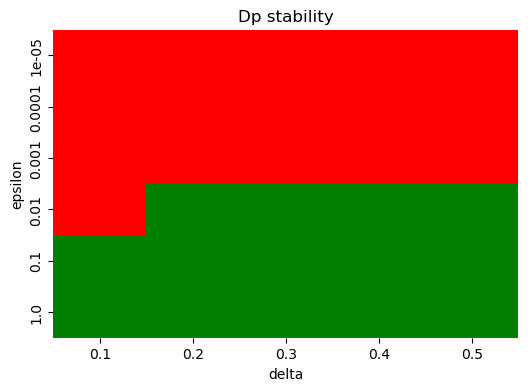

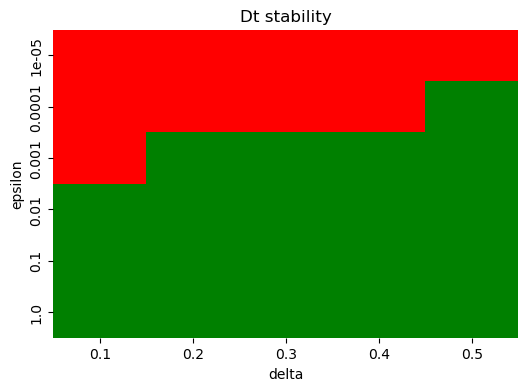

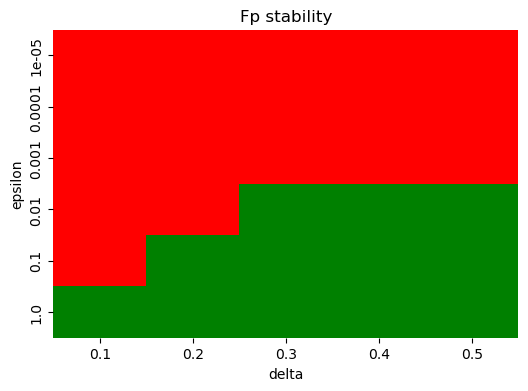

In [124]:
params = ['Dp', 'Dt', 'Fp']
for i, param in enumerate(params):
    print_stability_with_lambda_eps(epsilon_values_to_test, lambda_values_to_test, binomial_stats[:, :, i], param)


In [75]:
# # Quantile calculation
for k in range(kappa):
    for index, net in enumerate(net_stability[k, :]):
        quantile_stability[k, index, :] = get_qunatile(net=net, calibration_dataset=X_calib, alpha=0.1)
        print('iteration ' + str(k) + ', model: ' + str(index))

iteration 0, model: 0
iteration 0, model: 1
iteration 1, model: 0
iteration 1, model: 1
iteration 2, model: 0
iteration 2, model: 1
iteration 3, model: 0
iteration 3, model: 1
iteration 4, model: 0
iteration 4, model: 1
iteration 5, model: 0
iteration 5, model: 1
iteration 6, model: 0
iteration 6, model: 1
iteration 7, model: 0
iteration 7, model: 1
iteration 8, model: 0
iteration 8, model: 1
iteration 9, model: 0
iteration 9, model: 1


In [78]:
def calc_intersection(upper_n, lower_n, y_n, upper_n_minus_1, lower_n_minus_1, y_n_minus_1):
    min_upper = np.min([upper_n + y_n, upper_n_minus_1 + y_n_minus_1])
    max_lower = np.max([y_n - lower_n, y_n_minus_1 - lower_n_minus_1])
    print('n interval: {0}, {1}'.format(y_n - lower_n, upper_n + y_n))
    print('n-1 interval: {0}, {1}'.format(y_n_minus_1 - lower_n_minus_1, upper_n_minus_1 + y_n_minus_1))
    width_n = upper_n + lower_n # (upper_n + y_n) - (y_n - lower_n)
    width_n_minus_1 = upper_n_minus_1 + lower_n_minus_1 
    intersection_width = min_upper - max_lower
    f = 0.5*intersection_width/width_n + 0.5*intersection_width/width_n_minus_1
    if f<0 : return 0
    return f

In [126]:
calc_intersection(1, 1, 2, 1, 1, 3)

n interval: 1, 3
n-1 interval: 2, 4


0.5

In [80]:
stability_sample_pred = np.zeros(shape=(kappa, 2, 3))
for k in range(kappa):
    stability_sample = X_test[k, 1:].reshape((1, 7))
    for index, net in enumerate(net_stability[k, :]):
        net.eval()
        with torch.no_grad():
            _, Dp, Dt, Fp = net(torch.from_numpy(stability_sample.astype(np.float32)))

        Dp = Dp.numpy()
        Dt = Dt.numpy()
        Fp = Fp.numpy()

        # make sure Dp is the larger value between Dp and Dt
        if np.mean(Dp) < np.mean(Dt):
            Dp, Dt = Dt, Dp
            Fp = 1 - Fp

        stability_sample_pred[k, index, 0] = Dp
        stability_sample_pred[k, index, 1] = Dt
        stability_sample_pred[k, index, 2] = Fp

In [81]:
intersection_score = np.zeros(shape=(kappa, 3))
for k in range(kappa):
    for index in range(3):
        quantile_n = quantile_stability[k, 0, index]
        quantile_n_minus_1 = quantile_stability[k, 1, index]
        stability_sample_pred_n = stability_sample_pred[k, 0, index]
        stability_sample_pred_n_minus_1 = stability_sample_pred[k, 1, index]
        intersection_score[k, index] = calc_intersection(quantile_n, quantile_n, stability_sample_pred_n, 
                                                       quantile_n_minus_1, quantile_n_minus_1, stability_sample_pred_n_minus_1)

n interval: 0.05796015656369081, 0.057980980511733386
n-1 interval: 0.05782969700300189, 0.05785028232133893
n interval: 0.0007907353010945246, 0.0007910825642771795
n-1 interval: 0.0009068679939014559, 0.0009071993698375577
n interval: 0.2522089304511906, 0.25227584223099936
n-1 interval: 0.25225193083157194, 0.2523210567248856
n interval: 0.01555189066010253, 0.032426242303078015
n-1 interval: 0.014064133124732028, 0.03095096353969668
n interval: -0.006065291346915357, 0.008357745589621657
n-1 interval: -0.004795549557536681, 0.007066218302577575
n interval: -0.00987468298465033, 0.43641279276400824
n-1 interval: -0.010542276443146759, 0.4390648632656565
n interval: 0.06536735942549733, 0.08207933256440135
n-1 interval: 0.05600737998029981, 0.07275417974450793
n interval: -0.003832813217021412, 0.005574982478000111
n-1 interval: -0.0025268009441866347, 0.0043797454374803965
n interval: 0.043083730694664424, 0.5146483745604625
n-1 interval: 0.03779099359960636, 0.5103566847756378
n in

In [127]:
intersection_score

array([[0.        , 0.        , 0.35163399],
       [0.91223553, 0.91120909, 0.99630826],
       [0.44154807, 0.86706507, 0.98984952],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.69461573, 0.77686174, 0.96322179],
       [0.        , 0.        , 0.        ],
       [0.77391644, 0.73671429, 0.99225223],
       [0.        , 0.        , 0.        ],
       [0.74303433, 0.        , 0.9852102 ]])

In [133]:
# Binomial test for conformal stability
epsilon_values_to_test_conf = np.logspace(-5, 0, 6) # np.round(np.linspace(0.2, 1, 5), 2)
lambda_values_to_test_conf = np.linspace(0.1, 0.5, 5)  # np.linspace(0.05, 0.5, 10)

B_scanned_conf = np.zeros((len(epsilon_values_to_test_conf), 3), dtype=int)
binomial_stats_conf = np.zeros((len(epsilon_values_to_test_conf), len(lambda_values_to_test_conf), 3), dtype=float)

for e_index, eps in enumerate(epsilon_values_to_test_conf):
    delta_compare_eps_conf = intersection_score > np.repeat(eps, 3)
    B_scanned_conf[e_index, :] = np.sum(delta_compare_eps_conf, axis=0)
    for lambda_index, lambda_value in enumerate(lambda_values_to_test_conf):
        binomial_stats_conf[e_index, lambda_index, :] = (B_scanned_conf[e_index, :] / kappa ) < lambda_value

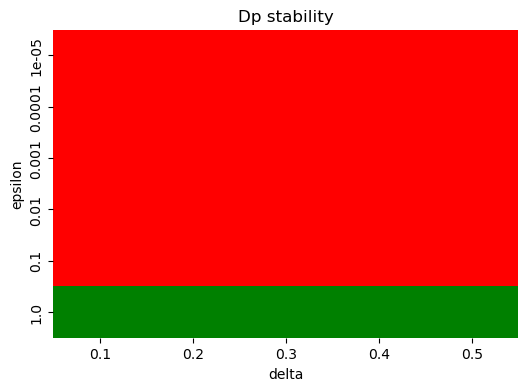

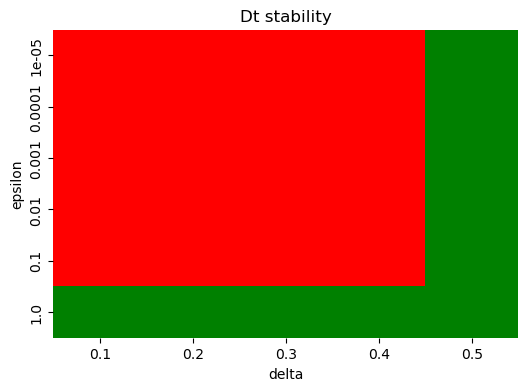

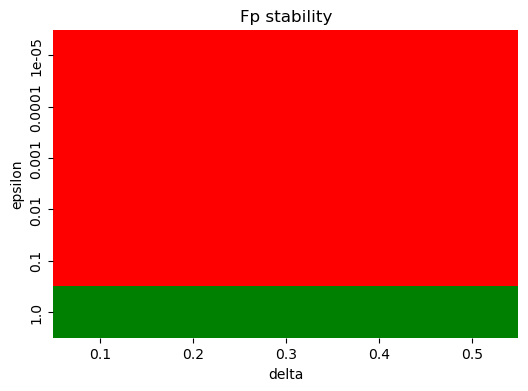

In [134]:
for i, param in enumerate(params):
    print_stability_with_lambda_eps(epsilon_values_to_test_conf, lambda_values_to_test_conf, 
                                    binomial_stats_conf[:, :, i], param)